# Exploration on mQTL significant at Bonferroni $\alpha < 0.05$
1. SNP-level and effect size exploration (read through current draft)
1. CpG-level counting
1. Gene-level counting and enrichment (export genes to FUMA for analysis)

In [1]:
library(here)
library(glue)
library(data.table)
library(tidyverse)
library(VennDiagram)
library(eulerr)
library(arrow)

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::collapse()  masks glue::collapse()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: grid

Loading required package: futile.logger

Warning message:
“package ‘arrow’ was built under R version 4.1.2”

Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timesta

### Correlation in effects between meta-analyzed studies

In [2]:
mat_qtl <- schema(
    SNP = large_utf8(),
    gene = large_utf8(),
    beta = double(),
    `t-stat` = double(),
    `p-value` = double(),
    FDR = double()
)
nichd <- open_dataset(
        "../../../delahaye_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all.parquet",
        format="parquet",
        schema=mat_qtl
    ) %>% 
    filter(FDR < 0.05) %>%
    collect()

nichd_sex <- open_dataset(
        "../../../delahaye_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.parquet",
        format="parquet",
        schema=mat_qtl
    ) %>% 
    filter(FDR < 0.05) %>%
    collect()
richs <- open_dataset(
        "../../../RICHS_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all.parquet",
        format="parquet",
        schema=mat_qtl
    ) %>% 
    filter( gene %in% nichd$gene) %>%
    collect()
richs_sex <- open_dataset(
        "../../../RICHS_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.parquet",
        format="parquet",
        schema=mat_qtl
    ) %>%
    filter(gene %in% nichd_sex$gene) %>%
    collect()


nichd_matched <- nichd %>%
    left_join(richs,by=c("SNP","gene"))
nichd_sex_matched <- nichd_sex %>% 
    left_join(richs_sex,by=c("SNP","gene"))

In [ ]:
nichd_matched <- na.omit(nichd_matched)
nichd_sex_matched <- na.omit(nichd_sex_matched)
cor.test(nichd_matched$beta.x,nichd_matched$beta.y, method="spearman")
cor.test(nichd_sex_matched$beta.x,nichd_sex_matched$beta.y, method="spearman")

Warning message in cor.test.default(nichd_matched$beta.x, nichd_matched$beta.y, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  nichd_matched$beta.x and nichd_matched$beta.y
S = 5.8822e+17, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.818891 


Warning message in cor.test.default(nichd_sex_matched$beta.x, nichd_sex_matched$beta.y, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  nichd_sex_matched$beta.x and nichd_sex_matched$beta.y
S = 8.5553e+13, p-value = 0.001908
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.01095009 


##  Counting CpG sites with significant mQTL in meta-analysis

In [4]:
# Reading in significant mQTL
male <-fread(here("data", "delahaye_richs_male_bonf_maf05.txt.gz"))
female <-fread(here("data", "delahaye_richs_female_bonf_maf05.txt.gz"))
sex_interaction <-fread(
    here("data", "delahaye_richs_sex_interaction_bonf_maf05.txt.gz")
)
marginal <-fread(here("data", "delahaye_richs_marginal_bonf_maf05.txt.gz"))

In [5]:
male_int <- male[sex_interaction[,.(Probe,SNP)],,on=.(Probe,SNP),nomatch=0]
female_int <- female[sex_interaction[,.(Probe,SNP)],,on=.(Probe,SNP),nomatch=0]

### Associations relative to distance to CpG site

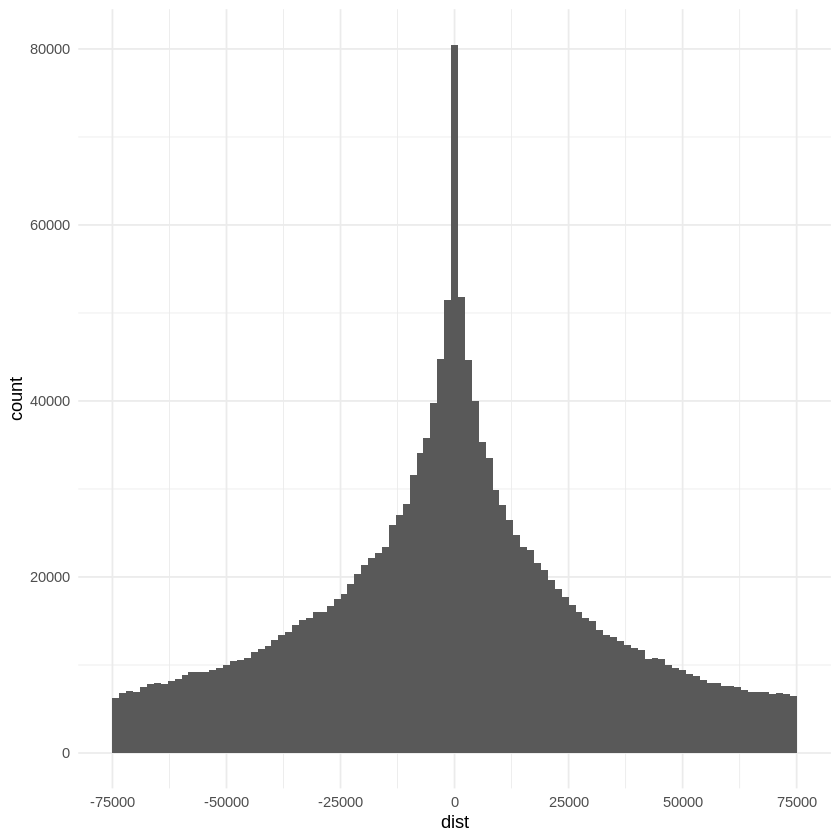

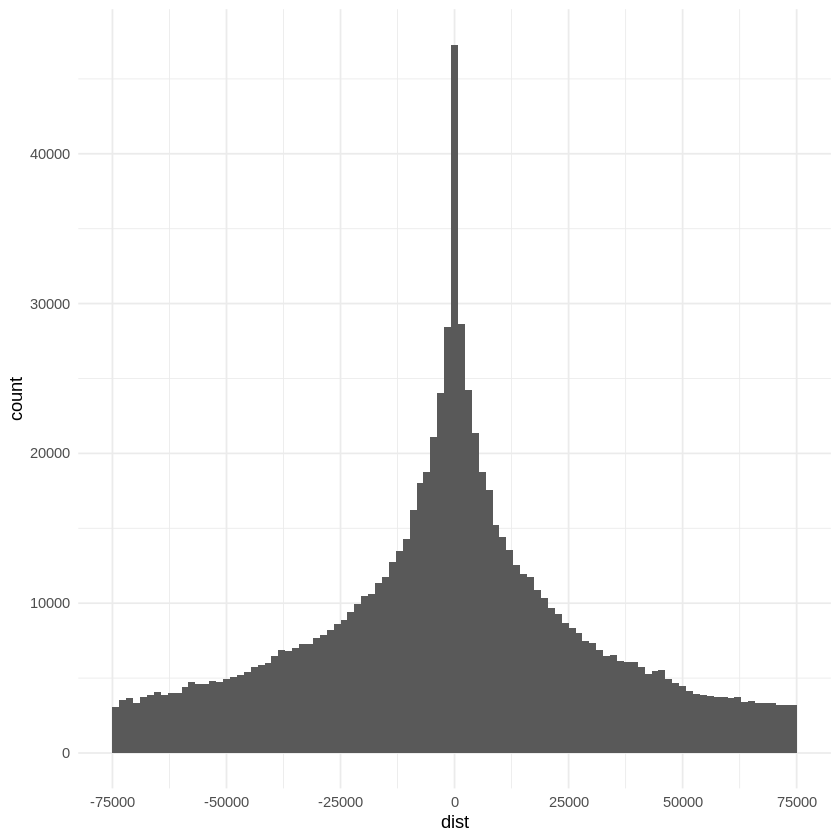

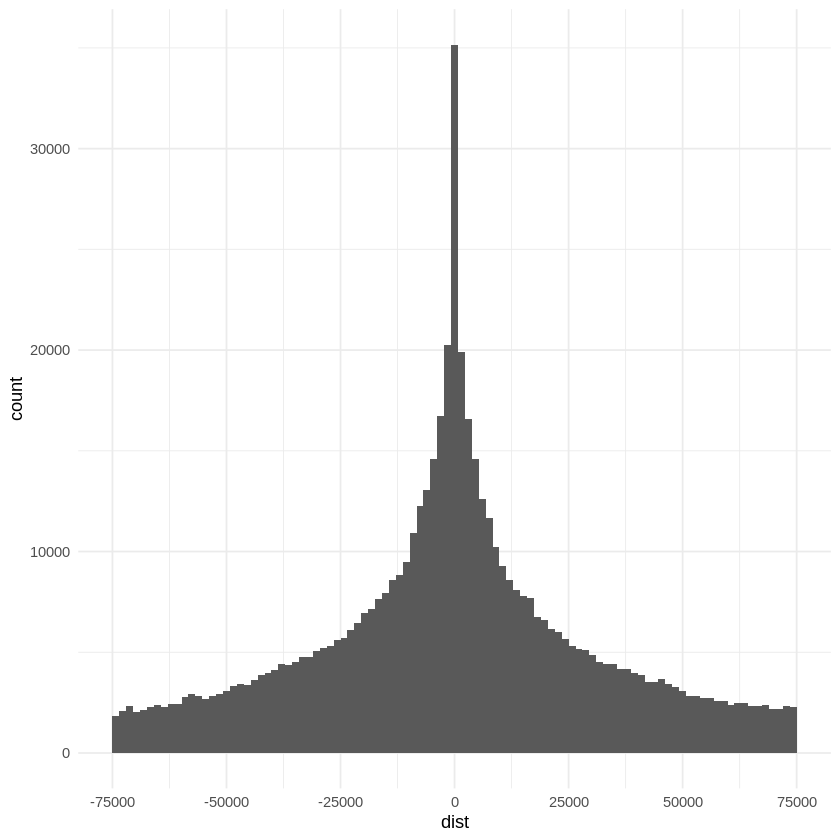

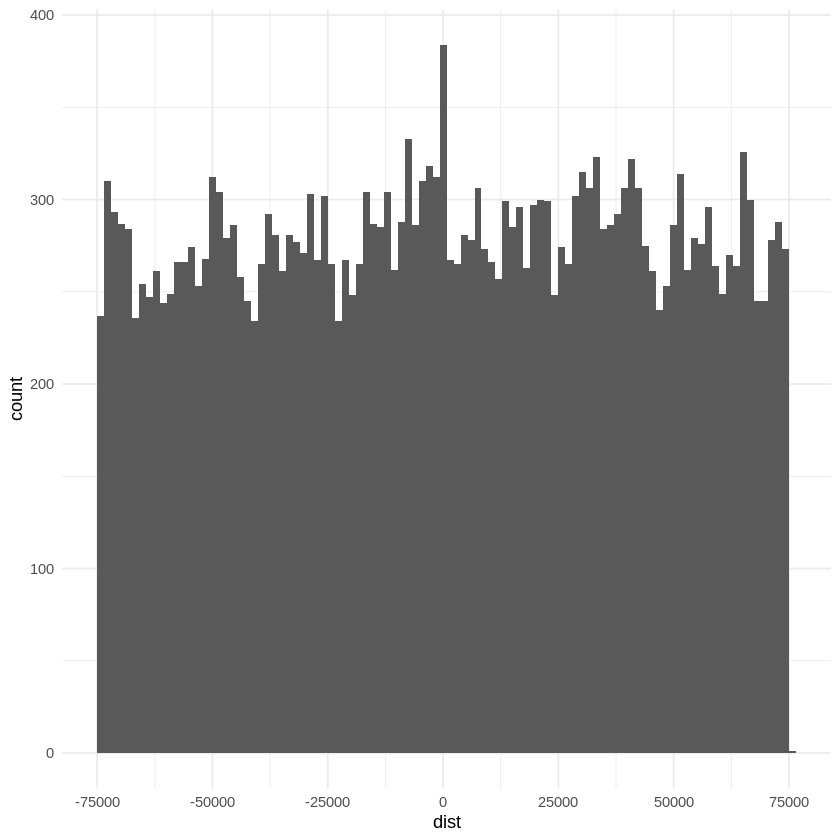

In [6]:
ggplot(marginal[,.(dist=Probe_bp - BP)][abs(dist) <=75000],aes(dist)) +
    geom_histogram(bins=100)+
    scale_x_continuous(breaks = seq(-75000,75000,25000))+
    theme_minimal()


ggplot(male[,.(dist=Probe_bp - BP)][abs(dist) <=75000],aes(dist)) +
    geom_histogram(bins=100)+
    scale_x_continuous(breaks = seq(-75000,75000,25000))+
    theme_minimal()

ggplot(female[,.(dist=Probe_bp - BP)][abs(dist) <=75000],aes(dist)) +
    geom_histogram(bins=100)+
    scale_x_continuous(breaks = seq(-75000,75000,25000))+
    theme_minimal()

ggplot(sex_interaction[,.(dist=Probe_bp - BP)][abs(dist) <=75000],aes(dist)) +
    geom_histogram(bins=100)+
    scale_x_continuous(breaks = seq(-75000,75000,25000))+
    theme_minimal()

V1   V2  N   
1 2604 351 2876

V1   V2  N   
1 1760 255 1981

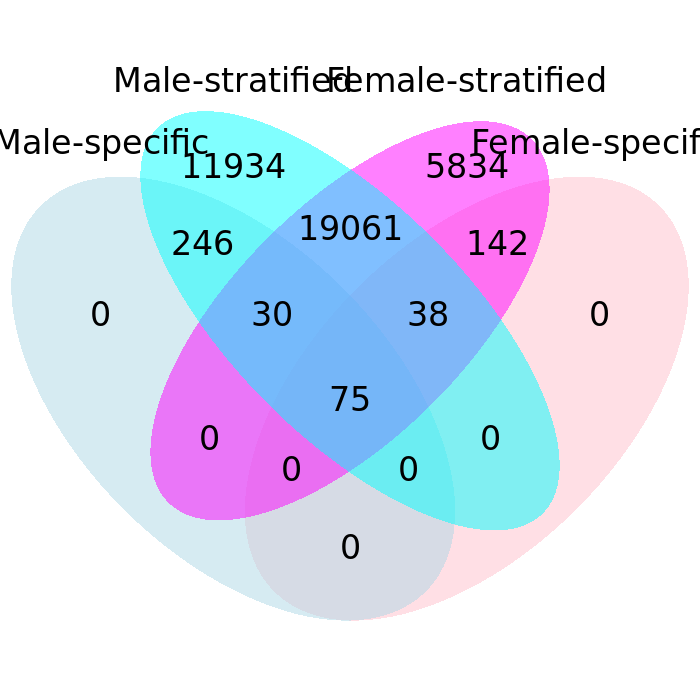

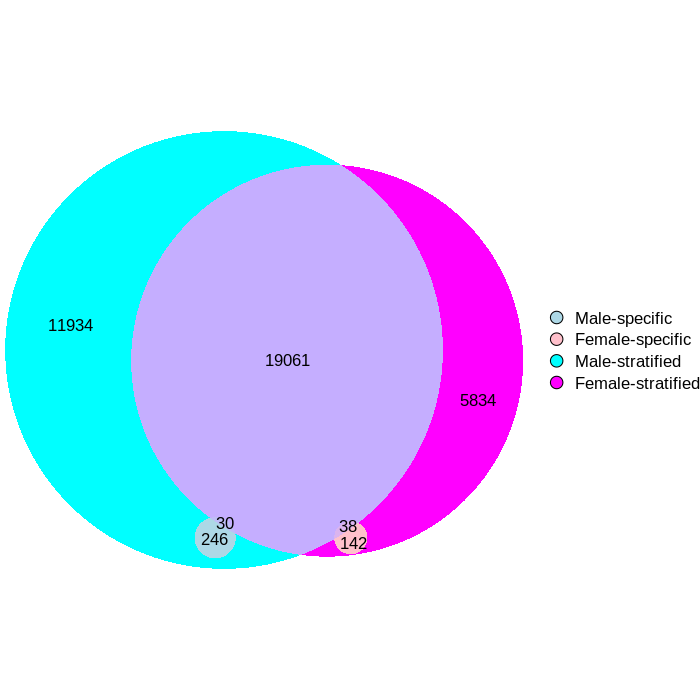

In [7]:
options(repr.plot.width= 7, repr.plot.height= 7, repr.plot.res = 100)
library(eulerr)
male_int[,.(uniqueN(SNP),uniqueN(Probe),.N)]
female_int[,.(uniqueN(SNP),uniqueN(Probe),.N)]
plot_input <- list(
            `Male-specific` = unique(male_int$Probe),
            `Female-specific` = unique(female_int$Probe),
            `Male-stratified` = unique(male$Probe),
            `Female-stratified` = unique(female$Probe)
        )

grid.draw(
    venn.diagram(
        plot_input,
        filename=NULL,
        fill=c("light blue", "pink","cyan","magenta"),
        cat.pos=c(0,0,0,0),
        lty = rep("blank",4),
        cex=2,
        cat.cex=2,
        main.cex=3,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",4),
        cat.fontfamily= rep("sans-serif",4),
    )
)
plot(
    euler(plot_input),
    quantities=TRUE,
    fills = list(fill=c("light blue", "pink","cyan","magenta")),
    legend=list(names(plot_input)),
    adjust_labels=TRUE,
    lty=0
)

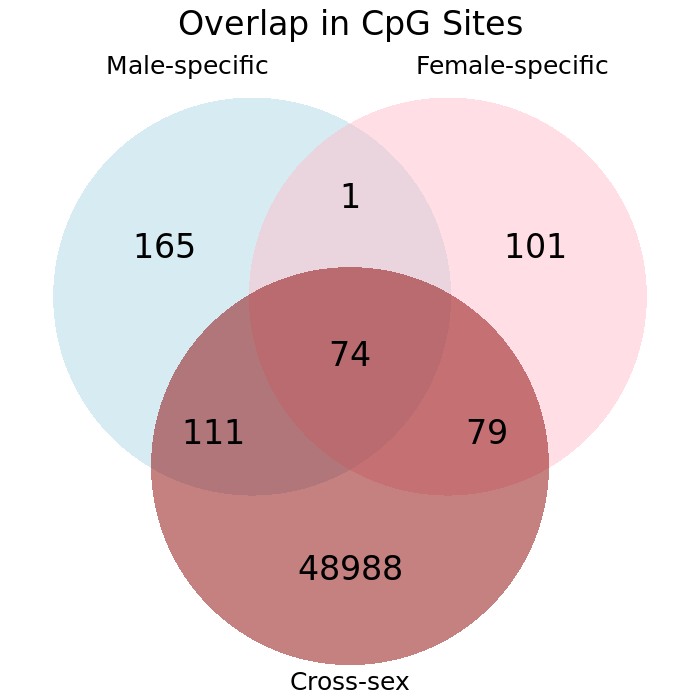

In [8]:
grid.draw(
    venn.diagram(
        list("Male-specific" = unique(male_int$Probe), "Female-specific" = unique(female_int$Probe),"Cross-sex" = unique(marginal$Probe)),
        filename=NULL,
        fill=c("light blue", "pink", "dark Red"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in CpG Sites"
    )
)

In [9]:
nrow(male_int[marginal[,.SD[which.min(p)],by="Probe"],.SD[which.min(p)],by = "Probe",on=c("SNP","Probe"),nomatch=0])
nrow(female_int[marginal[,.SD[which.min(p)],by="Probe"],.SD[which.min(p)],by = "Probe",on=c("SNP","Probe"),nomatch=0])
nrow(male_int[female_int[,.SD[which.min(p)],by="Probe"],.SD[which.min(p)],by = "Probe",on=c("SNP","Probe"),nomatch=0])

[1] 68

[1] 64

[1] 67

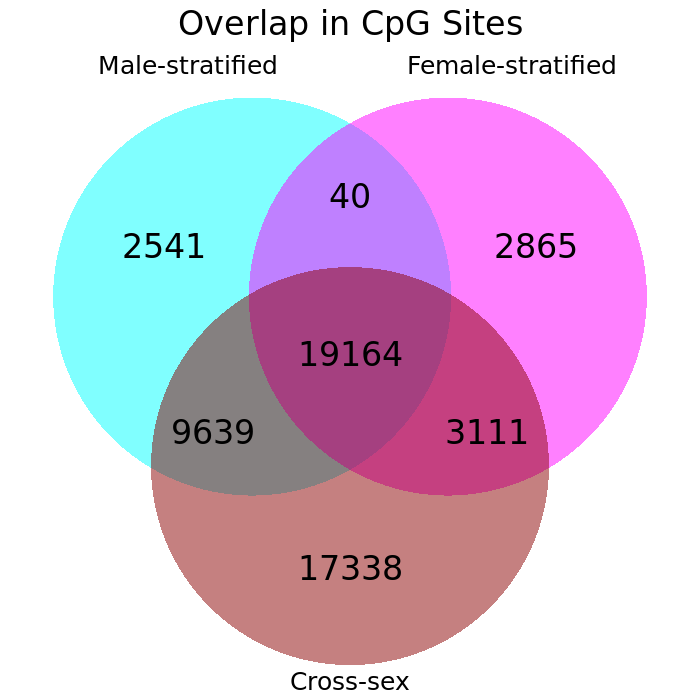

In [10]:
grid.draw(
    venn.diagram(
        list("Male-stratified"= unique(male$Probe), "Female-stratified" = unique(female$Probe),"Cross-sex" = unique(marginal$Probe)),
        filename=NULL,
        fill=c("cyan", "magenta", "dark Red"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in CpG Sites"
    )
)

### Number of mQTL per CpG site

In [11]:
mean(marginal[,.(x= .N), by = "Probe"]$x)
mean(sex_interaction[,.(x= .N), by = "Probe"]$x)
mean(male[,.(x= .N), by = "Probe"]$x)
mean(female[,.(x= .N), by = "Probe"]$x)
mean(male_int[,.(x= .N), by = "Probe"]$x)
mean(female_int[,.(x= .N), by = "Probe"]$x)

[1] 34.5051

[1] 11.13138

[1] 27.59323

[1] 22.97383

[1] 8.193732

[1] 7.768627

## Differences in proportion and effect size differences

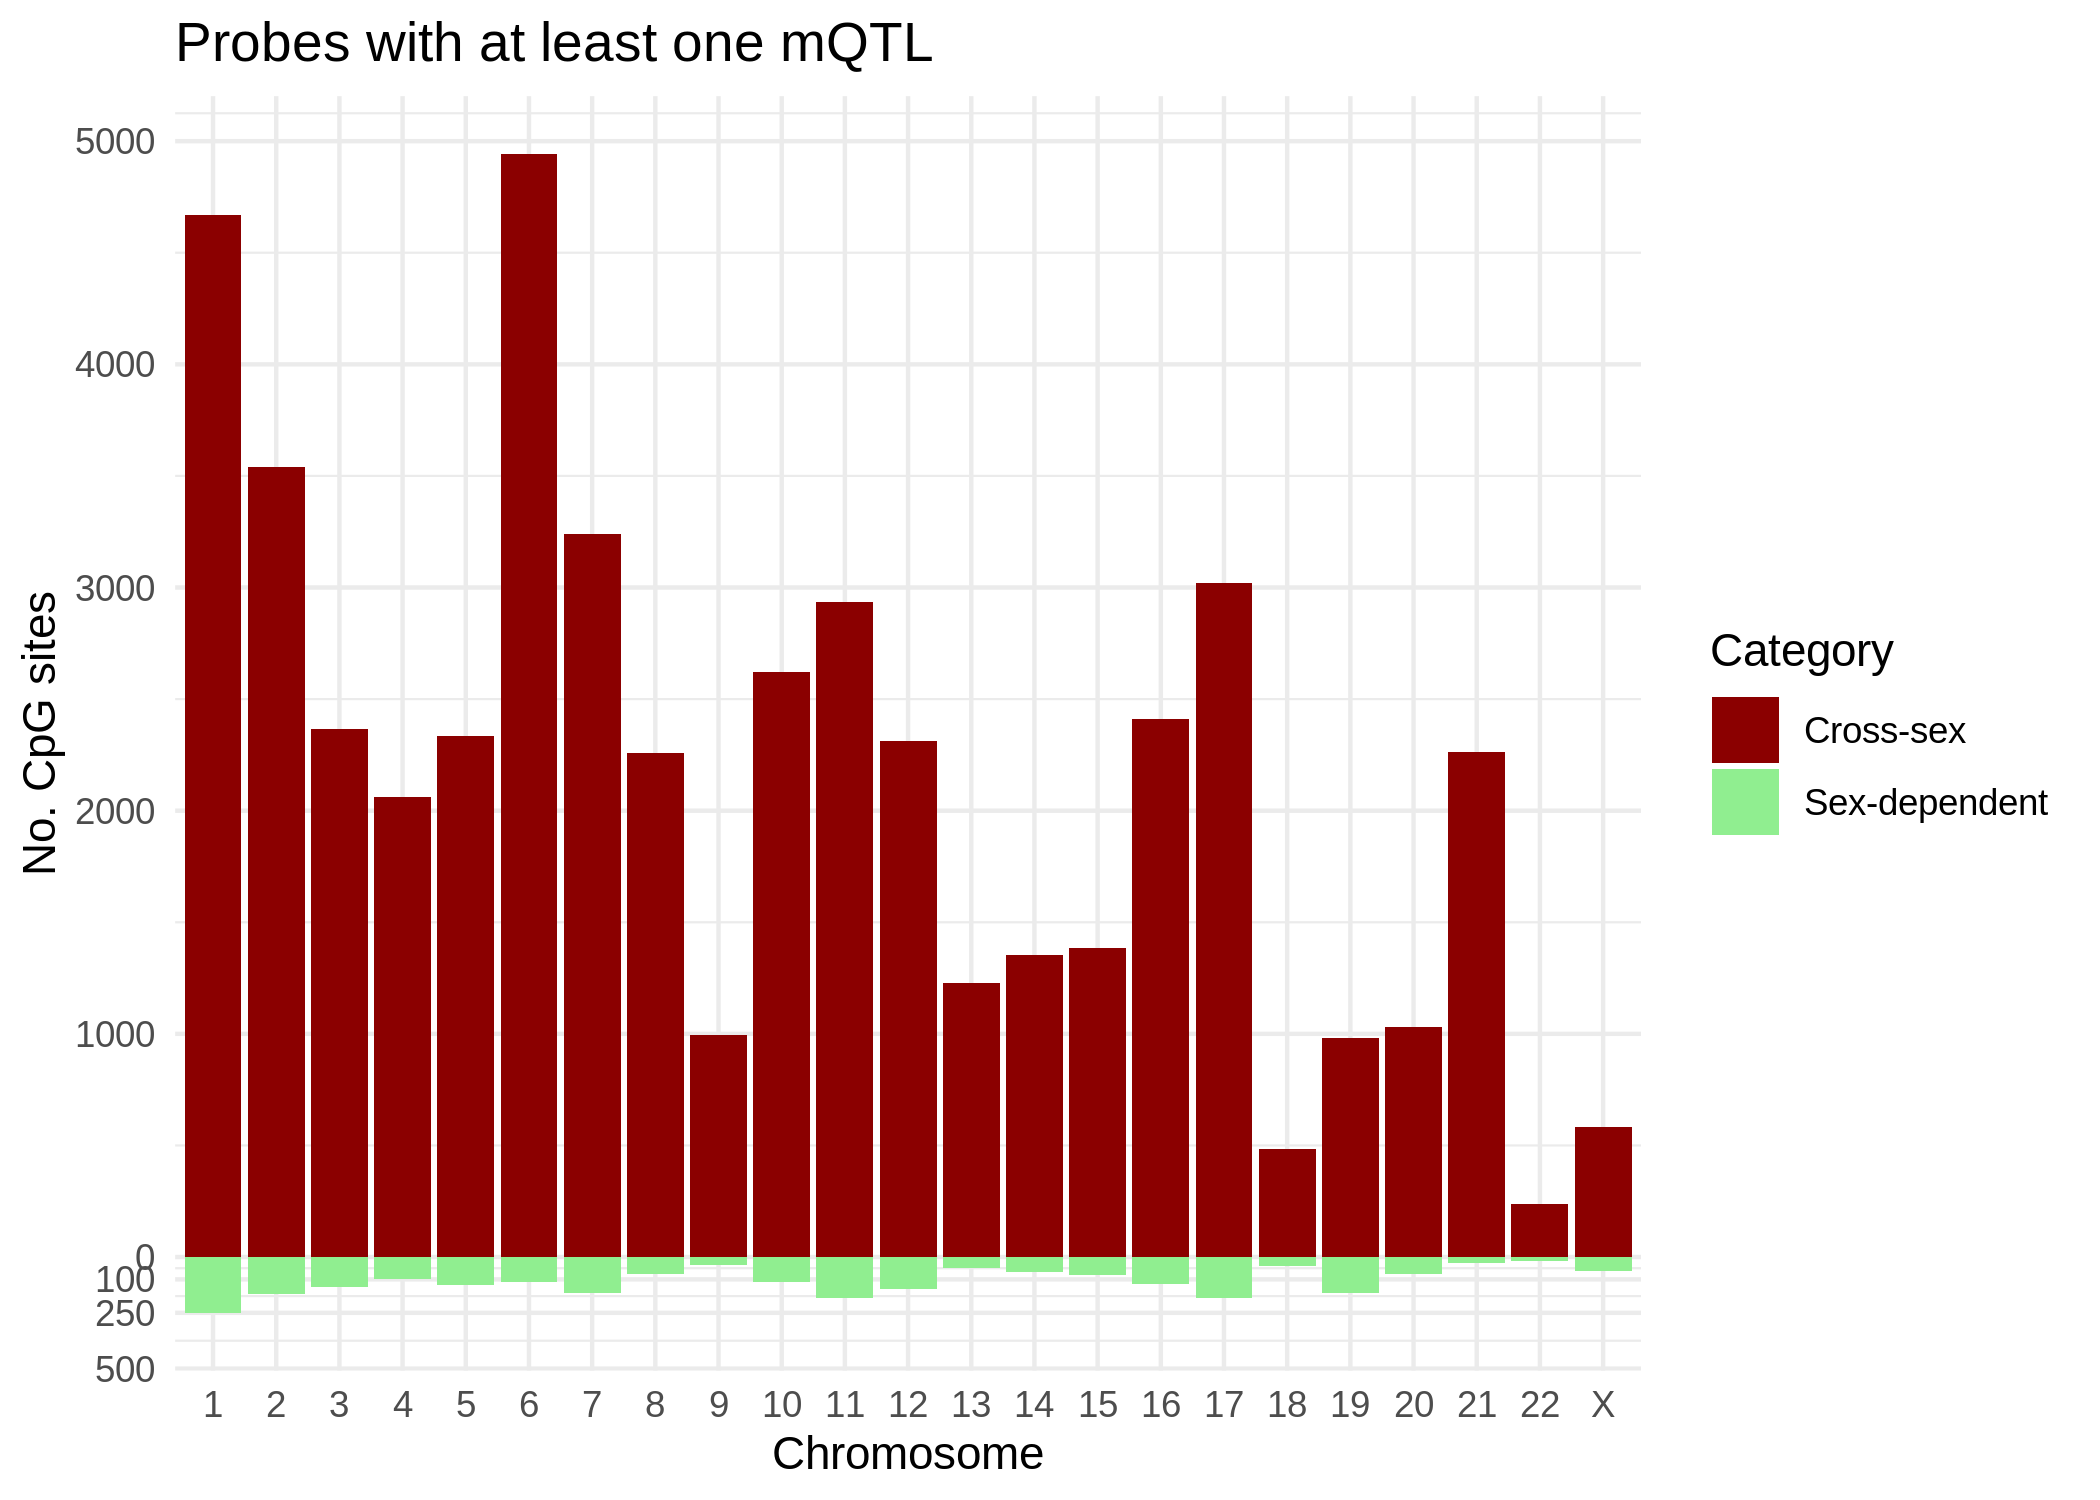

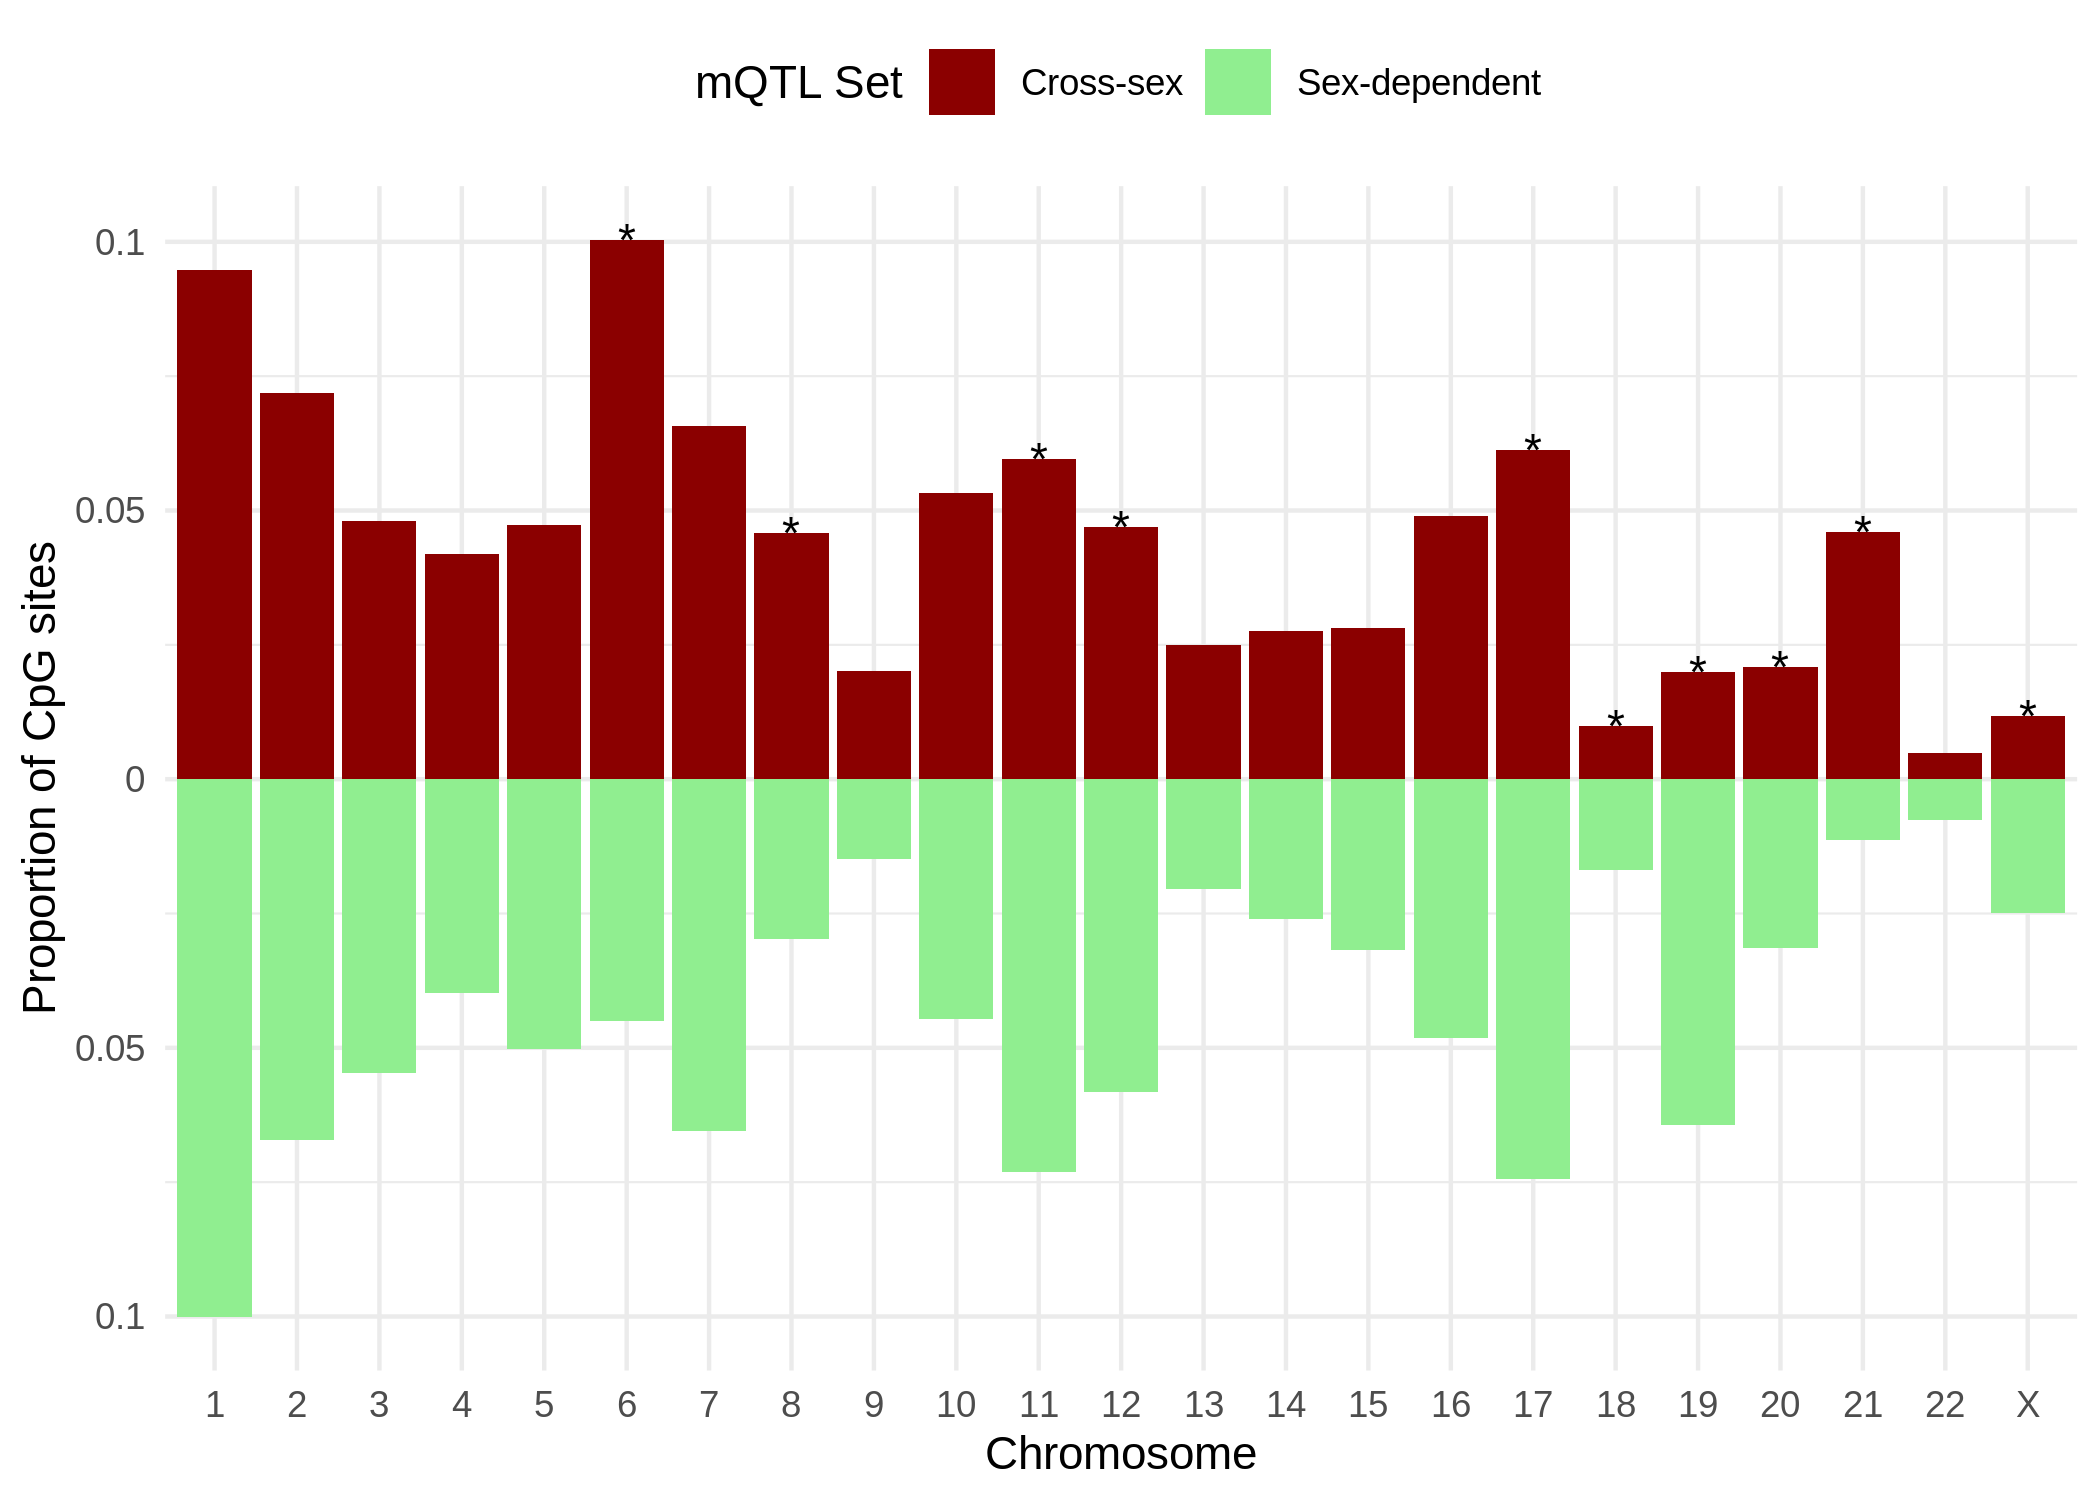

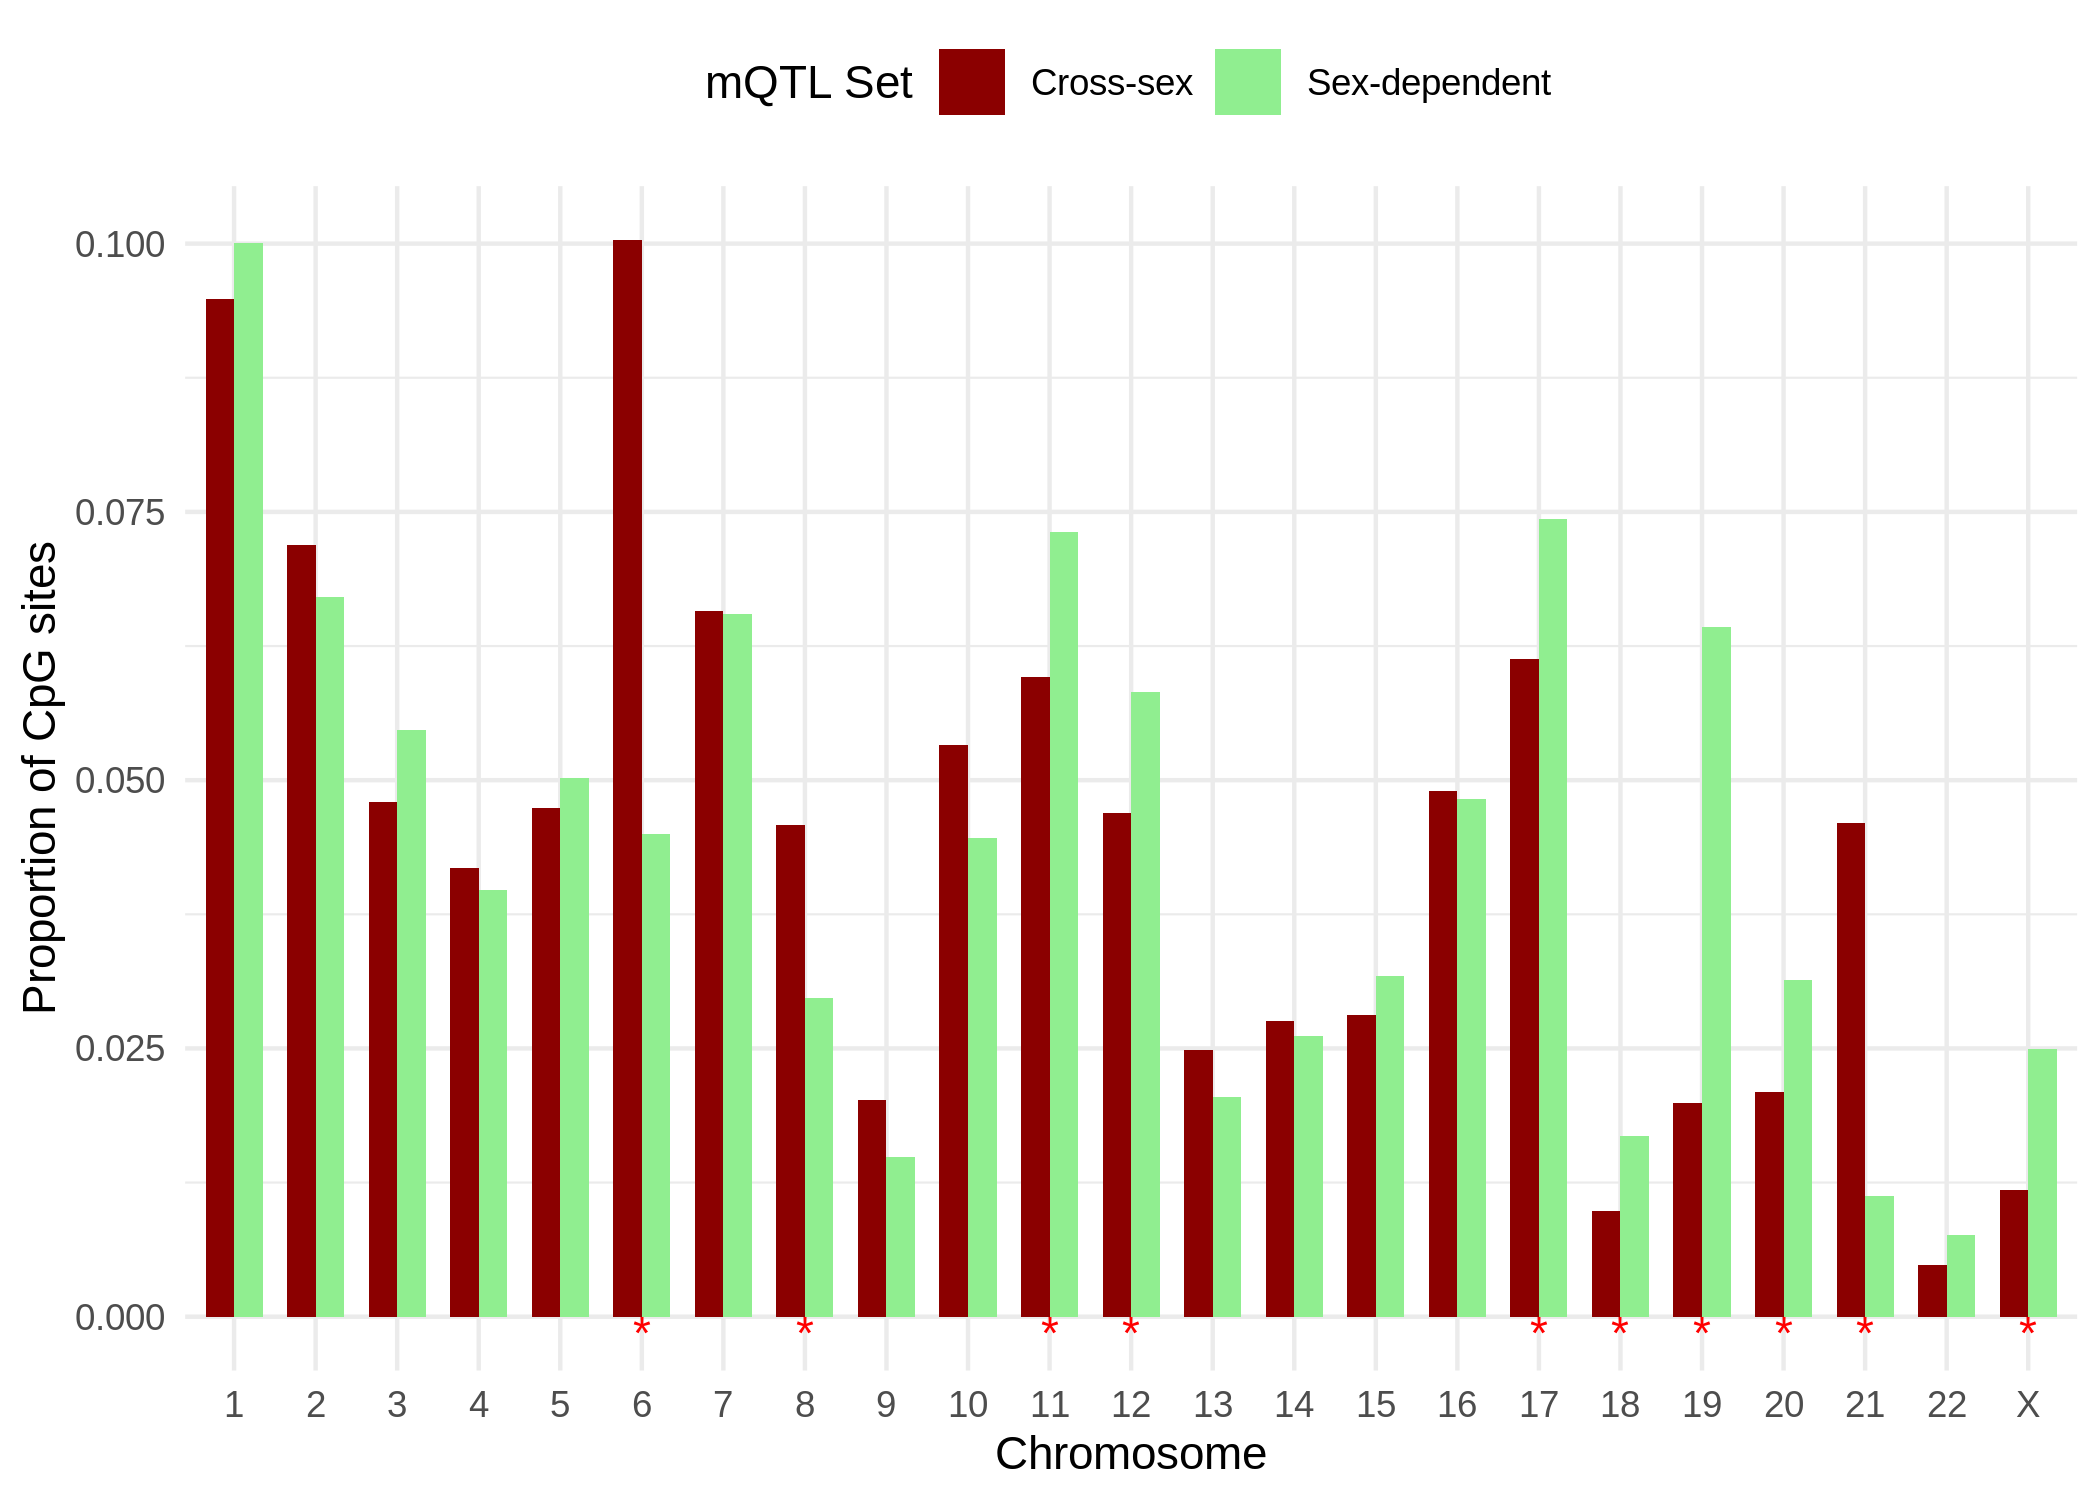

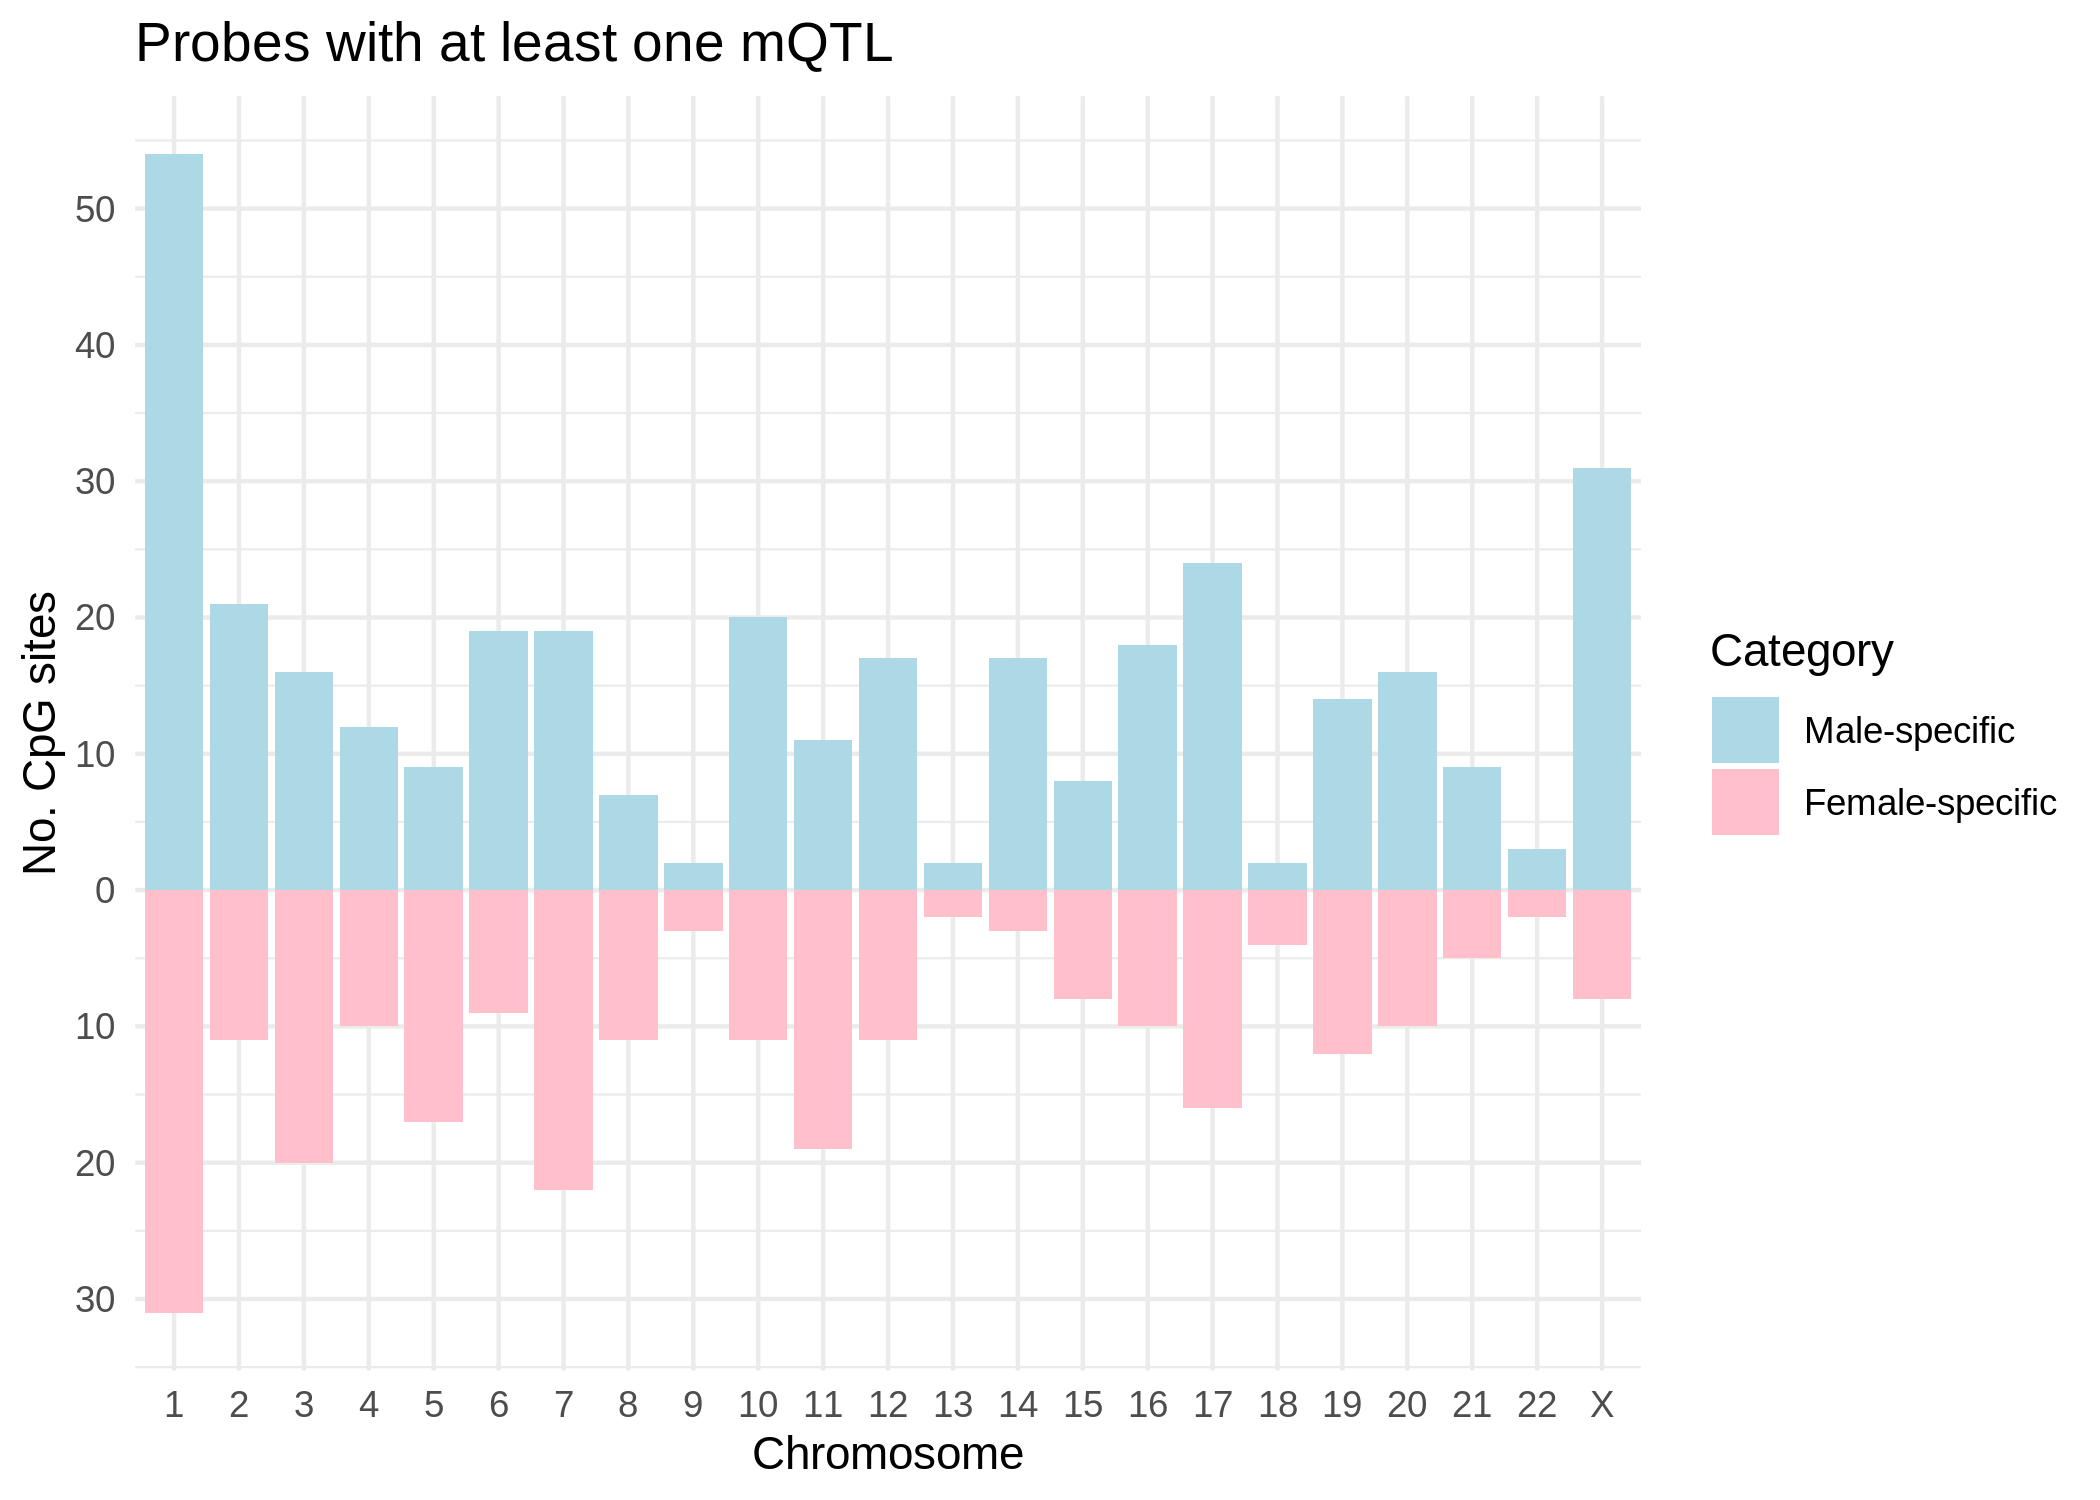

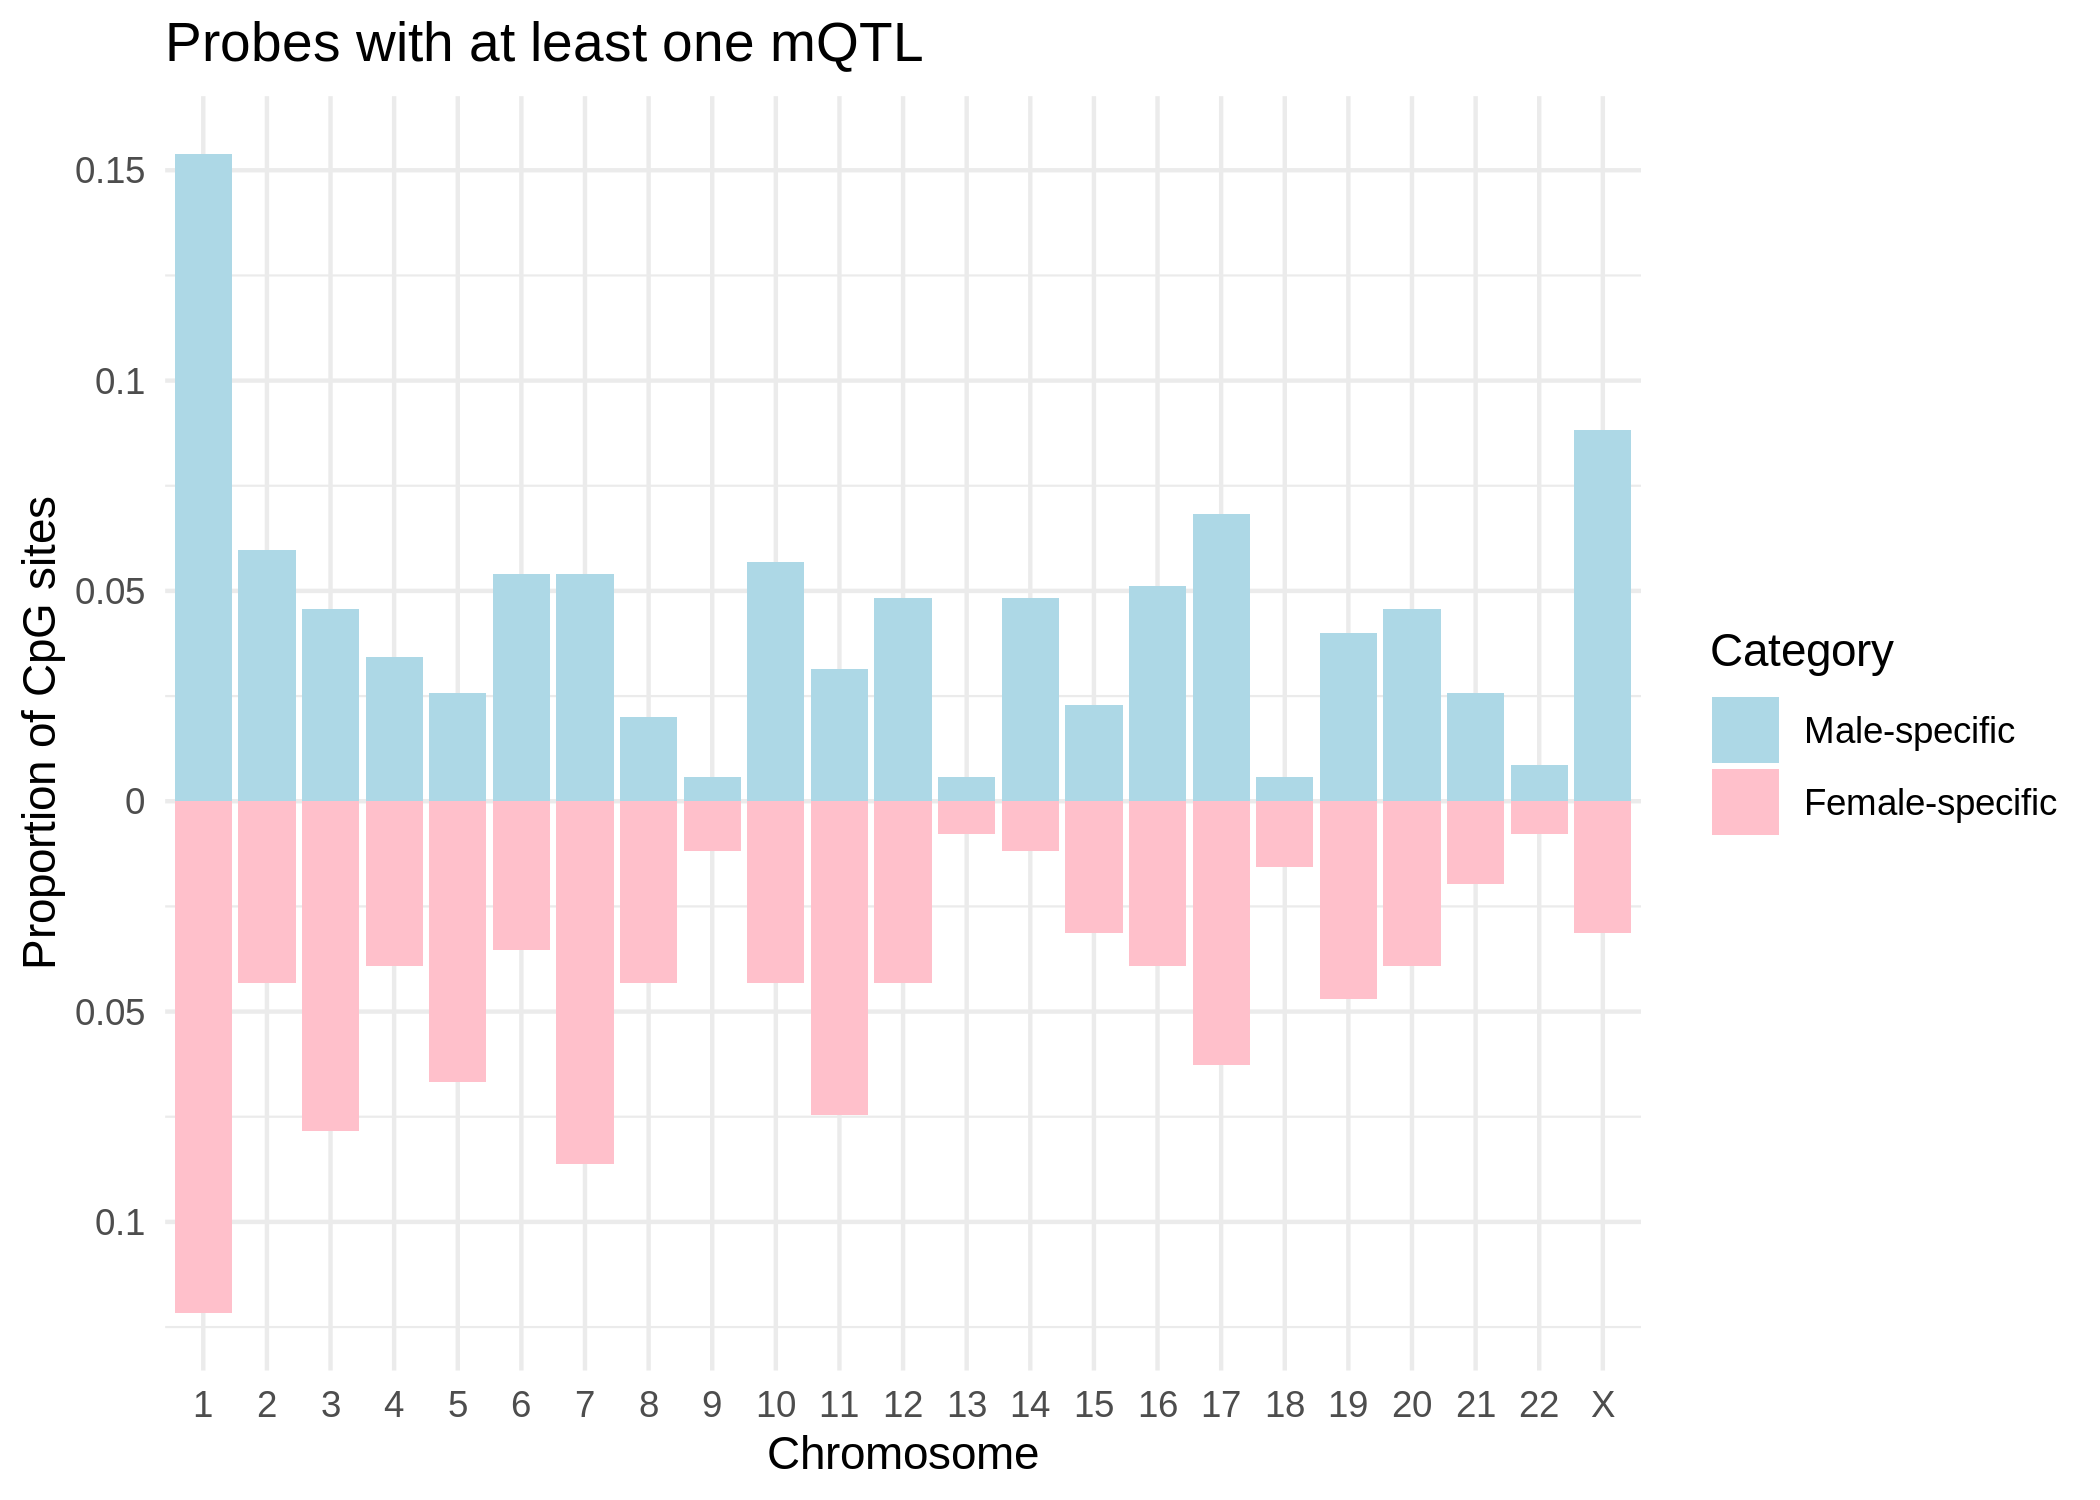

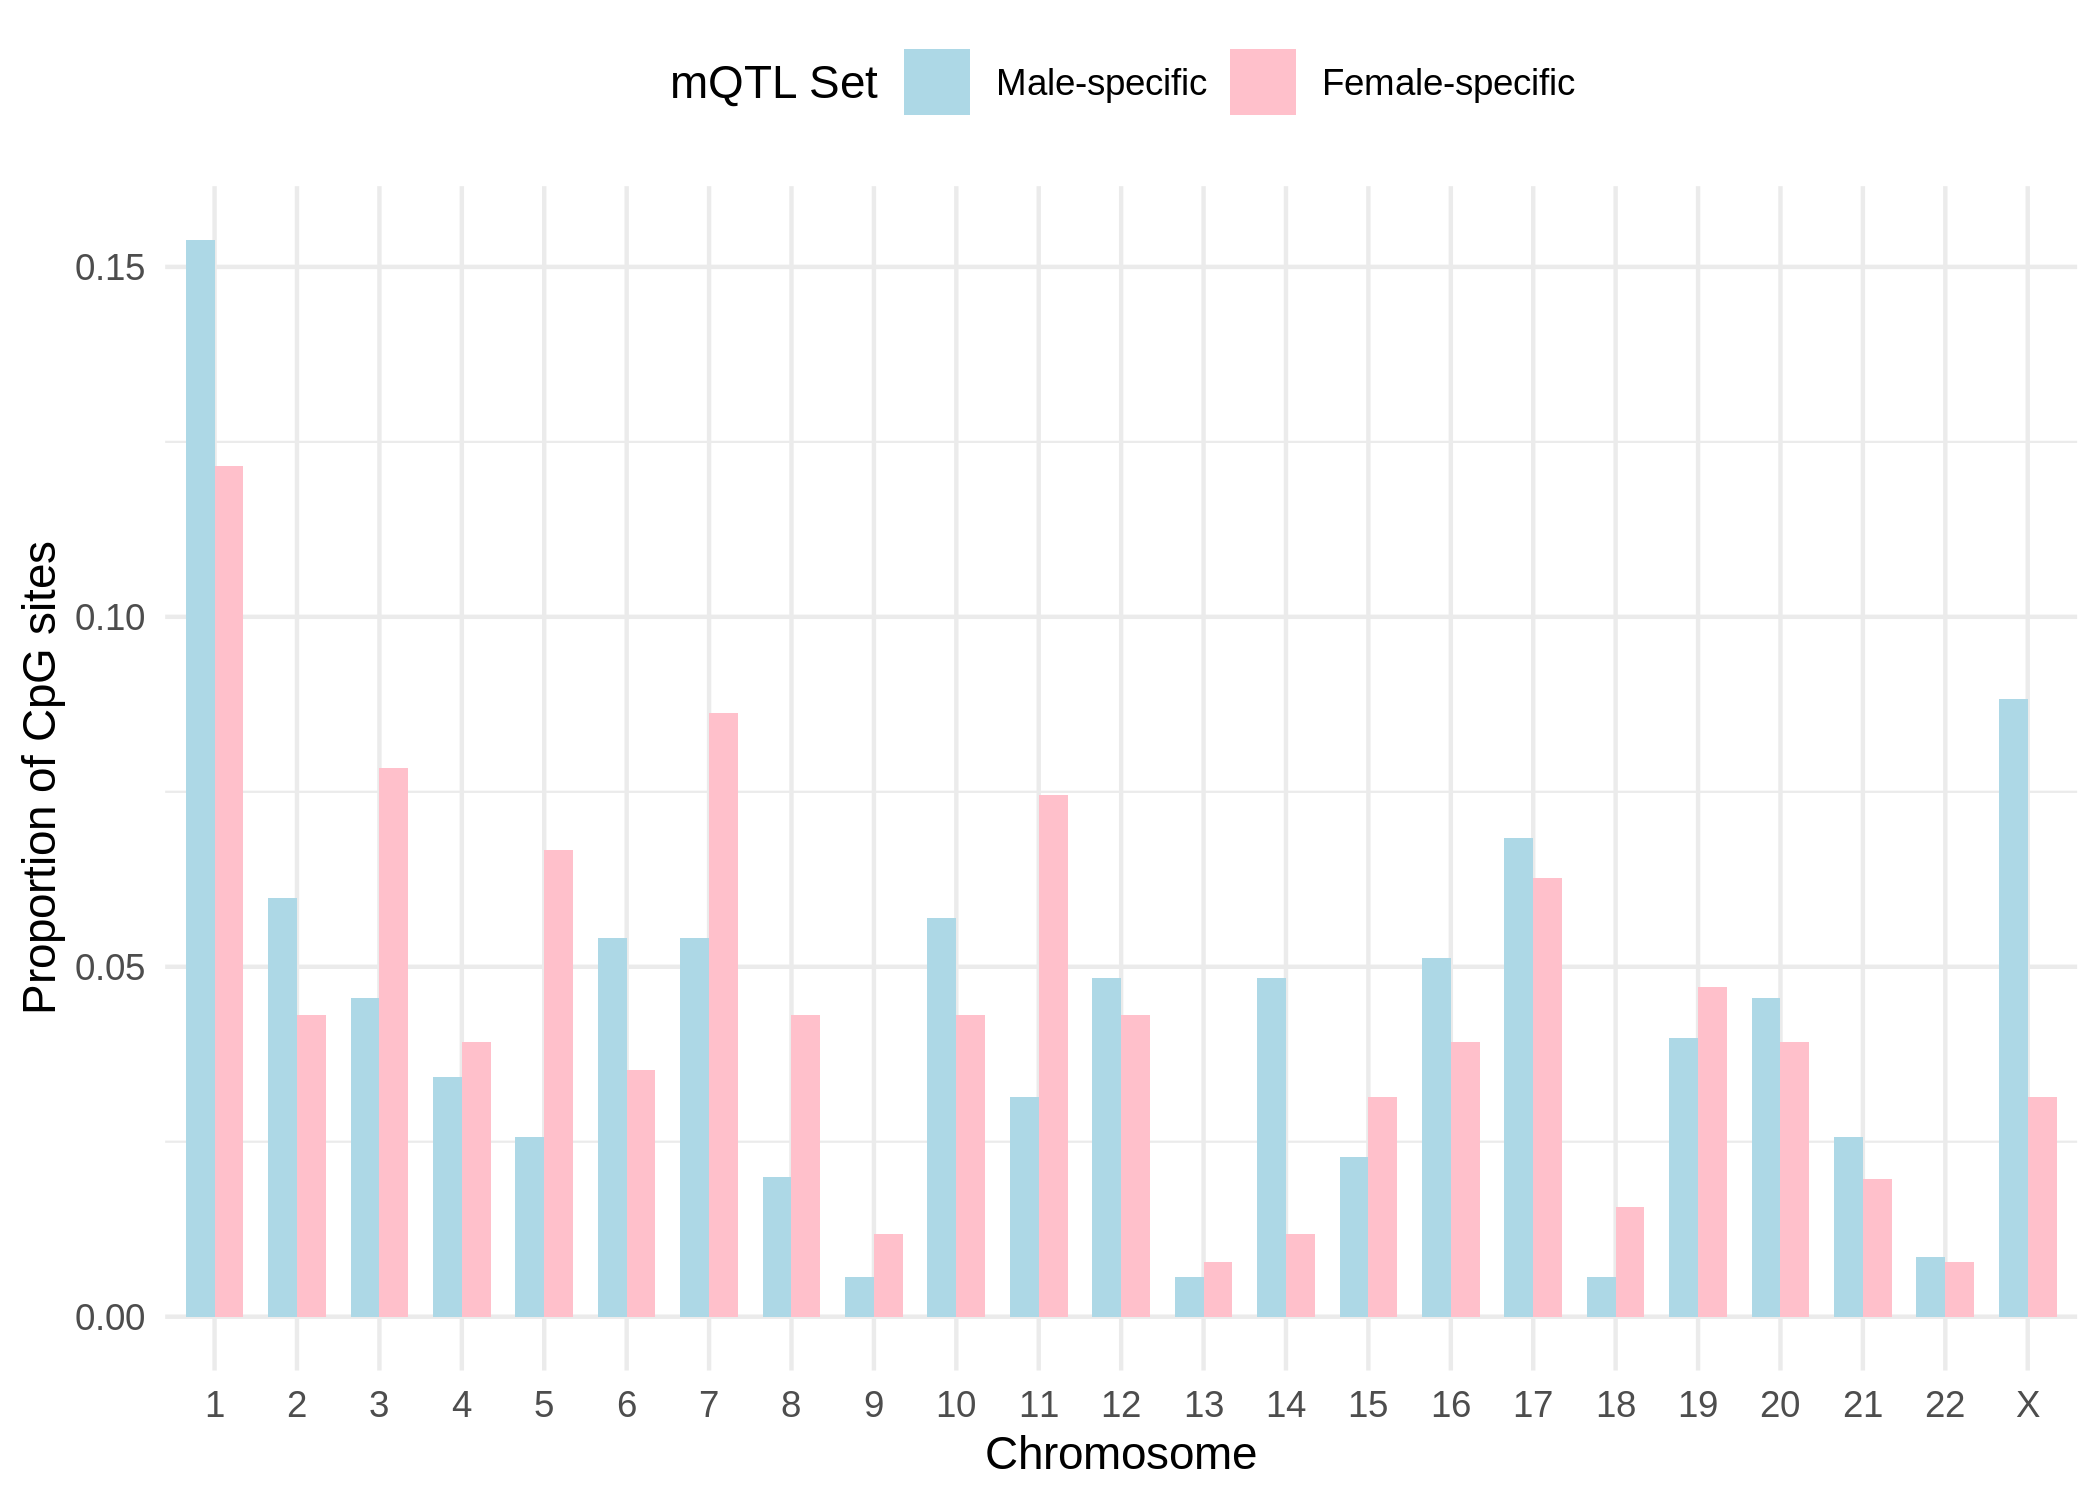

Warning message in cor.test.default(merged_int$b.x, merged_int$b.y, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_sex$b.x, merged_sex$b.y, method = "spearman"):
“Cannot compute exact p-value with ties”


[1] 0

[1] 4.858727e-05

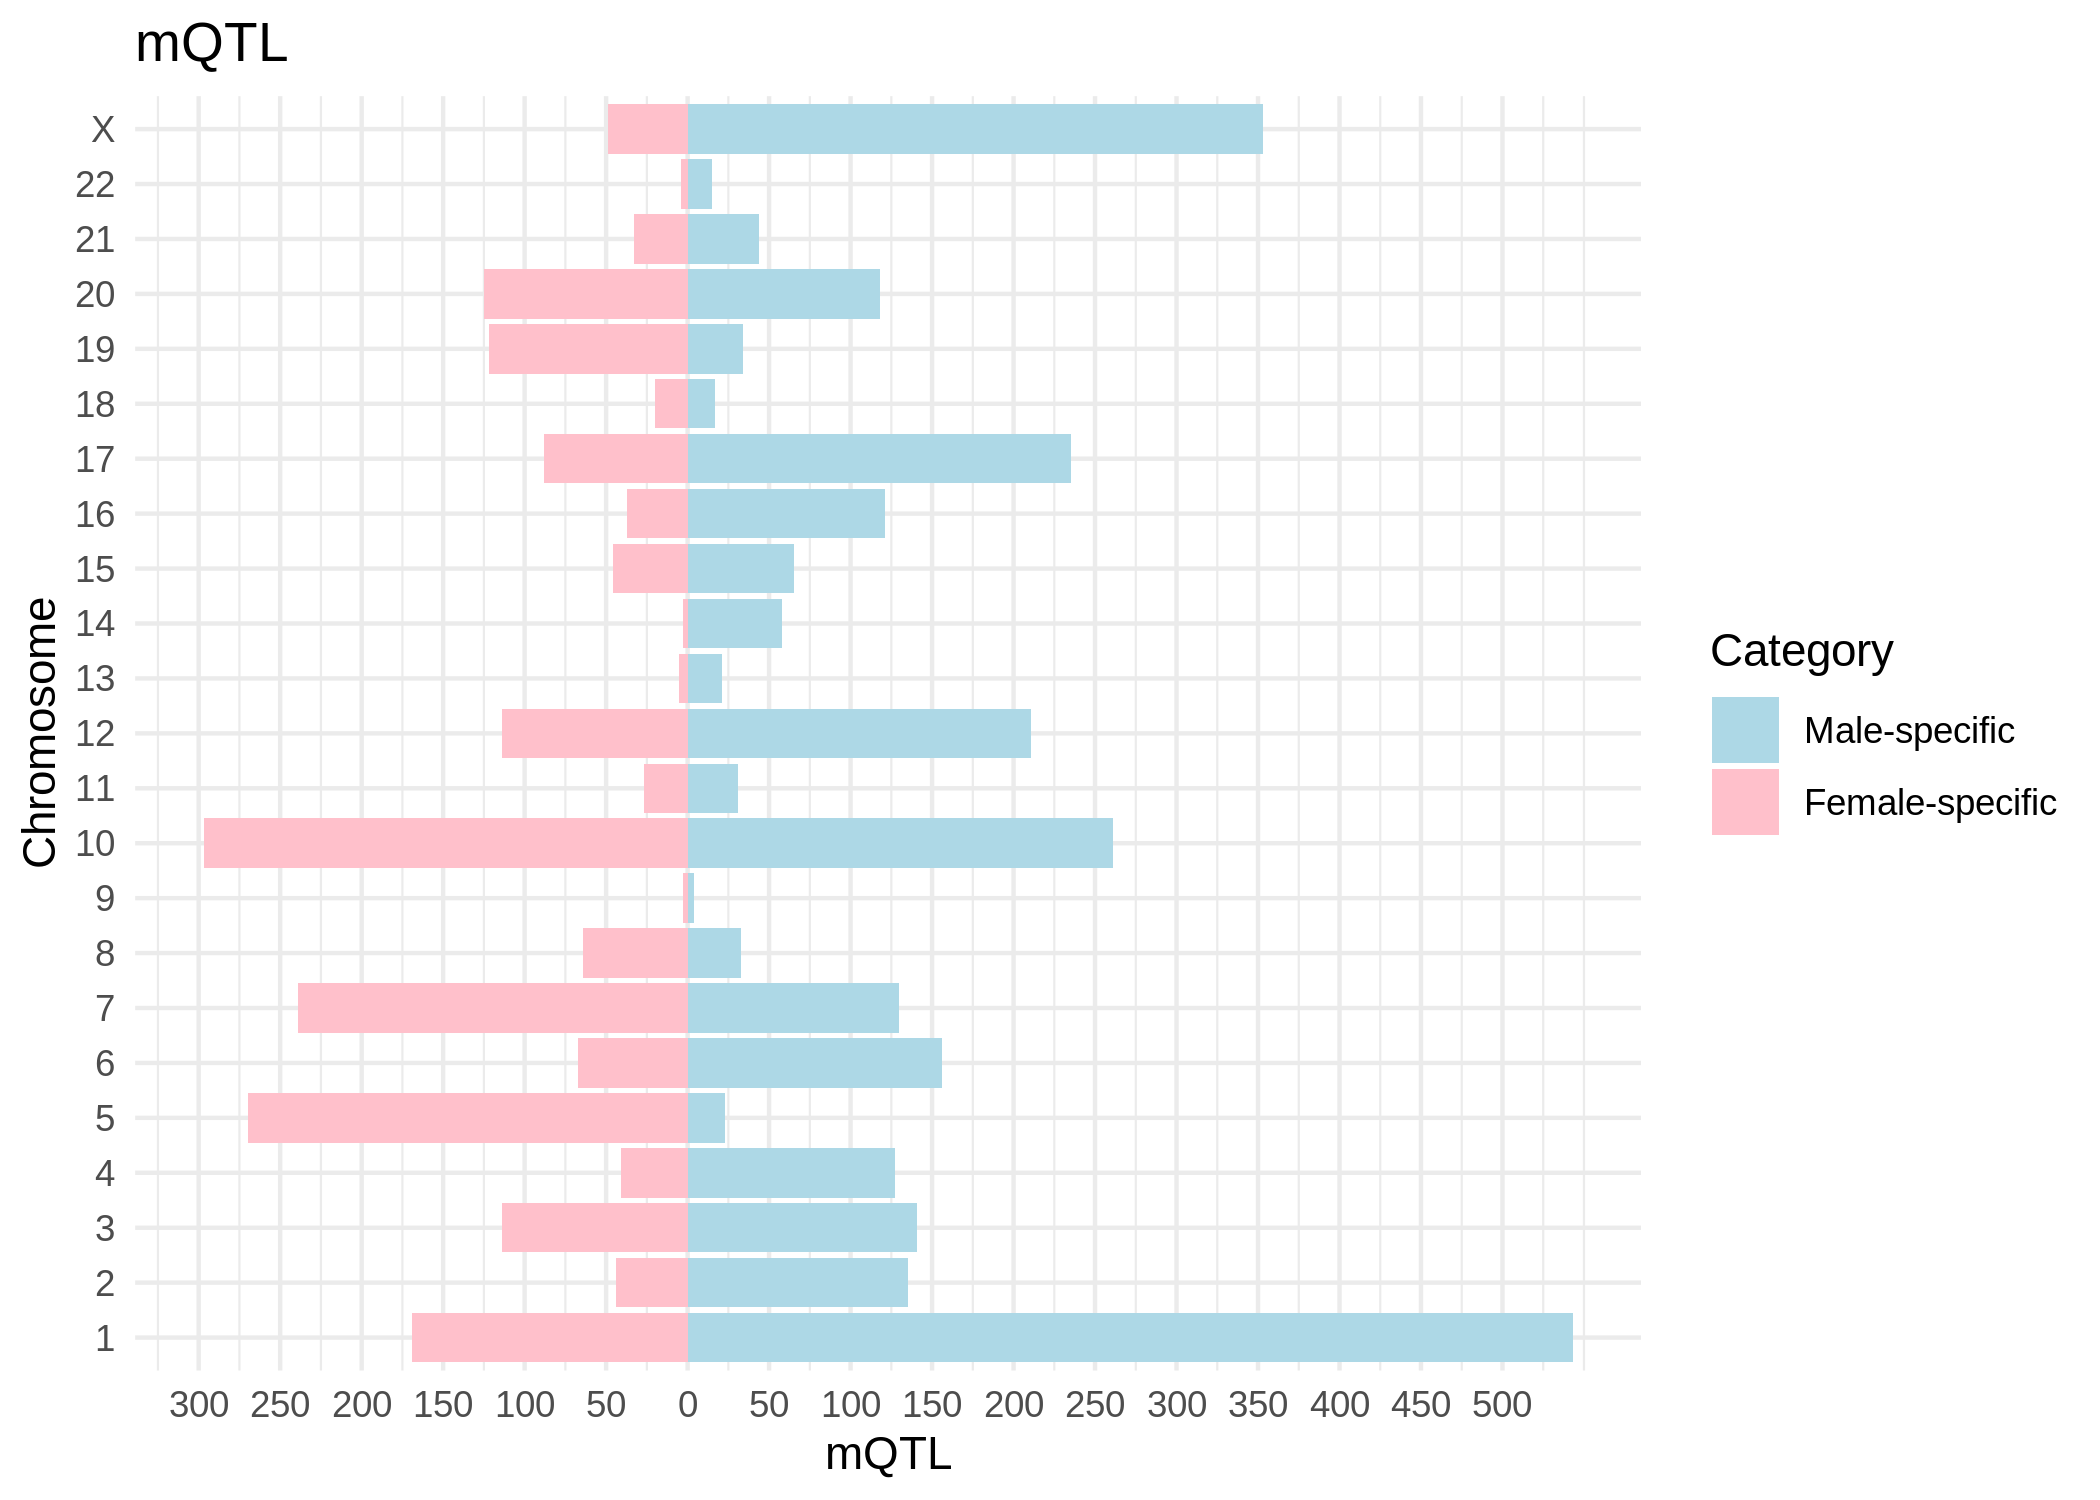

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
24 1  
25 2  
26 3  
27 4  
28 5  
29 6  
30 7  
31 8  
32 9  
33 10 
34 11 
35 12 
36 13 
37 14 
38 15 
39 16 
40 17 
41 18 
42 19 
43 20 
44 21 
45 22 
46 X  
   nprobe
1   54   
2   21   
3   16   
4   12   
5    9   
6   19   
7   19   
8    7   
9    2   
10  20   
11  11   
12  17   
13   2   
14  17   
15   8   
16  18   
17  24   
18   2   
19  14   
20  16   
21   9   
22   3   
23  31   
24 -31   
25 -11   
26 -20   
27 -10   
28 -17   
29  -9   
30 -22   
31 -11   
32  -3   
33 -11   
34 -19   
35 -11   
36  -2   
37  -3   
38  -8   
39 -10   
40 -16   
41  -4   
42 -12   
43 -10   
44  -5   
45  -2   
46  -8   
   mQTL
1   543
2   135
3   141
4   127
5    23
6   156
7   130
8    33
9     4
10  261
11   31
12  211
13   21
14   58
15   65
16  121
17  235
18   17
19   34
20  118
21   44
22   15
23  353
24 -169
25  -44
26 -114
27  -41
28 -270
29  -67
30 -239
31  -64
32   -3
33 -297
34  -27
35 -114
36   -5
37   -3
38  -46
39  -37
40  -88
41  -20
42 -122
43 -125
44  -33
45   -4
46  -49
   Category       
1  Male-specific  
2  Male-specific  
3  Male-specific  
4  Male-specific  
5  Male-specific  
6  Male-specific  
7  Male-specific  
8  Male-specific  
9  Male-specific  
10 Male-specific  
11 Male-specific  
12 Male-specific  
13 Male-specific  
14 Male-specific  
15 Male-specific  
16 Male-specific  
17 Male-specific  
18 Male-specific  
19 Male-specific  
20 Male-specific  
21 Male-specific  
22 Male-specific  
23 Male-specific  
24 Female-specific
25 Female-specific
26 Female-specific
27 Female-specific
28 Female-specific
29 Female-specific
30 Female-specific
31 Female-specific
32 Female-specific
33 Female-specific
34 Female-specific
35 Female-specific
36 Female-specific
37 Female-specific
38 Female-specific
39 Female-specific
40 Female-specific
41 Female-specific
42 Female-specific
43 Female-specific
44 Female-specific
45 Female-specific
46 Female-specific
   prop        
1   0.153846154
2   0.059829060
3   0.045584046
4   0.034188034
5   0.025641026
6   0.054131054
7   0.054131054
8   0.019943020
9   0.005698006
10  0.056980057
11  0.031339031
12  0.048433048
13  0.005698006
14  0.048433048
15  0.022792023
16  0.051282051
17  0.068376068
18  0.005698006
19  0.039886040
20  0.045584046
21  0.025641026
22  0.008547009
23  0.088319088
24 -0.121568627
25 -0.043137255
26 -0.078431373
27 -0.039215686
28 -0.066666667
29 -0.035294118
30 -0.086274510
31 -0.043137255
32 -0.011764706
33 -0.043137255
34 -0.074509804
35 -0.043137255
36 -0.007843137
37 -0.011764706
38 -0.031372549
39 -0.039215686
40 -0.062745098
41 -0.015686275
42 -0.047058824
43 -0.039215686
44 -0.019607843
45 -0.007843137
46 -0.031372549

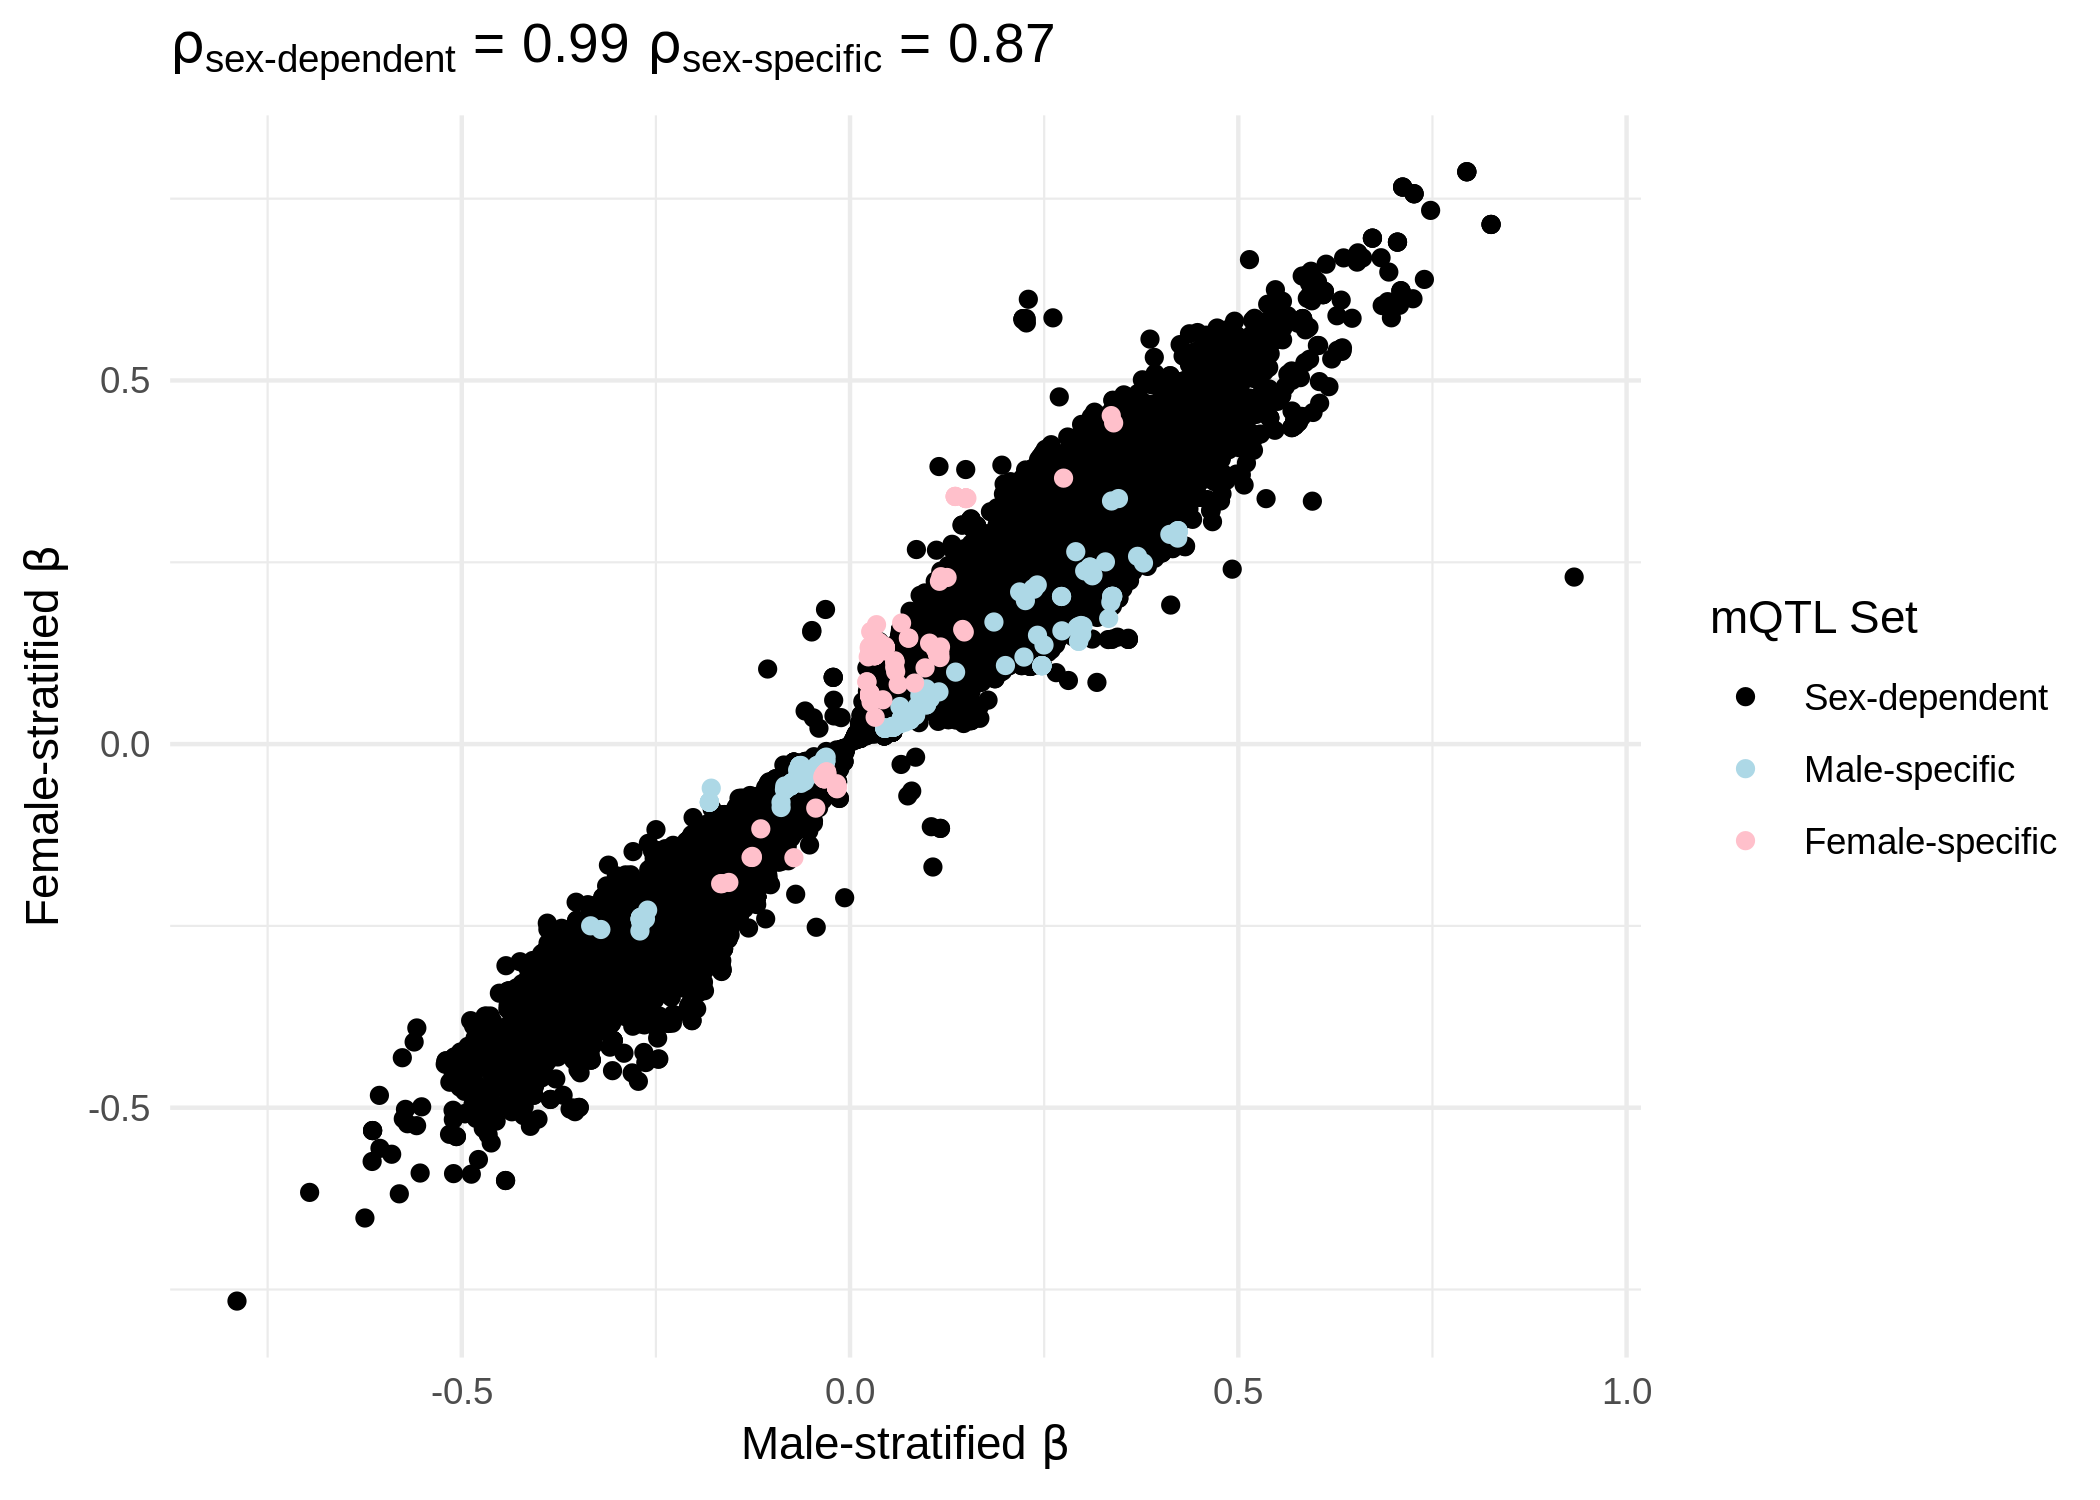

In [12]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
sex_int_count_dt <- sex_interaction[,.(nprobe=uniqueN(Probe),mQTL=.N),by="Chr"]
sex_int_count_dt$Chr <- factor(c(as.character(1:22),"X"),levels=c(as.character(1:22),"X"))
sex_int_count_dt$Category <- "Sex-dependent"
sex_int_count_dt[,`:=`(mQTL= -mQTL, nprobe= -nprobe,prop = -nprobe/sum(nprobe))]
marginal_count_dt <- marginal[,.(nprobe=uniqueN(Probe),mQTL=.N),by="Chr"]
marginal_count_dt[,`:=`(prop = nprobe/sum(nprobe))]

marginal_count_dt$Chr <- factor(c(as.character(1:22),"X"),levels=c(as.character(1:22),"X"))
marginal_count_dt$Category <- "Cross-sex"
marginal_int_dt <- rbind(marginal_count_dt,sex_int_count_dt)

prop_test_int <- marginal_int_dt[,.(
    p = prop.test(abs(nprobe),c(abs(sum(marginal_count_dt$nprobe)),abs(sum(sex_int_count_dt$nprobe))))$p.value,
    nprobe1=abs(nprobe[1]),
    nprobe2=abs(nprobe[2]),
    diff= abs(sum(prop))),
by="Chr"]
prop_test_int[,`:=`(
    q = p.adjust(p,method="BH"),
    sig = p.adjust(p,method="BH") < 0.05
)]
to_mark <- prop_test_int[sig == TRUE]$Chr
ggplot(marginal_int_dt,aes(Chr,nprobe,fill=Category))+
    geom_col() +
    labs(x="Chromosome",y="No. CpG sites", title = "Probes with at least one mQTL") +
    scale_fill_manual(values=c("Cross-sex"="dark red","Sex-dependent"="light green")) +
    scale_y_continuous(breaks=c(-500,-250,-100,1000 * 0:5),labels=c(500,250,100,1000*0:5)) +
    theme_minimal()
ggplot(marginal_int_dt,aes(Chr,prop,label=ifelse(Chr %in% to_mark & Category=="Cross-sex","*",""),fill=Category))+
    geom_col() +
    geom_text() +
    labs(x="Chromosome",y="Proportion of CpG sites", fill="mQTL Set") +
    scale_y_continuous(breaks = seq(-0.2,0.2,0.05),labels=c(seq(0.2,0,-0.05),seq(0.05,0.2,0.05)))+
    scale_fill_manual(values=c("Cross-sex"="dark red","Sex-dependent"="light green")) +
    theme_minimal() + 
    theme(legend.position="top")
# Same plot as dodged barplot
ggplot(marginal_int_dt %>% mutate(prop=ifelse(Category == "Sex-dependent",-prop,prop)),aes(Chr,prop,label=ifelse(Chr %in% to_mark & Category=="Cross-sex","*",""),fill=Category))+
    geom_col(position="dodge",width=0.7) +
    geom_text(y=0,color="red",vjust=1) +
    labs(x="Chromosome",y="Proportion of CpG sites",fill="mQTL Set") +
    scale_fill_manual(values=c("Cross-sex"="dark red","Sex-dependent"="light green")) +
    theme_minimal() + 
    theme(legend.position="top")
male_count <- male_int[,.(nprobe=uniqueN(Probe),mQTL = .N,Category = "Male-specific"),by="Chr"]
male_count[,`:=`(prop = nprobe/sum(nprobe))]
female_count <- female_int[,.(nprobe=-uniqueN(Probe),mQTL = -.N,Category="Female-specific"),by="Chr"]
female_count[,`:=`(prop = -nprobe/sum(nprobe))]
sex_count_dt <- rbindlist(
    list(male_count,female_count)
)
sex_effect_dt <- rbindlist(list(male_int[,`:=`(Category="Male-specific")],female_int[,`:=`(Category="Female-specific")]))
sex_effect_dt$Chr <- as.character(sex_effect_dt$Chr)
sex_effect_dt$Chr <- factor(ifelse(sex_effect_dt$Chr == "23","X",sex_effect_dt$Chr),levels =c(as.character(1:22),"X"))
sex_effect_dt$Category <- factor(sex_effect_dt$Category,levels=c("Male-specific","Female-specific"))
sex_count_dt$Chr <- factor(rep(c(as.character(1:22),"X"),2),levels=c(as.character(1:22),"X"))
sex_count_dt$Category <- factor(sex_count_dt$Category,levels=c("Male-specific","Female-specific"))

ggplot(sex_count_dt,aes(Chr,nprobe,fill=Category)) + 
    geom_col() +
    labs(x="Chromosome",y="No. CpG sites", title = "Probes with at least one mQTL") +
    scale_y_continuous(breaks = seq(-50,50,10),labels=c(seq(50,0,-10),seq(10,50,10)))+
    #coord_flip() + 
    scale_fill_manual(values=c("light blue", "pink"))+
    theme_minimal()

ggplot(sex_count_dt,aes(Chr,prop,fill=Category)) + 
    geom_col() +
    labs(x="Chromosome",y="Proportion of CpG sites", title = "Probes with at least one mQTL") +
    scale_y_continuous(breaks = seq(-0.2,0.2,0.05),labels=c(seq(0.2,0,-0.05),seq(0.05,0.2,0.05)))+
    #coord_flip() + 
    scale_fill_manual(values=c("light blue", "pink"))+
    theme_minimal()
ggplot(sex_count_dt %>% mutate(prop=ifelse(Category == "Female-specific",-prop,prop)),aes(Chr,prop,fill=Category))+
    geom_col(position="dodge",width=0.7) +
    labs(x="Chromosome",y="Proportion of CpG sites", fill="mQTL Set") +
    scale_fill_manual(values=c("light blue", "pink"))+
    theme_minimal() + 
    theme(legend.position="top")
ggplot(sex_count_dt,aes(Chr,mQTL,fill=Category)) + 
    geom_col() +
    labs(x="Chromosome",y="mQTL", title = "mQTL") +
    scale_y_continuous(breaks = seq(-500,500,50),labels=c(seq(500,0,-50),seq(50,500,50)))+
    coord_flip() + 
    scale_fill_manual(values=c("light blue", "pink"))+
    theme_minimal()
merged_int <- merge(male_int,female_int, by = c("SNP","Probe"))
merged_sex <- merge(male,female, by = c("SNP","Probe"))
rho_interaction <- cor.test(merged_int$b.x,merged_int$b.y,method="spearman")$estimate
rho_sex <- cor.test(merged_sex$b.x,merged_sex$b.y,method="spearman")$estimate
nrow(merged_int[sign(b.x) != sign(b.y)]) / nrow(merged_int)
nrow(merged_sex[sign(b.x) != sign(b.y)]) / nrow(merged_sex)


ggplot(merged_sex %>%
        mutate(sex_biased = paste0(SNP,Probe) %in% paste0(sex_interaction$SNP,sex_interaction$Probe)) %>%
        mutate(sex_biased = factor(ifelse(sex_biased,ifelse(abs(b.x) > abs(b.y),"Male-specific","Female-specific"),"Sex-dependent"), levels = c("Sex-dependent","Male-specific","Female-specific"))) %>%arrange(sex_biased),
    aes(b.x,b.y,color=sex_biased) ) + 
    geom_point() +
    labs(
        x=bquote("Male-stratified"~beta),
        y=bquote("Female-stratified"~beta),color = "mQTL Set",
        title = bquote(rho["sex-dependent"]~"="~.(round(rho_sex,2))~rho["sex-specific"]~"="~.(round(rho_interaction,2))))+
    scale_color_manual(values=c("black","light blue", "pink"))+
    theme_minimal()
sex_count_dt

In [13]:
merged_sex[,.(any(sign(b.x) != sign(b.y))),by="Probe"][,.(.N,sum(V1))]
length(unique(merged_sex$Probe))

N    
1 18372
  V2
1 12

[1] 18372

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  7  
7  9  
8  10 
9  13 
10 14 
11 15 
12 16 
13 22 
14 6  
15 8  
16 11 
17 12 
18 17 
19 18 
20 19 
21 20 
22 21 
23 X  
   p           
1  4.076275e-01
2  3.844179e-01
3  1.443304e-01
4  6.542912e-01
5  5.455816e-01
6  9.898707e-01
7  7.434047e-02
8  6.660803e-02
9  1.885426e-01
10 7.239067e-01
11 3.171125e-01
12 9.013372e-01
13 7.014249e-02
14 1.578063e-19
15 1.873581e-04
16 6.346649e-03
17 1.104928e-02
18 9.754558e-03
19 8.680361e-04
20 2.033702e-48
21 6.314595e-04
22 3.177674e-16
23 1.553192e-08
   nprobe1
1  4671   
2  3542   
3  2364   
4  2060   
5  2333   
6  3239   
7   995   
8  2622   
9  1226   
10 1355   
11 1385   
12 2412   
13  237   
14 4942   
15 2259   
16 2934   
17 2312   
18 3020   
19  483   
20  982   
21 1032   
22 2265   
23  582   
   nprobe2
1  249    
2  167    
3  136    
4   99    
5  125    
6  163    
7   37    
8  111    
9   51    
10  65    
11  79    
12 120    
13  19    
14 112    
15  74    
16 182    
17 145    
18 185    
19  42    
20 160    
21  78    
22  28    
23  62    
   diff        
1  0.0052013885
2  0.0048206423
3  0.0066423670
4  0.0020507026
5  0.0028523375
6  0.0002756790
7  0.0053368175
8  0.0086401934
9  0.0044022335
10 0.0013966675
11 0.0036189690
12 0.0007604972
13 0.0028216005
14 0.0553431117
15 0.0161353421
16 0.0135505507
17 0.0113140717
18 0.0130097321
19 0.0070675383
20 0.0443445679
21 0.0103844229
22 0.0347384824
23 0.0130928232
   q           
1  5.208574e-01
2  5.200948e-01
3  2.371142e-01
4  7.524349e-01
5  6.604409e-01
6  9.898707e-01
7  1.315254e-01
8  1.315254e-01
9  2.890986e-01
10 7.928502e-01
11 4.558493e-01
12 9.423070e-01
13 1.315254e-01
14 1.814773e-18
15 8.618475e-04
16 1.824662e-02
17 2.541334e-02
18 2.492832e-02
19 2.852119e-03
20 4.677515e-47
21 2.420595e-03
22 2.436217e-15
23 8.930856e-08
   sig  
1  FALSE
2  FALSE
3  FALSE
4  FALSE
5  FALSE
6  FALSE
7  FALSE
8  FALSE
9  FALSE
10 FALSE
11 FALSE
12 FALSE
13 FALSE
14  TRUE
15  TRUE
16  TRUE
17  TRUE
18  TRUE
19  TRUE
20  TRUE
21  TRUE
22  TRUE
23  TRUE

Warning message in prop.test(abs(nprobe), c(abs(sum(male_count$nprobe)), abs(sum(female_count$nprobe)))):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(abs(nprobe), c(abs(sum(male_count$nprobe)), abs(sum(female_count$nprobe)))):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(abs(nprobe), c(abs(sum(male_count$nprobe)), abs(sum(female_count$nprobe)))):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(abs(nprobe), c(abs(sum(male_count$nprobe)), abs(sum(female_count$nprobe)))):
“Chi-squared approximation may be incorrect”


Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
   p          
1  0.311947680
2  0.469623432
3  0.129841776
4  0.915017662
5  0.023981637
6  0.371041692
7  0.164052652
8  0.156171459
9  0.718661627
10 0.564031057
11 0.025812983
12 0.911931384
13 1.000000000
14 0.023560350
15 0.693726088
16 0.615271356
17 0.912474067
18 0.417657288
19 0.820307533
20 0.858012046
21 0.830384684
22 1.000000000
23 0.007985265
   nprobe1
1  54     
2  21     
3  16     
4  12     
5   9     
6  19     
7  19     
8   7     
9   2     
10 20     
11 11     
12 17     
13  2     
14 17     
15  8     
16 18     
17 24     
18  2     
19 14     
20 16     
21  9     
22  3     
23 31     
   nprobe2
1  31     
2  11     
3  20     
4  10     
5  17     
6   9     
7  22     
8  11     
9   3     
10 11     
11 19     
12 11     
13  2     
14  3     
15  8     
16 10     
17 16     
18  4     
19 12     
20 10     
21  5     
22  2     
23  8     
   diff        
1  0.0322775264
2  0.0166918049
3  0.0328473270
4  0.0050276521
5  0.0410256410
6  0.0188369365
7  0.0321434557
8  0.0231942350
9  0.0060667002
10 0.0138428021
11 0.0431707726
12 0.0052957935
13 0.0021451316
14 0.0366683426
15 0.0085805262
16 0.0120663650
17 0.0056309703
18 0.0099882688
19 0.0071727836
20 0.0063683593
21 0.0060331825
22 0.0007038713
23 0.0569465393
   q        
1  0.8968496
2  0.9819399
3  0.5390301
4  1.0000000
5  0.1484247
6  0.9482177
7  0.5390301
8  0.5390301
9  1.0000000
10 1.0000000
11 0.1484247
12 1.0000000
13 1.0000000
14 0.1484247
15 1.0000000
16 1.0000000
17 1.0000000
18 0.9606118
19 1.0000000
20 1.0000000
21 1.0000000
22 1.0000000
23 0.1484247

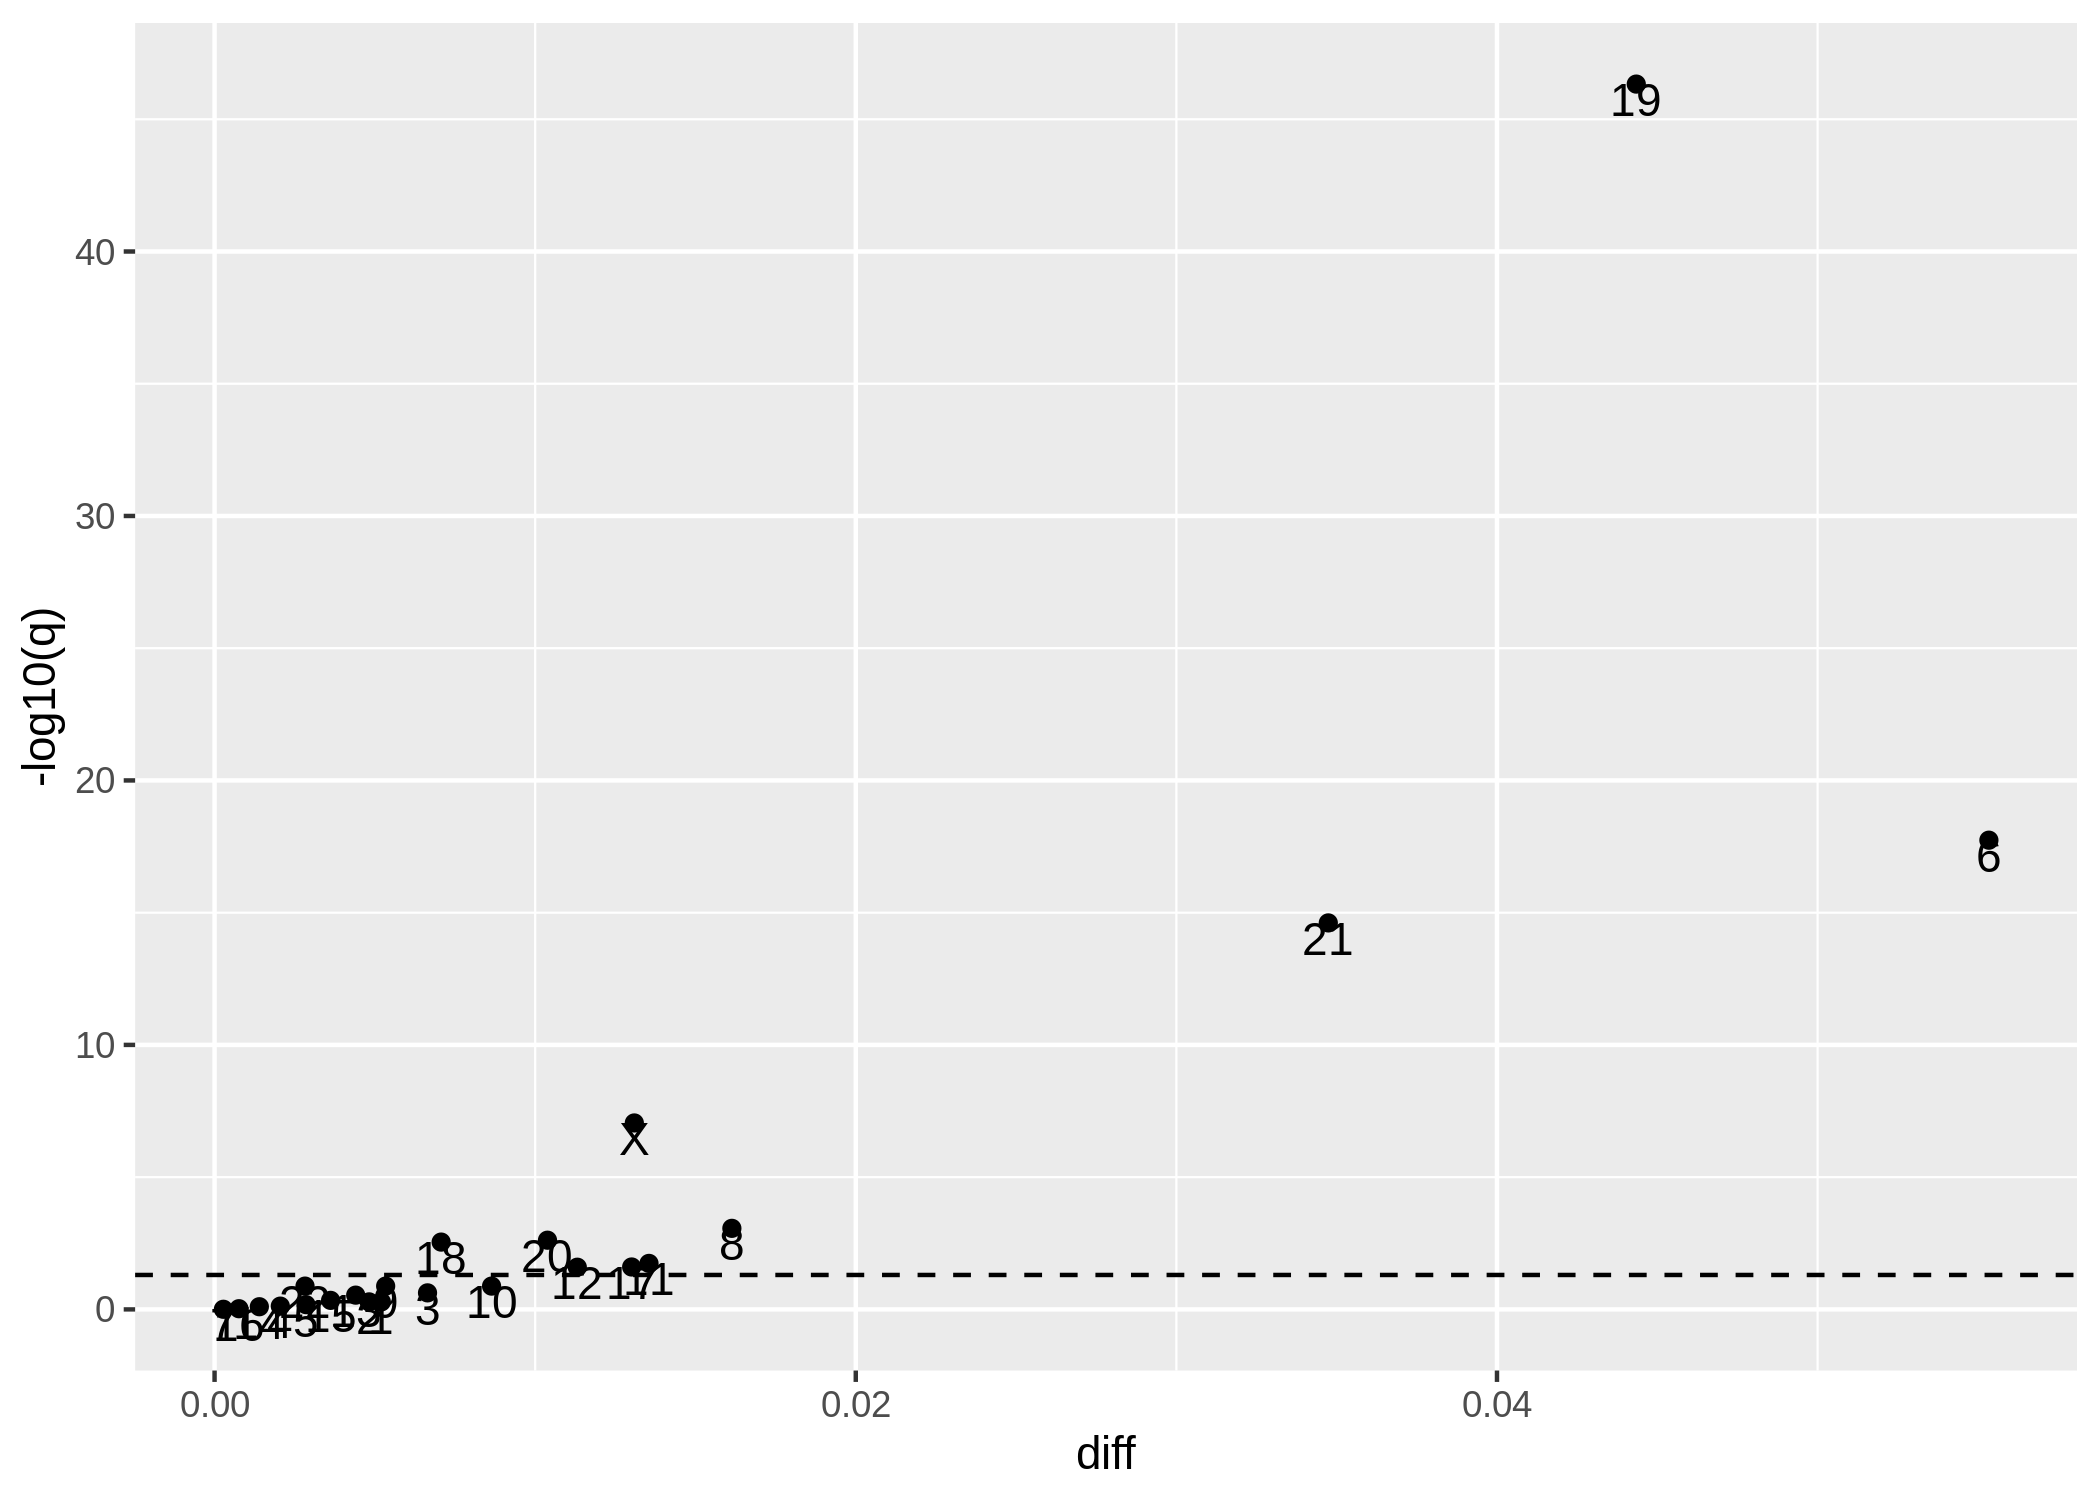

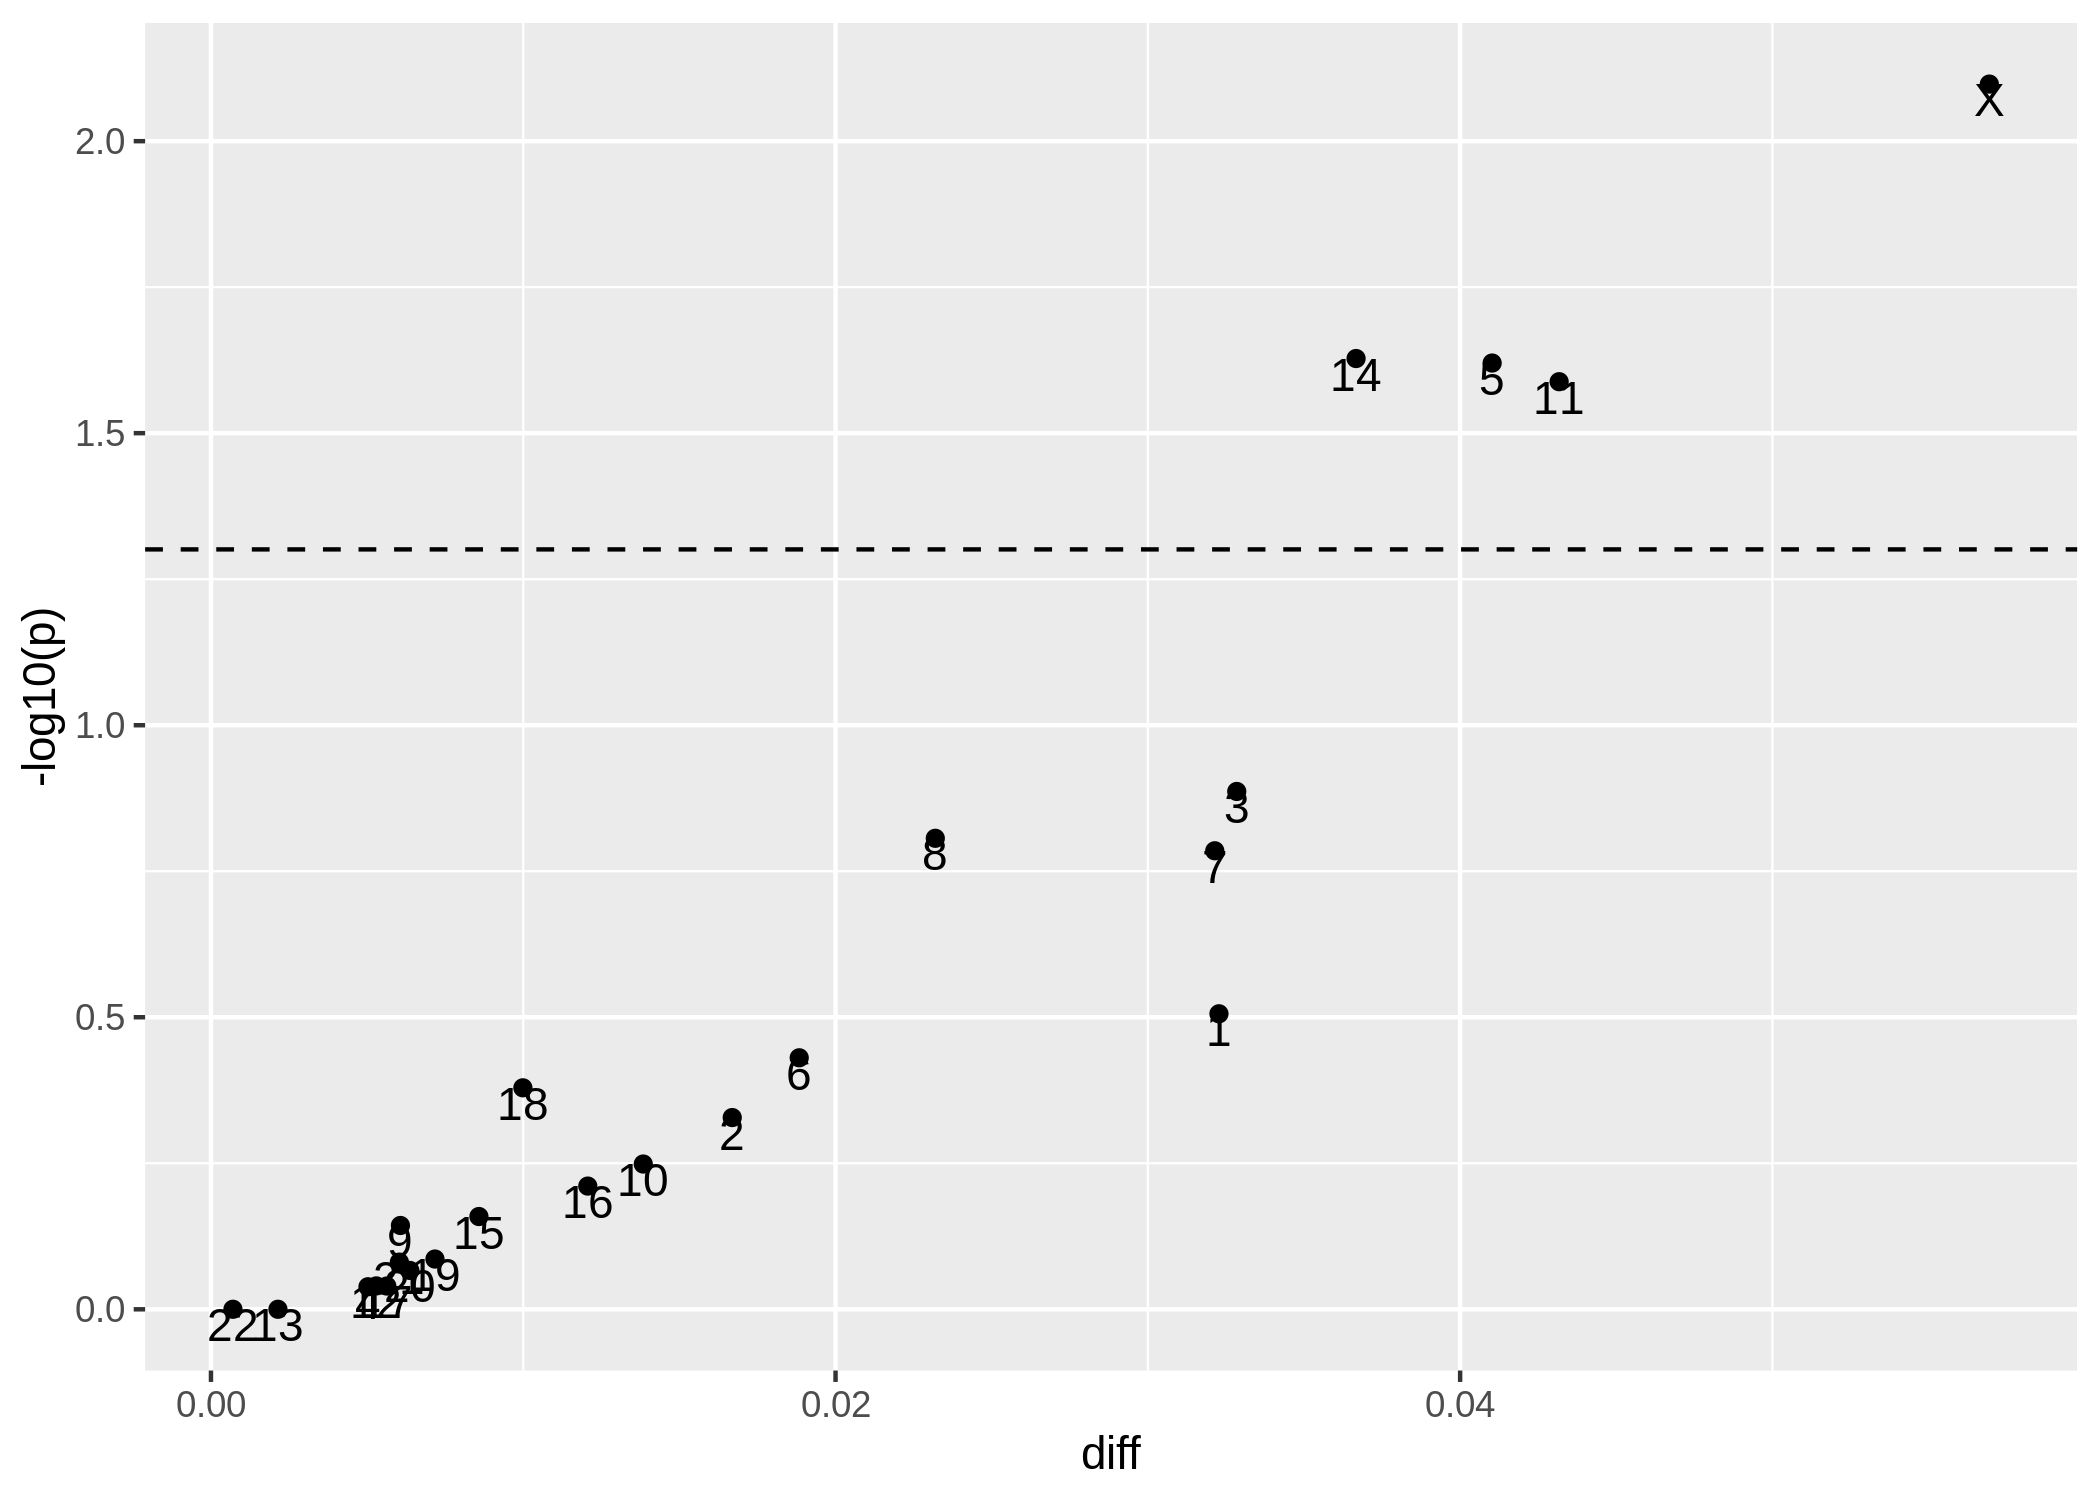

In [14]:
prop_test_int[order(sig)]
ggplot(prop_test_int,aes(diff,-log10(q),label=Chr)) +
    geom_hline(yintercept = -log10(0.05),linetype="dashed") +
    geom_point() +
    geom_text(vjust=1)


res <- sex_count_dt[,.(
    p = prop.test(abs(nprobe),c(abs(sum(male_count$nprobe)),abs(sum(female_count$nprobe))))$p.value,
    nprobe1=abs(nprobe[1]),
    nprobe2=abs(nprobe[2]),
    diff= abs(sum(prop))),
by="Chr"]
res[,`:=`(
    q = p.adjust(p,method="BH")
)]
res
ggplot(res,aes(diff,-log10(p),label=Chr)) + geom_hline(yintercept = -log10(0.05),linetype="dashed") + geom_point() + geom_text(vjust=1)

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
   p           
1  6.688439e-01
2  4.400704e-01
3  9.297581e-01
4  1.000000e+00
5  8.510120e-01
6  8.989088e-01
7  6.564290e-01
8  4.512691e-01
9  4.427578e-01
10 9.234589e-01
11 1.478451e-03
12 2.414147e-01
13 9.954418e-01
14 8.749506e-01
15 9.367904e-02
16 4.055021e-01
17 3.743704e-01
18 7.221671e-01
19 7.506558e-01
20 2.612964e-01
21 8.482657e-01
22 1.315087e-01
23 4.343615e-34
   nprobe1
1  2957   
2  2265   
3  1523   
4  1339   
5  1474   
6  3252   
7  2087   
8  1408   
9   634   
10 1733   
11 1852   
12 1401   
13  739   
14  903   
15  892   
16 1524   
17 1884   
18  288   
19 1349   
20  615   
21  363   
22  632   
23  270   
   nprobe2
1  2345   
2  1774   
3  1217   
4  1075   
5  1192   
6  2600   
7  1650   
8  1164   
9   485   
10 1396   
11 1650   
12 1177   
13  594   
14  718   
15  777   
16 1184   
17 1466   
18  223   
19 1097   
20  528   
21  286   
22  554   
23   28   
   diff        
1  1.090517e-03
2  1.717792e-03
3  1.959028e-04
4  2.756093e-05
5  3.725509e-04
6  3.631260e-04
7  9.706559e-04
8  1.363540e-03
9  9.400580e-04
10 2.216061e-04
11 6.517236e-03
12 2.102866e-03
13 4.312058e-05
14 2.579288e-04
15 2.435698e-03
16 1.538330e-03
17 1.809779e-03
18 3.204154e-04
19 5.826365e-04
20 1.373051e-03
21 2.081825e-04
22 1.863939e-03
23 7.491116e-03
   q           
1  1.000000e+00
2  9.435627e-01
3  1.000000e+00
4  1.000000e+00
5  1.000000e+00
6  1.000000e+00
7  1.000000e+00
8  9.435627e-01
9  9.435627e-01
10 1.000000e+00
11 1.700219e-02
12 9.435627e-01
13 1.000000e+00
14 1.000000e+00
15 7.182060e-01
16 9.435627e-01
17 9.435627e-01
18 1.000000e+00
19 1.000000e+00
20 9.435627e-01
21 1.000000e+00
22 7.561749e-01
23 9.990315e-33

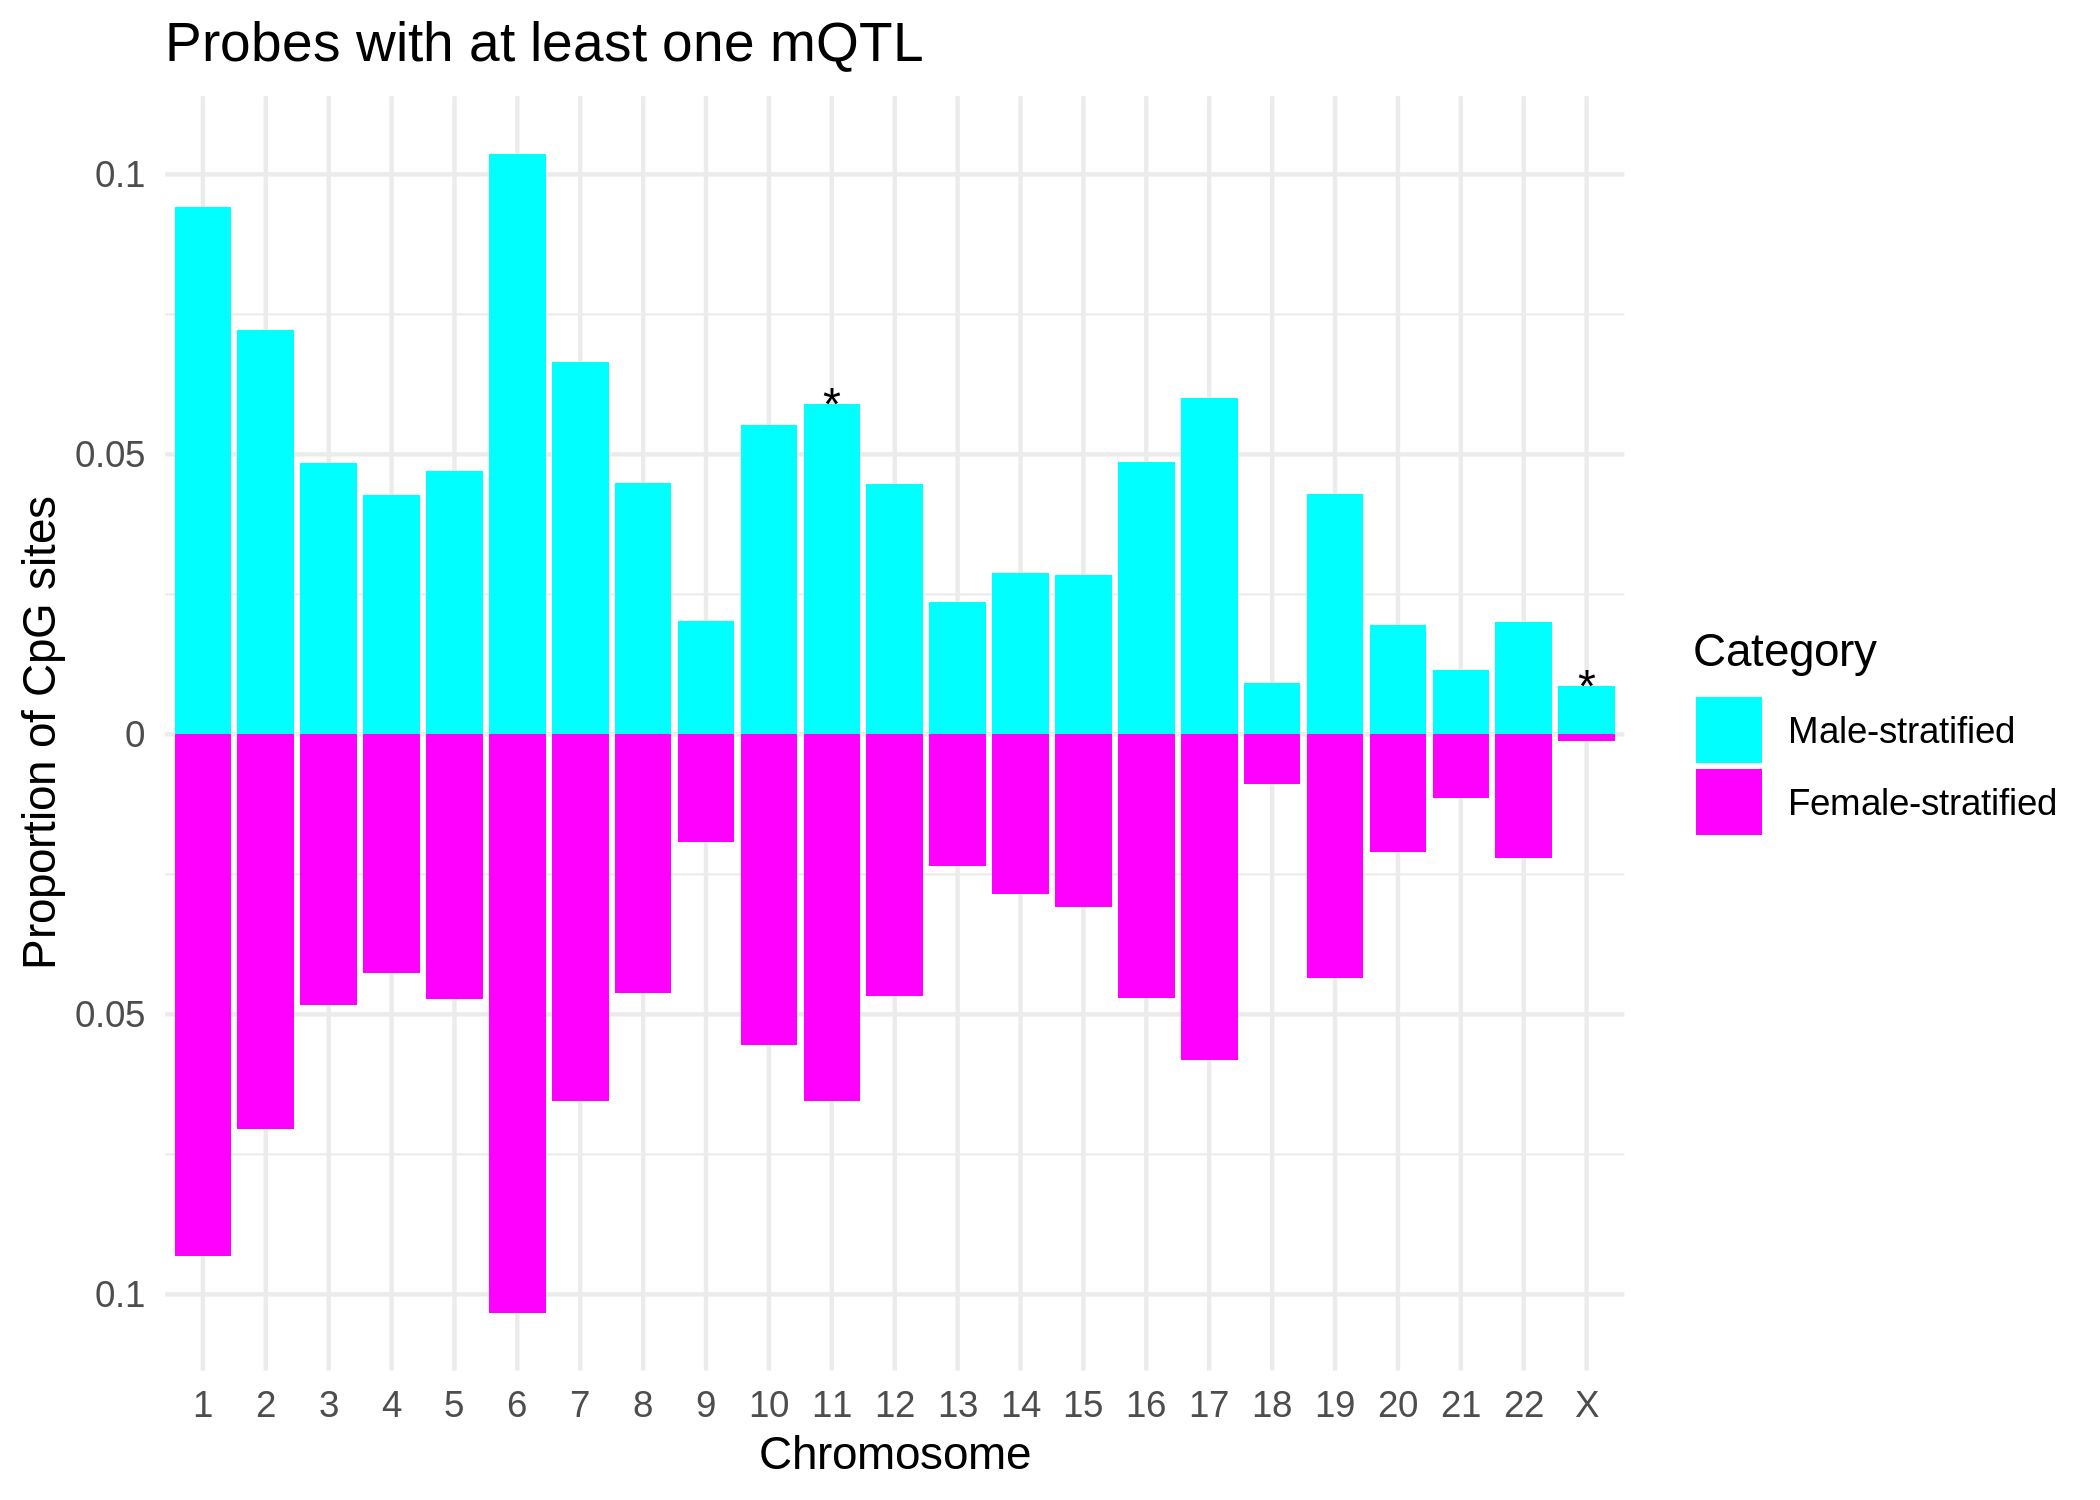

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
24 1  
25 2  
26 3  
27 4  
28 5  
29 6  
30 7  
31 8  
32 9  
33 10 
34 11 
35 12 
36 13 
37 14 
38 15 
39 16 
40 17 
41 18 
42 19 
43 20 
44 21 
45 22 
46 X  
   nprobe
1   2957 
2   2265 
3   1523 
4   1339 
5   1474 
6   3252 
7   2087 
8   1408 
9    634 
10  1733 
11  1852 
12  1401 
13   739 
14   903 
15   892 
16  1524 
17  1884 
18   288 
19  1349 
20   615 
21   363 
22   632 
23   270 
24 -2345 
25 -1774 
26 -1217 
27 -1075 
28 -1192 
29 -2600 
30 -1650 
31 -1164 
32  -485 
33 -1396 
34 -1650 
35 -1177 
36  -594 
37  -718 
38  -777 
39 -1184 
40 -1466 
41  -223 
42 -1097 
43  -528 
44  -286 
45  -554 
46   -28 
   mQTL   
1    73000
2    58634
3    36036
4    36082
5    37196
6   190055
7    58337
8    32003
9    11692
10   44049
11   46621
12   29897
13   17583
14   20955
15   20351
16   35806
17   41717
18    6108
19   26148
20   12912
21    8480
22   17745
23    4579
24  -48129
25  -38486
26  -24940
27  -24010
28  -25278
29 -123806
30  -38342
31  -20317
32   -8055
33  -29785
34  -34244
35  -20656
36  -11545
37  -13690
38  -14822
39  -21419
40  -28096
41   -3736
42  -23088
43   -8925
44   -4931
45  -11690
46    -491
   Category         
1  Male-stratified  
2  Male-stratified  
3  Male-stratified  
4  Male-stratified  
5  Male-stratified  
6  Male-stratified  
7  Male-stratified  
8  Male-stratified  
9  Male-stratified  
10 Male-stratified  
11 Male-stratified  
12 Male-stratified  
13 Male-stratified  
14 Male-stratified  
15 Male-stratified  
16 Male-stratified  
17 Male-stratified  
18 Male-stratified  
19 Male-stratified  
20 Male-stratified  
21 Male-stratified  
22 Male-stratified  
23 Male-stratified  
24 Female-stratified
25 Female-stratified
26 Female-stratified
27 Female-stratified
28 Female-stratified
29 Female-stratified
30 Female-stratified
31 Female-stratified
32 Female-stratified
33 Female-stratified
34 Female-stratified
35 Female-stratified
36 Female-stratified
37 Female-stratified
38 Female-stratified
39 Female-stratified
40 Female-stratified
41 Female-stratified
42 Female-stratified
43 Female-stratified
44 Female-stratified
45 Female-stratified
46 Female-stratified
   prop        
1   0.094219985
2   0.072170533
3   0.048527912
4   0.042665052
5   0.046966607
6   0.103619679
7   0.066498853
8   0.044863625
9   0.020201376
10  0.055219220
11  0.059010961
12  0.044640581
13  0.023547030
14  0.028772623
15  0.028422126
16  0.048559776
17  0.060030589
18  0.009176651
19  0.042983686
20  0.019595972
21  0.011566403
22  0.020137650
23  0.008603110
24 -0.093129468
25 -0.070452740
26 -0.048332010
27 -0.042692613
28 -0.047339158
29 -0.103256553
30 -0.065528197
31 -0.046227164
32 -0.019261319
33 -0.055440826
34 -0.065528197
35 -0.046743447
36 -0.023590151
37 -0.028514694
38 -0.030857824
39 -0.047021446
40 -0.058220810
41 -0.008856235
42 -0.043566322
43 -0.020969023
44 -0.011358221
45 -0.022001589
46 -0.001111994

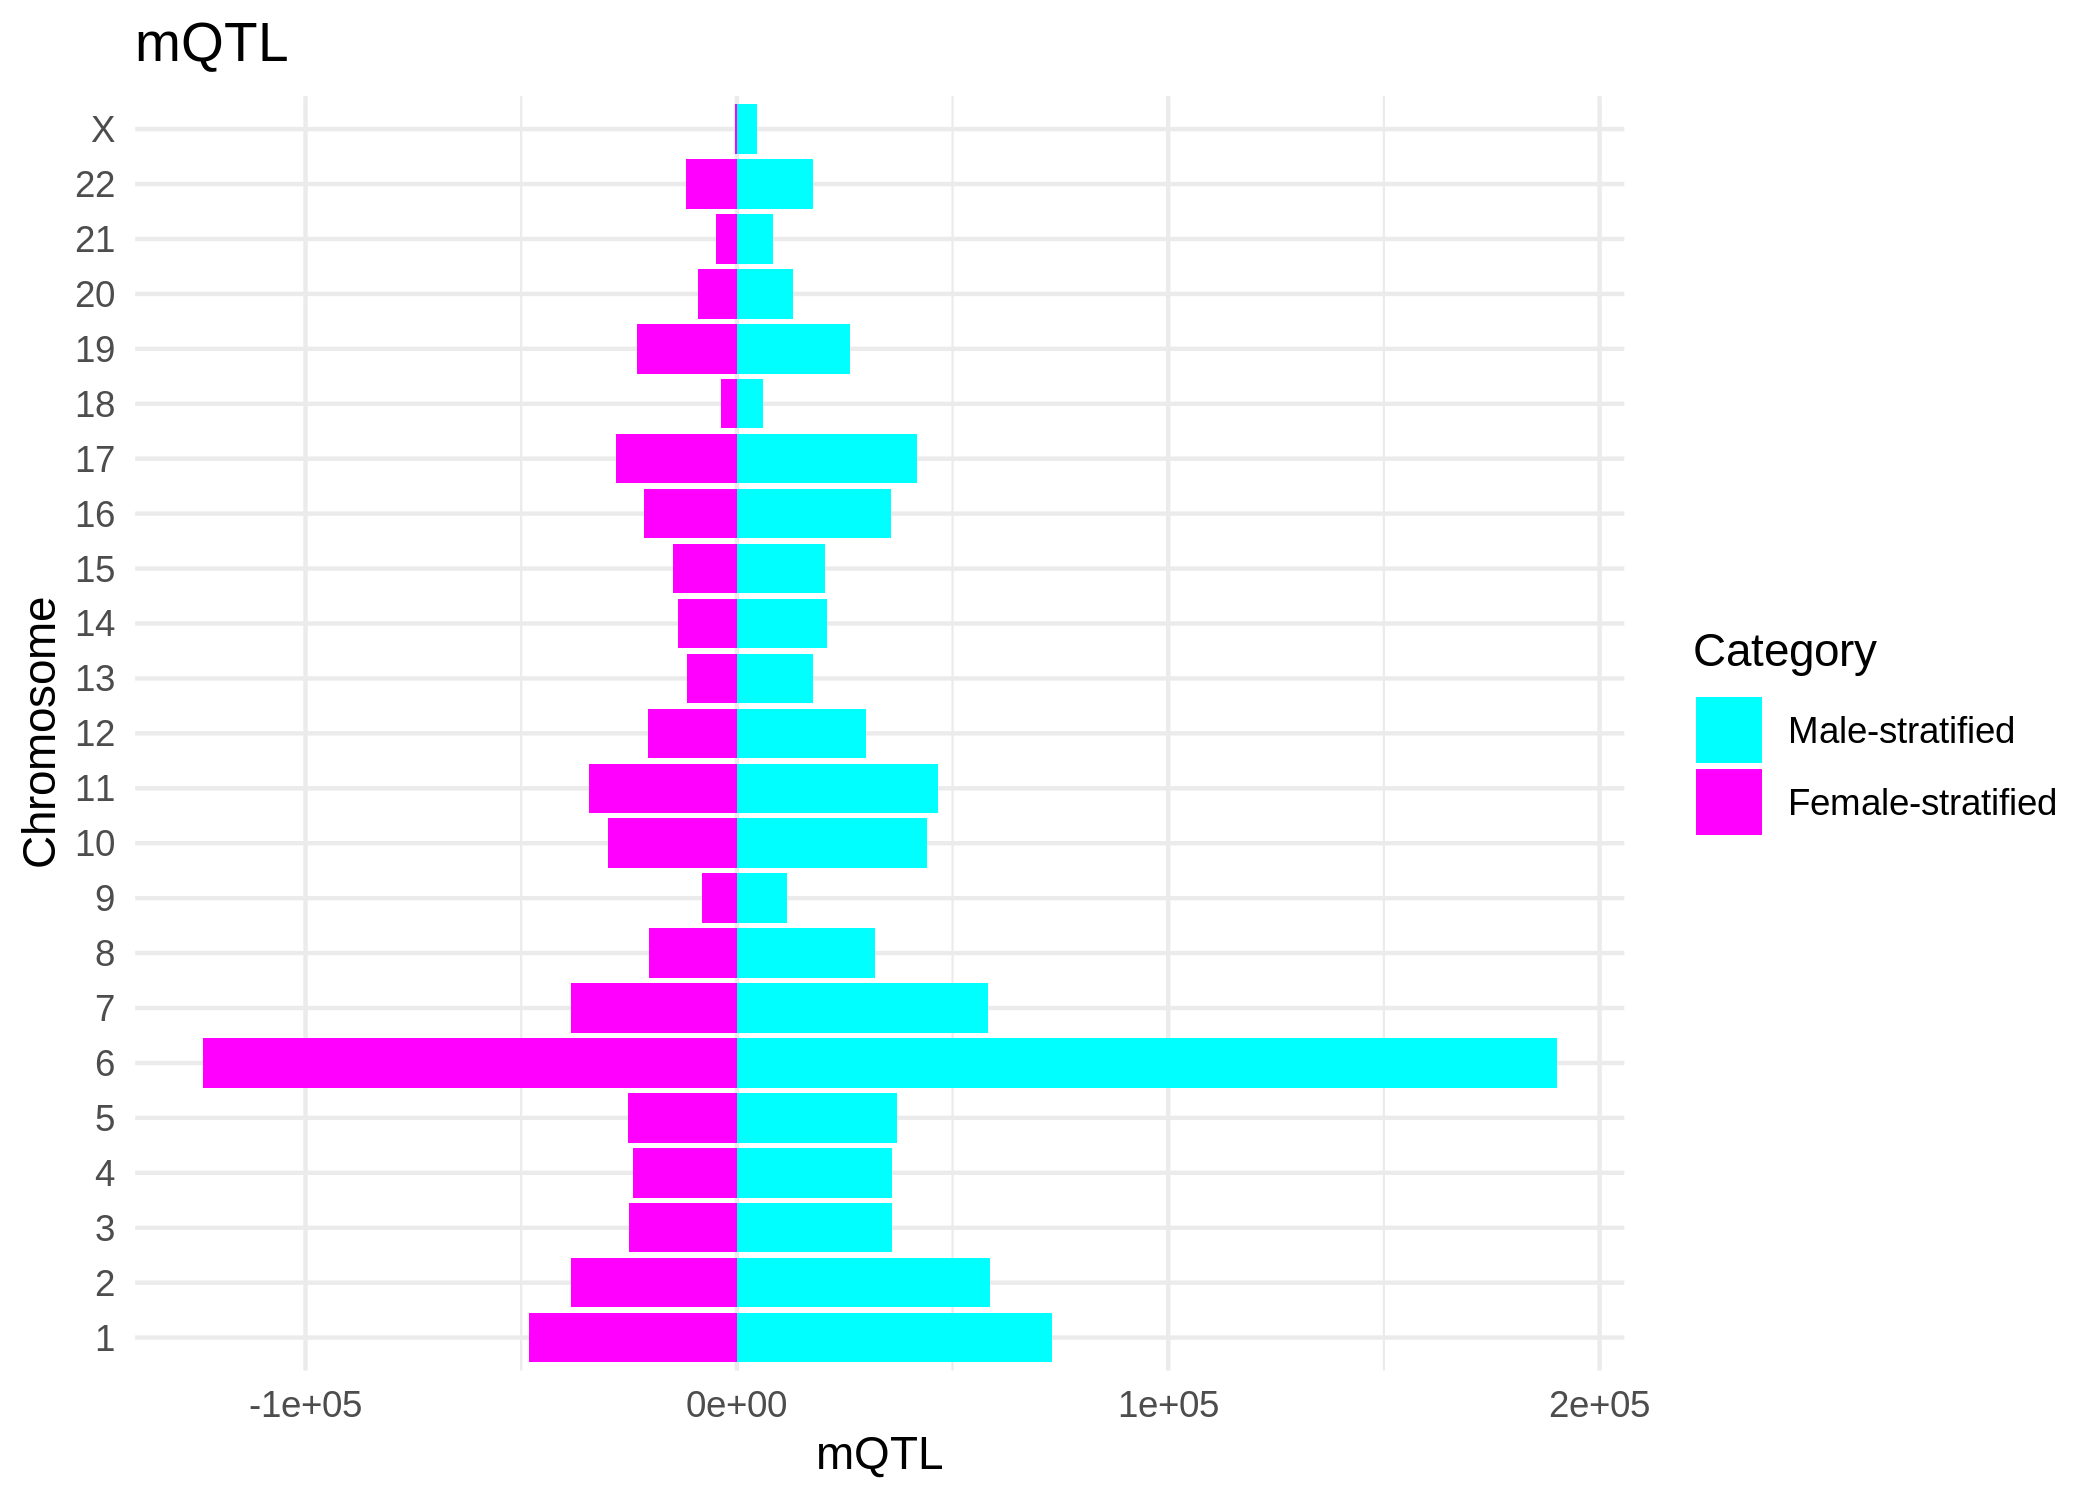

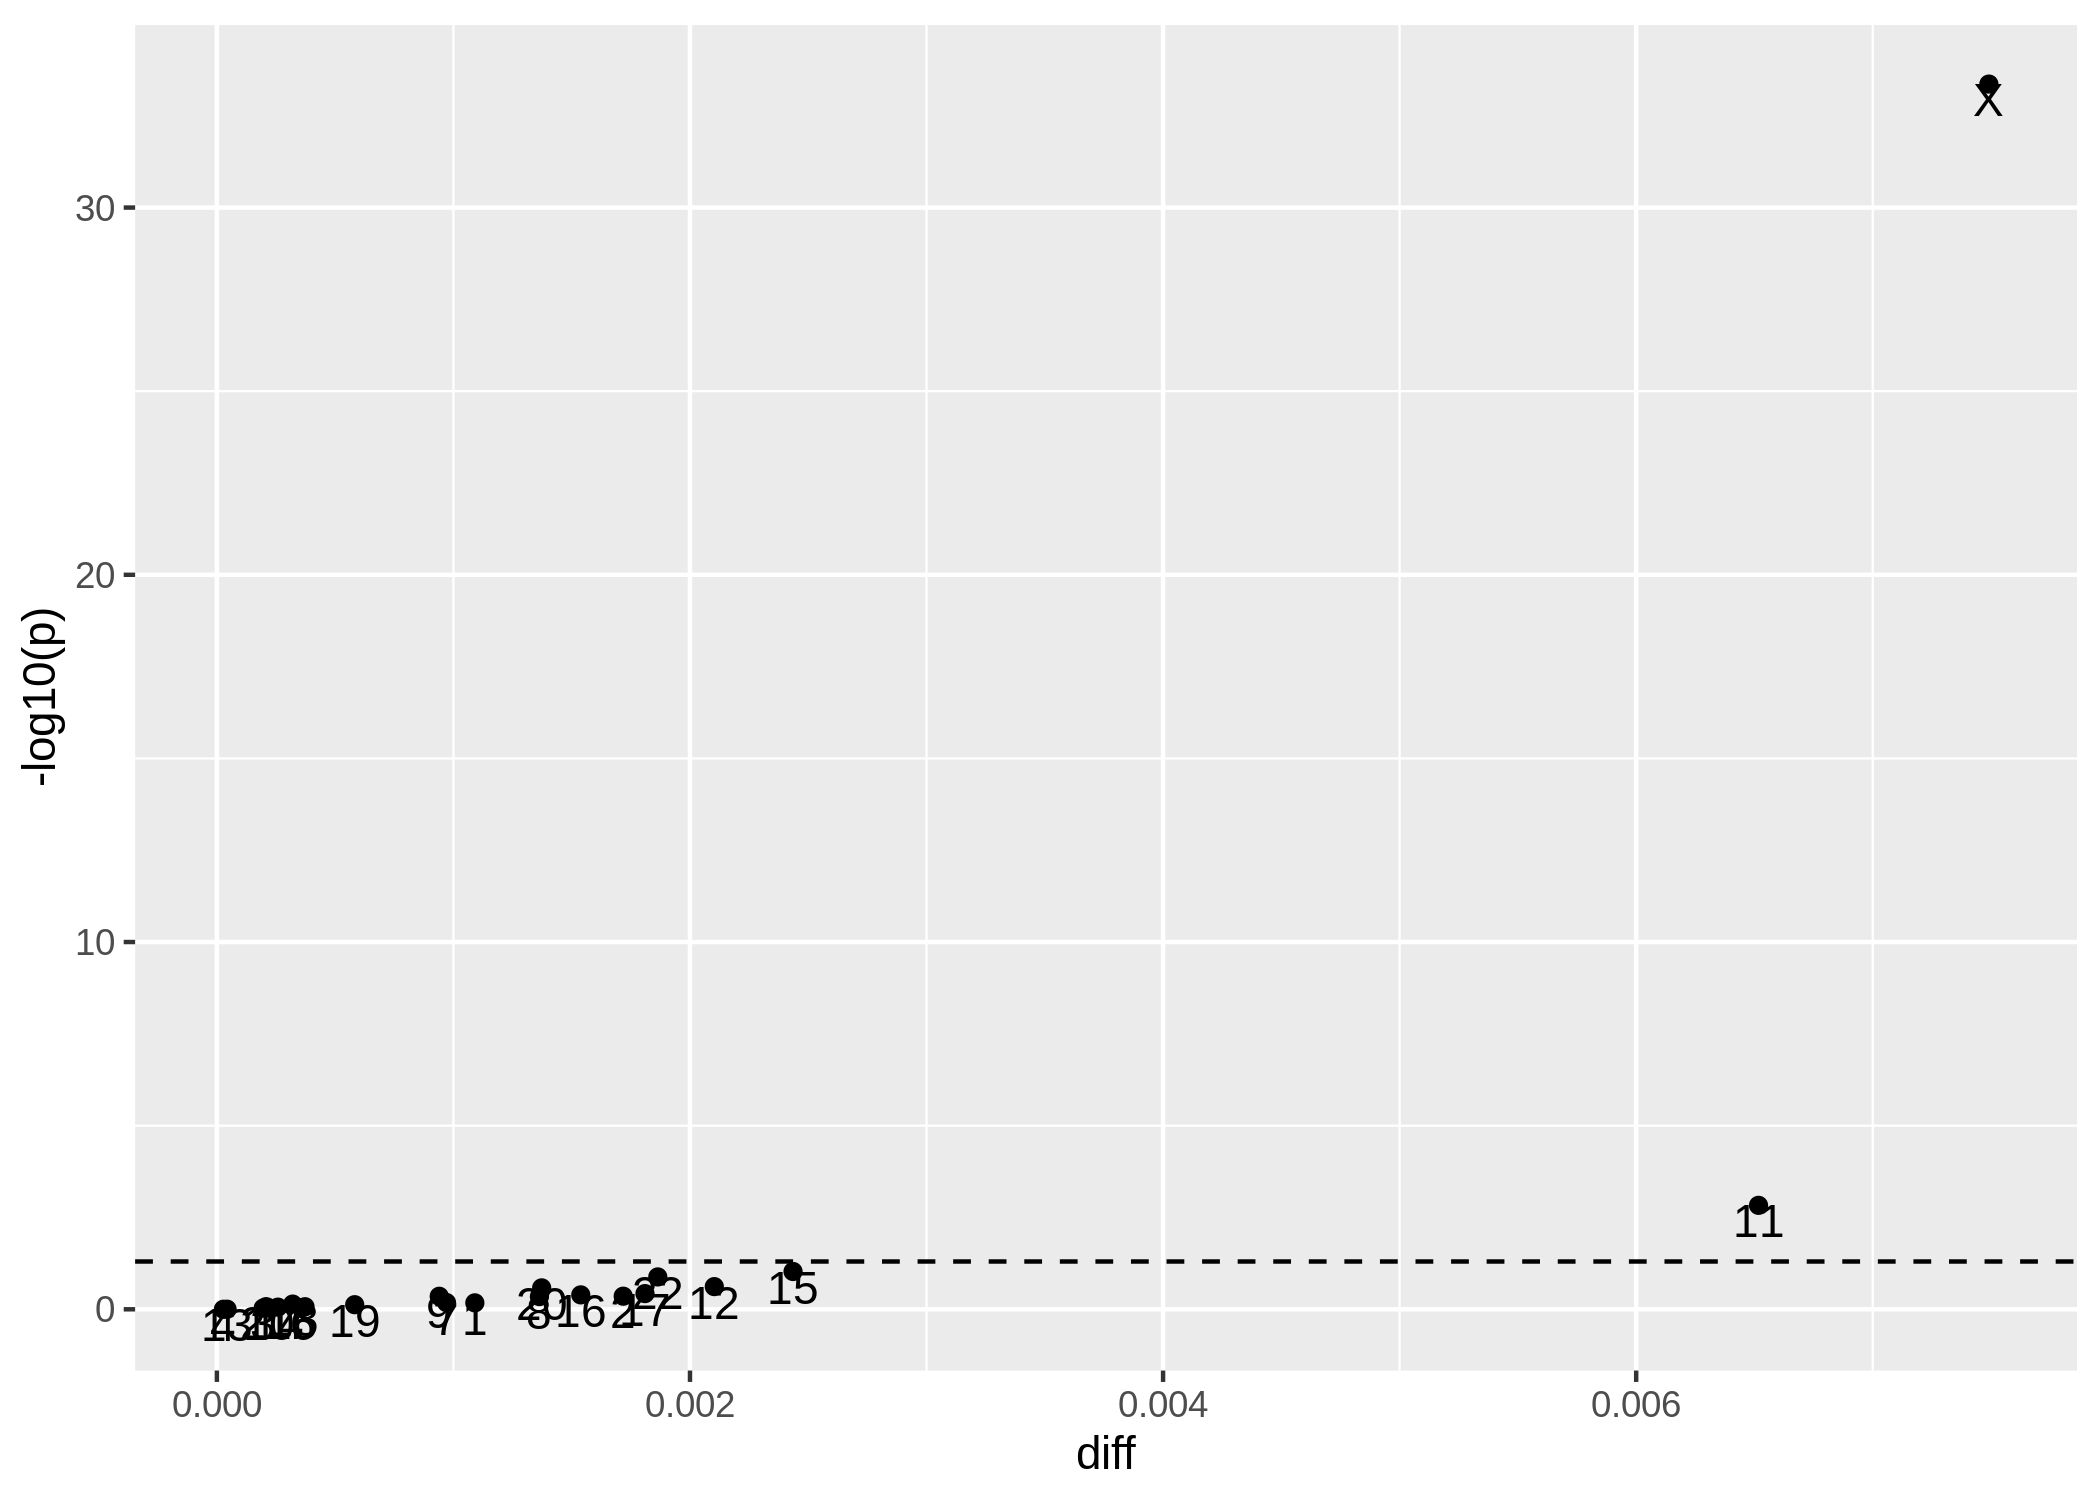

In [16]:
male_strat_count <- male[,.(nprobe=uniqueN(Probe),mQTL = .N,Category = "Male-stratified"),by="Chr"]
male_strat_count[,`:=`(prop=nprobe / sum(nprobe))]
female_strat_count <- female[,.(nprobe=-uniqueN(Probe),mQTL = -.N,Category="Female-stratified"),by="Chr"]
female_strat_count[,`:=`(prop=-nprobe / sum(nprobe))]
sex_strat_count_dt <- rbindlist(
    list(male_strat_count,female_strat_count)
)
sex_strat_effect_dt <- rbindlist(list(male[,`:=`(Category="Male-stratified")],female[,`:=`(Category="Female-stratified")]))
sex_strat_effect_dt$Chr <- as.character(sex_strat_effect_dt$Chr)
sex_strat_effect_dt$Chr <- factor(ifelse(sex_strat_effect_dt$Chr == "23","X",sex_strat_effect_dt$Chr),levels =c(as.character(1:22),"X"))
sex_strat_effect_dt$Category <- factor(sex_strat_effect_dt$Category,levels=c("Male-stratified","Female-stratified"))
sex_strat_count_dt$Chr <- factor(rep(c(as.character(1:22),"X"),2),levels=c(as.character(1:22),"X"))
sex_strat_count_dt$Category <- factor(sex_strat_count_dt$Category,levels=c("Male-stratified","Female-stratified"))
res <- sex_strat_count_dt[,.(
    p = prop.test(abs(nprobe),c(abs(sum(male_strat_count$nprobe)),abs(sum(female_strat_count$nprobe))))$p.value,
    nprobe1=abs(nprobe[1]),
    nprobe2=abs(nprobe[2]),
    diff= abs(sum(prop))),
by="Chr"]
res[,`:=`(
    q = p.adjust(p,method="BH")
)]
res
to_mark <- res[q < 0.05]$Chr
ggplot(sex_strat_count_dt,aes(Chr,prop,label = ifelse(Category == "Male-stratified" & Chr %in% to_mark,"*",""),fill=Category)) + 
    geom_col() +
    geom_text()+
    labs(x="Chromosome",y="Proportion of CpG sites", title = "Probes with at least one mQTL") +
    scale_fill_manual(values=c("cyan", "magenta"))+
    scale_y_continuous(breaks=seq(-0.1,0.1,0.05),labels=abs(seq(-0.1,0.1,0.05)))+
    theme_minimal()
ggplot(sex_strat_count_dt,aes(Chr,mQTL,fill=Category)) + 
    geom_col() +
    labs(x="Chromosome",y="mQTL", title = "mQTL") +
    coord_flip() + 
    scale_fill_manual(values=c("cyan", "magenta"))+
    theme_minimal()
sex_strat_count_dt
ggplot(res,aes(diff,-log10(p),label=Chr)) + geom_hline(yintercept = -log10(0.05),linetype="dashed") + geom_point() + geom_text(vjust=1)

Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.

Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.



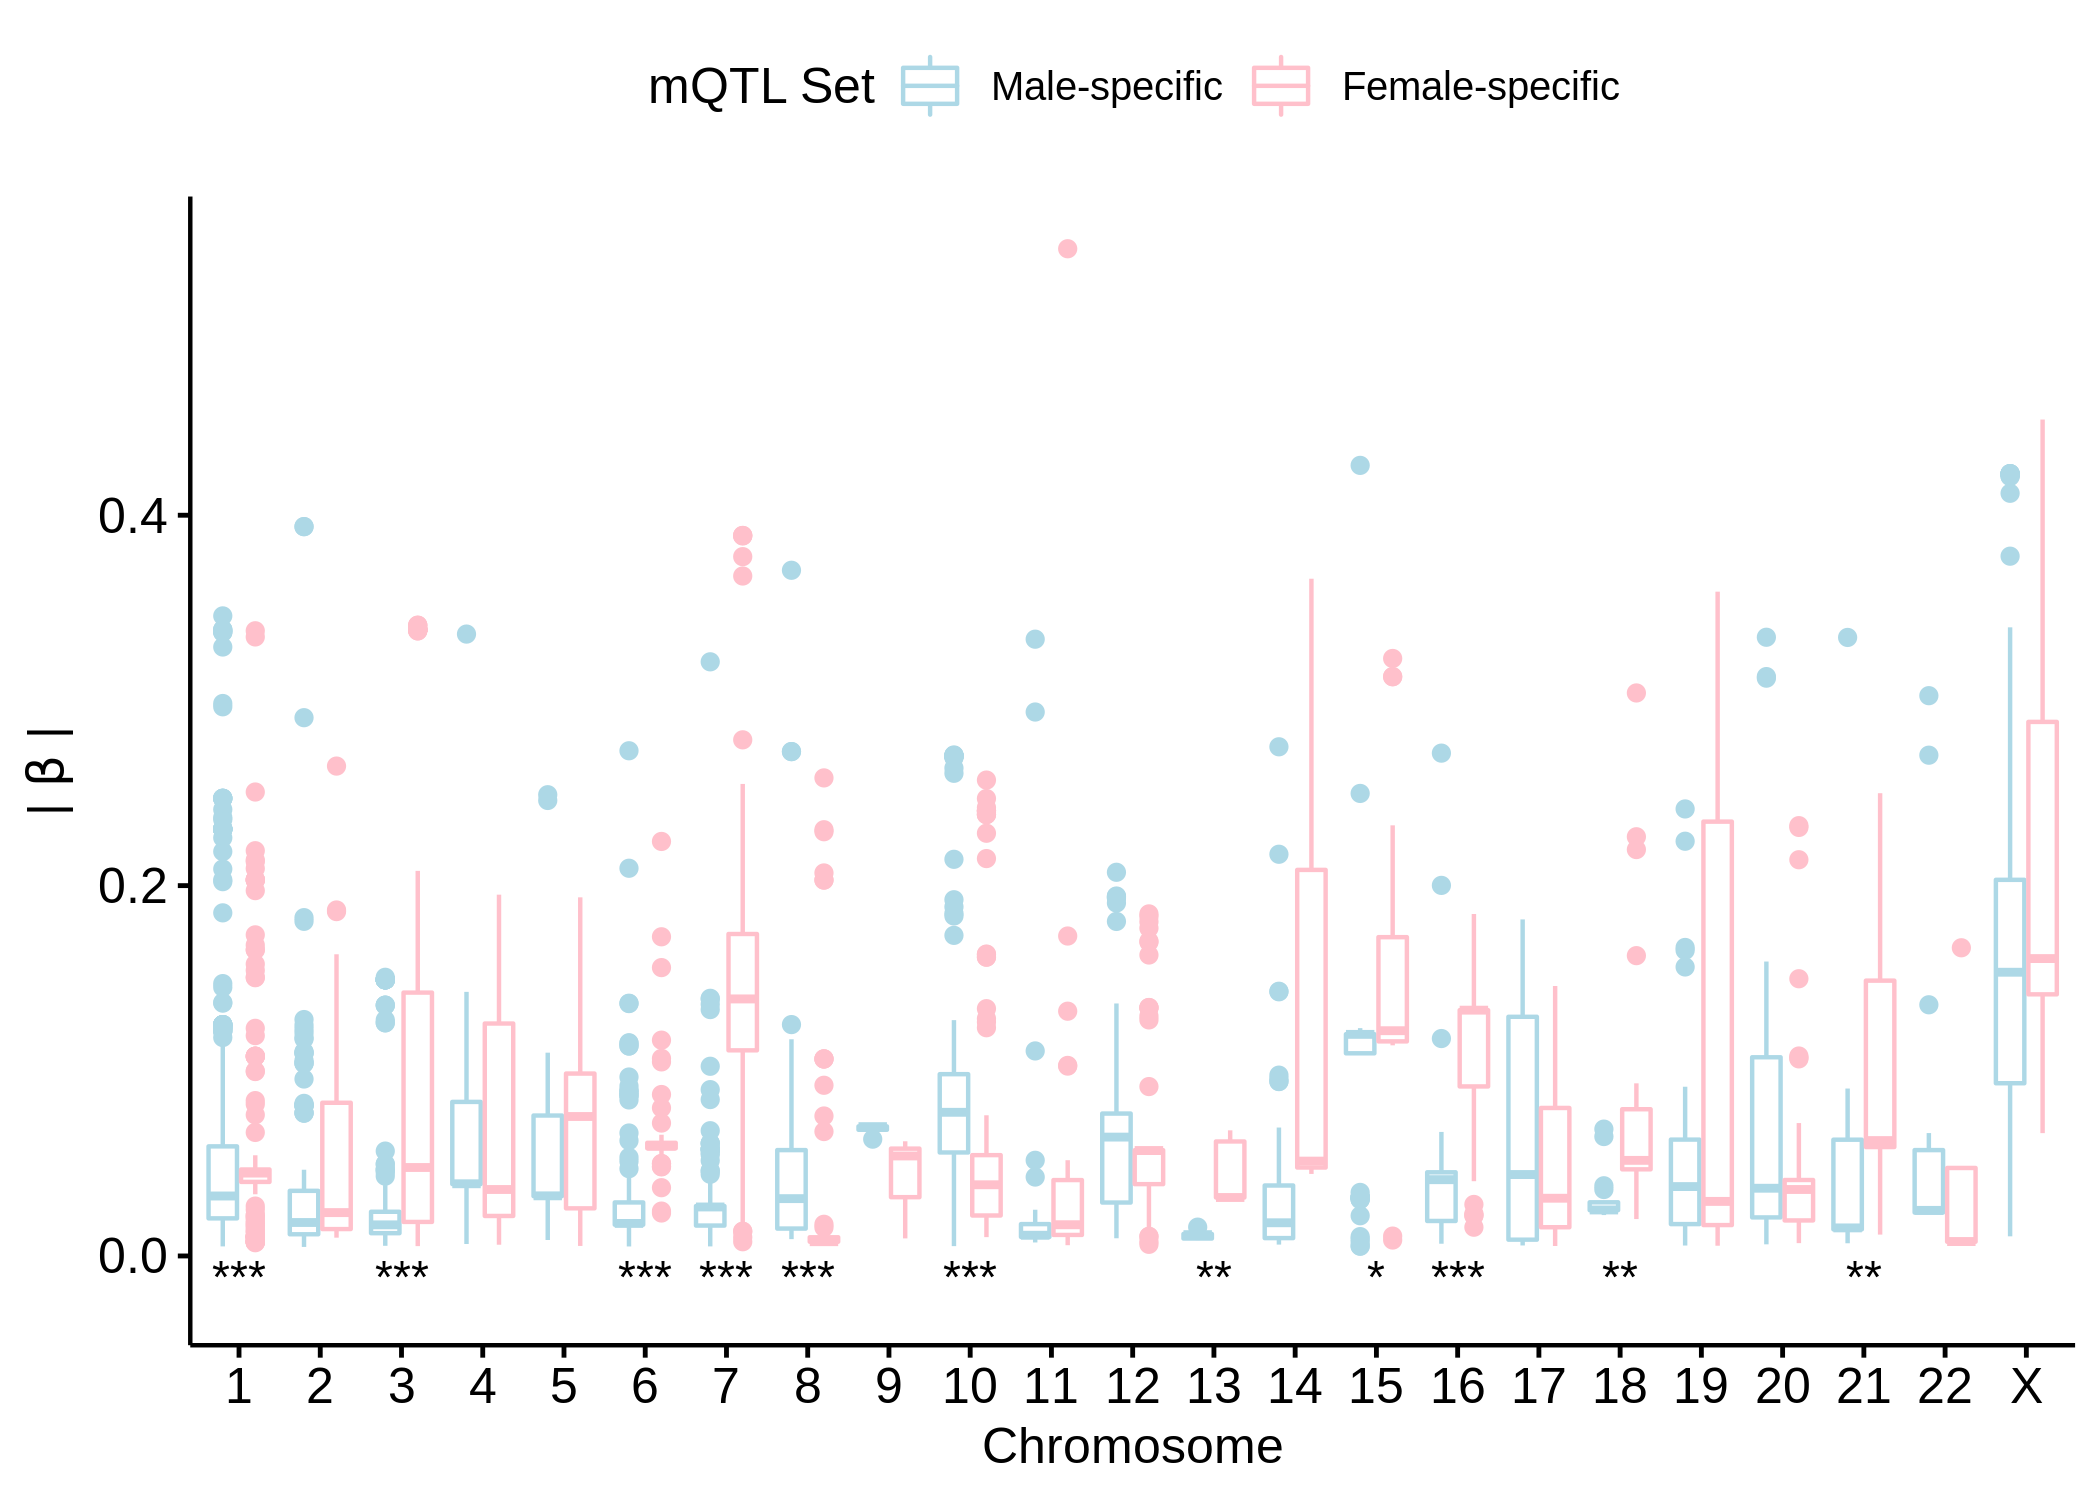

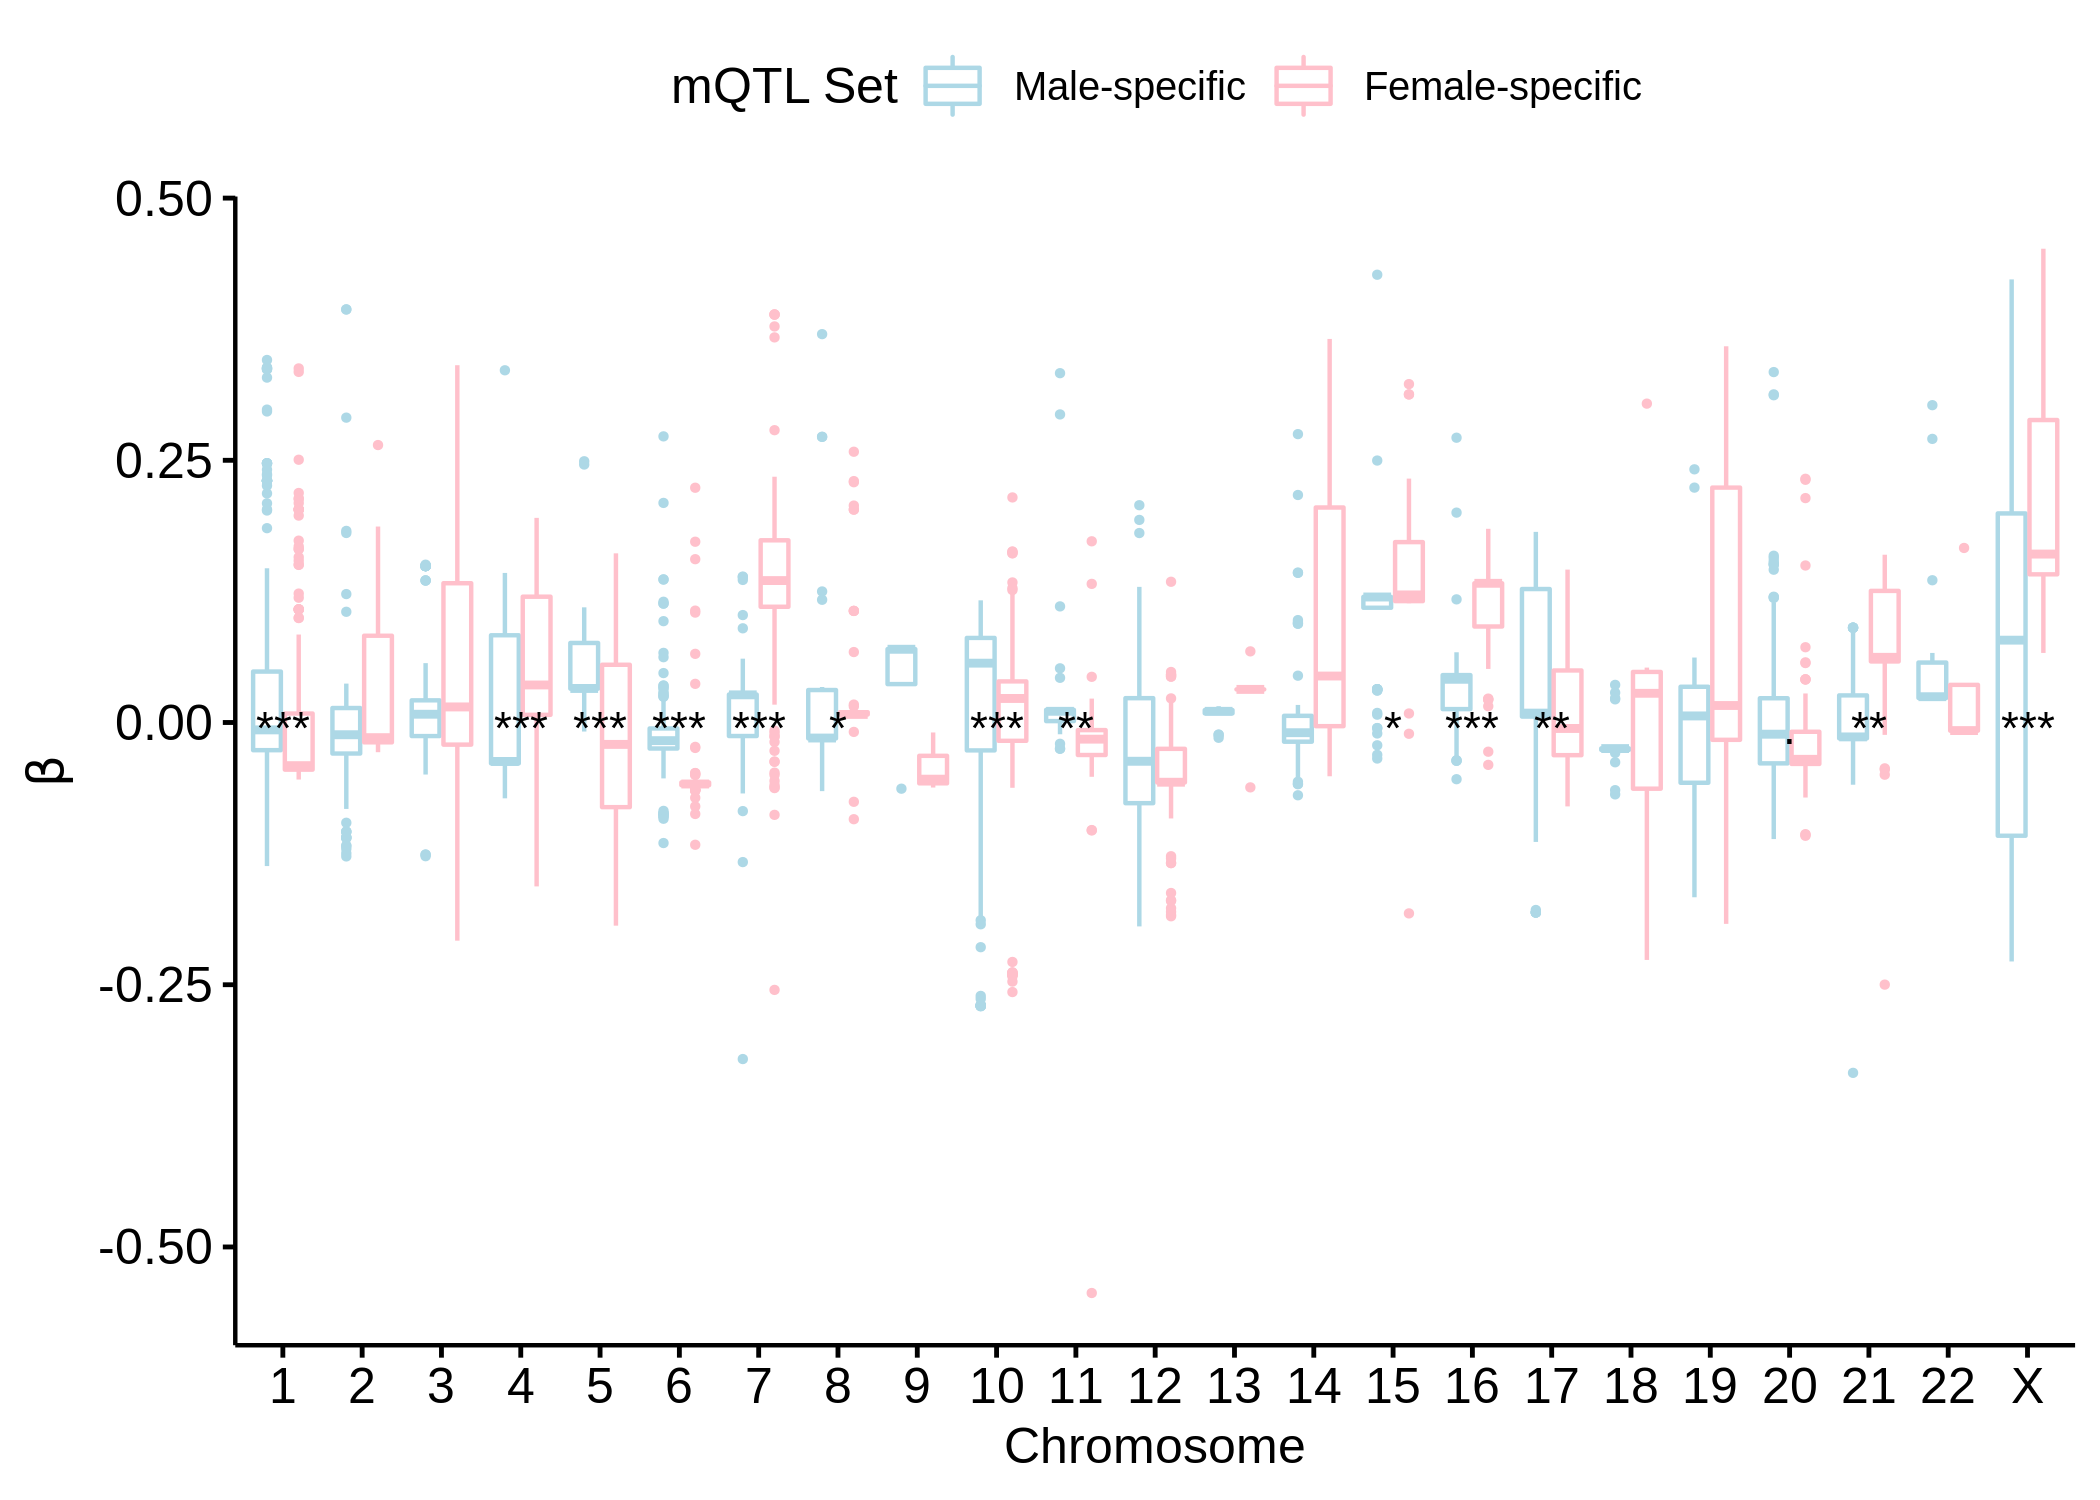

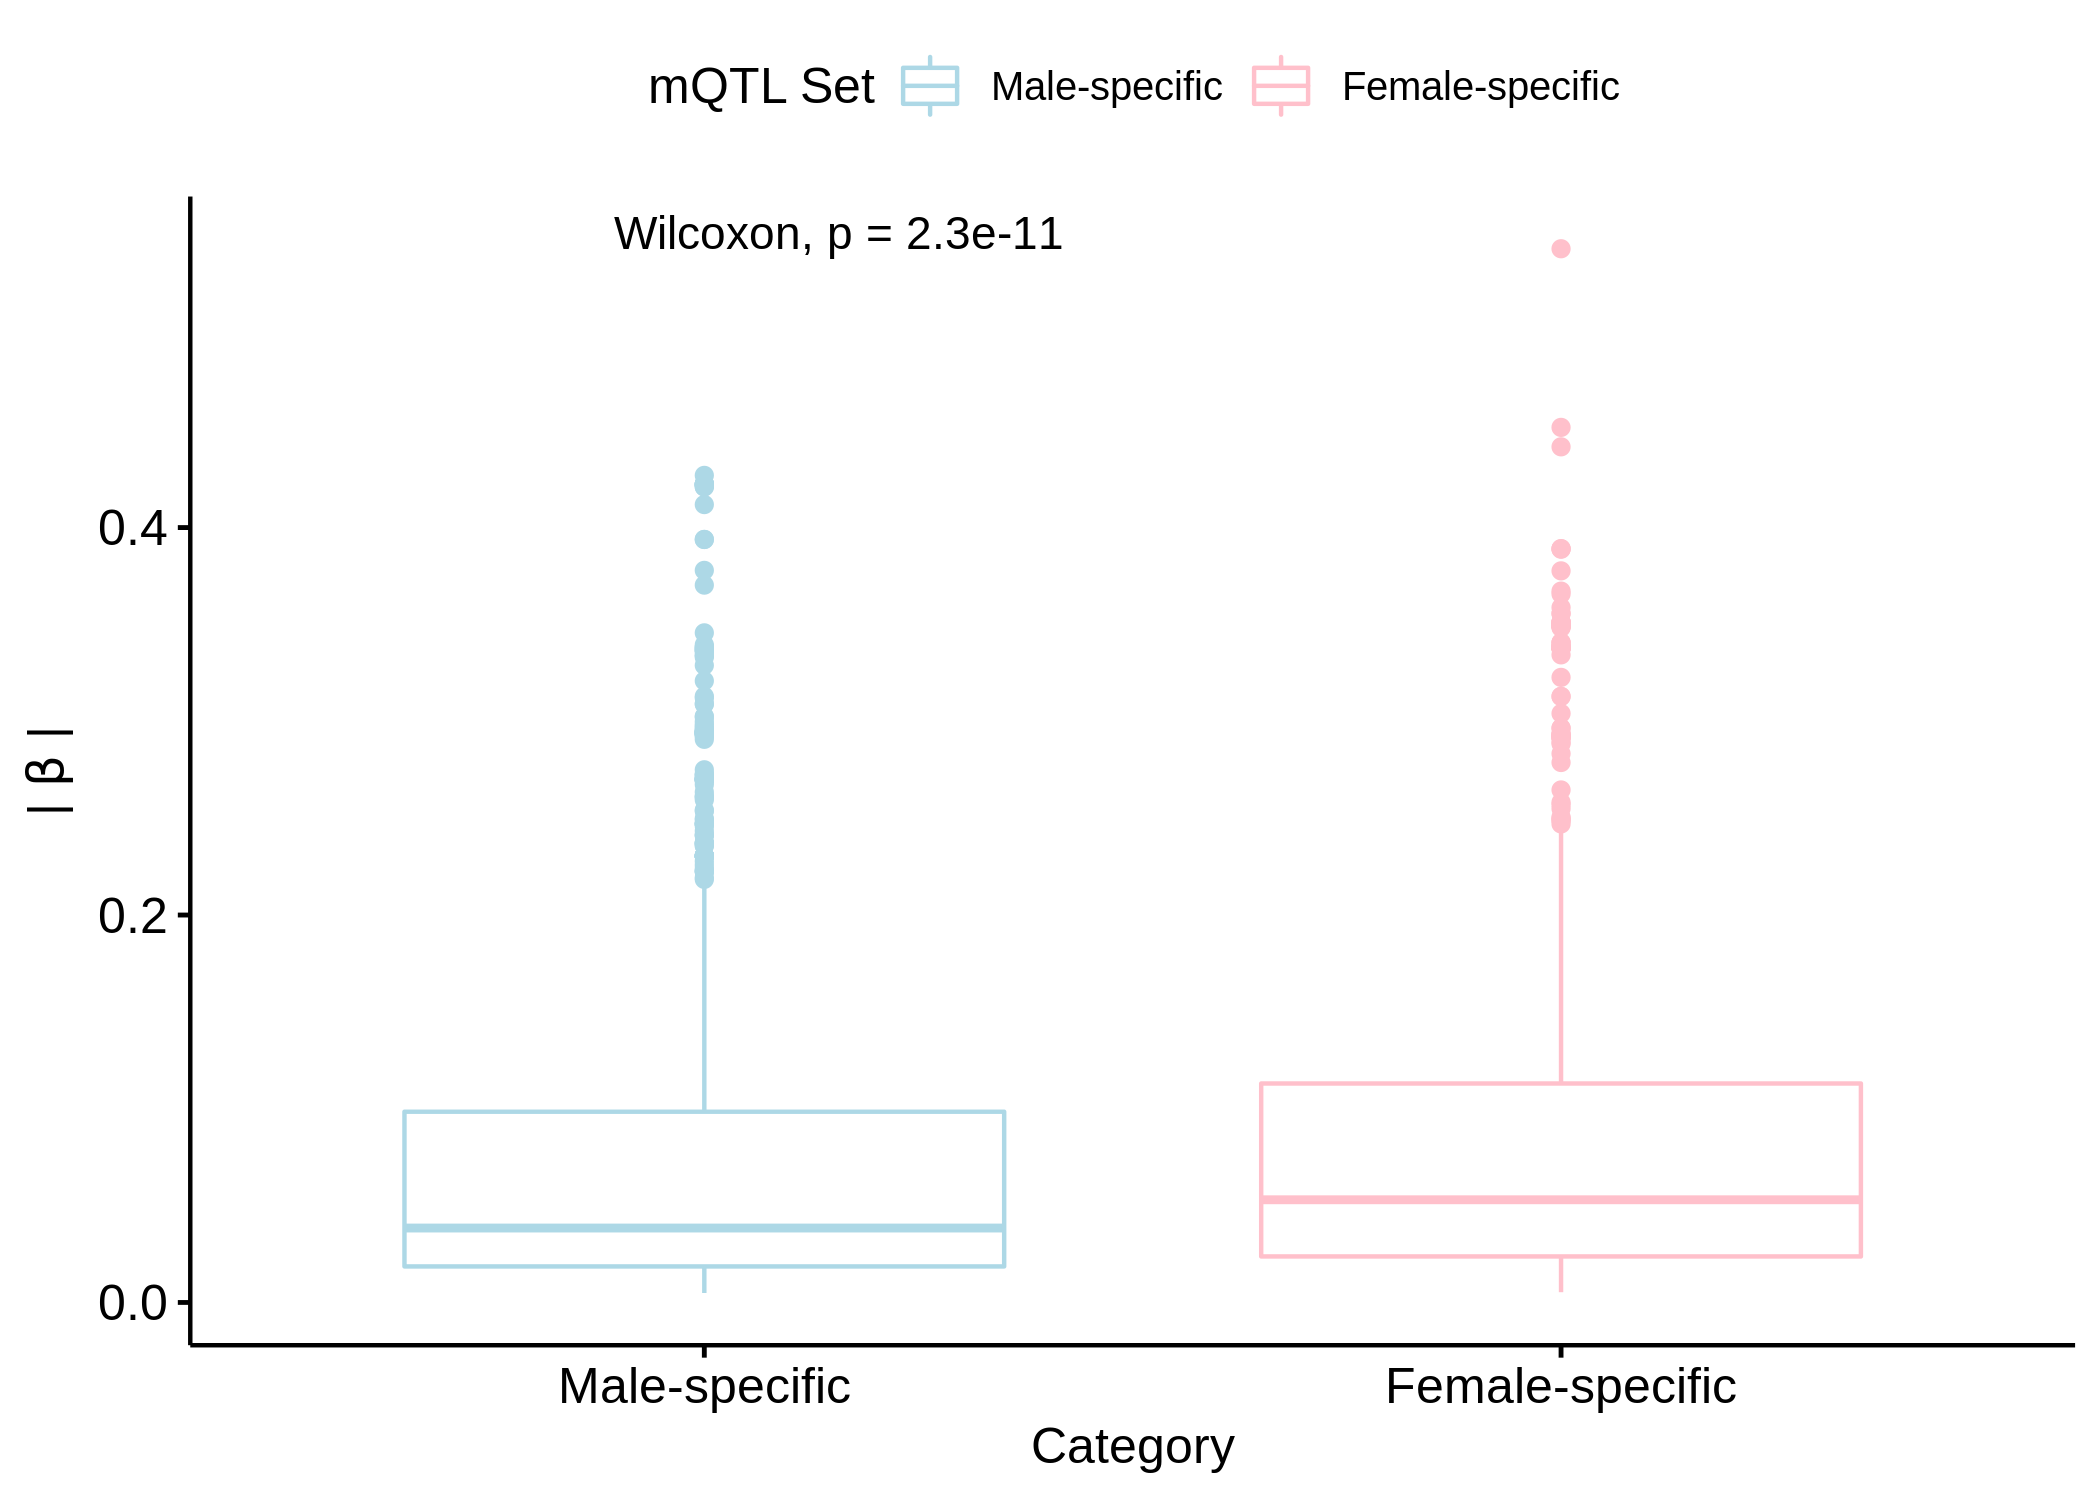

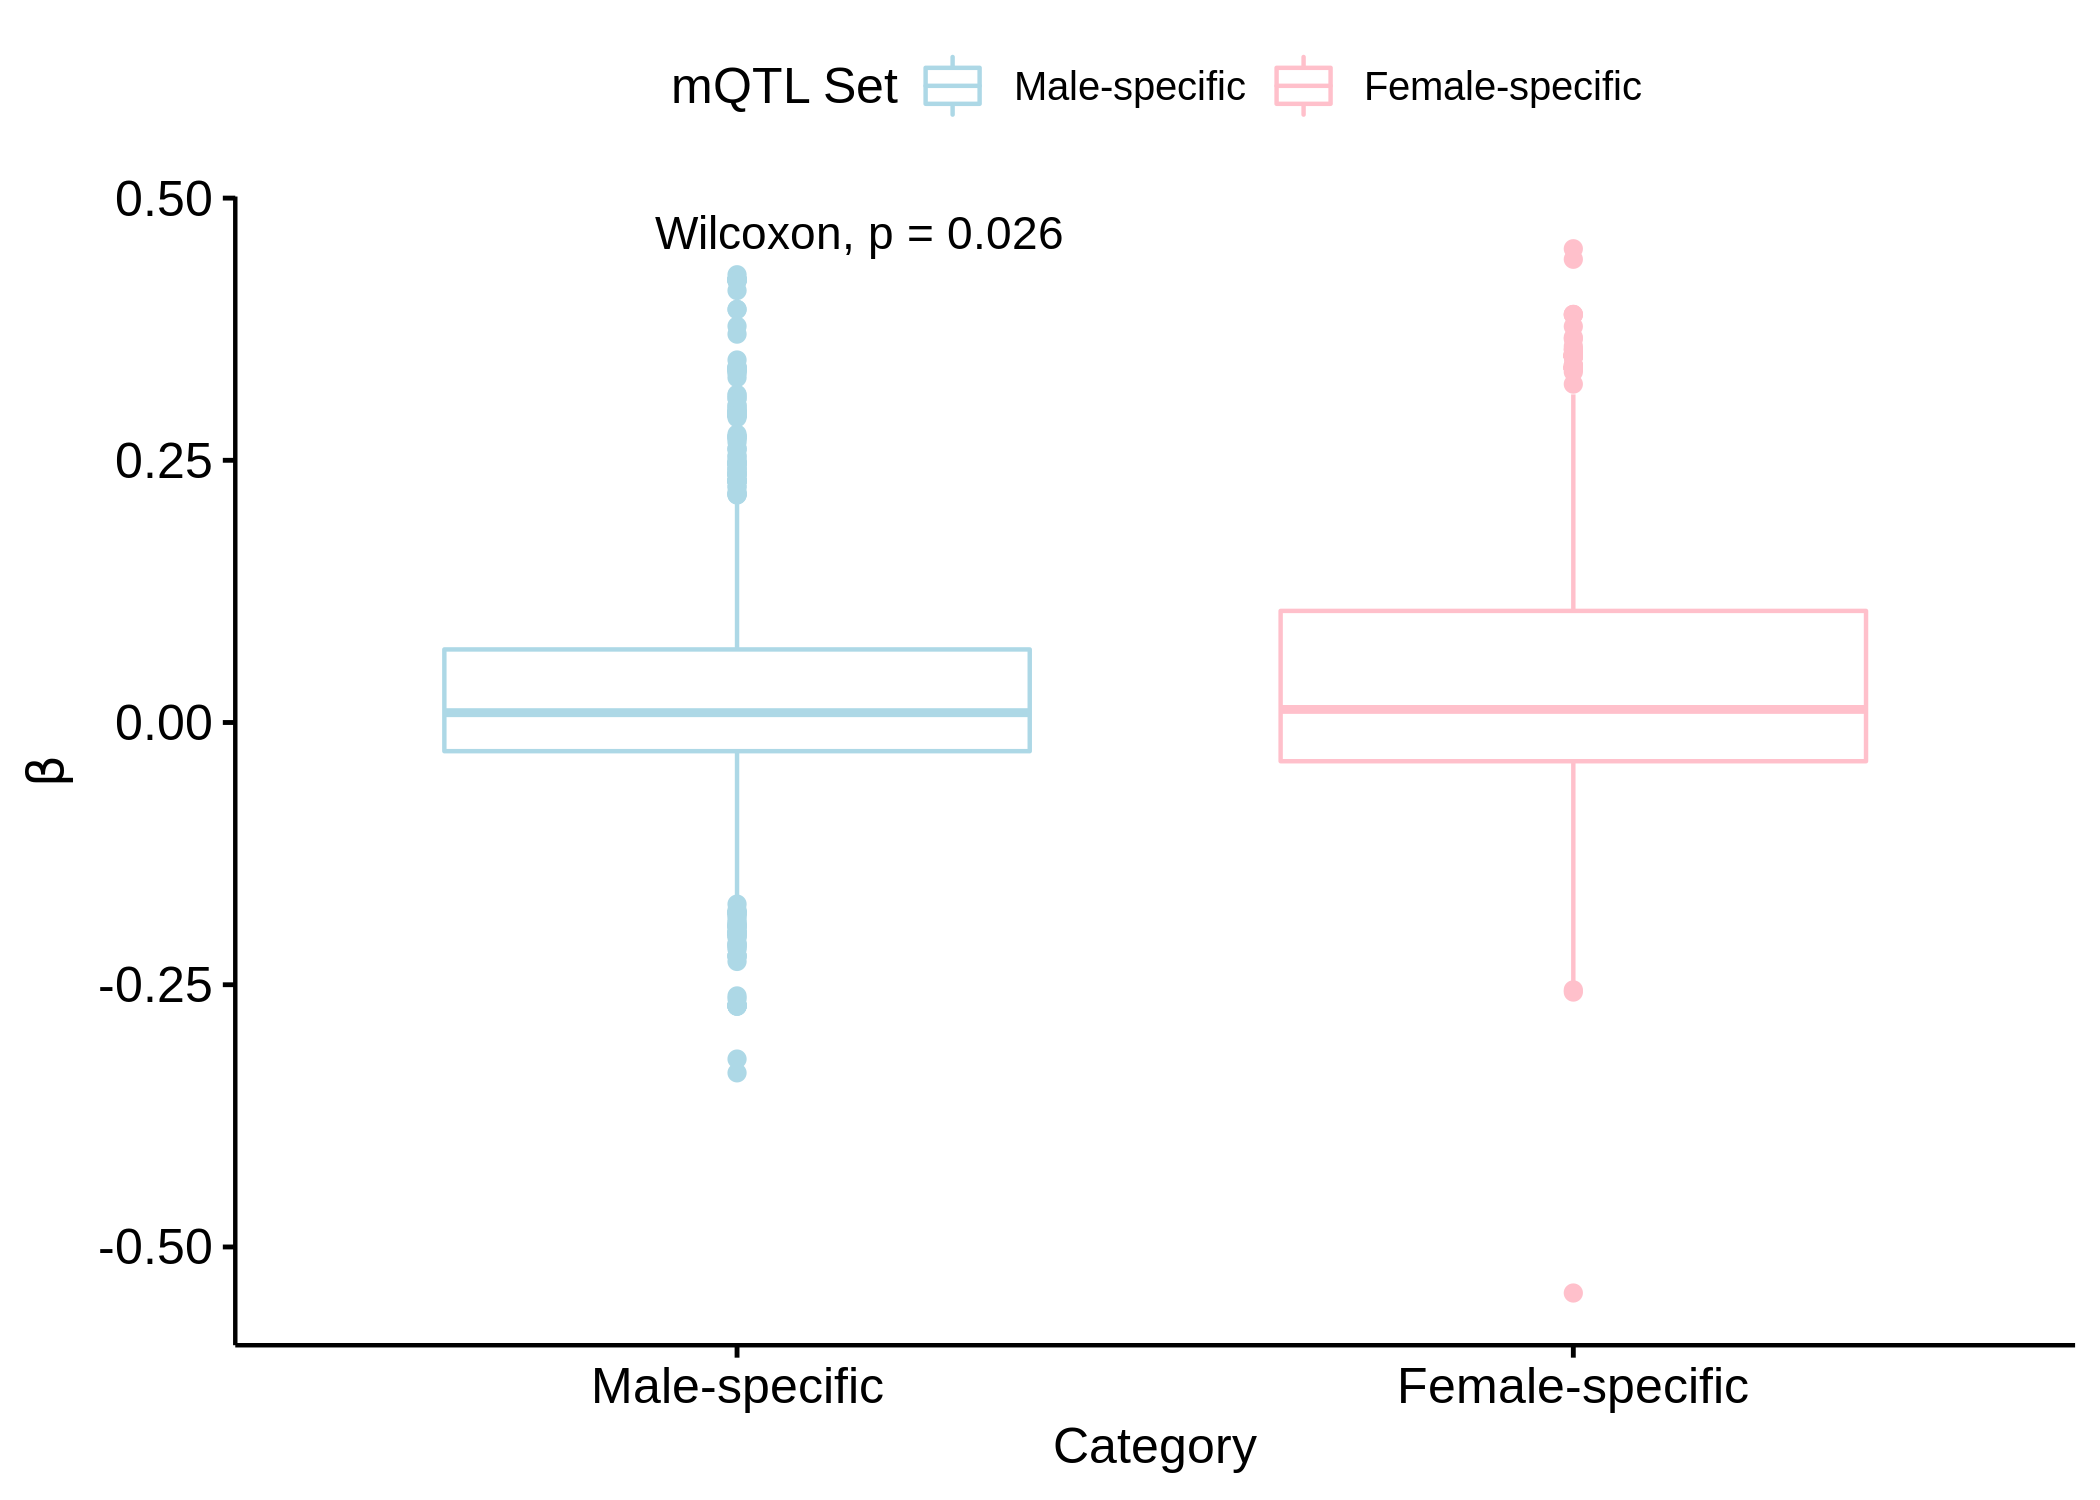

In [17]:
library(ggpubr)
signif.num <- function(x) {
    symnum(x, corr = FALSE, na = FALSE, legend = FALSE,
           cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1), 
           symbols = c("***", "**", "*", ".", " "))
}
ggboxplot(
    sex_effect_dt[,.(Chromosome=Chr,Category,b=abs(b))],
    x="Chromosome",
    y='b',
    color="Category",
    palette=c("light blue", "pink")
) +
    stat_compare_means(aes(group=Category,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote("|"~beta~"|"), color="mQTL Set")
ggboxplot(
    sex_effect_dt[,.(Chromosome=Chr,Category,b=b)],,
    x="Chromosome",
    y='b',
    color="Category",
    palette=c("light blue", "pink"),
    outlier.size=0.5
) +
    stat_compare_means(aes(group=Category,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote(beta), color = "mQTL Set")


ggboxplot(
    sex_effect_dt[,.(Chr,Category,b=abs(b))],
    x="Category",
    y='b',
    color="Category",
    palette=c("light blue", "pink")
) +
    stat_compare_means()+
    labs(y=bquote("|"~beta~"|"), color="mQTL Set")
ggboxplot(
    sex_effect_dt[,.(Chr,Category,b=b)],
    x="Category",
    y='b',
    color="Category",
    palette=c("light blue", "pink")
) +
    stat_compare_means()+
    labs(y=bquote(beta), color="mQTL Set")

In [44]:
compare_means(b~Category,sex_effect_dt, group.by = "Chr")
compare_means(b~Category,sex_effect_dt[,.(Chr,Category,b=abs(b))], group.by = "Chr")
compare_means(b~Category,sex_effect_dt[,.(Chr,Category,b)])
compare_means(b~Category,sex_effect_dt[,.(Chr,Category,b=abs(b))])

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
   .y.
1  b  
2  b  
3  b  
4  b  
5  b  
6  b  
7  b  
8  b  
9  b  
10 b  
11 b  
12 b  
13 b  
14 b  
15 b  
16 b  
17 b  
18 b  
19 b  
20 b  
21 b  
22 b  
23 b  
   group1       
1  Male-specific
2  Male-specific
3  Male-specific
4  Male-specific
5  Male-specific
6  Male-specific
7  Male-specific
8  Male-specific
9  Male-specific
10 Male-specific
11 Male-specific
12 Male-specific
13 Male-specific
14 Male-specific
15 Male-specific
16 Male-specific
17 Male-specific
18 Male-specific
19 Male-specific
20 Male-specific
21 Male-specific
22 Male-specific
23 Male-specific
   group2         
1  Female-specific
2  Female-specific
3  Female-specific
4  Female-specific
5  Female-specific
6  Female-specific
7  Female-specific
8  Female-specific
9  Female-specific
10 Female-specific
11 Female-specific
12 Female-specific
13 Female-specific
14 Female-specific
15 Female-specific
16 Female-specific
17 Female-specific
18 Female-specific
19 Female-specific
20 Female-specific
21 Female-specific
22 Female-specific
23 Female-specific
   p           
1  6.479045e-13
2  1.119149e-01
3  1.179544e-01
4  6.618751e-06
5  4.449510e-05
6  6.057615e-16
7  4.207711e-41
8  3.167652e-03
9  3.724559e-01
10 1.325899e-06
11 5.387048e-04
12 1.821448e-01
13 4.349430e-02
14 4.138347e-01
15 3.447322e-03
16 2.957746e-11
17 1.270190e-04
18 5.727712e-01
19 4.706550e-02
20 6.281895e-03
21 5.524047e-04
22 9.879491e-02
23 1.483369e-05
   p.adj  
1  1.4e-11
2  6.9e-01
3  6.9e-01
4  1.2e-04
5  7.1e-04
6  1.3e-14
7  9.7e-40
8  3.8e-02
9  1.0e+00
10 2.5e-05
11 7.5e-03
12 7.3e-01
13 3.9e-01
14 1.0e+00
15 3.8e-02
16 5.9e-10
17 1.9e-03
18 1.0e+00
19 3.9e-01
20 6.3e-02
21 7.5e-03
22 6.9e-01
23 2.5e-04
   p.format
1  6.5e-13 
2  0.11191 
3  0.11795 
4  6.6e-06 
5  4.4e-05 
6  6.1e-16 
7  < 2e-16 
8  0.00317 
9  0.37246 
10 1.3e-06 
11 0.00054 
12 0.18214 
13 0.04349 
14 0.41383 
15 0.00345 
16 3.0e-11 
17 0.00013 
18 0.57277 
19 0.04707 
20 0.00628 
21 0.00055 
22 0.09879 
23 1.5e-05 
   p.signif
1  ****    
2  ns      
3  ns      
4  ****    
5  ****    
6  ****    
7  ****    
8  **      
9  ns      
10 ****    
11 ***     
12 ns      
13 *       
14 ns      
15 **      
16 ****    
17 ***     
18 ns      
19 *       
20 **      
21 ***     
22 ns      
23 ****    
   method  
1  Wilcoxon
2  Wilcoxon
3  Wilcoxon
4  Wilcoxon
5  Wilcoxon
6  Wilcoxon
7  Wilcoxon
8  Wilcoxon
9  Wilcoxon
10 Wilcoxon
11 Wilcoxon
12 Wilcoxon
13 Wilcoxon
14 Wilcoxon
15 Wilcoxon
16 Wilcoxon
17 Wilcoxon
18 Wilcoxon
19 Wilcoxon
20 Wilcoxon
21 Wilcoxon
22 Wilcoxon
23 Wilcoxon

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
   .y.
1  b  
2  b  
3  b  
4  b  
5  b  
6  b  
7  b  
8  b  
9  b  
10 b  
11 b  
12 b  
13 b  
14 b  
15 b  
16 b  
17 b  
18 b  
19 b  
20 b  
21 b  
22 b  
23 b  
   group1       
1  Male-specific
2  Male-specific
3  Male-specific
4  Male-specific
5  Male-specific
6  Male-specific
7  Male-specific
8  Male-specific
9  Male-specific
10 Male-specific
11 Male-specific
12 Male-specific
13 Male-specific
14 Male-specific
15 Male-specific
16 Male-specific
17 Male-specific
18 Male-specific
19 Male-specific
20 Male-specific
21 Male-specific
22 Male-specific
23 Male-specific
   group2         
1  Female-specific
2  Female-specific
3  Female-specific
4  Female-specific
5  Female-specific
6  Female-specific
7  Female-specific
8  Female-specific
9  Female-specific
10 Female-specific
11 Female-specific
12 Female-specific
13 Female-specific
14 Female-specific
15 Female-specific
16 Female-specific
17 Female-specific
18 Female-specific
19 Female-specific
20 Female-specific
21 Female-specific
22 Female-specific
23 Female-specific
   p           
1  2.575834e-05
2  3.524194e-02
3  2.014933e-08
4  4.921341e-01
5  2.367376e-01
6  2.996243e-19
7  1.256535e-45
8  3.157975e-07
9  4.974599e-02
10 3.580333e-29
11 8.356472e-02
12 1.274412e-02
13 7.076565e-04
14 4.719556e-02
15 9.993147e-04
16 5.076211e-12
17 5.338312e-02
18 1.881416e-04
19 5.378240e-01
20 5.962227e-02
21 2.626778e-04
22 9.879491e-02
23 1.023581e-01
   p.adj  
1  4.4e-04
2  3.9e-01
3  3.8e-07
4  9.8e-01
5  7.1e-01
6  6.3e-18
7  2.9e-44
8  5.7e-06
9  4.7e-01
10 7.9e-28
11 5.0e-01
12 1.5e-01
13 9.9e-03
14 4.7e-01
15 1.3e-02
16 1.0e-10
17 4.7e-01
18 3.0e-03
19 9.8e-01
20 4.7e-01
21 3.9e-03
22 5.0e-01
23 5.0e-01
   p.format
1  2.6e-05 
2  0.03524 
3  2.0e-08 
4  0.49213 
5  0.23674 
6  < 2e-16 
7  < 2e-16 
8  3.2e-07 
9  0.04975 
10 < 2e-16 
11 0.08356 
12 0.01274 
13 0.00071 
14 0.04720 
15 0.00100 
16 5.1e-12 
17 0.05338 
18 0.00019 
19 0.53782 
20 0.05962 
21 0.00026 
22 0.09879 
23 0.10236 
   p.signif
1  ****    
2  *       
3  ****    
4  ns      
5  ns      
6  ****    
7  ****    
8  ****    
9  *       
10 ****    
11 ns      
12 *       
13 ***     
14 *       
15 ***     
16 ****    
17 ns      
18 ***     
19 ns      
20 ns      
21 ***     
22 ns      
23 ns      
   method  
1  Wilcoxon
2  Wilcoxon
3  Wilcoxon
4  Wilcoxon
5  Wilcoxon
6  Wilcoxon
7  Wilcoxon
8  Wilcoxon
9  Wilcoxon
10 Wilcoxon
11 Wilcoxon
12 Wilcoxon
13 Wilcoxon
14 Wilcoxon
15 Wilcoxon
16 Wilcoxon
17 Wilcoxon
18 Wilcoxon
19 Wilcoxon
20 Wilcoxon
21 Wilcoxon
22 Wilcoxon
23 Wilcoxon

.y.
1 b  
  group1       
1 Male-specific
  group2         
1 Female-specific
  p         
1 0.02605251
  p.adj
1 0.026
  p.format
1 0.026   
  p.signif
1 *       
  method  
1 Wilcoxon

.y.
1 b  
  group1       
1 Male-specific
  group2         
1 Female-specific
  p           
1 2.303366e-11
  p.adj  
1 2.3e-11
  p.format
1 2.3e-11 
  p.signif
1 ****    
  method  
1 Wilcoxon

In [45]:
sex_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Chr","Category")]
sex_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Category")]

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
24 1  
25 2  
26 3  
27 4  
28 5  
29 6  
30 7  
31 8  
32 9  
33 10 
34 11 
35 12 
36 13 
37 14 
38 15 
39 16 
40 17 
41 18 
42 19 
43 20 
44 21 
45 22 
46 X  
   Category       
1  Male-specific  
2  Male-specific  
3  Male-specific  
4  Male-specific  
5  Male-specific  
6  Male-specific  
7  Male-specific  
8  Male-specific  
9  Male-specific  
10 Male-specific  
11 Male-specific  
12 Male-specific  
13 Male-specific  
14 Male-specific  
15 Male-specific  
16 Male-specific  
17 Male-specific  
18 Male-specific  
19 Male-specific  
20 Male-specific  
21 Male-specific  
22 Male-specific  
23 Male-specific  
24 Female-specific
25 Female-specific
26 Female-specific
27 Female-specific
28 Female-specific
29 Female-specific
30 Female-specific
31 Female-specific
32 Female-specific
33 Female-specific
34 Female-specific
35 Female-specific
36 Female-specific
37 Female-specific
38 Female-specific
39 Female-specific
40 Female-specific
41 Female-specific
42 Female-specific
43 Female-specific
44 Female-specific
45 Female-specific
46 Female-specific
   mean_beta   
1   0.023547942
2  -0.006875808
3   0.016887115
4   0.014247370
5   0.061357723
6  -0.007567177
7   0.012789878
8   0.021262047
9   0.036752875
10  0.013348573
11  0.029522534
12 -0.026656830
13  0.007525232
14  0.007138071
15  0.099368314
16  0.029165630
17  0.042826368
18 -0.018566624
19 -0.002689231
20  0.008300165
21  0.002983730
22  0.072932600
23  0.061826277
24  0.005992114
25  0.033292939
26  0.063780511
27  0.059971285
28 -0.013962017
29 -0.040362454
30  0.137514760
31  0.030703072
32 -0.041820257
33  0.011193759
34 -0.027164051
35 -0.047589780
36  0.020149420
37  0.119600200
38  0.139157422
39  0.105965924
40  0.009377256
41 -0.012594575
42  0.085477909
43 -0.016567462
44  0.060183858
45  0.035806330
46  0.187599118
   mean_abs_beta
1  0.05581791   
2  0.04218298   
3  0.03558615   
4  0.05694747   
5  0.06210697   
6  0.03156349   
7  0.03330692   
8  0.05901179   
9  0.06829347   
10 0.08572210   
11 0.03707354   
12 0.05992686   
13 0.01111658   
14 0.03703934   
15 0.10268986   
16 0.03700155   
17 0.07235392   
18 0.03145944   
19 0.05764598   
20 0.05980933   
21 0.04261128   
22 0.07293260   
23 0.15707370   
24 0.06188277   
25 0.05700575   
26 0.09677561   
27 0.07130311   
28 0.06658334   
29 0.06620709   
30 0.14458514   
31 0.03622588   
32 0.04182026   
33 0.04768498   
34 0.05556967   
35 0.05659278   
36 0.04488294   
37 0.15375333   
38 0.14753640   
39 0.10965218   
40 0.04597069   
41 0.08641087   
42 0.11195206   
43 0.03964769   
44 0.08583552   
45 0.04741017   
46 0.18759912

Category       
1 Male-specific  
2 Female-specific
  mean_beta 
1 0.02149235
2 0.03464848
  mean_abs_beta
1 0.06809077   
2 0.07904171

### Sex stratified

Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.

Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.



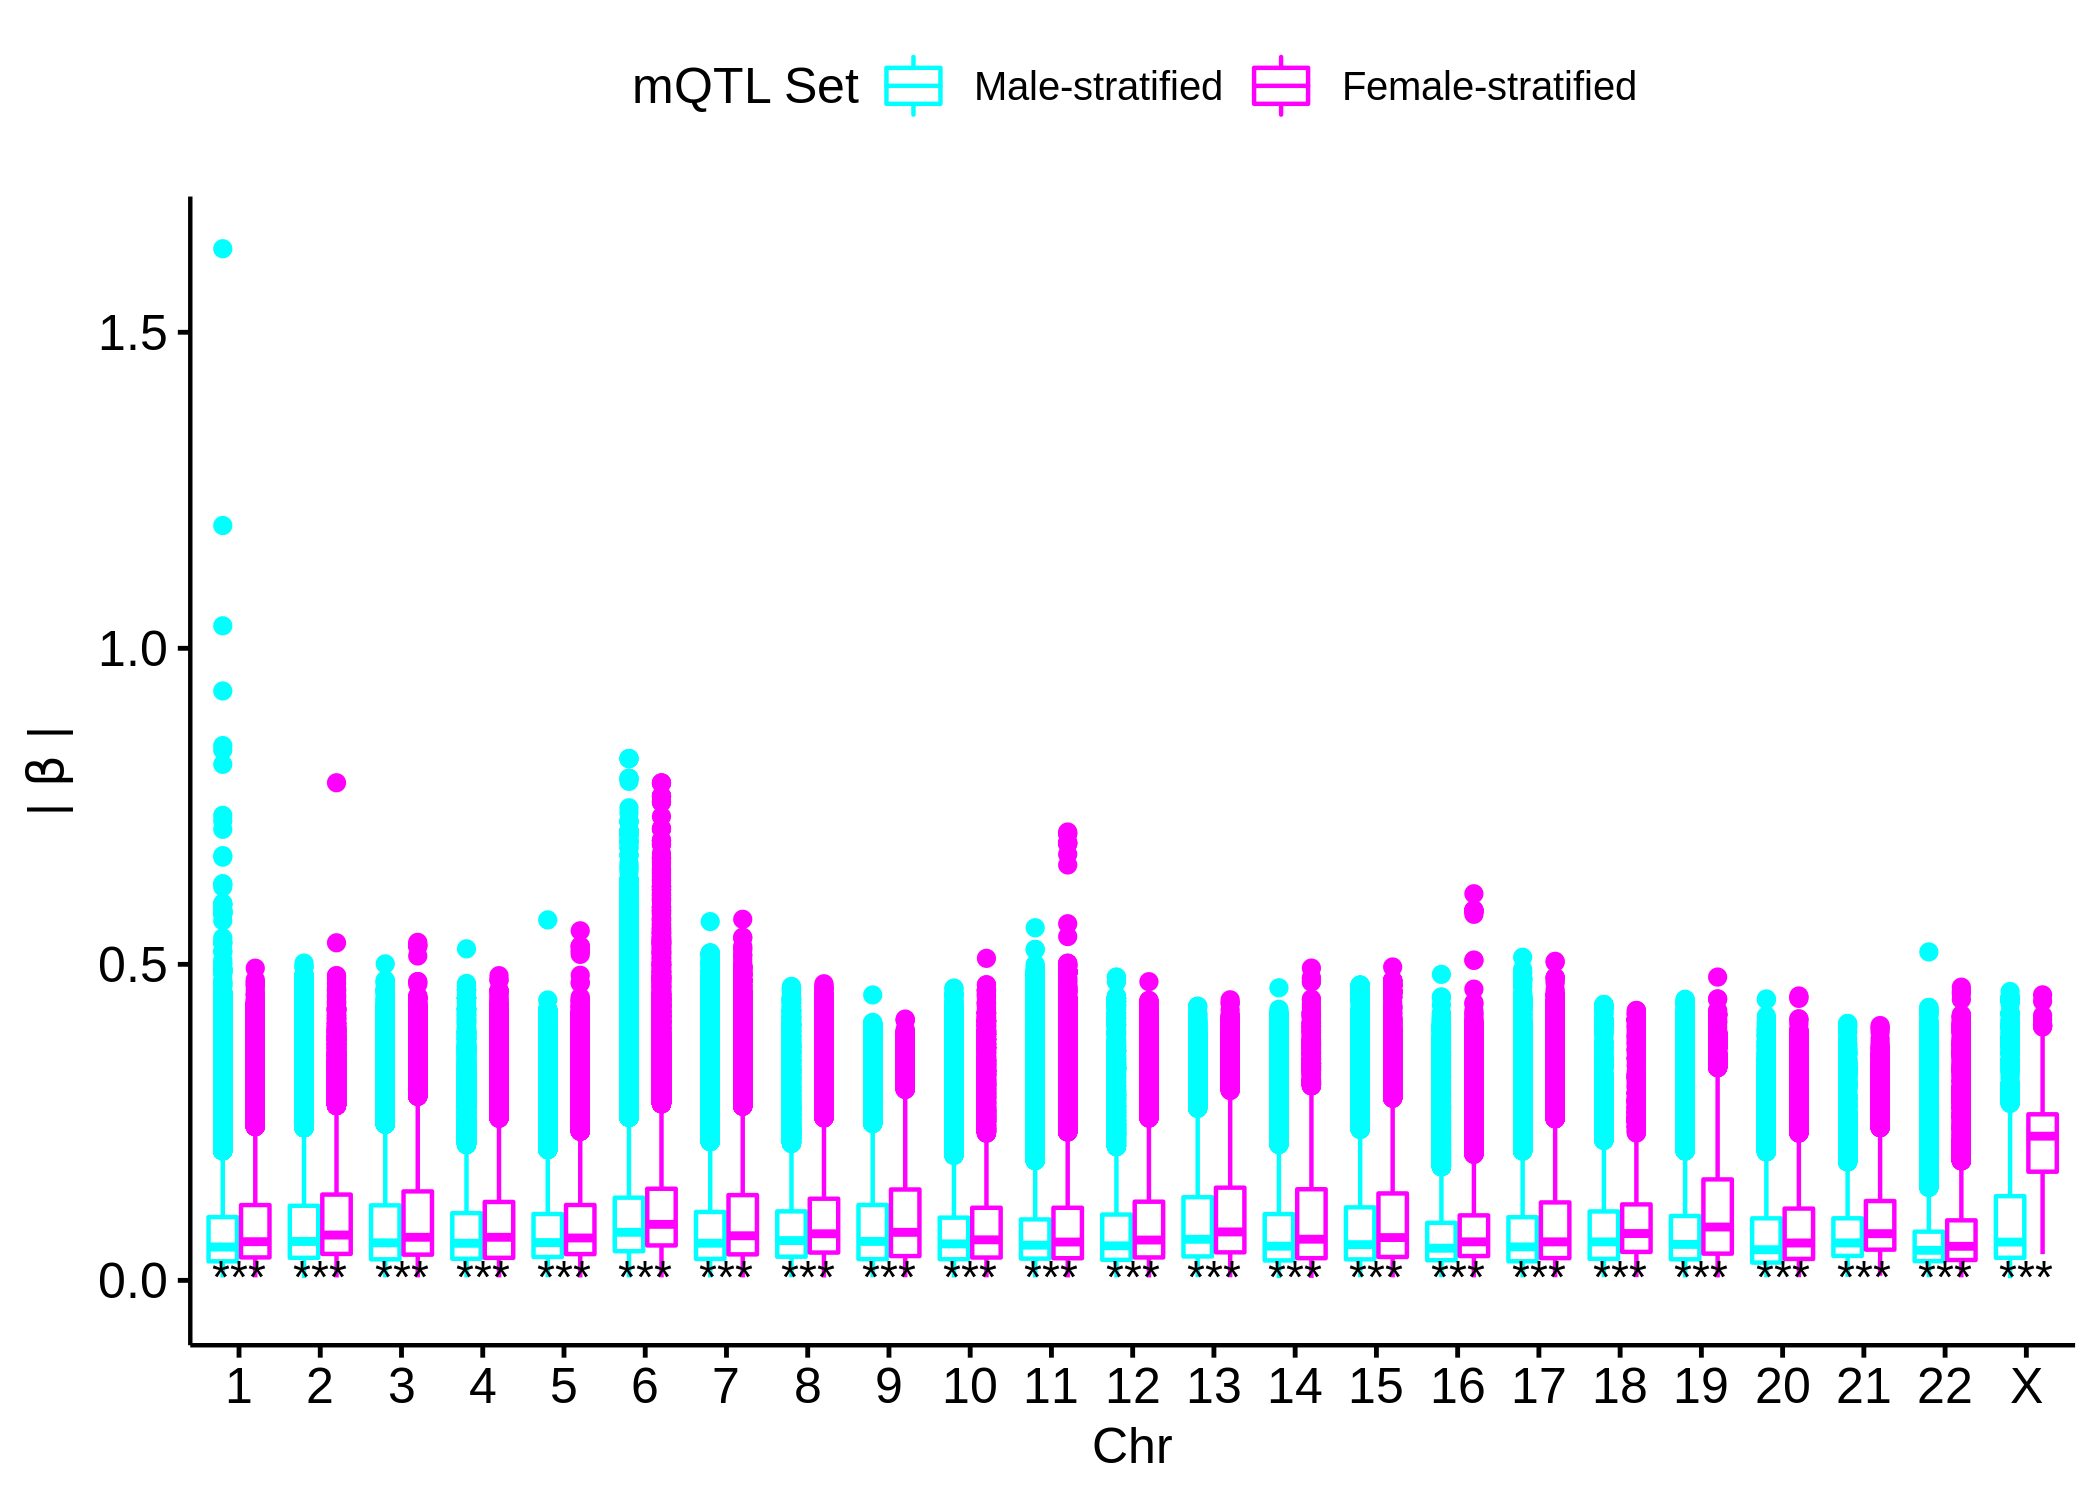

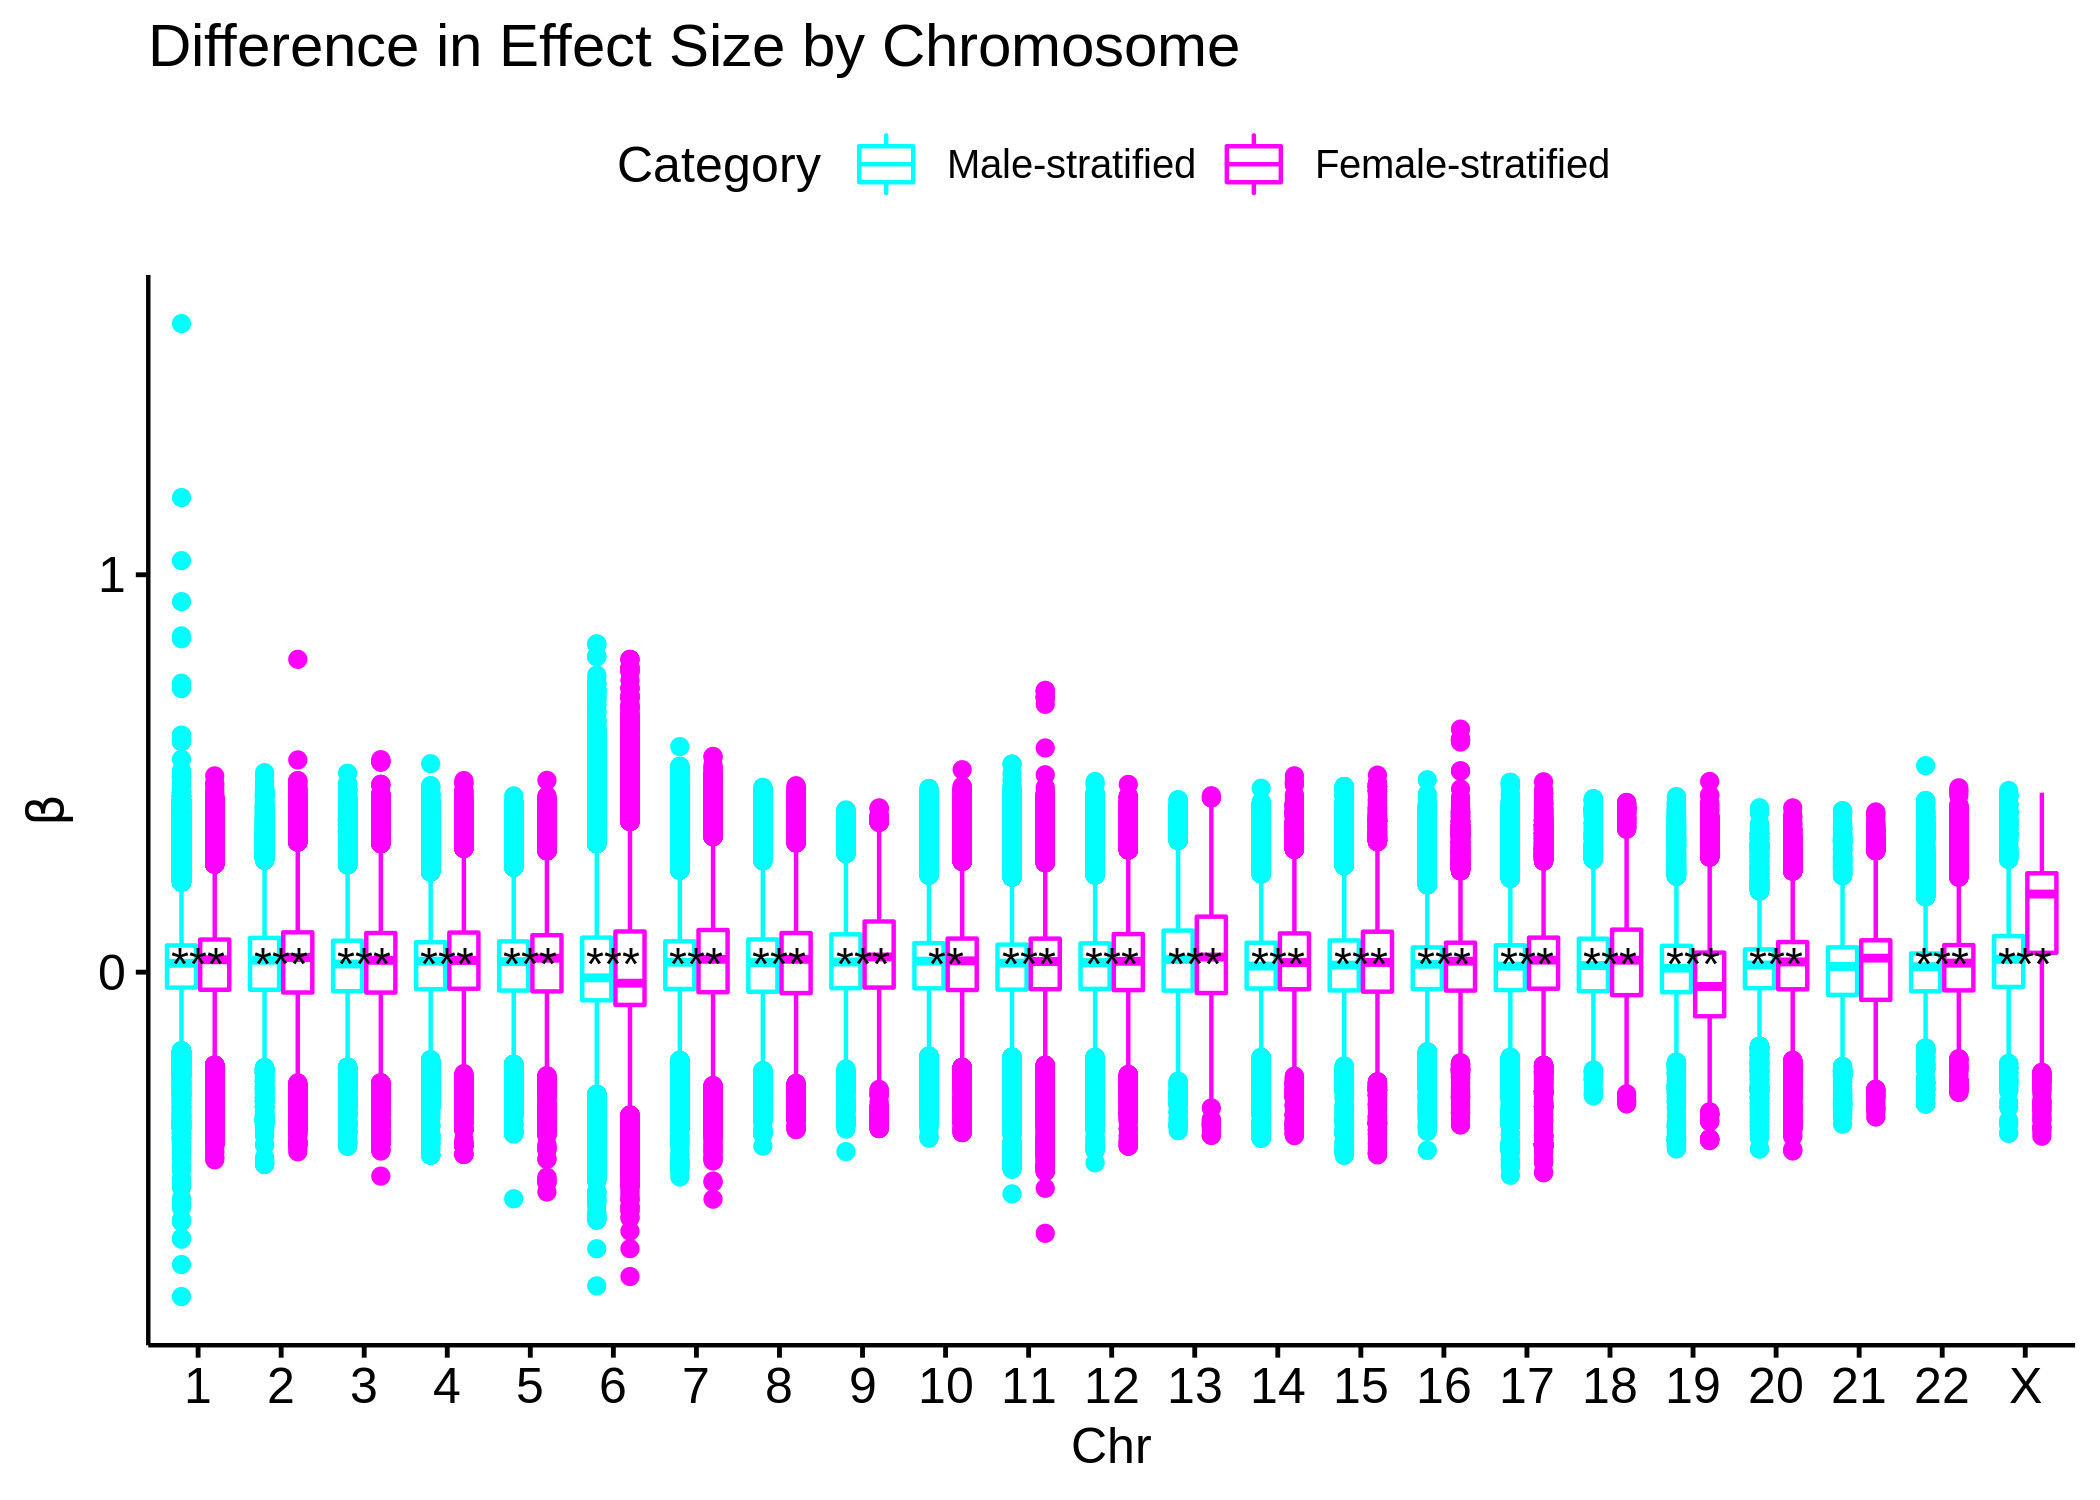

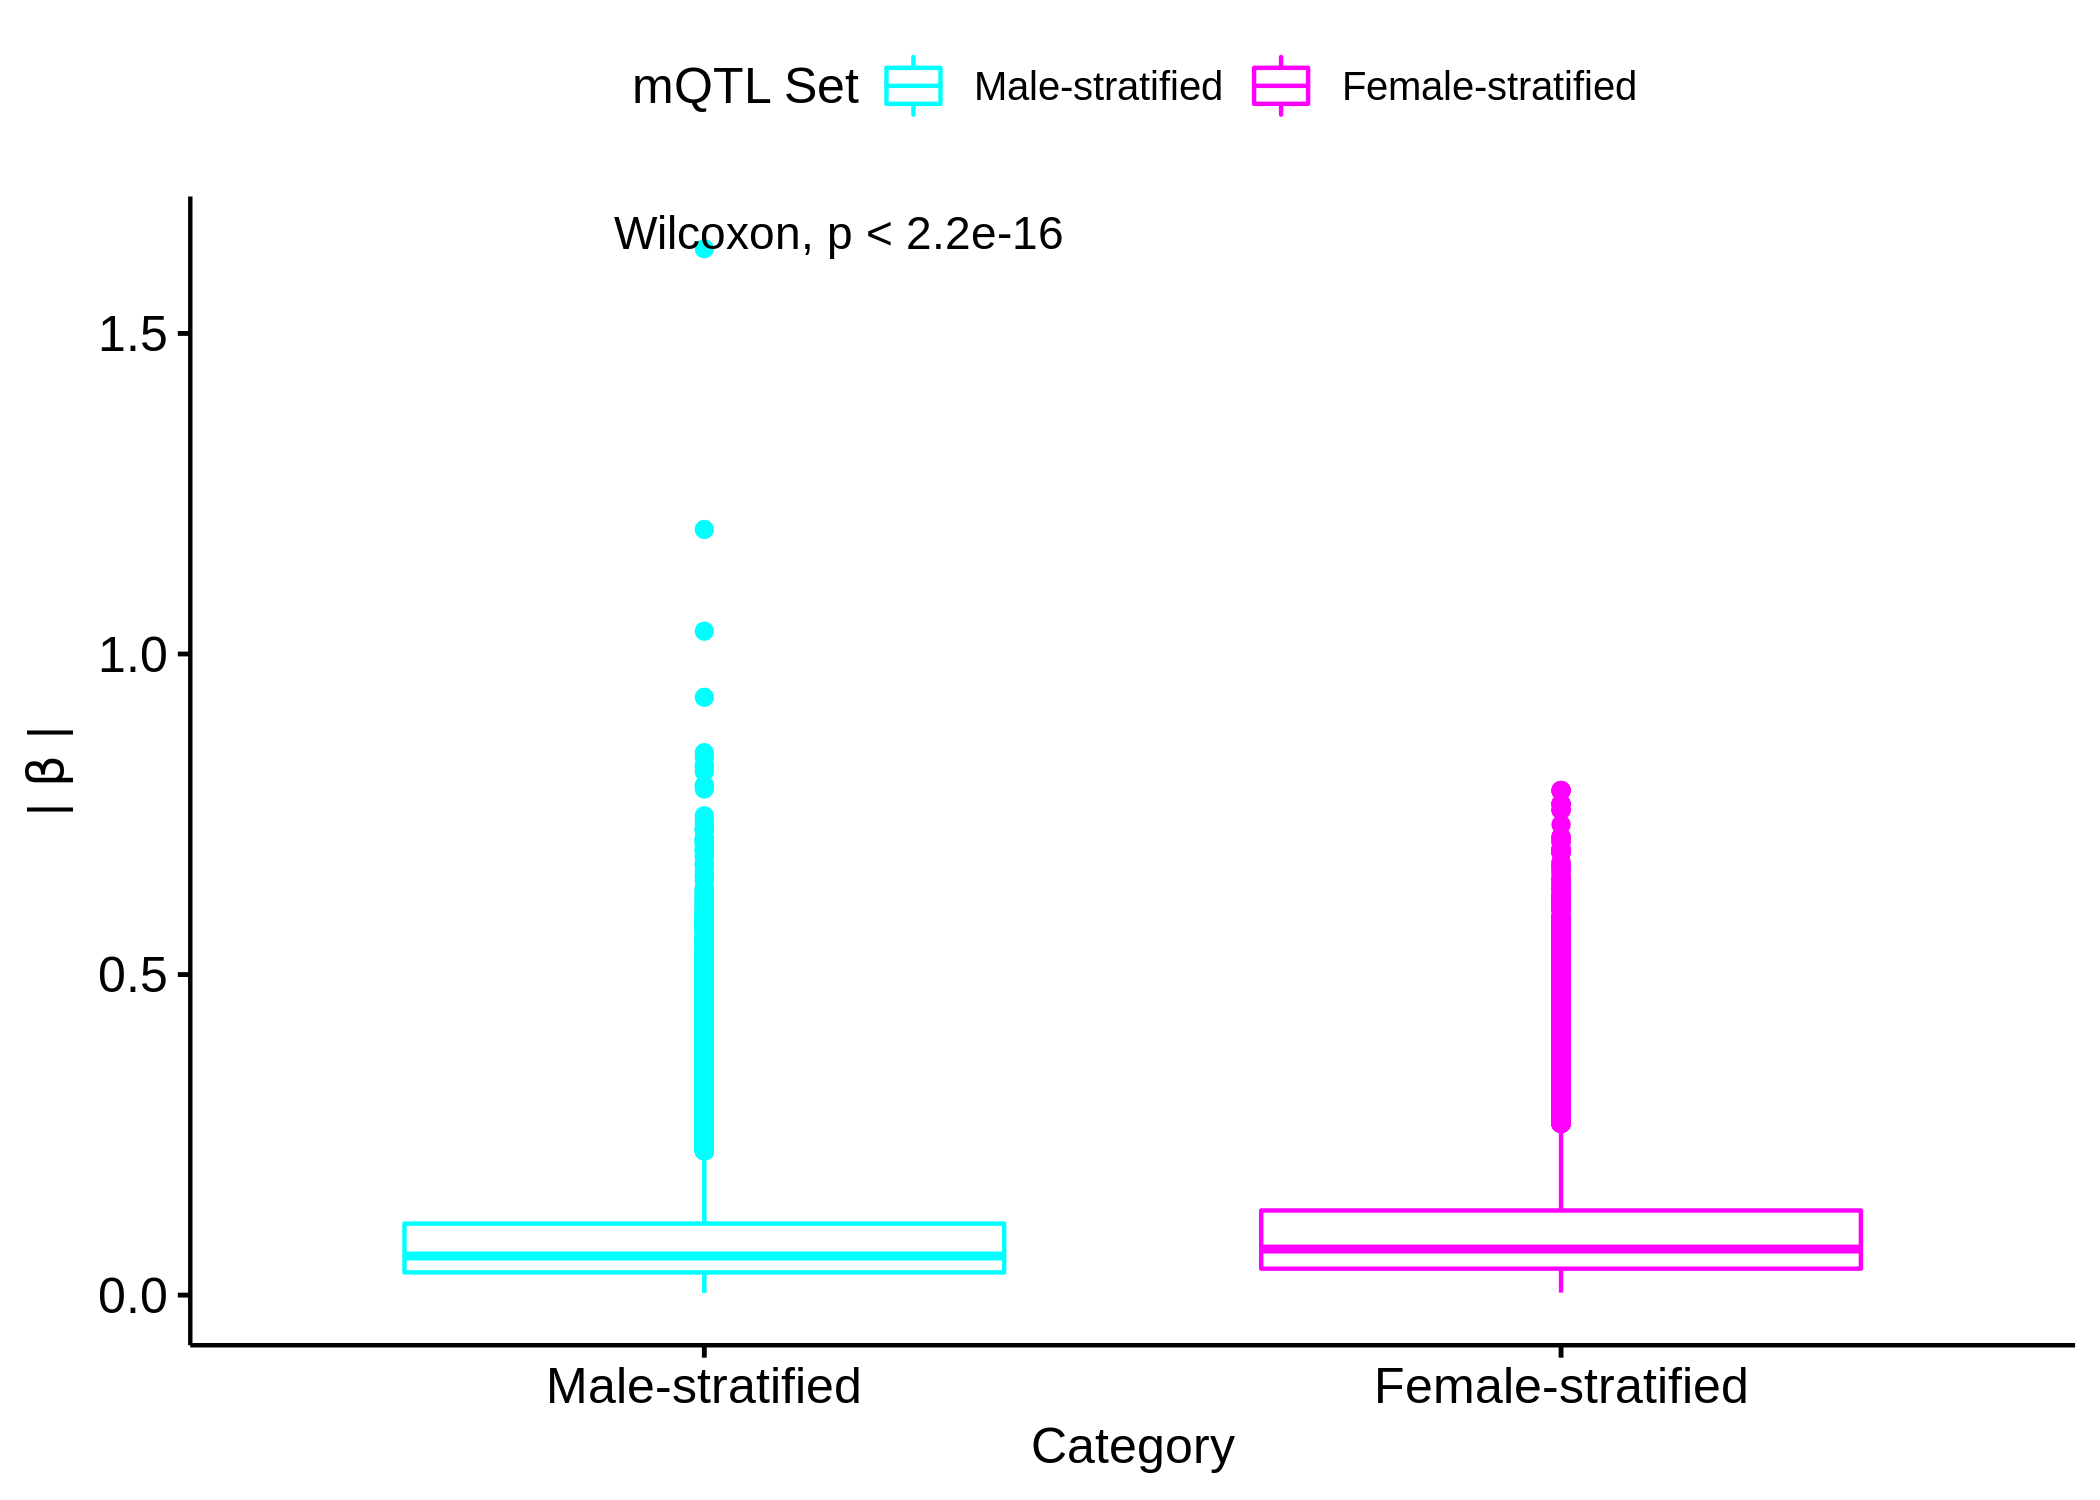

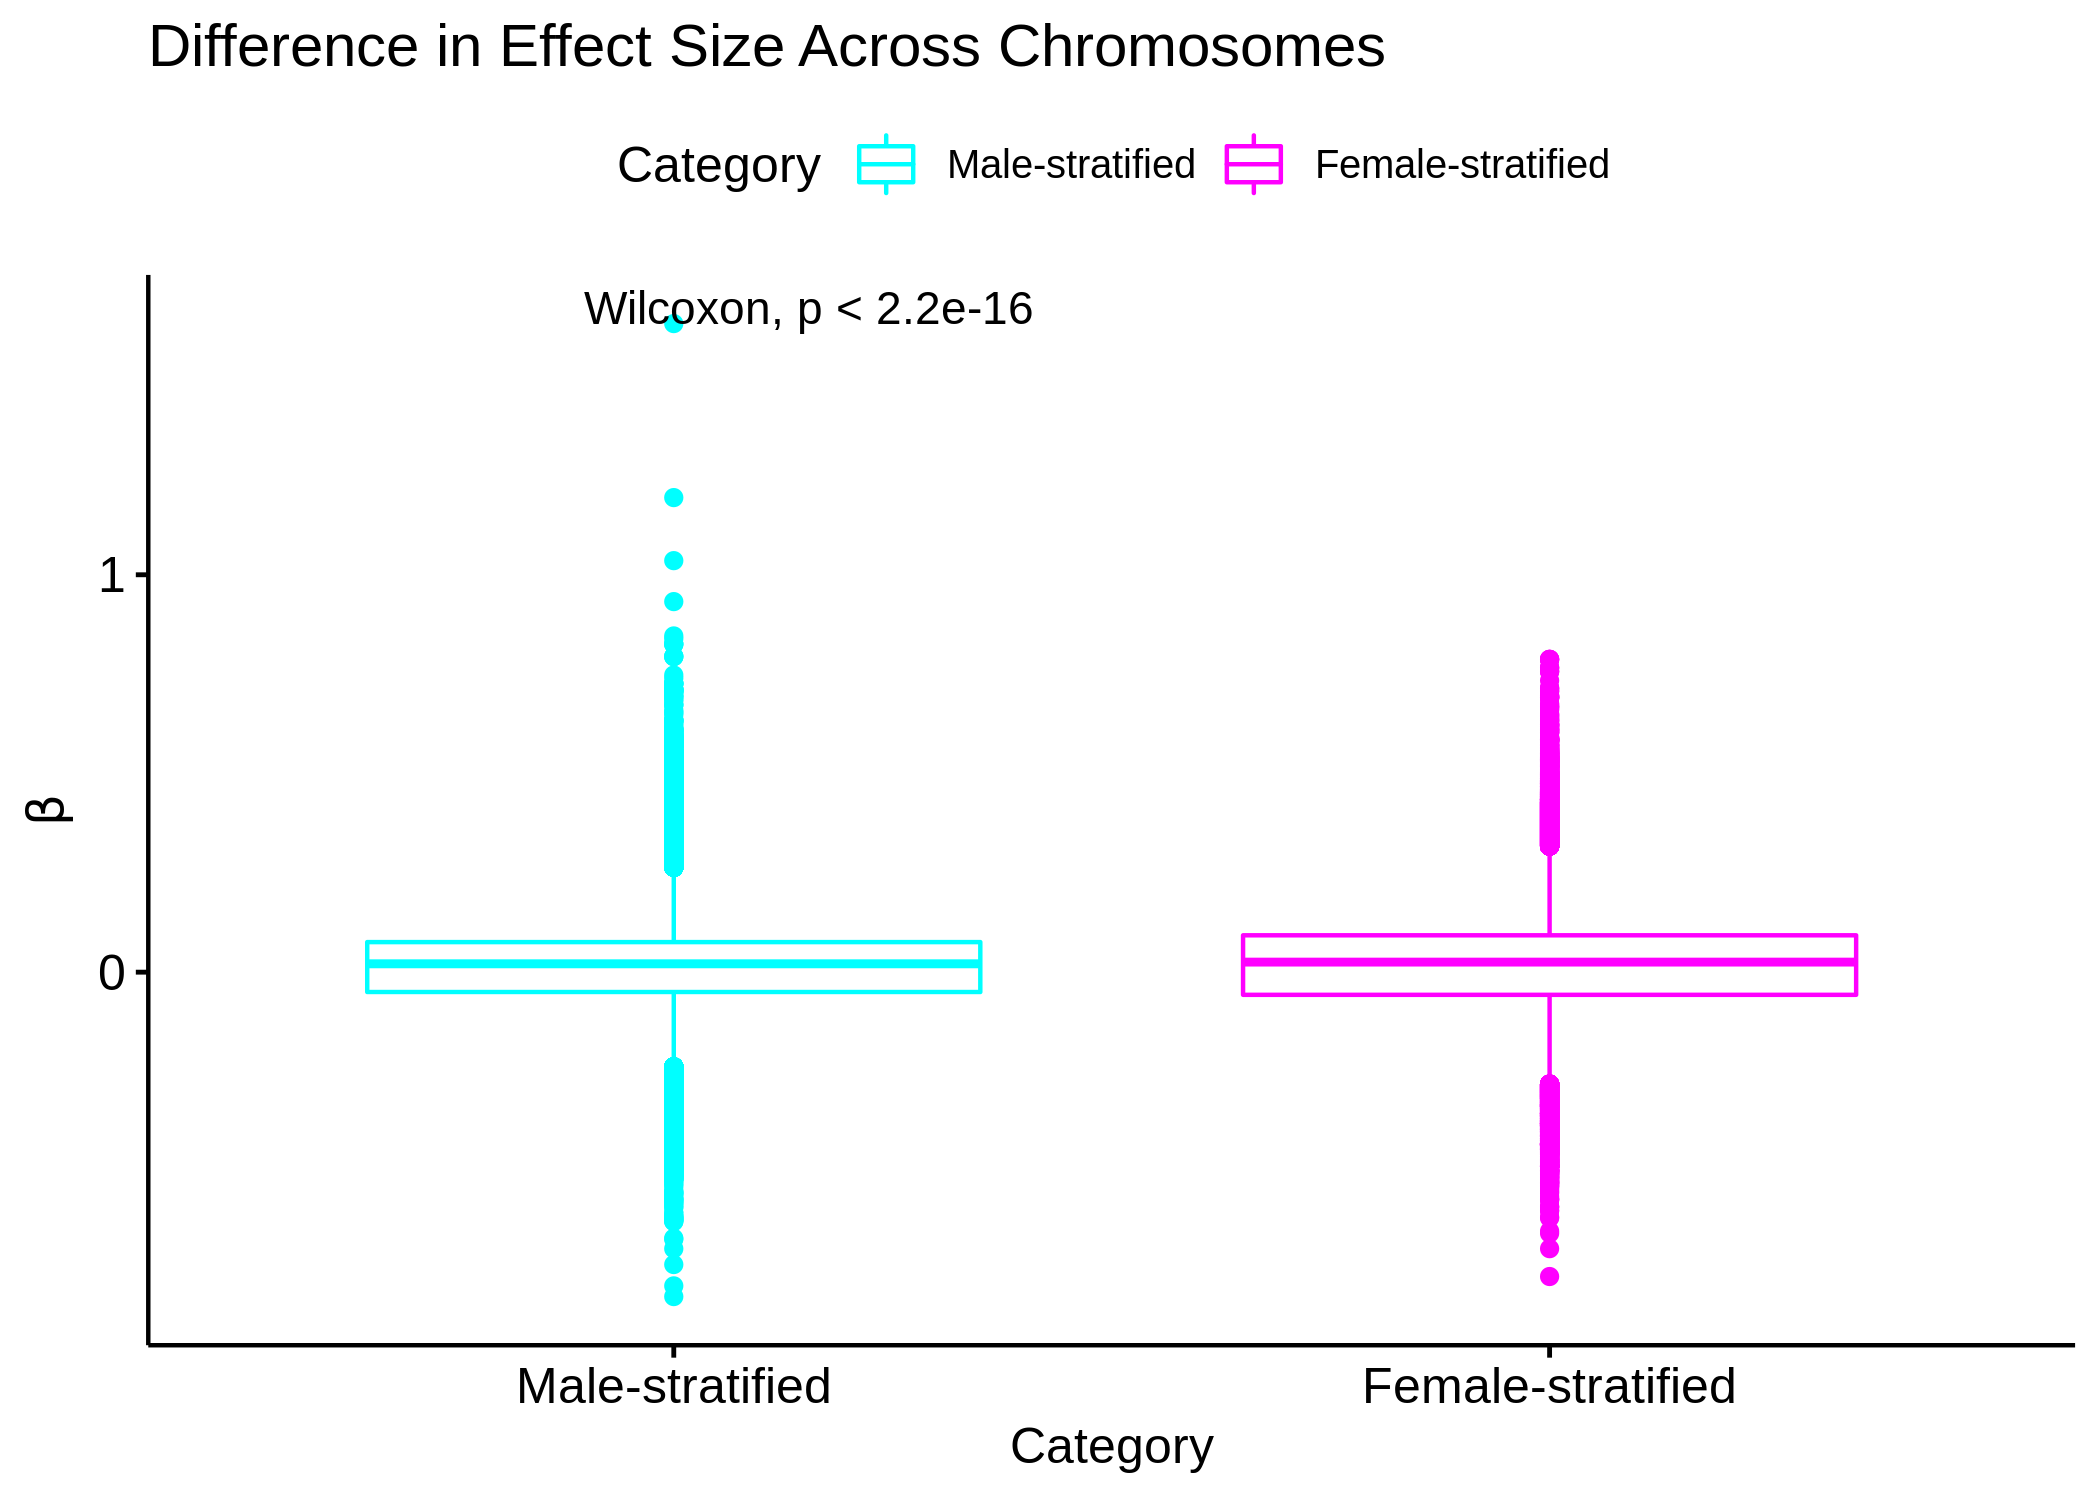

In [18]:
library(ggpubr)
signif.num <- function(x) {
    symnum(x, corr = FALSE, na = FALSE, legend = FALSE,
           cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1), 
           symbols = c("***", "**", "*", ".", " "))
}
ggboxplot(
    sex_strat_effect_dt[,.(Chr,Category,b=abs(b))],
    x="Chr",
    y='b',
    color="Category",
    palette=c("cyan", "magenta")
) +
    stat_compare_means(aes(group=Category,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote("|"~beta~"|"), color="mQTL Set")
ggboxplot(
    sex_strat_effect_dt,
    x="Chr",
    y='b',
    color="Category",
    palette=c("cyan", "magenta")
) +
    stat_compare_means(aes(group=Category,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote(beta), title="Difference in Effect Size by Chromosome")


ggboxplot(
    sex_strat_effect_dt[,.(Chr,Category,b=abs(b))],
    x="Category",
    y='b',
    color="Category",
    palette=c("cyan", "magenta")
) +
    stat_compare_means()+
    labs(y=bquote("|"~beta~"|"),color="mQTL Set")
ggboxplot(
    sex_strat_effect_dt[,.(Chr,Category,b=b)],
    x="Category",
    y='b',
    color="Category",
    palette=c("cyan", "magenta")
) +
    stat_compare_means()+
    labs(y=bquote(beta), title="Difference in Effect Size Across Chromosomes")

In [19]:
compare_means(b~Category,sex_strat_effect_dt, group.by = "Chr")
compare_means(b~Category,sex_strat_effect_dt[,.(Chr,Category,b=abs(b))], group.by = "Chr")
compare_means(b~Category,sex_strat_effect_dt[,.(Chr,Category,b)])
compare_means(b~Category,sex_strat_effect_dt[,.(Chr,Category,b=abs(b))]) 

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
   .y.
1  b  
2  b  
3  b  
4  b  
5  b  
6  b  
7  b  
8  b  
9  b  
10 b  
11 b  
12 b  
13 b  
14 b  
15 b  
16 b  
17 b  
18 b  
19 b  
20 b  
21 b  
22 b  
23 b  
   group1         
1  Male-stratified
2  Male-stratified
3  Male-stratified
4  Male-stratified
5  Male-stratified
6  Male-stratified
7  Male-stratified
8  Male-stratified
9  Male-stratified
10 Male-stratified
11 Male-stratified
12 Male-stratified
13 Male-stratified
14 Male-stratified
15 Male-stratified
16 Male-stratified
17 Male-stratified
18 Male-stratified
19 Male-stratified
20 Male-stratified
21 Male-stratified
22 Male-stratified
23 Male-stratified
   group2           
1  Female-stratified
2  Female-stratified
3  Female-stratified
4  Female-stratified
5  Female-stratified
6  Female-stratified
7  Female-stratified
8  Female-stratified
9  Female-stratified
10 Female-stratified
11 Female-stratified
12 Female-stratified
13 Female-stratified
14 Female-stratified
15 Female-stratified
16 Female-stratified
17 Female-stratified
18 Female-stratified
19 Female-stratified
20 Female-stratified
21 Female-stratified
22 Female-stratified
23 Female-stratified
   p           
1  1.015363e-28
2  3.809685e-12
3  7.601067e-23
4  6.911313e-19
5  2.549056e-16
6  8.869276e-26
7  7.653119e-19
8  1.341514e-07
9  5.648161e-14
10 7.616845e-04
11 1.879986e-20
12 3.201395e-06
13 5.160947e-07
14 1.484768e-10
15 1.032228e-06
16 5.725618e-09
17 6.675629e-78
18 4.240225e-05
19 0.000000e+00
20 1.549412e-08
21 1.547367e-01
22 6.276450e-29
23 1.580572e-47
   p.adj  
1  1.9e-27
2  4.2e-11
3  1.3e-21
4  1.0e-17
5  3.3e-15
6  1.6e-24
7  1.1e-17
8  9.4e-07
9  6.8e-13
10 1.5e-03
11 3.0e-19
12 1.3e-05
13 3.1e-06
14 1.5e-09
15 5.2e-06
16 5.2e-08
17 1.5e-76
18 1.3e-04
19 0.0e+00
20 1.2e-07
21 1.5e-01
22 1.3e-27
23 3.3e-46
   p.format
1  < 2e-16 
2  3.8e-12 
3  < 2e-16 
4  < 2e-16 
5  2.5e-16 
6  < 2e-16 
7  < 2e-16 
8  1.3e-07 
9  5.6e-14 
10 0.00076 
11 < 2e-16 
12 3.2e-06 
13 5.2e-07 
14 1.5e-10 
15 1.0e-06 
16 5.7e-09 
17 < 2e-16 
18 4.2e-05 
19 < 2e-16 
20 1.5e-08 
21 0.15474 
22 < 2e-16 
23 < 2e-16 
   p.signif
1  ****    
2  ****    
3  ****    
4  ****    
5  ****    
6  ****    
7  ****    
8  ****    
9  ****    
10 ***     
11 ****    
12 ****    
13 ****    
14 ****    
15 ****    
16 ****    
17 ****    
18 ****    
19 ****    
20 ****    
21 ns      
22 ****    
23 ****    
   method  
1  Wilcoxon
2  Wilcoxon
3  Wilcoxon
4  Wilcoxon
5  Wilcoxon
6  Wilcoxon
7  Wilcoxon
8  Wilcoxon
9  Wilcoxon
10 Wilcoxon
11 Wilcoxon
12 Wilcoxon
13 Wilcoxon
14 Wilcoxon
15 Wilcoxon
16 Wilcoxon
17 Wilcoxon
18 Wilcoxon
19 Wilcoxon
20 Wilcoxon
21 Wilcoxon
22 Wilcoxon
23 Wilcoxon

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
   .y.
1  b  
2  b  
3  b  
4  b  
5  b  
6  b  
7  b  
8  b  
9  b  
10 b  
11 b  
12 b  
13 b  
14 b  
15 b  
16 b  
17 b  
18 b  
19 b  
20 b  
21 b  
22 b  
23 b  
   group1         
1  Male-stratified
2  Male-stratified
3  Male-stratified
4  Male-stratified
5  Male-stratified
6  Male-stratified
7  Male-stratified
8  Male-stratified
9  Male-stratified
10 Male-stratified
11 Male-stratified
12 Male-stratified
13 Male-stratified
14 Male-stratified
15 Male-stratified
16 Male-stratified
17 Male-stratified
18 Male-stratified
19 Male-stratified
20 Male-stratified
21 Male-stratified
22 Male-stratified
23 Male-stratified
   group2           
1  Female-stratified
2  Female-stratified
3  Female-stratified
4  Female-stratified
5  Female-stratified
6  Female-stratified
7  Female-stratified
8  Female-stratified
9  Female-stratified
10 Female-stratified
11 Female-stratified
12 Female-stratified
13 Female-stratified
14 Female-stratified
15 Female-stratified
16 Female-stratified
17 Female-stratified
18 Female-stratified
19 Female-stratified
20 Female-stratified
21 Female-stratified
22 Female-stratified
23 Female-stratified
   p            
1  1.644390e-192
2  5.279746e-137
3   2.897240e-87
4   5.681461e-33
5   6.821954e-68
6   0.000000e+00
7  6.927355e-237
8   4.520259e-91
9   7.222859e-34
10  1.201035e-50
11  8.045014e-36
12  8.362178e-64
13  4.001416e-39
14  1.539115e-58
15  8.161258e-44
16 7.547587e-135
17 1.710836e-101
18  5.679922e-30
19  0.000000e+00
20  1.583336e-32
21  5.467490e-64
22  1.412333e-46
23 1.154535e-147
   p.adj   
1  3.3e-191
2  9.5e-136
3   4.1e-86
4   1.7e-32
5   8.9e-67
6   0.0e+00
7  1.5e-235
8   6.8e-90
9   2.9e-33
10  1.1e-49
11  4.0e-35
12  9.2e-63
13  2.4e-38
14  1.5e-57
15  5.7e-43
16 1.3e-133
17 2.7e-100
18  5.7e-30
19  0.0e+00
20  3.2e-32
21  6.6e-63
22  1.1e-45
23 2.2e-146
   p.format
1  <2e-16  
2  <2e-16  
3  <2e-16  
4  <2e-16  
5  <2e-16  
6  <2e-16  
7  <2e-16  
8  <2e-16  
9  <2e-16  
10 <2e-16  
11 <2e-16  
12 <2e-16  
13 <2e-16  
14 <2e-16  
15 <2e-16  
16 <2e-16  
17 <2e-16  
18 <2e-16  
19 <2e-16  
20 <2e-16  
21 <2e-16  
22 <2e-16  
23 <2e-16  
   p.signif
1  ****    
2  ****    
3  ****    
4  ****    
5  ****    
6  ****    
7  ****    
8  ****    
9  ****    
10 ****    
11 ****    
12 ****    
13 ****    
14 ****    
15 ****    
16 ****    
17 ****    
18 ****    
19 ****    
20 ****    
21 ****    
22 ****    
23 ****    
   method  
1  Wilcoxon
2  Wilcoxon
3  Wilcoxon
4  Wilcoxon
5  Wilcoxon
6  Wilcoxon
7  Wilcoxon
8  Wilcoxon
9  Wilcoxon
10 Wilcoxon
11 Wilcoxon
12 Wilcoxon
13 Wilcoxon
14 Wilcoxon
15 Wilcoxon
16 Wilcoxon
17 Wilcoxon
18 Wilcoxon
19 Wilcoxon
20 Wilcoxon
21 Wilcoxon
22 Wilcoxon
23 Wilcoxon

.y.
1 b  
  group1         
1 Male-stratified
  group2           
1 Female-stratified
  p           
1 7.219428e-52
  p.adj  
1 7.2e-52
  p.format
1 <2e-16  
  p.signif
1 ****    
  method  
1 Wilcoxon

.y.
1 b  
  group1         
1 Male-stratified
  group2           
1 Female-stratified
  p p.adj
1 0 0    
  p.format
1 <2e-16  
  p.signif
1 ****    
  method  
1 Wilcoxon

In [20]:
sex_strat_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Chr","Category")]
sex_strat_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Category")]

Chr
1  1  
2  2  
3  3  
4  4  
5  5  
6  6  
7  7  
8  8  
9  9  
10 10 
11 11 
12 12 
13 13 
14 14 
15 15 
16 16 
17 17 
18 18 
19 19 
20 20 
21 21 
22 22 
23 X  
24 1  
25 2  
26 3  
27 4  
28 5  
29 6  
30 7  
31 8  
32 9  
33 10 
34 11 
35 12 
36 13 
37 14 
38 15 
39 16 
40 17 
41 18 
42 19 
43 20 
44 21 
45 22 
46 X  
   Category         
1  Male-stratified  
2  Male-stratified  
3  Male-stratified  
4  Male-stratified  
5  Male-stratified  
6  Male-stratified  
7  Male-stratified  
8  Male-stratified  
9  Male-stratified  
10 Male-stratified  
11 Male-stratified  
12 Male-stratified  
13 Male-stratified  
14 Male-stratified  
15 Male-stratified  
16 Male-stratified  
17 Male-stratified  
18 Male-stratified  
19 Male-stratified  
20 Male-stratified  
21 Male-stratified  
22 Male-stratified  
23 Male-stratified  
24 Female-stratified
25 Female-stratified
26 Female-stratified
27 Female-stratified
28 Female-stratified
29 Female-stratified
30 Female-stratified
31 Female-stratified
32 Female-stratified
33 Female-stratified
34 Female-stratified
35 Female-stratified
36 Female-stratified
37 Female-stratified
38 Female-stratified
39 Female-stratified
40 Female-stratified
41 Female-stratified
42 Female-stratified
43 Female-stratified
44 Female-stratified
45 Female-stratified
46 Female-stratified
   mean_beta   
1   0.028515676
2   0.032686976
3   0.029836507
4   0.029080668
5   0.026990584
6   0.015769061
7   0.032030906
8   0.029472633
9   0.038720694
10  0.030075753
11  0.025415745
12  0.032029888
13  0.039199406
14  0.028109258
15  0.029396914
16  0.020402998
17  0.021384245
18  0.025798319
19  0.017617342
20  0.012030617
21  0.008341308
22  0.009909396
23  0.038863998
24  0.037546900
25  0.038276266
26  0.042559584
27  0.038978989
28  0.034066992
29  0.015368351
30  0.041477981
31  0.036393283
32  0.051023784
33  0.035042628
34  0.033976456
35  0.038553523
36  0.048118730
37  0.037804234
38  0.035077467
39  0.026938097
40  0.036583045
41  0.039329734
42 -0.024401625
43  0.016581877
44  0.014170494
45  0.023684798
46  0.115717139
   mean_abs_beta
1  0.08619668   
2  0.09300364   
3  0.09661766   
4  0.08659911   
5  0.08610254   
6  0.10360552   
7  0.09103376   
8  0.09174352   
9  0.09363591   
10 0.08433969   
11 0.08470090   
12 0.08691872   
13 0.09546724   
14 0.08673407   
15 0.09062235   
16 0.07449999   
17 0.08560717   
18 0.08670605   
19 0.08171036   
20 0.07738963   
21 0.08275454   
22 0.06735207   
23 0.09407348   
24 0.09758302   
25 0.10350277   
26 0.11107051   
27 0.09622116   
28 0.09525435   
29 0.11601606   
30 0.10650783   
31 0.10532892   
32 0.10758758   
33 0.09329406   
34 0.09421539   
35 0.09843232   
36 0.10669145   
37 0.10027374   
38 0.10168089   
39 0.08621466   
40 0.09741863   
41 0.09979522   
42 0.10818155   
43 0.08643307   
44 0.09929170   
45 0.07801942   
46 0.22002356

Category         
1 Male-stratified  
2 Female-stratified
  mean_beta 
1 0.02488808
2 0.02959237
  mean_abs_beta
1 0.09055764   
2 0.10286808

## Counting CpG sites


In [21]:
# Read in and check annotation
array_annot <- fread("/scratch/st-dennisjk-1/wcasazza/450k_annotation.csv")
head(array_annot[chr == "chr1"])

V1        
1 cg00000957
2 cg00001349
3 cg00001583
4 cg00002028
5 cg00002719
6 cg00002837
  chr 
1 chr1
2 chr1
3 chr1
4 chr1
5 chr1
6 chr1
  pos      
1   5937253
2 166958439
3 200011786
4  20960010
5 169396706
6  44513358
  strand
1 +     
2 -     
3 -     
4 -     
5 +     
6 -     
  Name      
1 cg00000957
2 cg00001349
3 cg00001583
4 cg00002028
5 cg00002719
6 cg00002837
  AddressA
1 65648367
2 11722421
3 55630379
4 56738397
5 52741444
6 45703447
  AddressB
1 36743439
2 53758324
3 24638471
4 74621430
5 27736432
6 25764310
  ProbeSeqA                                         
1 ATACTACTAACCCATACCCAACAAAACAAAAAACCCCAAAACATCAACCA
2 CAAAACAACACAAACCAAAATCTTCCAATCTCAAACTATTTATTCCCCCA
3 ACAAAAAATAAAACCTAAACAAAAACCTAATACACCCACAAATTTCACCA
4 CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAACAACA
5 CAATAATCTAAAAATATTACATACACCTACACAAATTTTTATCACTCTCA
6 ATCATAAAAACATCCTACCCTAAAACCAAAAATTTAAAAATAAAAACACA
  ProbeSeqB                                         
1 ATACTACTAACCCATACCCGACAAAACAAAAAACCCCAAAACGTCAACCG
2 CAAAACGACACGAACCGAAATCTTCCAATCTCAAACTATTTATTCCCCCG
3 ACAAAAAATAAAACCTAAACGAAAACCTAATACGCCCACGAATTTCGCCG
4 CCCAAATTTATTATAACCGACGAAAAACGCCGATAATAACGACAACGACG
5 CGATAATCTAAAAATATTACATACGCCTACGCAAATTTTTATCGCTCTCG
6 ATCGTAAAAACATCCTACCCTAAAACCAAAAATTTAAAAATAAAAACACG
  Type ⋯
1 I    ⋯
2 I    ⋯
3 I    ⋯
4 I    ⋯
5 I    ⋯
6 I    ⋯
  UCSC_RefGene_Name
1 NPHP4            
2 MAEL             
3 NR5A2;NR5A2      
4 PINK1;PINK1      
5 C1orf114         
6                  
  UCSC_RefGene_Accession
1 NM_015102             
2 NM_032858             
3 NM_205860;NM_003822   
4 NM_032409;NM_032409   
5 NM_021179             
6                       
  UCSC_RefGene_Group
1 Body              
2 TSS200            
3 Body;Body         
4 1stExon;5'UTR     
5 TSS200            
6                   
  Phantom                   
1                           
2                           
3                           
4 high-CpG:20832533-20832876
5                           
6                           
  DMR
1    
2    
3    
4    
5    
6    
  Enhancer
1   NA    
2   NA    
3   NA    
4   NA    
5 TRUE    
6   NA    
  HMM_Island           
1 1:5859745-5859915    
2 1:165224845-165225561
3 1:198278176-198278678
4 1:20832399-20833138  
5 1:167663071-167663470
6                      
  Regulatory_Feature_Name
1 1:5937082-5937731      
2                        
3                        
4 1:20959206-20960060    
5                        
6 1:44512719-44514060    
  Regulatory_Feature_Group       
1 Unclassified_Cell_type_specific
2                                
3                                
4 Promoter_Associated            
5                                
6 Unclassified                   
  DHS 
1   NA
2   NA
3   NA
4   NA
5   NA
6 TRUE

In [22]:
sex_effect_dt$Sex <- sex_effect_dt$Category

annotated_dt_sex <- sex_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]
annotated_dt_marginal <- marginal[array_annot,on=c("Probe"="Name"),nomatch=0]
annotated_dt_sex$Sex <- "Sex-dependent"
annotated_dt_marginal$Sex <- "Cross-sex"

total_annotated <- rbindlist(list(annotated_dt_sex,annotated_dt_marginal,sex_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]),fill=TRUE)
total_annotated$Sex <- factor(total_annotated$Sex,levels=c("Male-specific","Female-specific","Sex-dependent", "Cross-sex"))

sex_strat_effect_dt$Sex <- sex_strat_effect_dt$Category
annotated_dt_sex_strat <- sex_strat_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]
annotated_dt_sex_strat$Sex <- "Sex-dependent"

total_annotated_strat <- rbindlist(list(annotated_dt_sex_strat,annotated_dt_marginal,sex_strat_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]),fill=TRUE)
total_annotated_strat$Sex <- factor(total_annotated_strat$Sex,levels=c("Male-stratified","Female-stratified","Sex-dependent", "Cross-sex"))

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



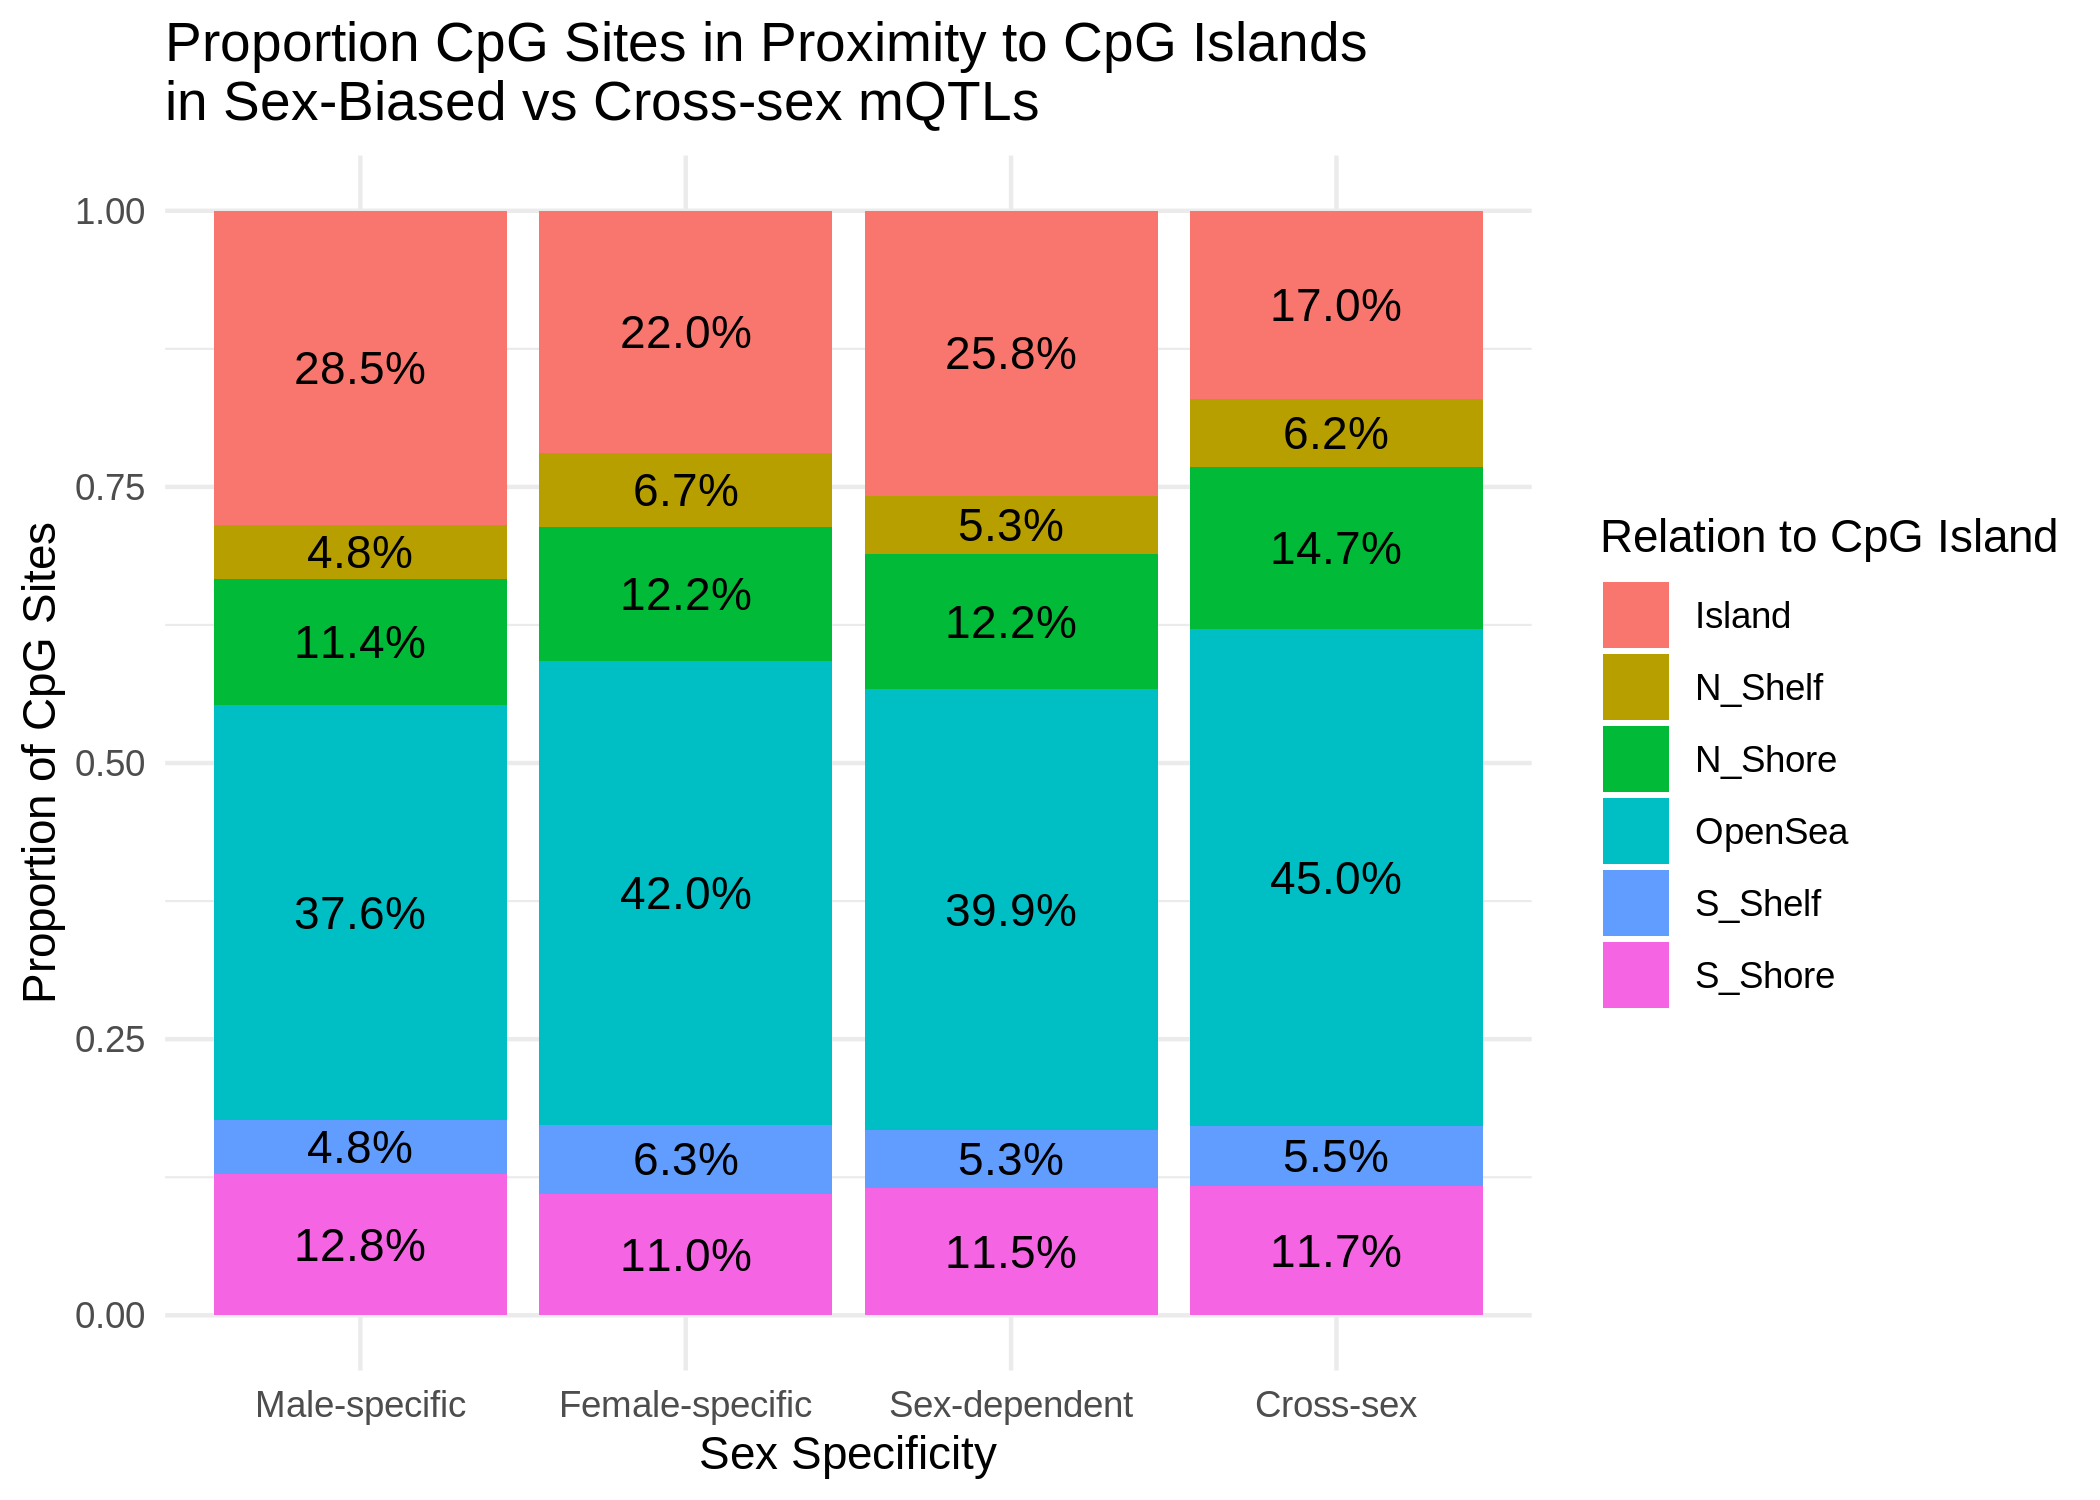

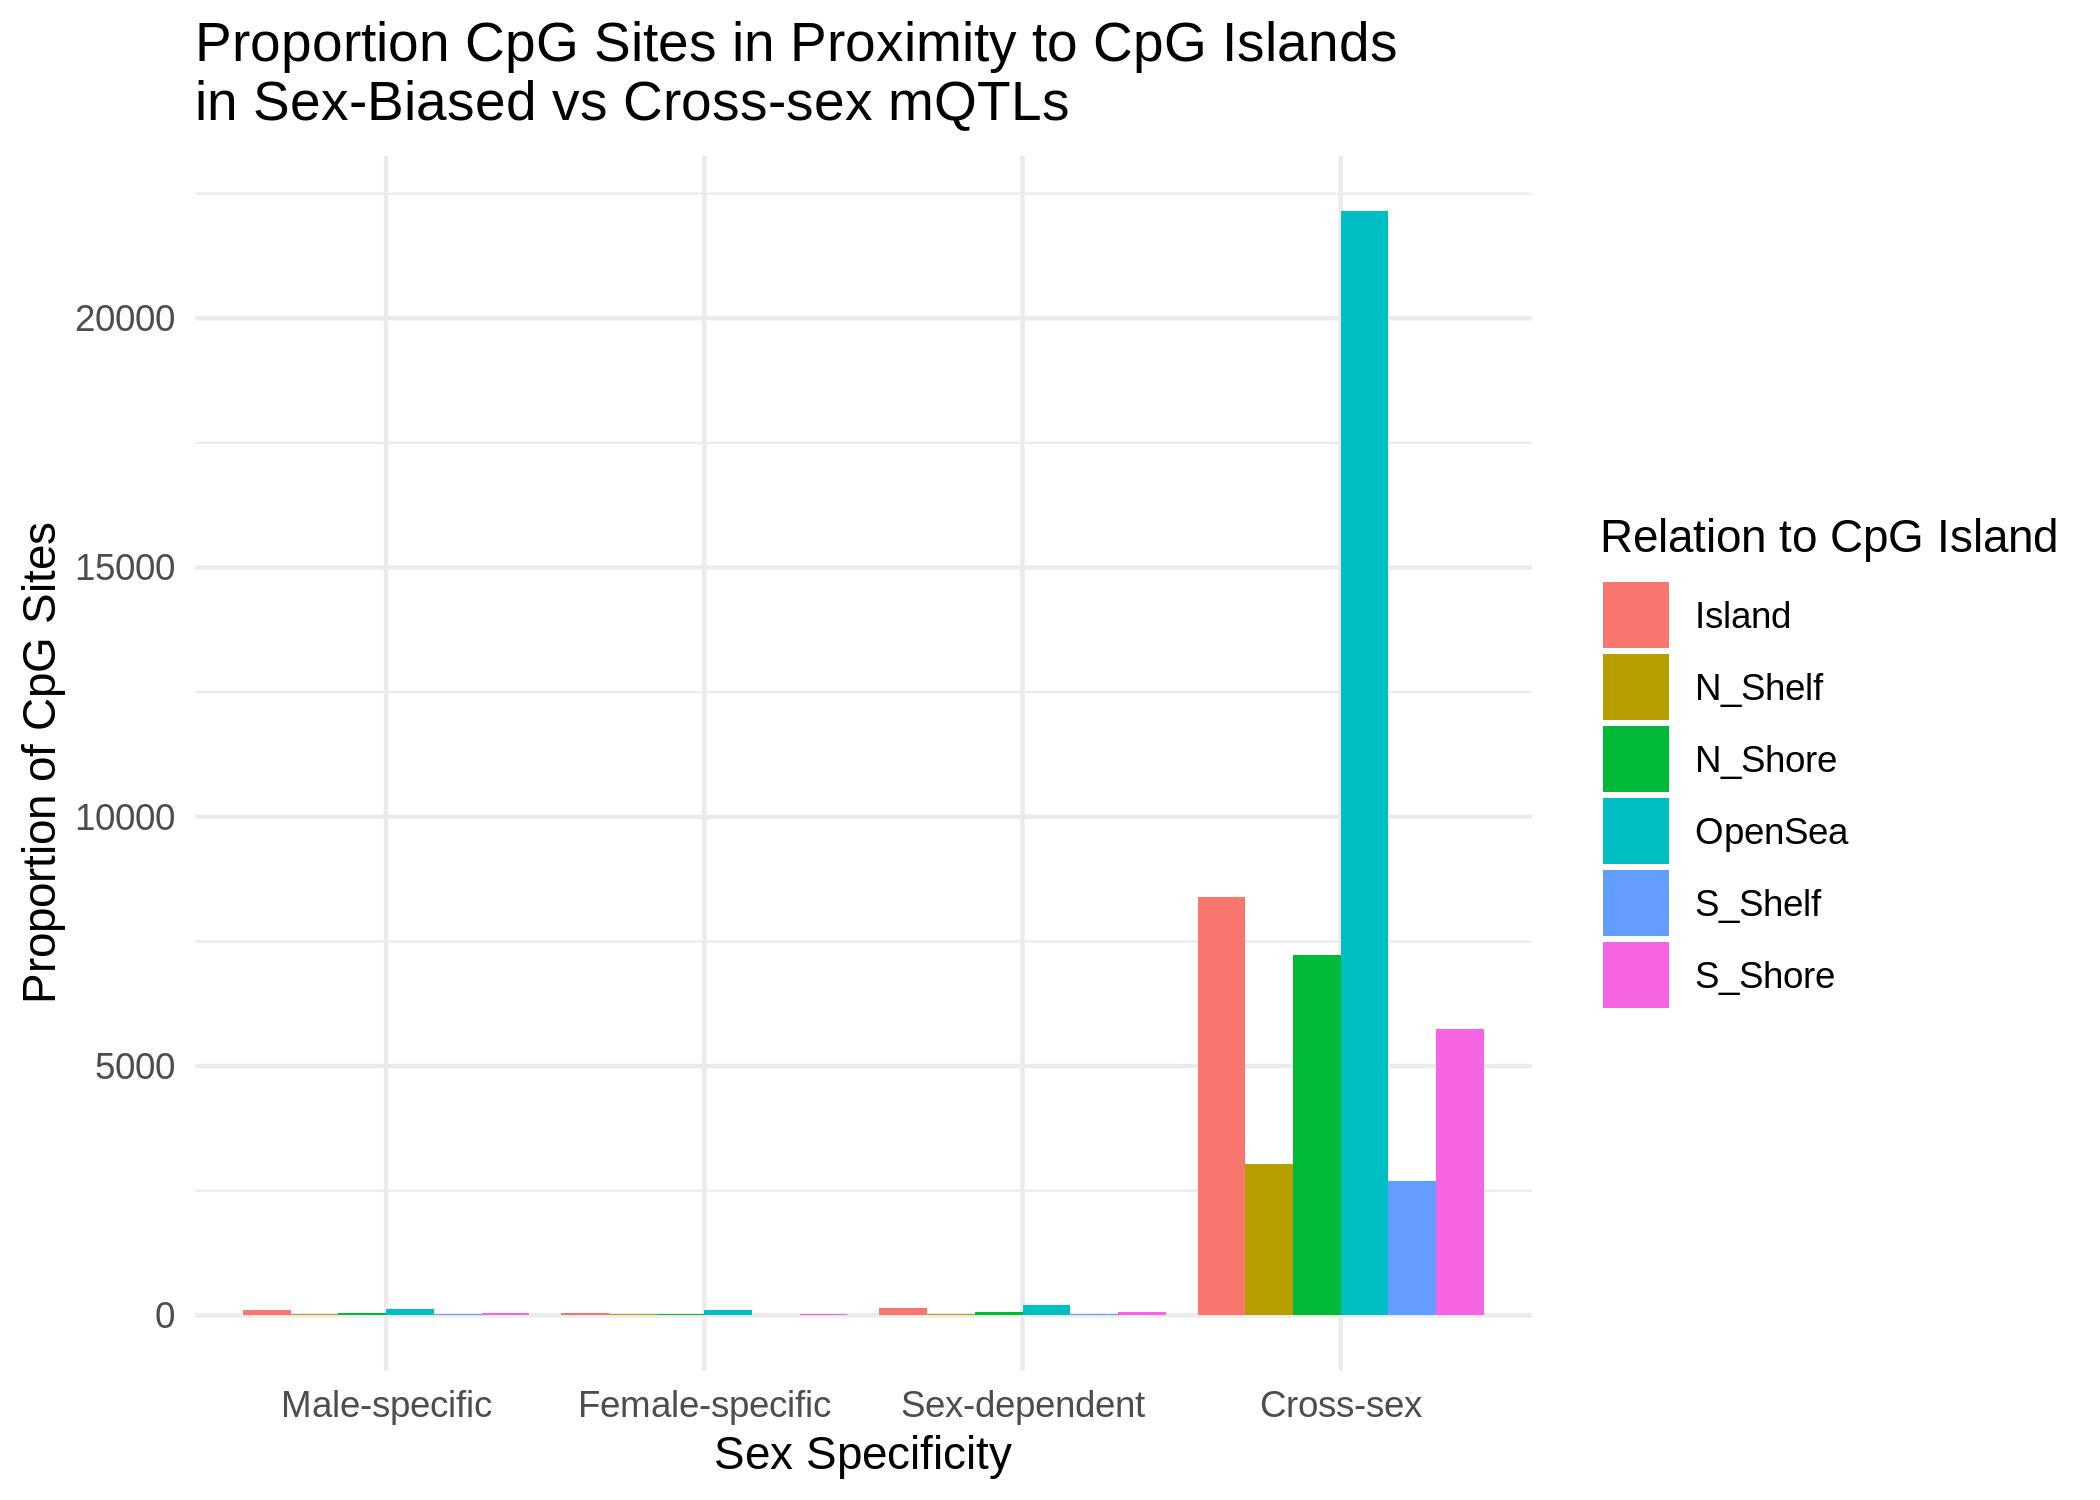

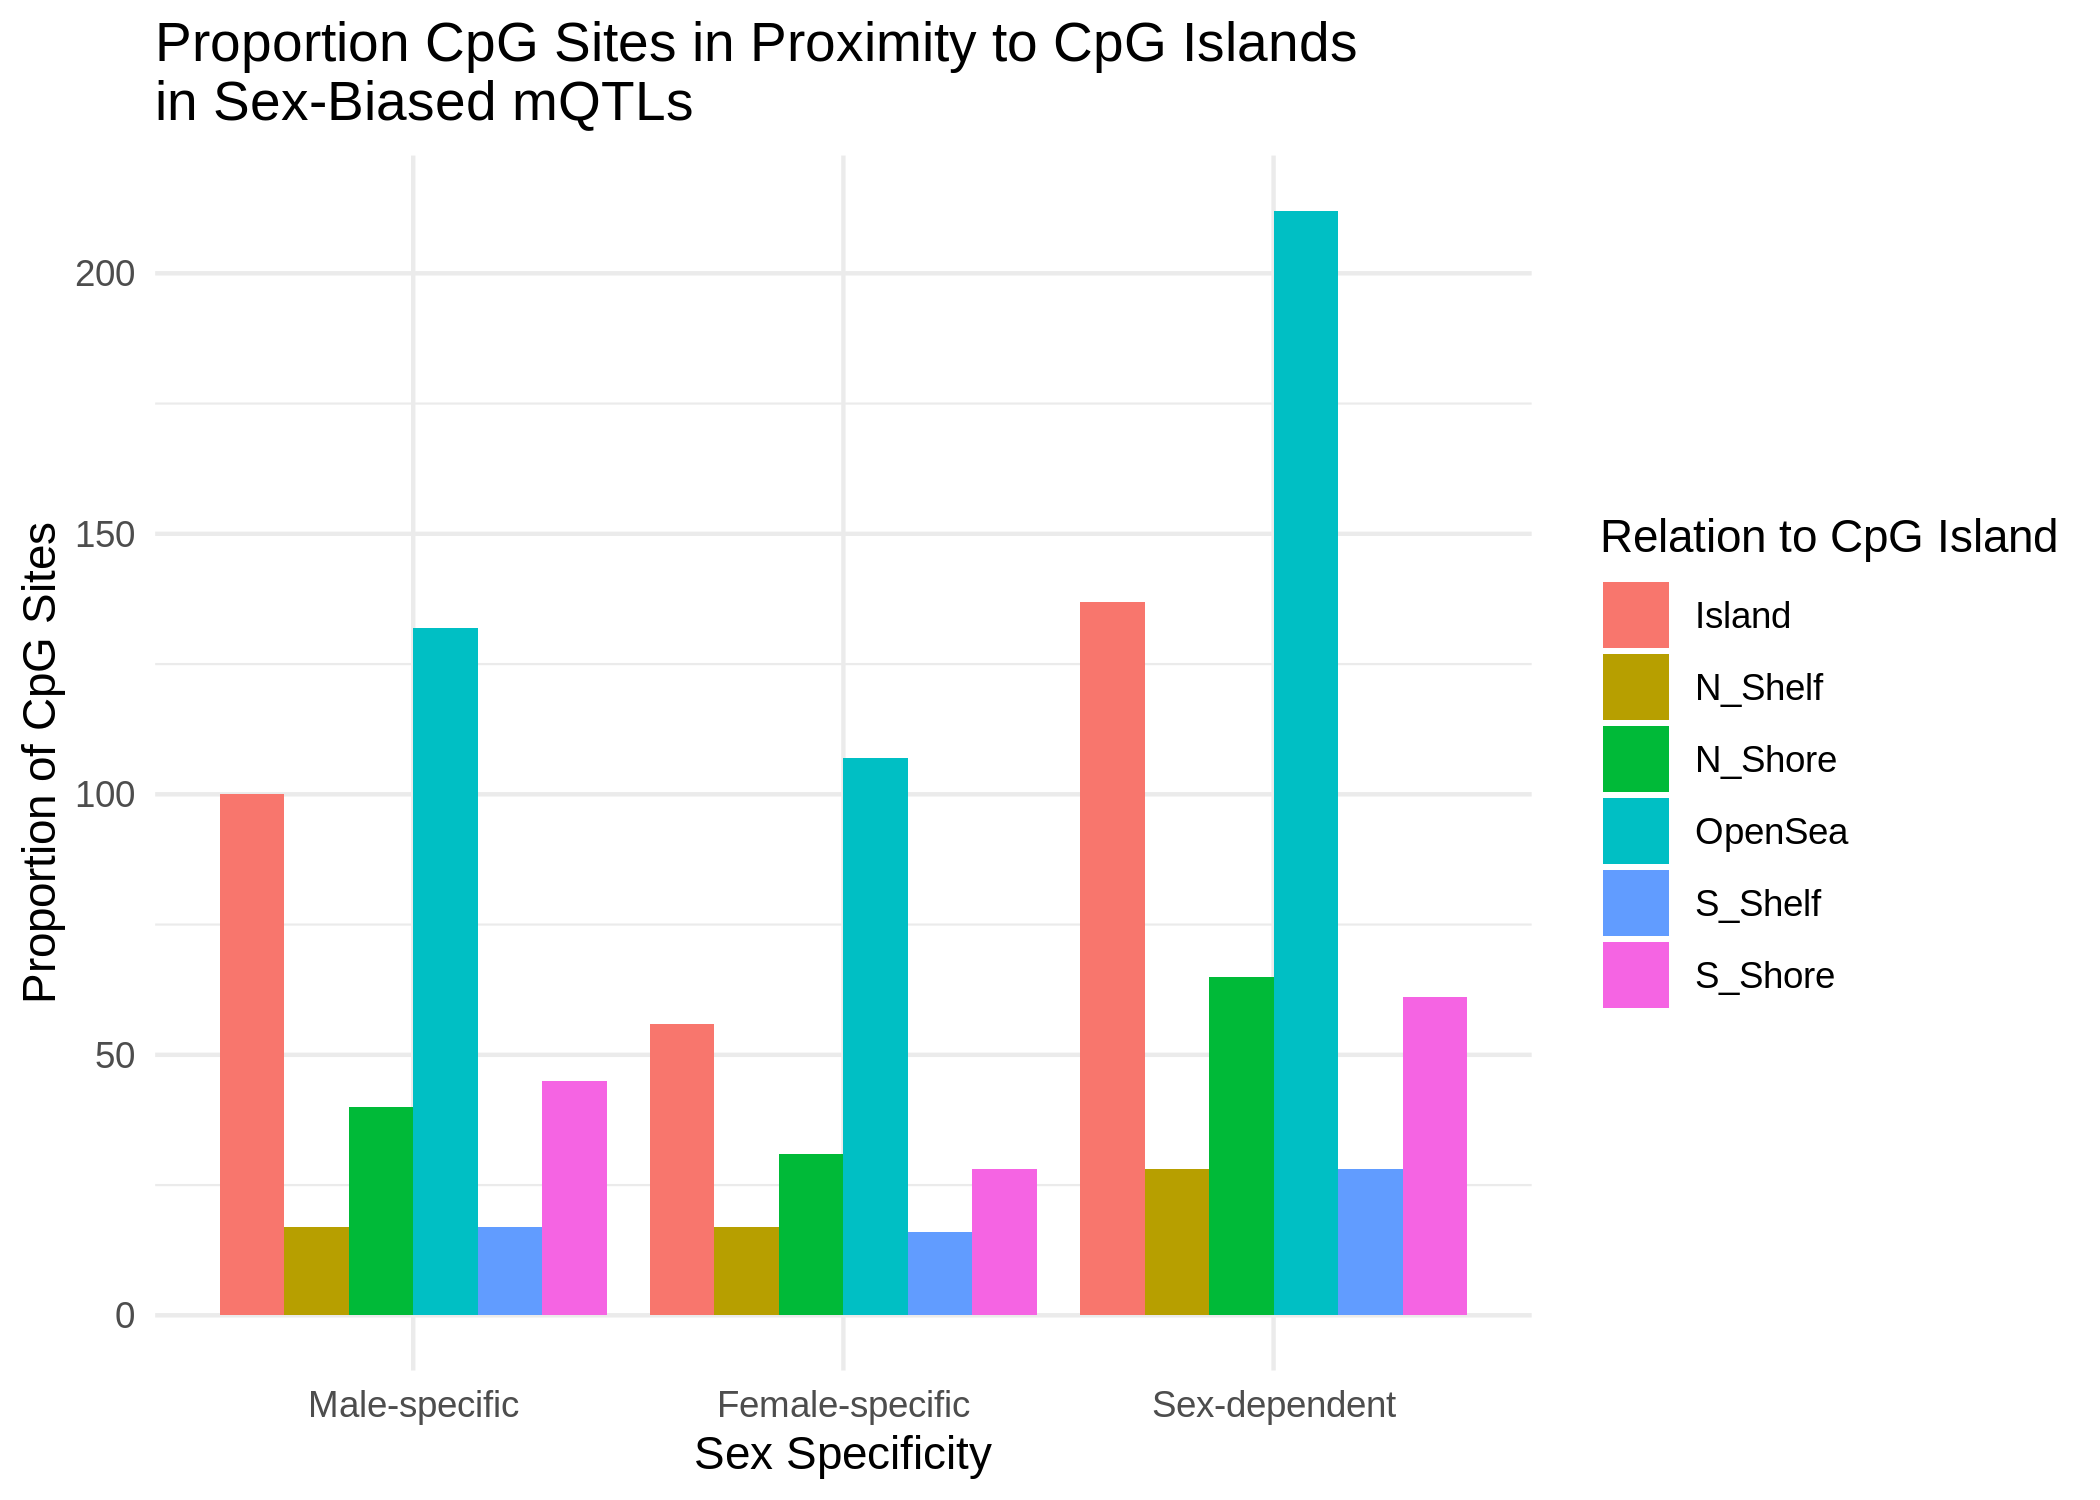

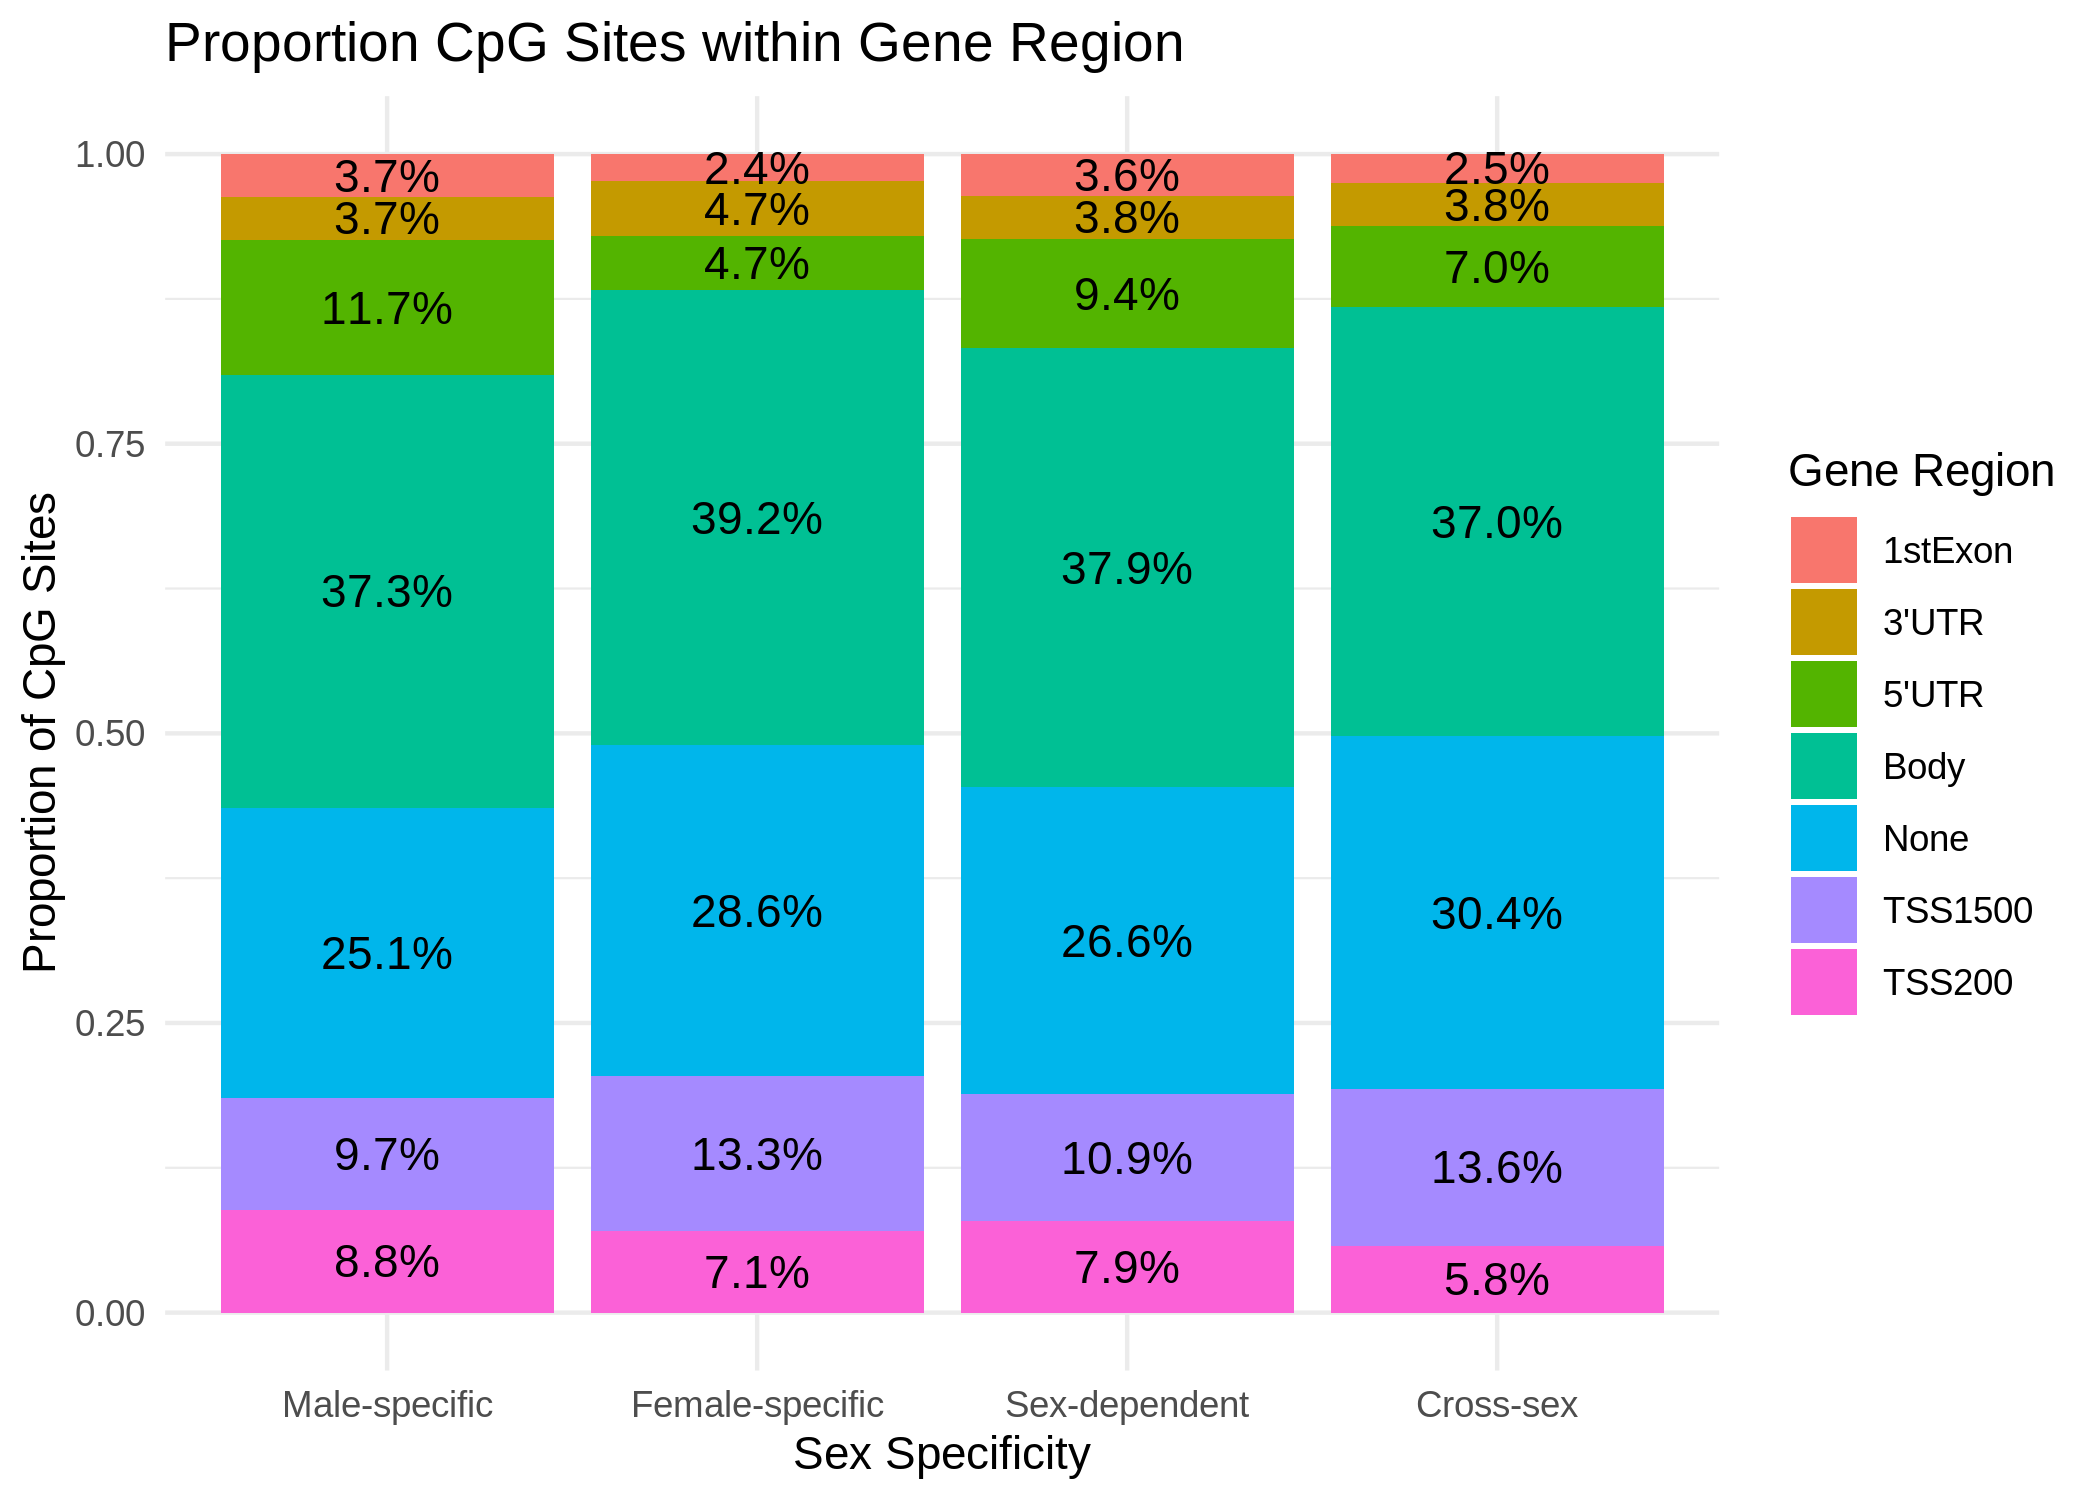

In [23]:
library(GGally)
ggplot(total_annotated[!duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = factor(Relation_to_Island), by = factor(Sex))) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Cross-sex mQTLs")

ggplot(total_annotated[!duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Cross-sex mQTLs")

ggplot(total_annotated[Sex != "Cross-sex" & !duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased mQTLs")
ggplot(total_annotated[!duplicated(total_annotated[,.(Probe,Sex)])],aes(Sex, fill = factor(sapply(gsub(";.*","",UCSC_RefGene_Group),function(x)ifelse(x == "","None",x))), by = factor(Sex))) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Gene Region")+
    ggtitle("Proportion CpG Sites within Gene Region")

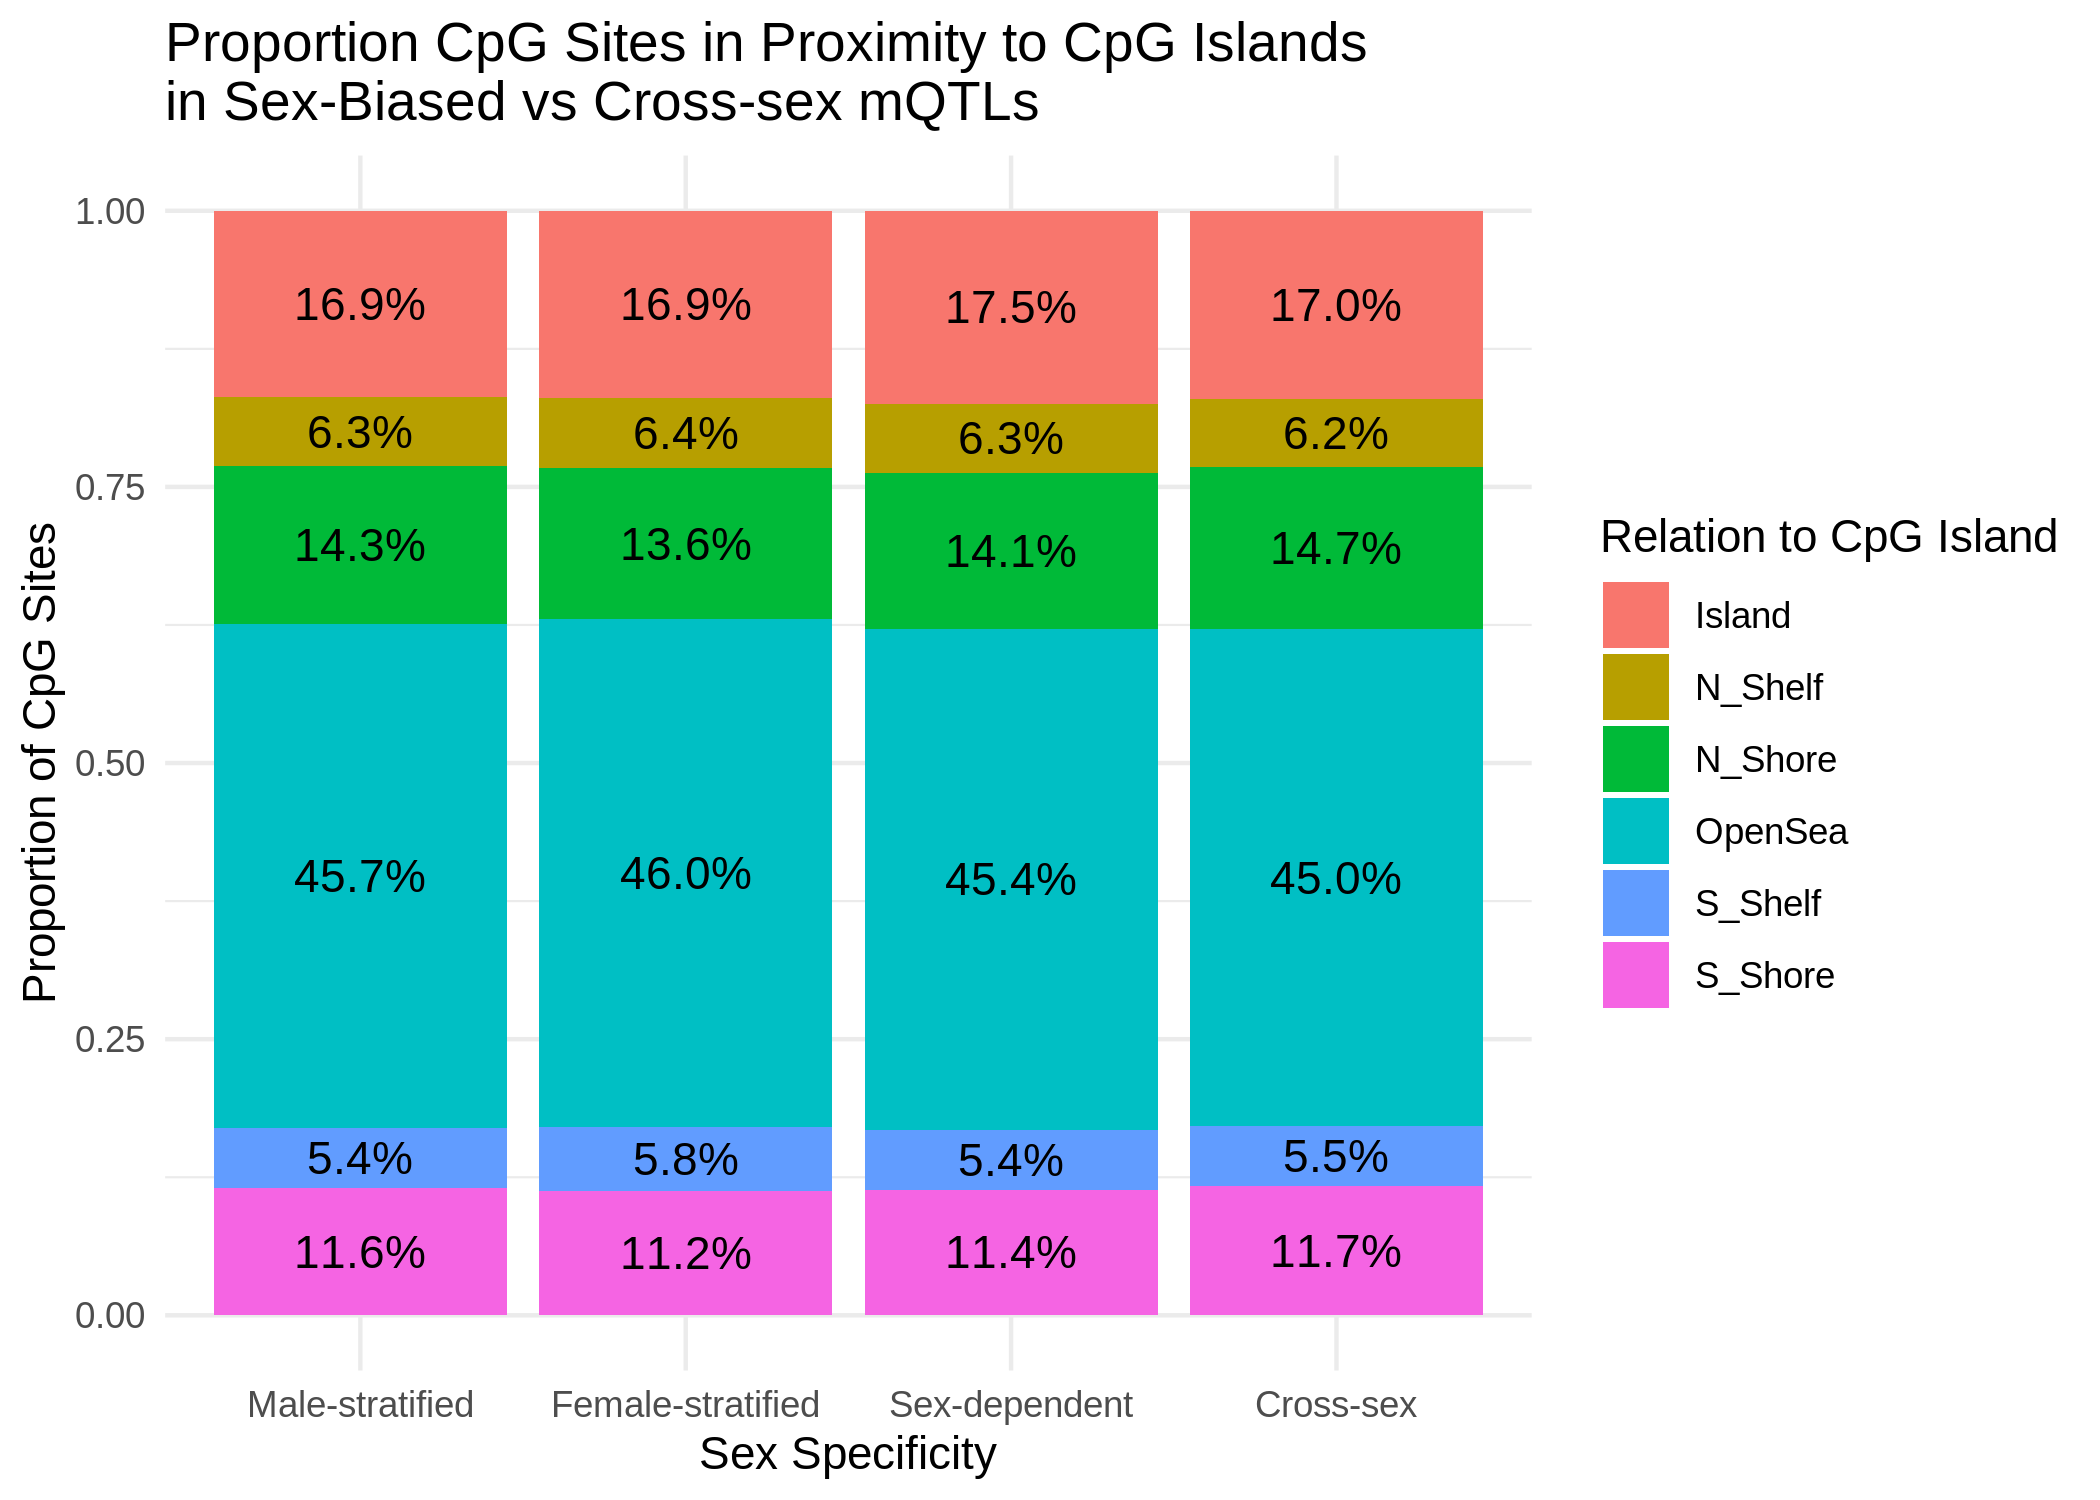

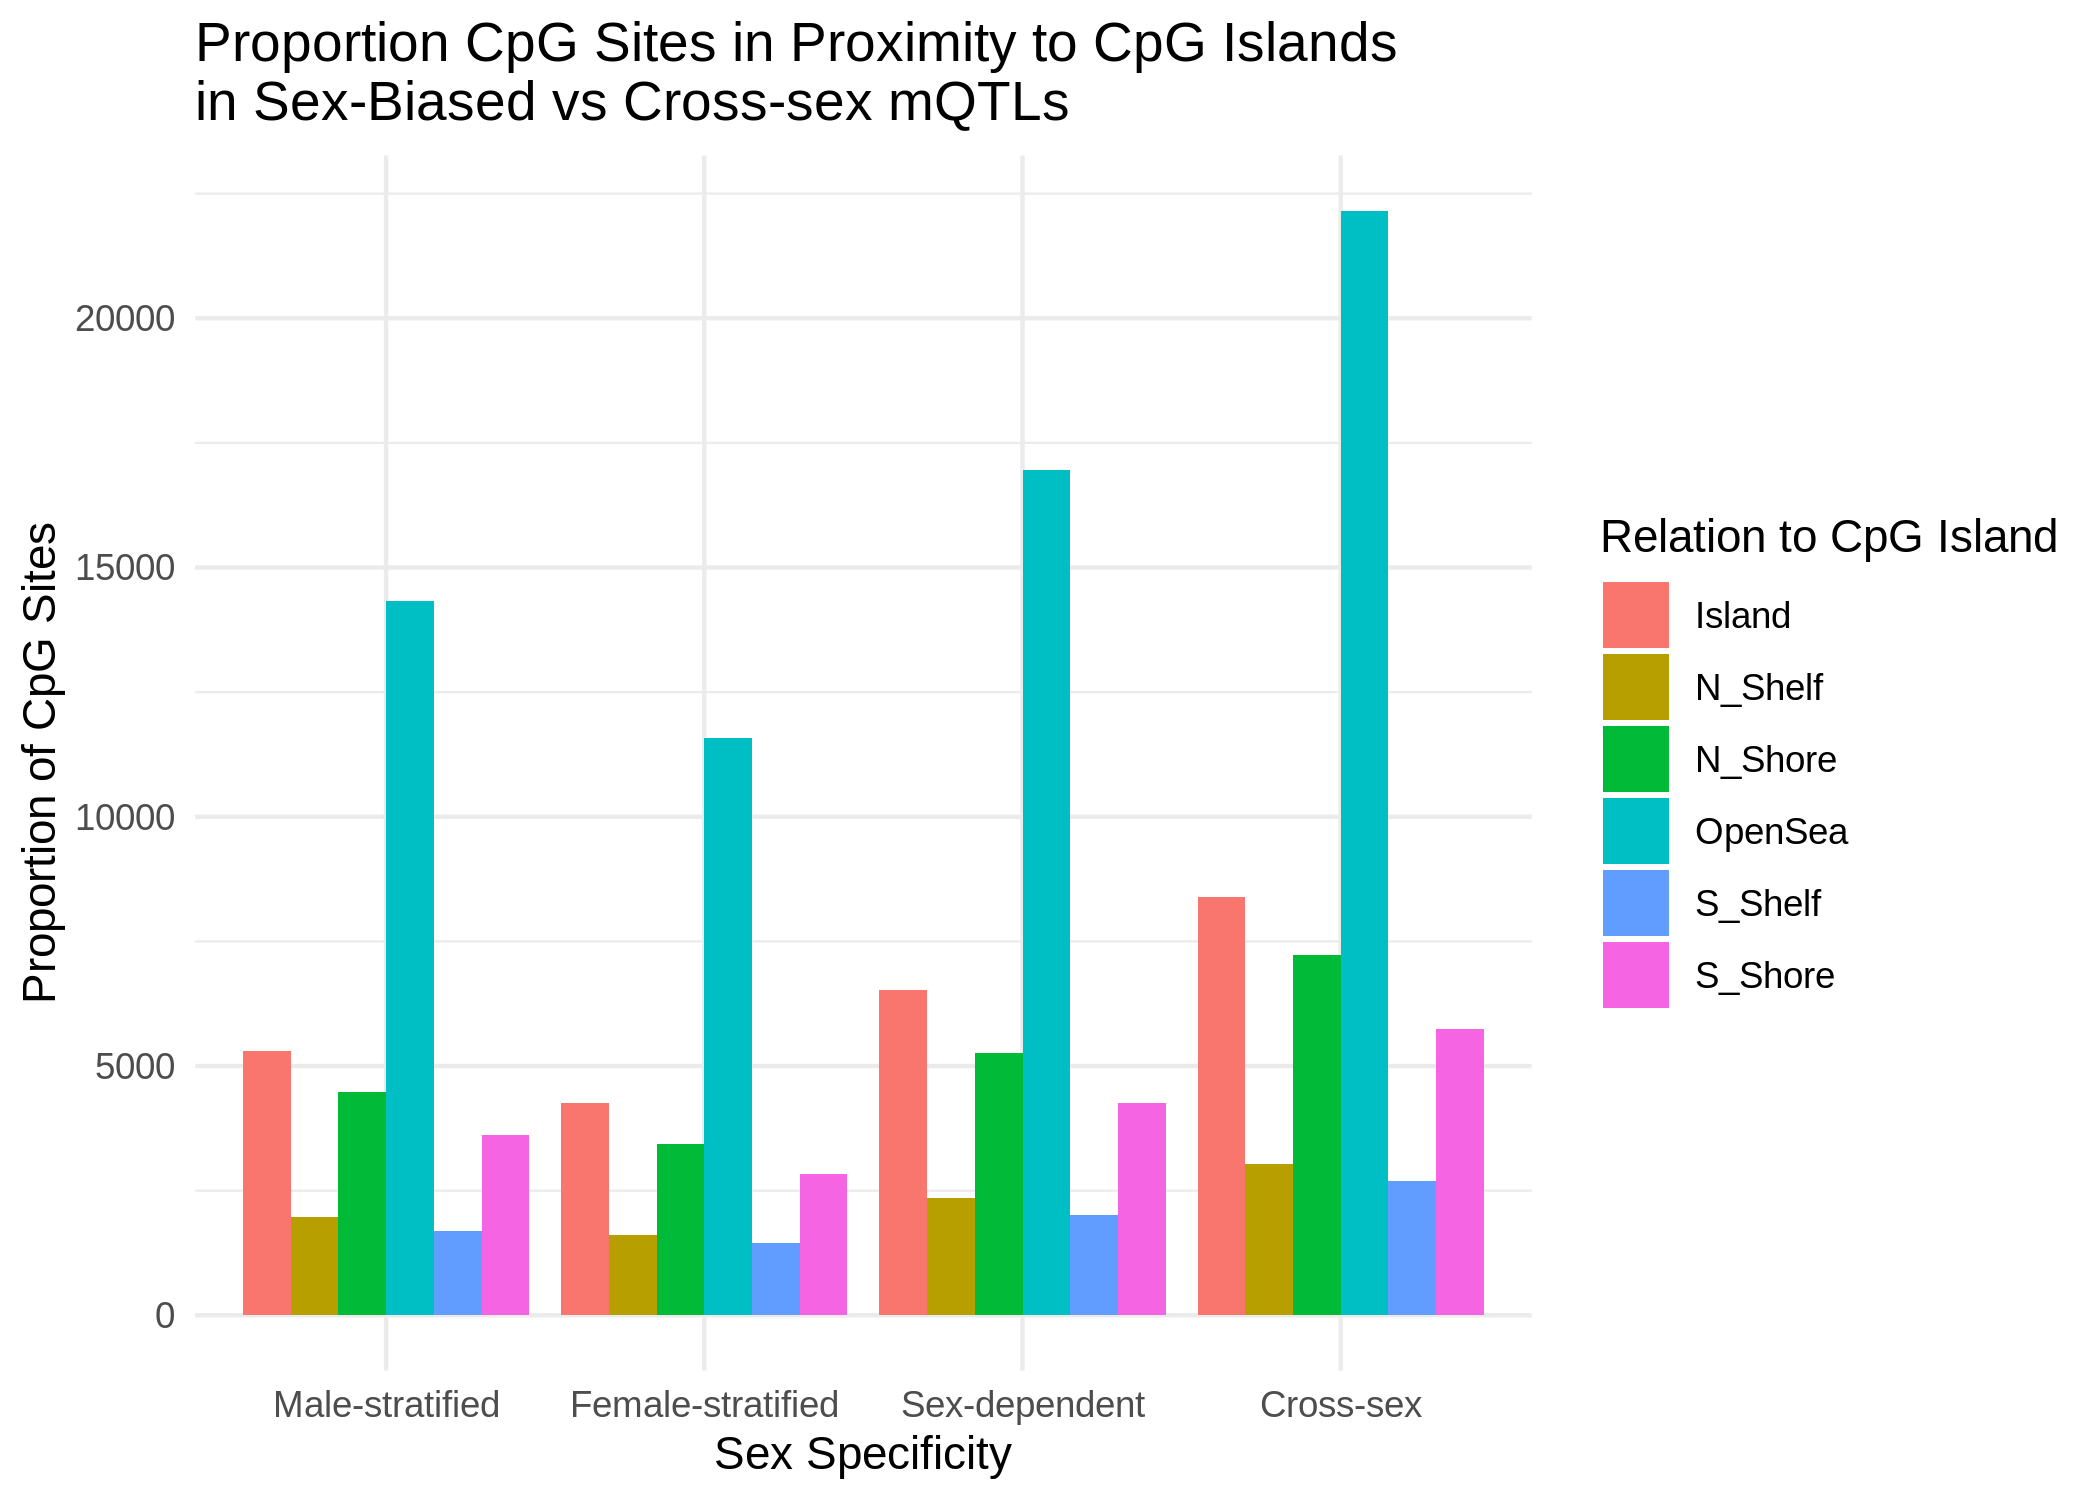

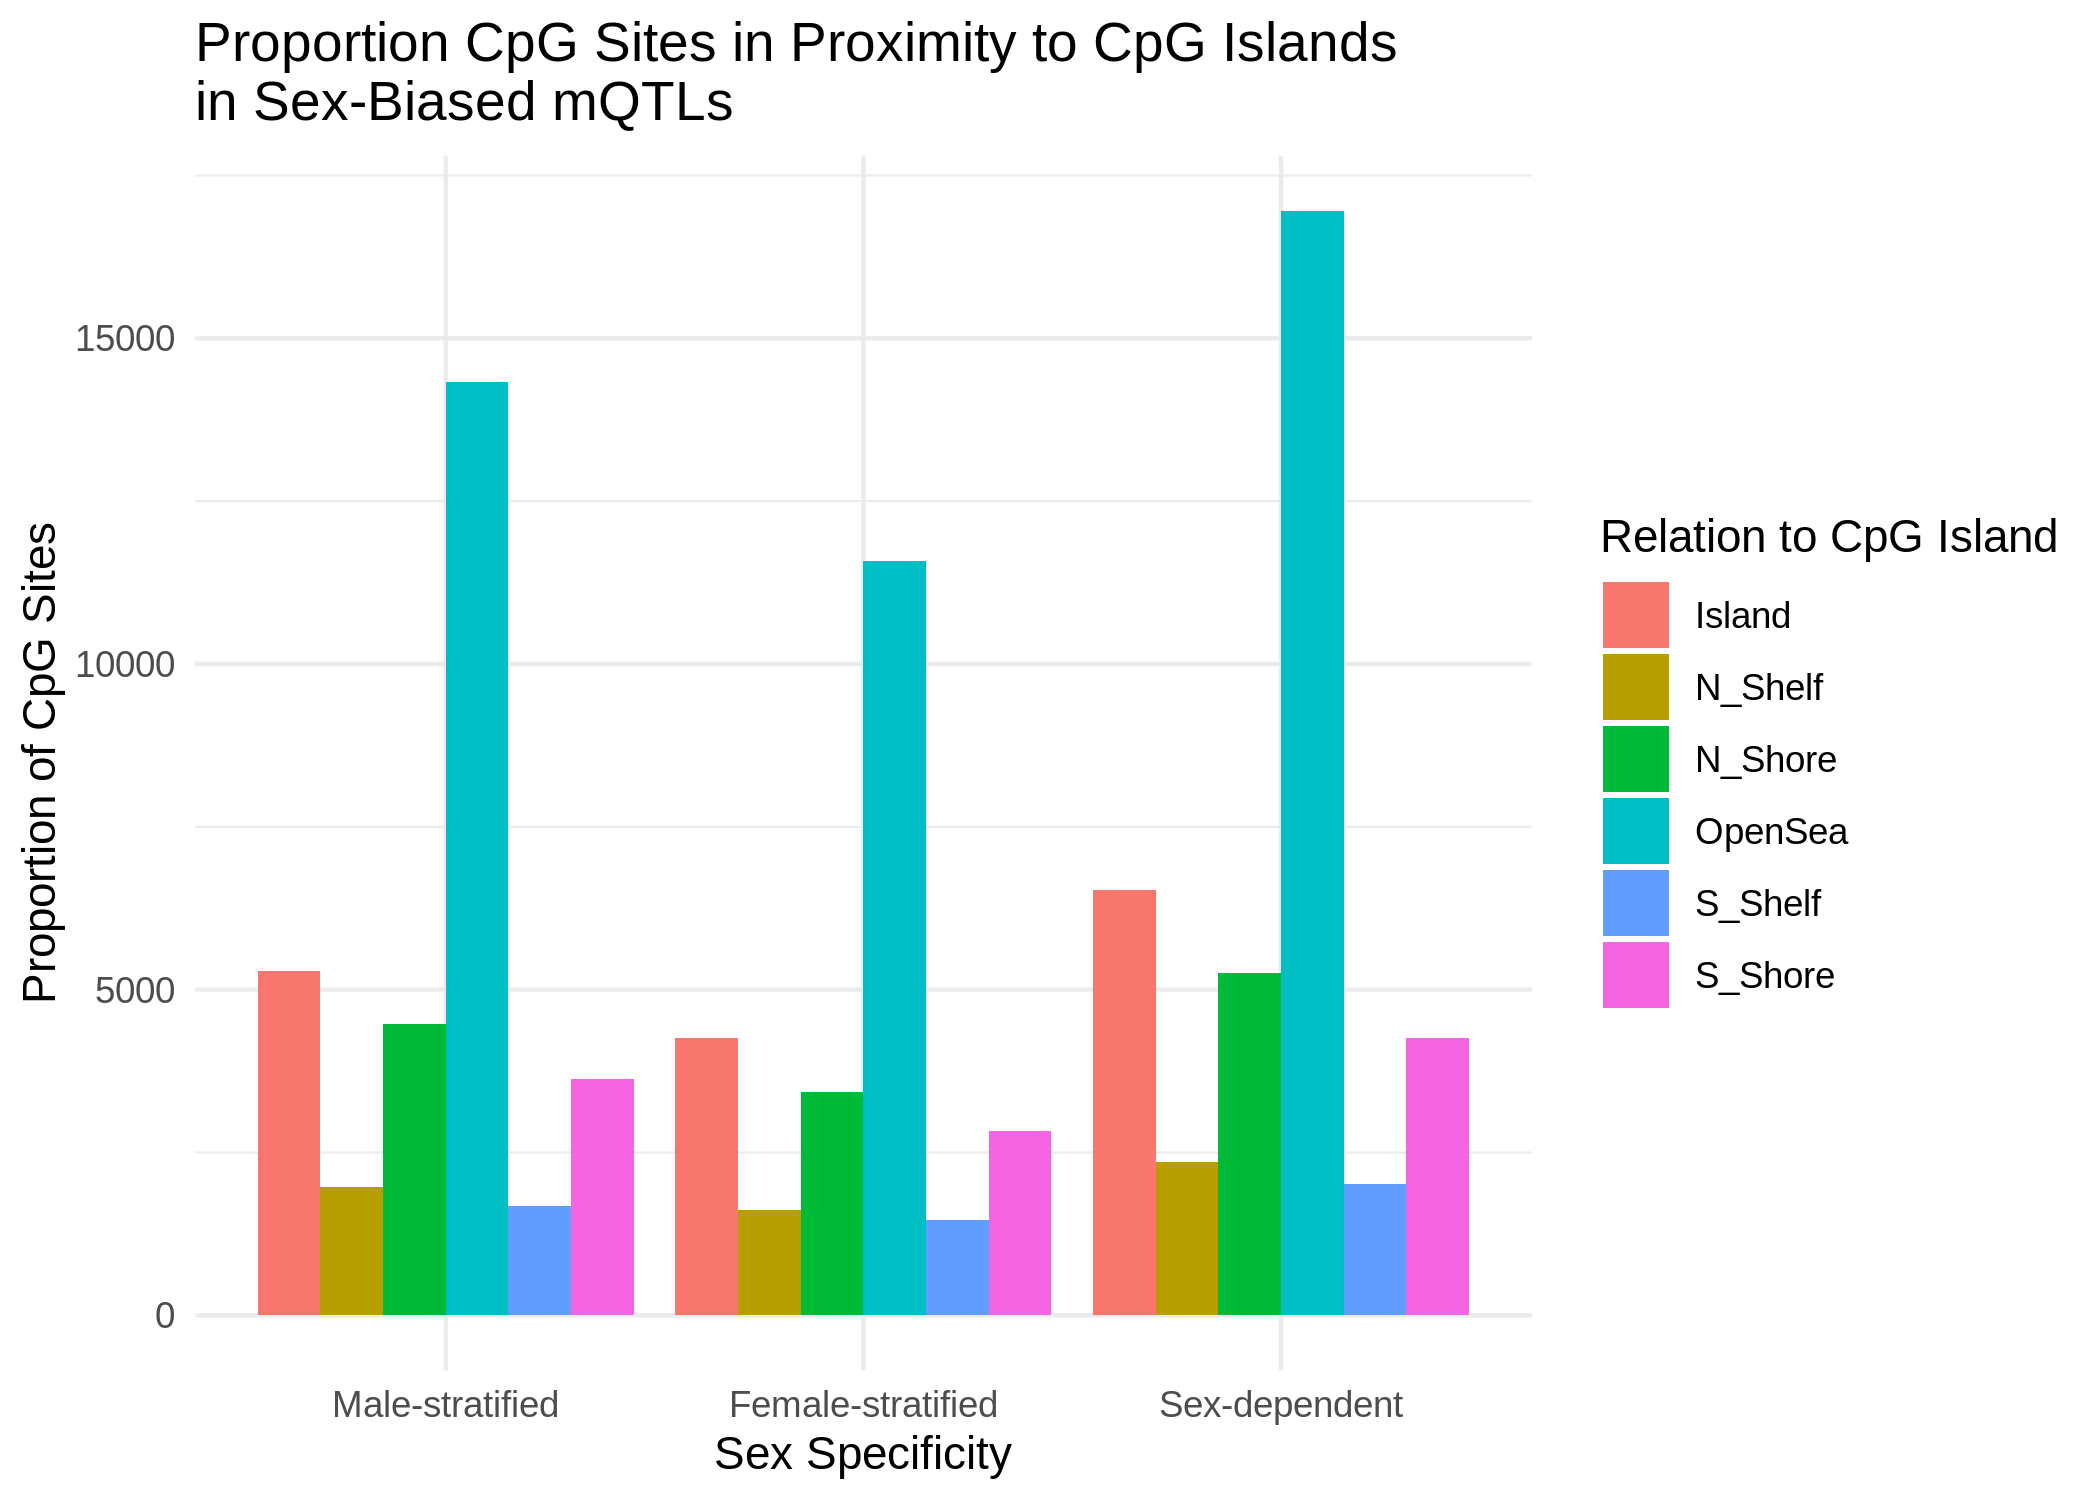

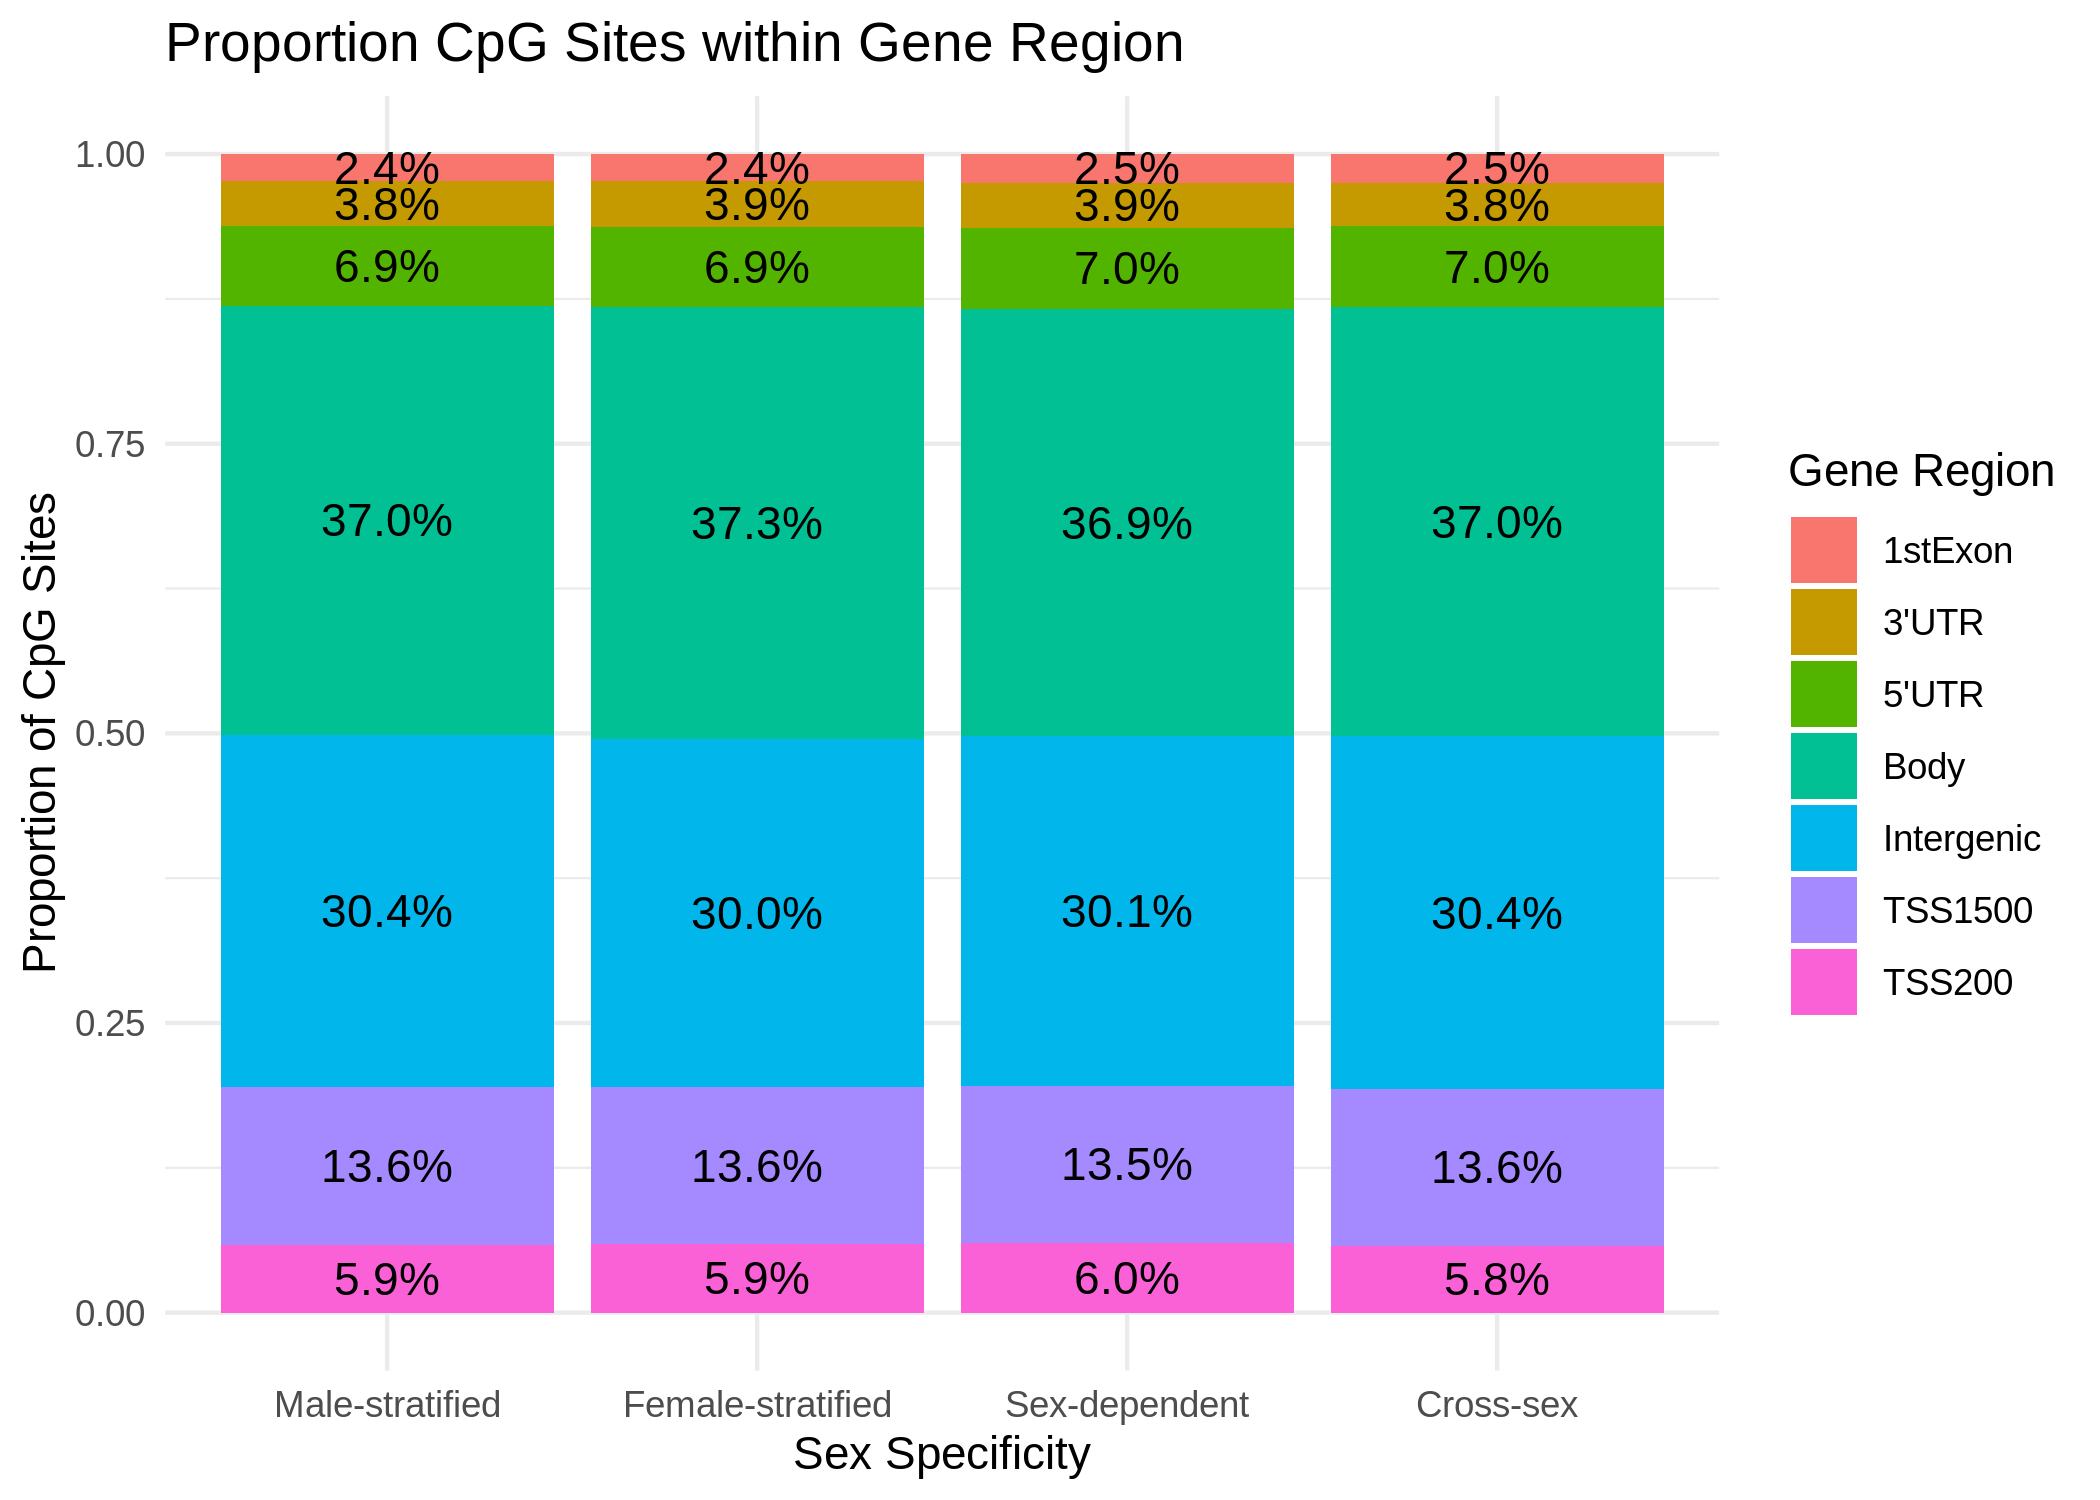

In [24]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)

library(GGally)
ggplot(total_annotated_strat[!duplicated(total_annotated_strat[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Cross-sex mQTLs")

ggplot(total_annotated_strat[!duplicated(total_annotated_strat[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Cross-sex mQTLs")

ggplot(total_annotated_strat[Sex != "Cross-sex" & !duplicated(total_annotated_strat[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased mQTLs")
ggplot(total_annotated_strat[!duplicated(total_annotated_strat[,.(Probe,Sex)])], aes(Sex, fill = sapply(gsub(";.*","",UCSC_RefGene_Group),function(x)ifelse(x == "","Intergenic",x)), by = Sex)) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Gene Region")+
    ggtitle("Proportion CpG Sites within Gene Region")

In [ ]:
fwrite(total_annotated, here("data", "total_annotated.csv.gz"))
fwrite(total_annotated_strat, here("data", "total_annotated_strat.csv.gz"))

## Overall Counts by Category
- Categories
    - Cross-sex
    - Male stratified
    - Female stratified
    - sex dependent
    - male specifice
- Need to get
    - unique to each category
    - total
    - number of mQTL 
    - no CpG sites
    - no Genes that have a CpG site

In [25]:
male_annotated <- merge(male,array_annot,by.x="Probe",by.y="Name")
female_annotated <- merge(female,array_annot,by.x="Probe",by.y="Name")
marginal_annotated <- merge(marginal,array_annot,by.x="Probe",by.y="Name")
sex_annotated <- merge(sex_interaction,array_annot,by.x="Probe",by.y="Name")

In [26]:
rbind(
    male_annotated[,.(Sex="Male stratified",mQTL=.N,CpG=uniqueN(Probe),Gene=uniqueN(gsub(';.*','',UCSC_RefGene_Name)))],
    female_annotated[,.(Sex="Female stratified",mQTL=.N,CpG=uniqueN(Probe),Gene=uniqueN(gsub(';.*','',UCSC_RefGene_Name)))],
    marginal_annotated[,.(Sex="Cross-sex",mQTL=.N,CpG=uniqueN(Probe),Gene=uniqueN(gsub(';.*','',UCSC_RefGene_Name)))],
    sex_annotated[,.(Sex="Sex dependent",mQTL=.N,CpG=uniqueN(Probe),Gene=uniqueN(gsub(';.*','',UCSC_RefGene_Name)))],
    male_annotated[sex_annotated[,.(SNP,Probe)],on=.(SNP,Probe),nomatch=0][,.(Sex="Male Specific",mQTL=.N,CpG=uniqueN(Probe),Gene=uniqueN(gsub(';.*','',UCSC_RefGene_Name)))],
    female_annotated[sex_annotated[,.(SNP,Probe)],on=.(SNP,Probe),nomatch=0][,.(Sex="Female Specific",mQTL=.N,CpG=uniqueN(Probe),Gene=uniqueN(gsub(';.*','',UCSC_RefGene_Name)))]
)

all_dt <- rbindlist(
    list(
        `Male stratified`=male_annotated[,.(SNP,Probe,Gene=gsub(';.*','',UCSC_RefGene_Name))],
        `Female stratified`=female_annotated[,.(SNP,Probe,Gene=gsub(';.*','',UCSC_RefGene_Name))],
        `Cross-sex`=marginal_annotated[,.(SNP,Probe,Gene=gsub(';.*','',UCSC_RefGene_Name))],
        `Sex dependent`=sex_annotated[,.(SNP,Probe,Gene=gsub(';.*','',UCSC_RefGene_Name))],
        `Male specific`=male_annotated[sex_annotated[,.(SNP,Probe)],on=.(SNP,Probe),nomatch=0][,.(SNP,Probe,Gene=gsub(';.*','',UCSC_RefGene_Name))],
        `Female specific`=female_annotated[sex_annotated[,.(SNP,Probe)],on=.(SNP,Probe),nomatch=0][,.(SNP,Probe,Gene=gsub(';.*','',UCSC_RefGene_Name))]
    ),
    idcol="Sex"
)

Sex              
1 Male stratified  
2 Female stratified
3 Cross-sex        
4 Sex dependent    
5 Male Specific    
6 Female Specific  
  mQTL   
1  865986
2  578481
3 1699445
4   27706
5    2876
6    1981
  CpG  
1 31384
2 25180
3 49252
4  2489
5   351
6   255
  Gene 
1  8260
2  7262
3 10699
4   976
5   193
6   153

In [27]:
all_dt$mQTL <- paste0(all_dt$SNP,all_dt$Probe)

male_probe <- sum(!(
    unique(all_dt[Sex == "Male stratified"]$Probe) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$Probe),unique(all_dt[Sex == "Female stratified"]$Probe))
))
male_mqtl <- sum(!(
    unique(all_dt[Sex == "Male stratified"]$mQTL) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$mQTL),unique(all_dt[Sex == "Female stratified"]$mQTL))
))

male_gene <- sum(!(
    unique(all_dt[Sex == "Male stratified"]$Gene) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$Gene),unique(all_dt[Sex == "Female stratified"]$Gene))
))

female_probe <-sum(!(
    unique(all_dt[Sex == "Female stratified"]$Probe) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$Probe),unique(all_dt[Sex == "Male stratified"]$Probe))
))
female_mqtl <-sum(!(
    unique(all_dt[Sex == "Female stratified"]$mQTL) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$mQTL),unique(all_dt[Sex == "Male stratified"]$mQTL))
))
female_gene <-sum(!(
    unique(all_dt[Sex == "Female stratified"]$Gene) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$Gene),unique(all_dt[Sex == "Male stratified"]$Gene))
))

marginal_probe <-sum(!(
    unique(all_dt[Sex == "Cross-sex"]$Probe) %in%
    union(unique(all_dt[Sex == "Female stratified"]$Probe),unique(all_dt[Sex == "Male stratified"]$Probe))
))
marginal_mqtl <-sum(!(
    unique(all_dt[Sex == "Cross-sex"]$mQTL) %in%
    union(unique(all_dt[Sex == "Female stratified"]$mQTL),unique(all_dt[Sex == "Male stratified"]$mQTL))
))
marginal_gene <-sum(!(
    unique(all_dt[Sex == "Cross-sex"]$Gene) %in%
    union(unique(all_dt[Sex == "Female stratified"]$Gene),unique(all_dt[Sex == "Male stratified"]$Gene))
))
data.table(
    Sex=c("Cross-sex","Male stratified","Female stratified"),
    mQTL = c(marginal_mqtl,male_mqtl,female_mqtl),
    CpG = c(marginal_probe,male_probe,female_probe),
    Gene = c(marginal_gene,male_gene,female_gene) 
)

male_probe <- sum(!(
    unique(all_dt[Sex == "Male specific"]$Probe) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$Probe),unique(all_dt[Sex == "Female specific"]$Probe))
))
male_mqtl <- sum(!(
    unique(all_dt[Sex == "Male specific"]$mQTL) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$mQTL),unique(all_dt[Sex == "Female specific"]$mQTL))
))

male_gene <- sum(!(
    unique(all_dt[Sex == "Male specific"]$Gene) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$Gene),unique(all_dt[Sex == "Female specific"]$Gene))
))

female_probe <-sum(!(
    unique(all_dt[Sex == "Female specific"]$Probe) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$Probe),unique(all_dt[Sex == "Male specific"]$Probe))
))
female_mqtl <-sum(!(
    unique(all_dt[Sex == "Female specific"]$mQTL) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$mQTL),unique(all_dt[Sex == "Male specific"]$mQTL))
))
female_gene <-sum(!(
    unique(all_dt[Sex == "Female specific"]$Gene) %in%
    union(unique(all_dt[Sex == "Cross-sex"]$Gene),unique(all_dt[Sex == "Male specific"]$Gene))
))

marginal_probe <-sum(!(
    unique(all_dt[Sex == "Cross-sex"]$Probe) %in%
    union(unique(all_dt[Sex == "Female specific"]$Probe),unique(all_dt[Sex == "Male specific"]$Probe))
))
marginal_mqtl <-sum(!(
    unique(all_dt[Sex == "Cross-sex"]$mQTL) %in%
    union(unique(all_dt[Sex == "Female specific"]$mQTL),unique(all_dt[Sex == "Male specific"]$mQTL))
))
marginal_gene <-sum(!(
    unique(all_dt[Sex == "Cross-sex"]$Gene) %in%
    union(unique(all_dt[Sex == "Female specific"]$Gene),unique(all_dt[Sex == "Male specific"]$Gene))
))
data.table(
    Sex=c("Cross-sex","Male specific","Female specific"),
    mQTL = c(marginal_mqtl,male_mqtl,female_mqtl),
    CpG = c(marginal_probe,male_probe,female_probe),
    Gene = c(marginal_gene,male_gene,female_gene) 
)

Sex              
1 Cross-sex        
2 Male stratified  
3 Female stratified
  mQTL  
1 815196
2  66097
3  60757
  CpG  
1 17338
2  2541
3  2865
  Gene
1 2128
2  291
3  342

Sex            
1 Cross-sex      
2 Male specific  
3 Female specific
  mQTL   
1 1697701
2    1574
3     958
  CpG  
1 48988
2   165
3   101
  Gene 
1 10457
2    25
3    19

### Plotting by weighted mean DNAm per site

In [28]:
richs_DNAm <- fread(
    "../../../delahaye_QC/matrix_eqtl_data/methylation_matrixeQTL.txt", key="cpg"
)
delahaye_DNAm <- fread(
    "../../../RICHS_QC/matrix_eqtl_data/methylation_matrixeQTL.txt", key="cpg"
)

In [29]:
total_annotated <- fread("../../data/total_annotated.csv.gz")
total_annotated_strat <- fread("../../data/total_annotated_strat.csv.gz")
dat1 <- delahaye_DNAm[,.(mean1=mean(unlist(.SD),na.rm=T),var1=1 / var(unlist(.SD),na.rm=T)),by="cpg"]
dat2 <- richs_DNAm[,.(mean2=mean(unlist(.SD),na.rm=T),var2=1 / var(unlist(.SD),na.rm=T)),by="cpg"]
merged <- merge(dat1,dat2,by="cpg",all=TRUE)

weighted_means <- merged[,.(mean_DNAm = weighted.mean(c(mean1,mean2),c(var1,var2),na.rm = TRUE)),by="cpg"]

means_strat <- merge(total_annotated_strat,weighted_means,by.x="Probe",by.y="cpg")
means_specific <- merge(total_annotated,weighted_means,by.x = "Probe",by.y = "cpg")

In [30]:
no_mQTL <- merge(
    array_annot[!Name %in% unique(total_annotated[Sex == "Cross-sex"]$Probe)],
    weighted_means,
    by.x="Name",
    by.y="cpg"
)
head(no_mQTL)
dim(no_mQTL)
dim(array_annot)

Name      
1 cg00000029
2 cg00000108
3 cg00000109
4 cg00000165
5 cg00000236
6 cg00000289
  V1        
1 cg00000029
2 cg00000108
3 cg00000109
4 cg00000165
5 cg00000236
6 cg00000289
  chr  
1 chr16
2 chr3 
3 chr3 
4 chr1 
5 chr8 
6 chr14
  pos      
1  53468112
2  37459206
3 171916037
4  91194674
5  42263294
6  69341139
  strand
1 +     
2 +     
3 +     
4 -     
5 -     
6 +     
  AddressA
1 14782418
2 12709357
3 59755374
4 12637463
5 12649348
6 18766346
  AddressB
1 NA      
2 NA      
3 NA      
4 NA      
5 NA      
6 NA      
  ProbeSeqA                                         
1 AACTATACTAACRAAAAAATATCCAAAAAACACTAACRTATAAAAATTTC
2 ATACAATAAAACAAACCTAAAATAATCCTAACTCCRCTATCATCCTAACC
3 CAATACTAACAAACACATATACCCCCCCACAAATCTTAACTTCTAAATAC
4 CAAAATCTATTAATACAATAACTTTTAATAAAACAACTAAAACACACATC
5 TATAACRTCATATTAAAAAAAACRATCTAACCCACCAATTTATACATCAC
6 ATCTACTATATTCATTTCTCCAATCTCATATCCATTTTAATATAAAAATC
  ProbeSeqB
1          
2          
3          
4          
5          
6          
  Type ⋯
1 II   ⋯
2 II   ⋯
3 II   ⋯
4 II   ⋯
5 II   ⋯
6 II   ⋯
  UCSC_RefGene_Accession             
1 NM_005611                          
2 NM_178339;NM_178342                
3 NM_001135095;NM_022763             
4                                    
5 NM_005662;NM_001135694             
6 NM_001130005;NM_001130004;NM_001102
  UCSC_RefGene_Group
1 TSS1500           
2 Body;3'UTR        
3 Body;Body         
4                   
5 3'UTR;3'UTR       
6 3'UTR;3'UTR;3'UTR 
  Phantom                    
1                            
2                            
3 low-CpG:173398671-173398760
4                            
5                            
6                            
  DMR 
1     
2     
3     
4 CDMR
5     
6     
  Enhancer
1   NA    
2   NA    
3   NA    
4 TRUE    
5   NA    
6   NA    
  HMM_Island         
1                    
2                    
3                    
4 1:90967262-90967361
5                    
6                    
  Regulatory_Feature_Name
1 16:53467838-53469685   
2                        
3                        
4                        
5                        
6                        
  Regulatory_Feature_Group
1 Promoter_Associated     
2                         
3                         
4                         
5                         
6                         
  DHS 
1 TRUE
2   NA
3   NA
4   NA
5   NA
6   NA
  mean_DNAm 
1 0.08841918
2 0.92925993
3 0.88460277
4 0.60598296
5 0.81500915
6 0.70239984

[1] 398004
[2]     35

[1] 485512
[2]     34

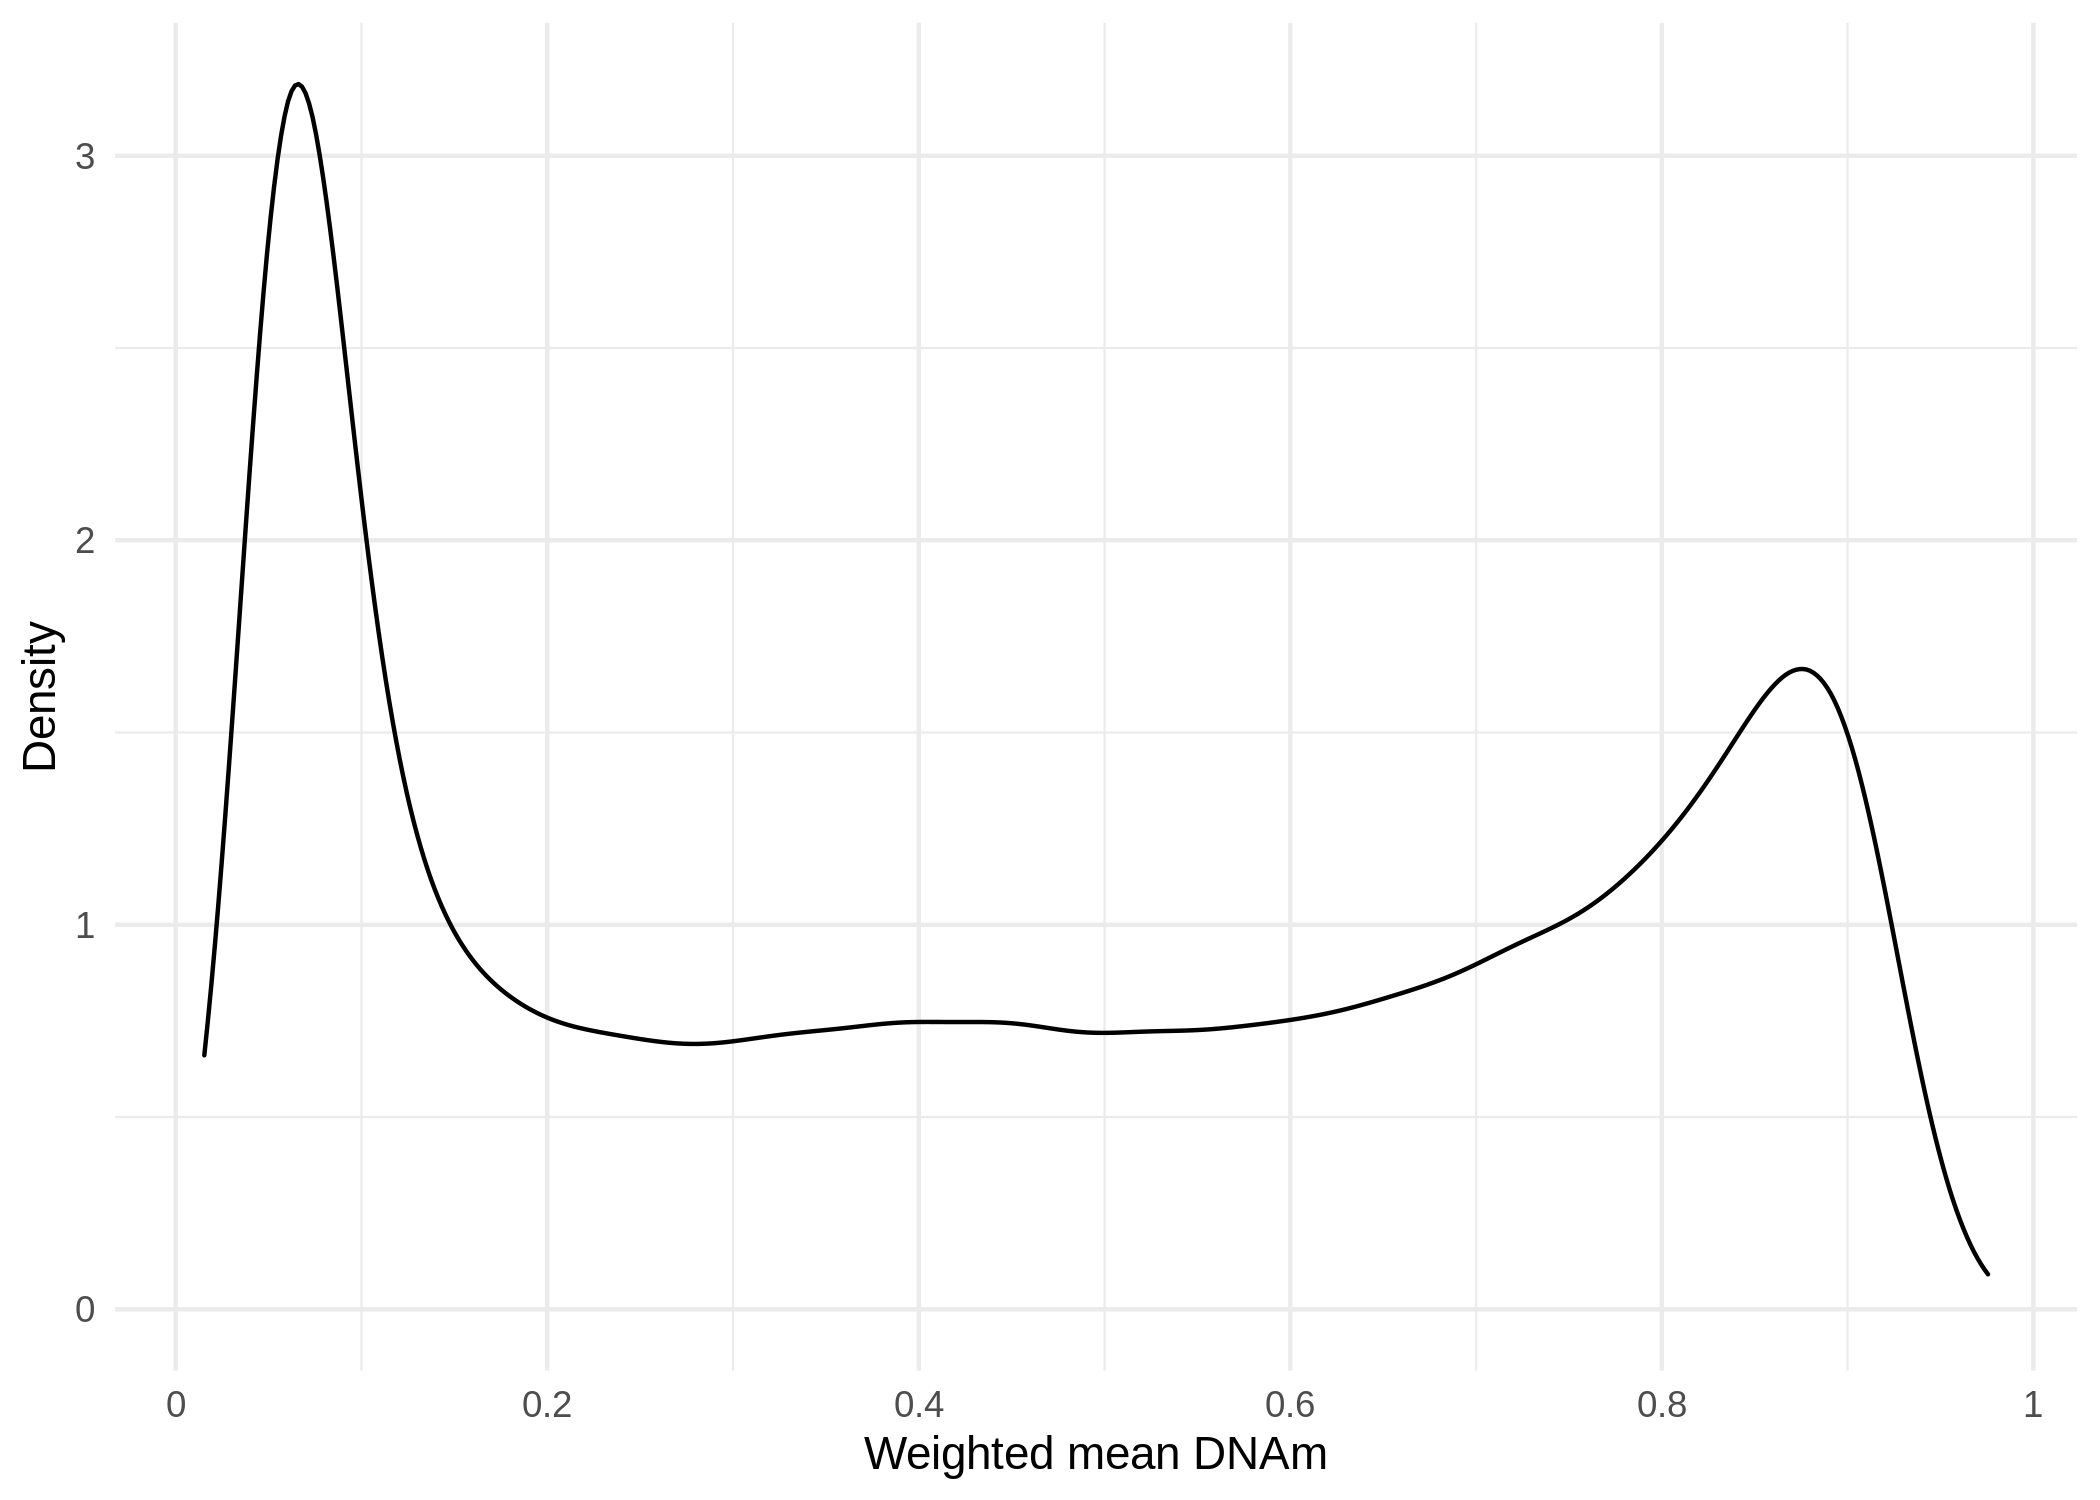

In [31]:
ggplot(weighted_means,aes(mean_DNAm)) + 
    geom_density() + 
    scale_x_continuous(breaks = seq(0,1,0.2),labels = seq(0,1,0.2)) +
    labs(x="Weighted mean DNAm", y = "Density")+
    theme_minimal()

In [32]:
means_strat$Sex <- recode(means_strat$Sex,`Sex dependent`="Sex-dependent",`Male stratified`="Male-stratified", `Female stratified`="Female-stratified")
means_specific$Sex <- recode(means_specific$Sex,`Sex dependent`="Sex-dependent", `Male specific`="Male-specific", `Female specific`="Female-specific")


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




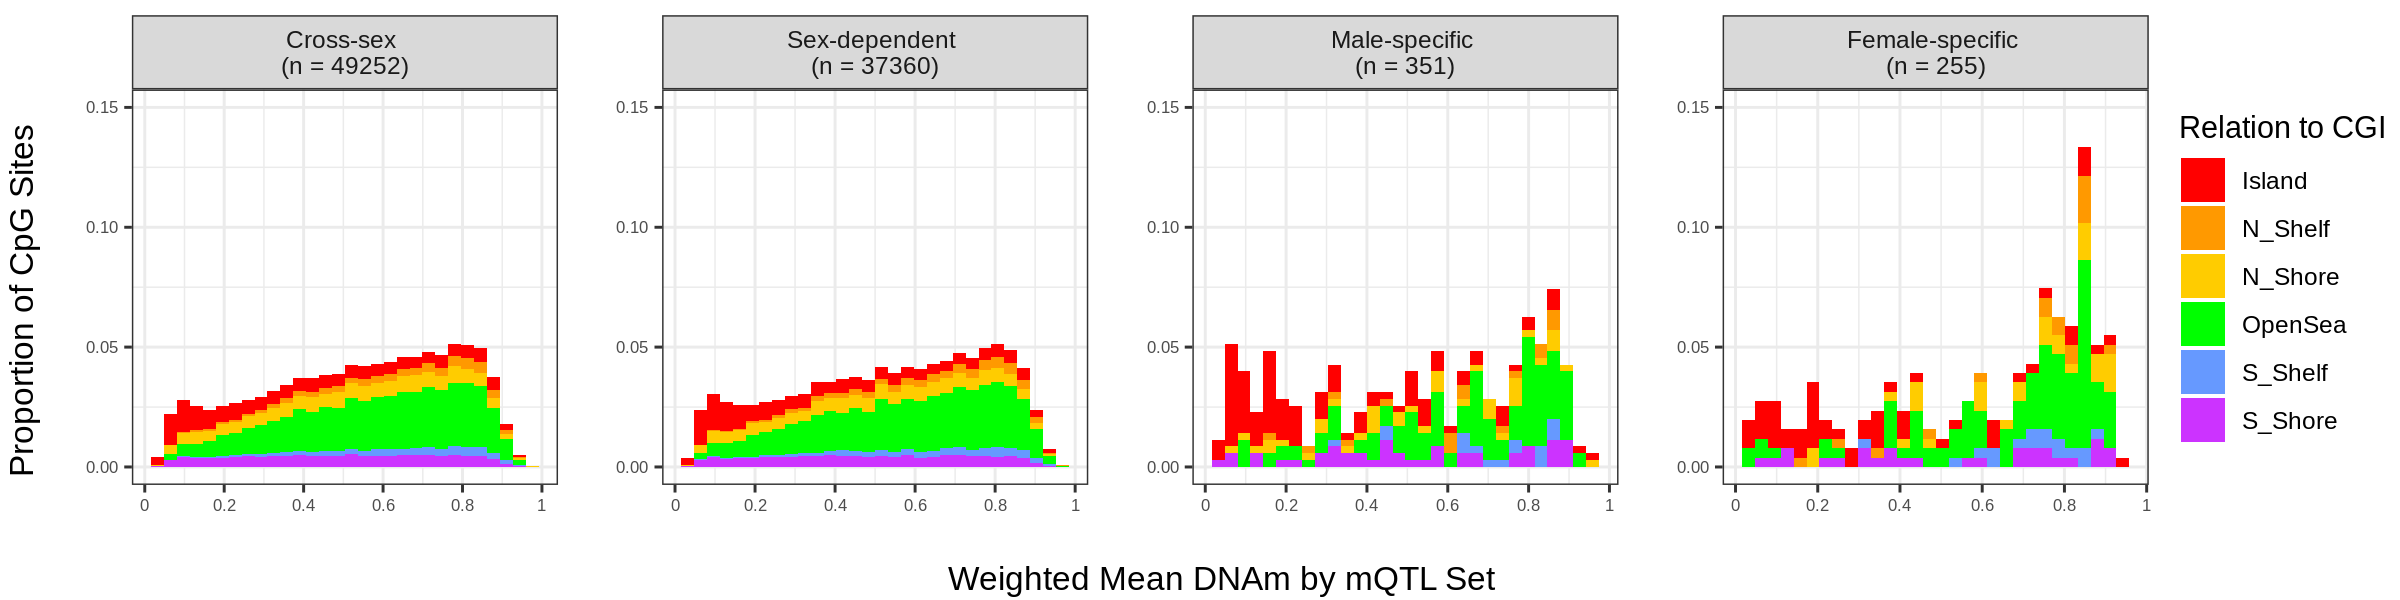

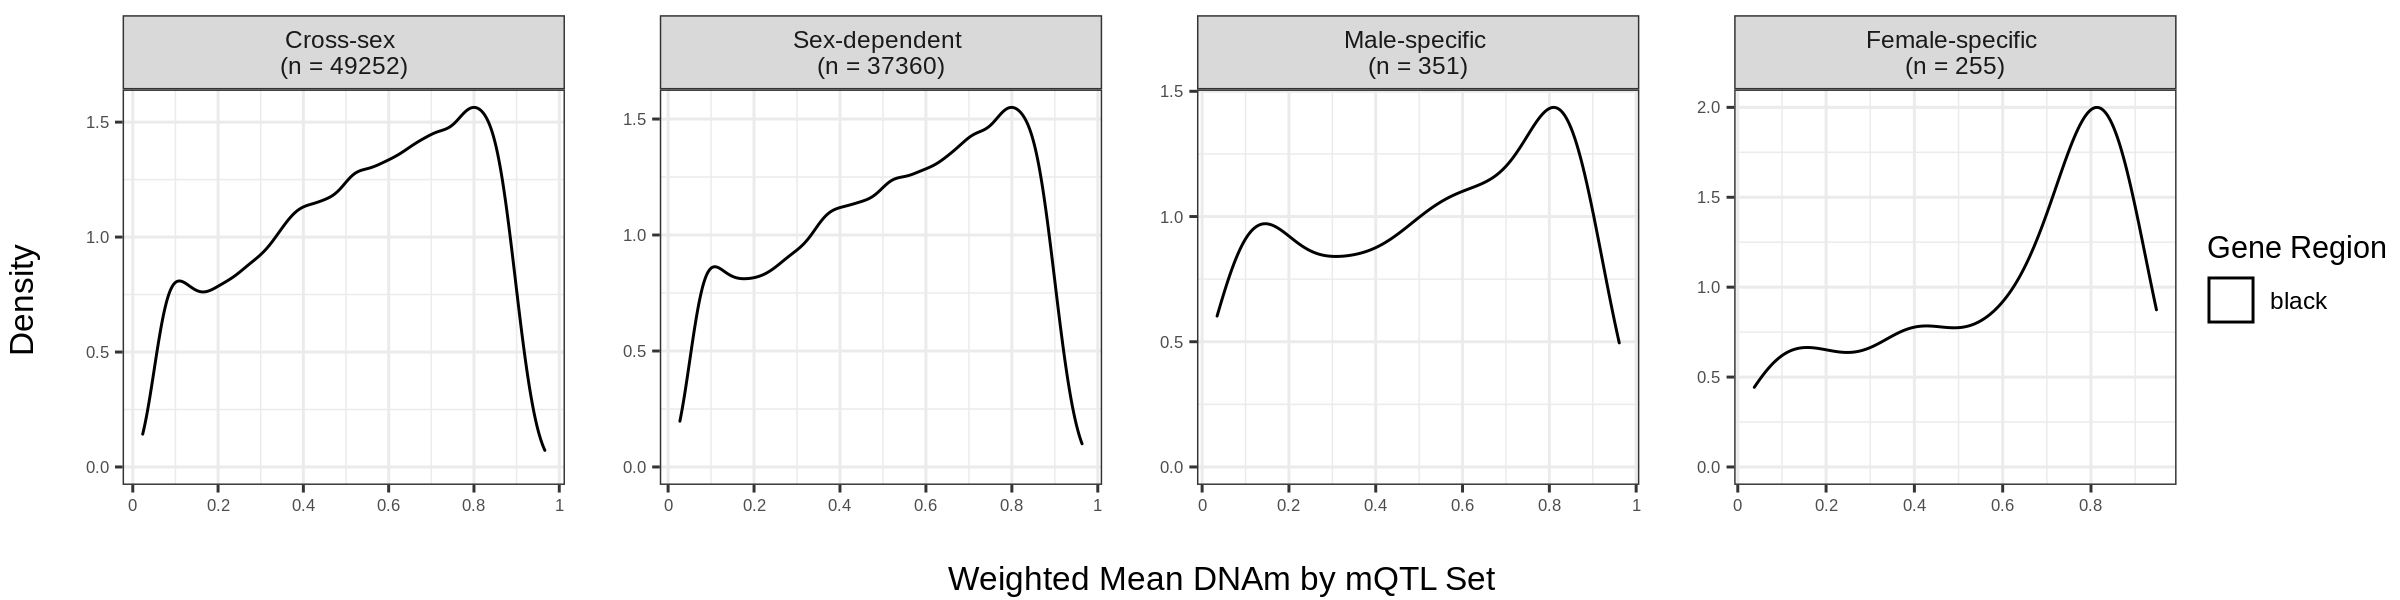

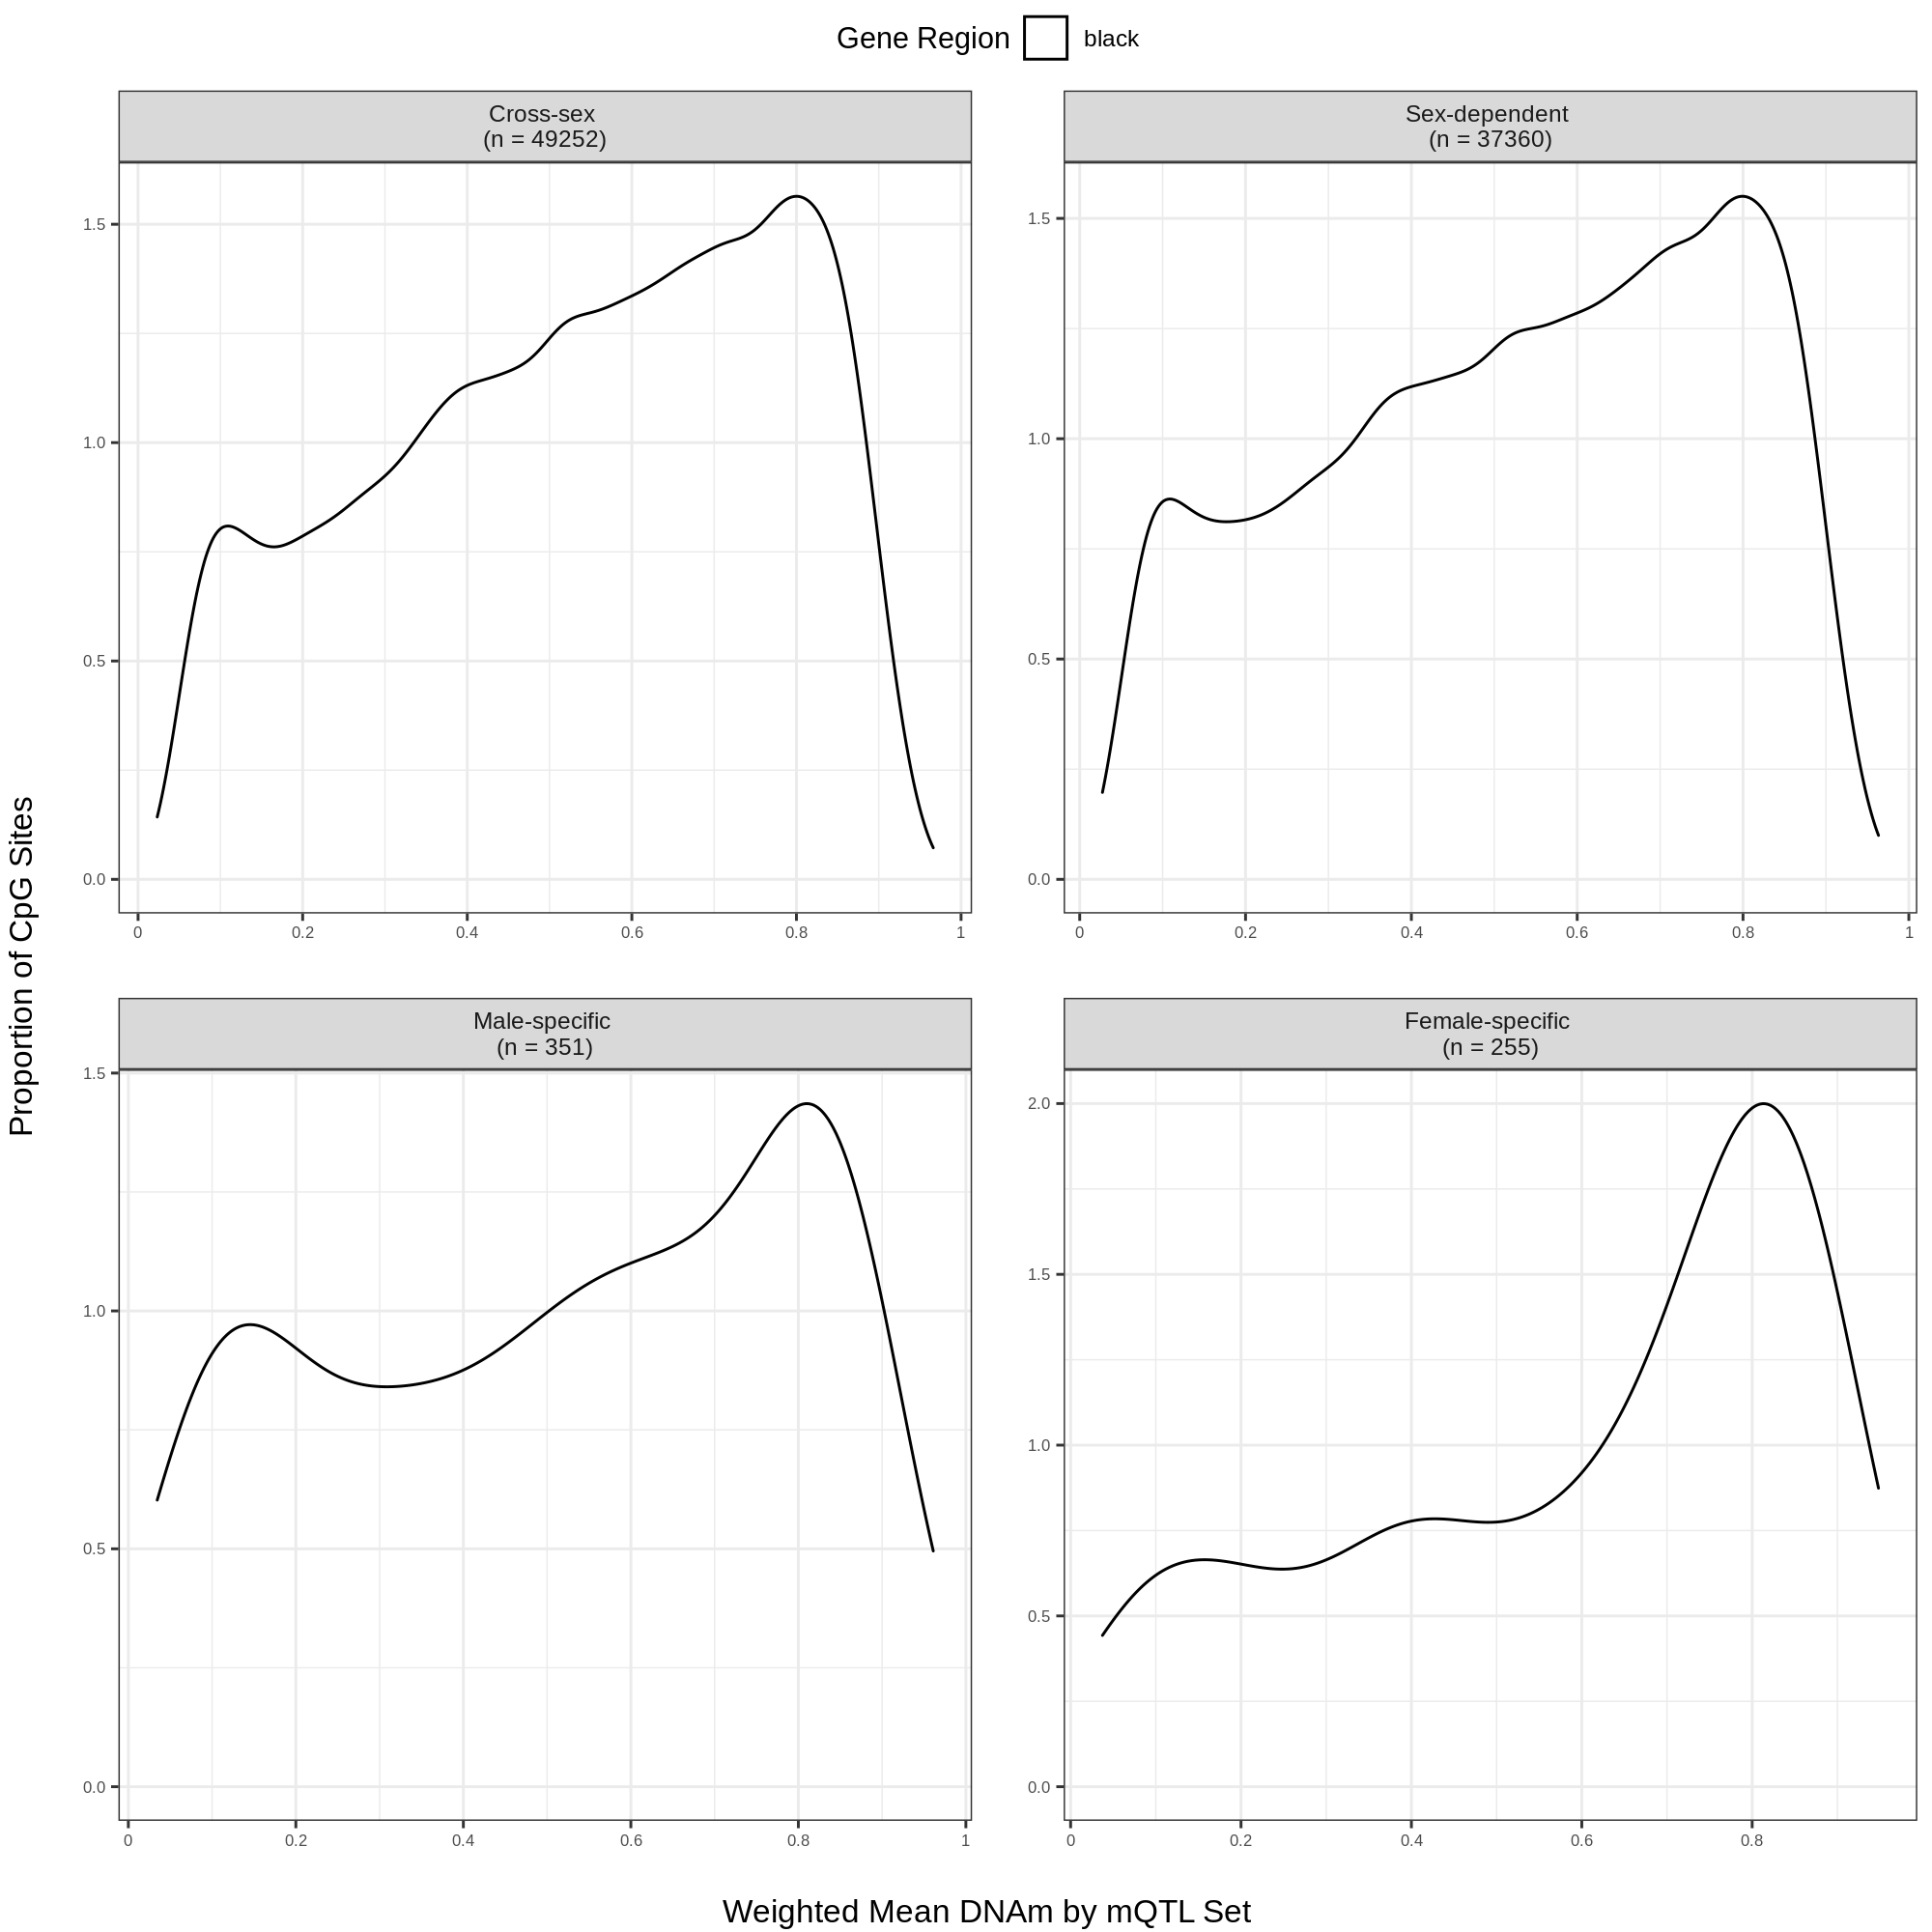

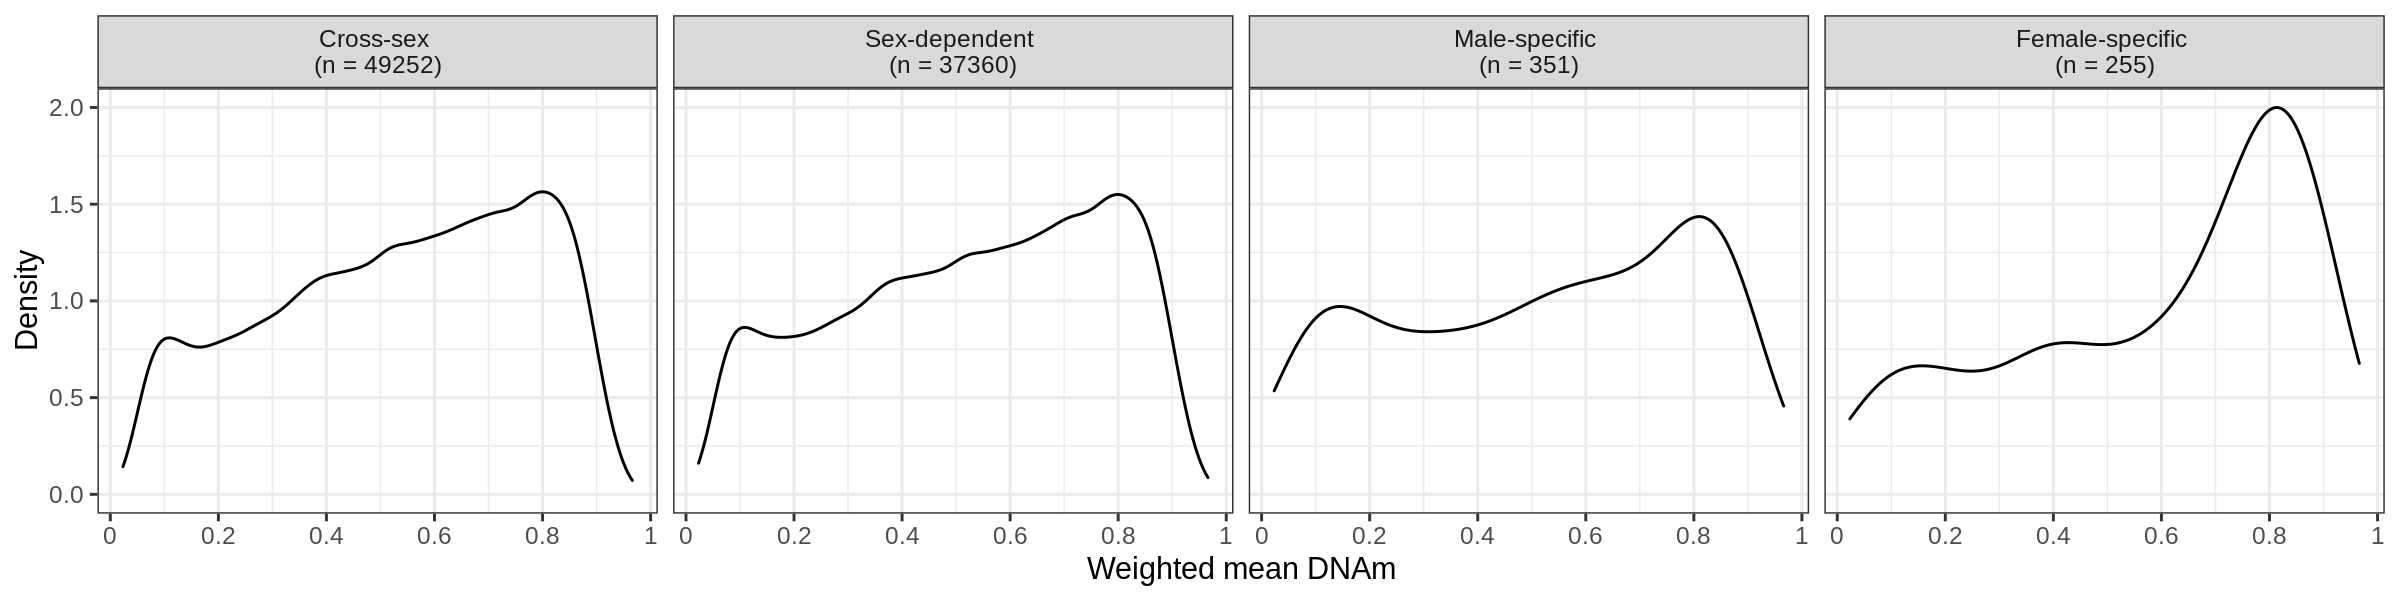

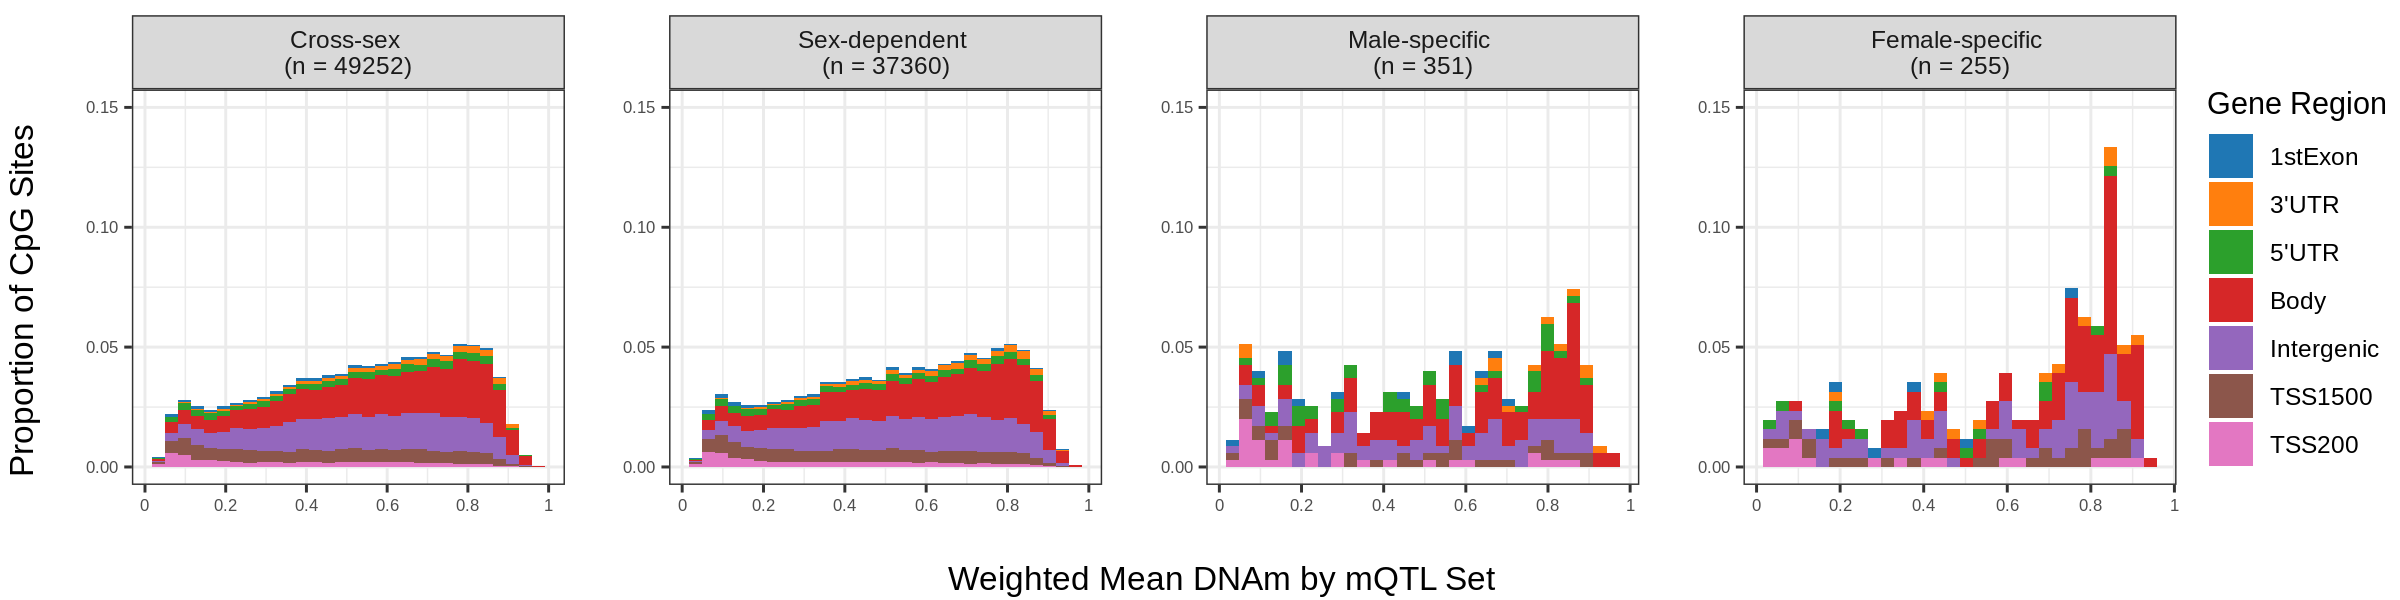

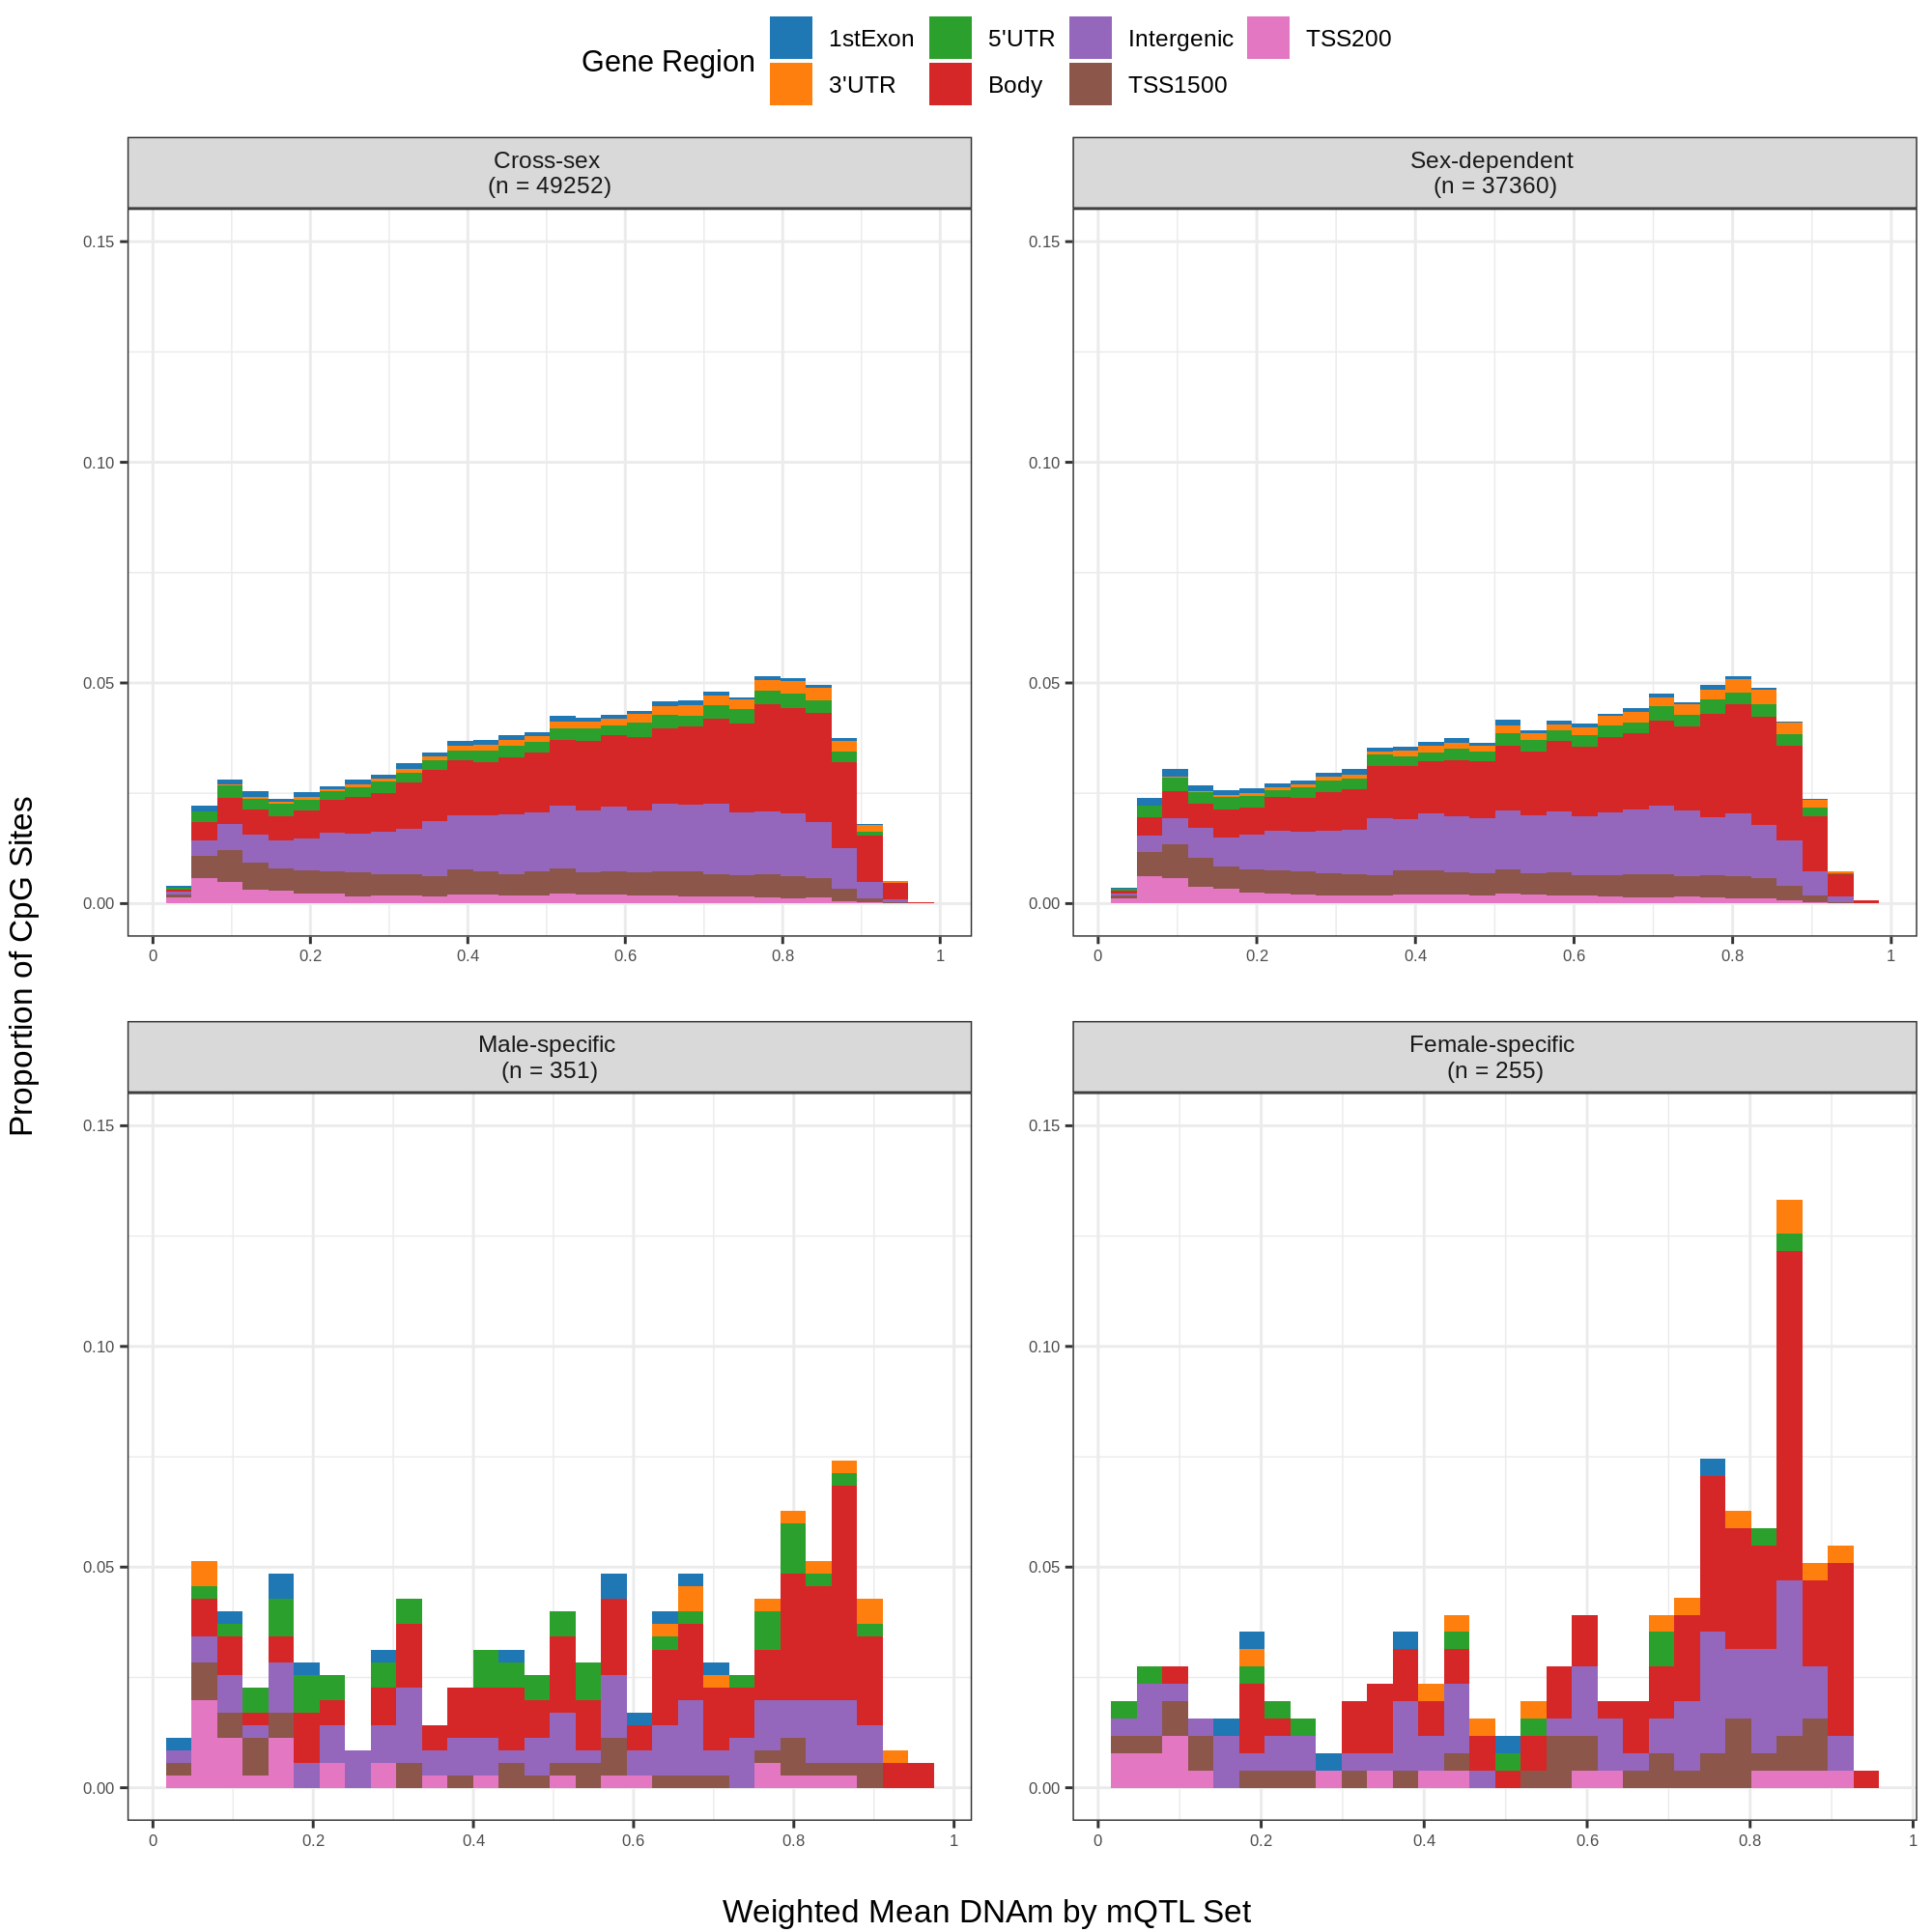

[1] 398004

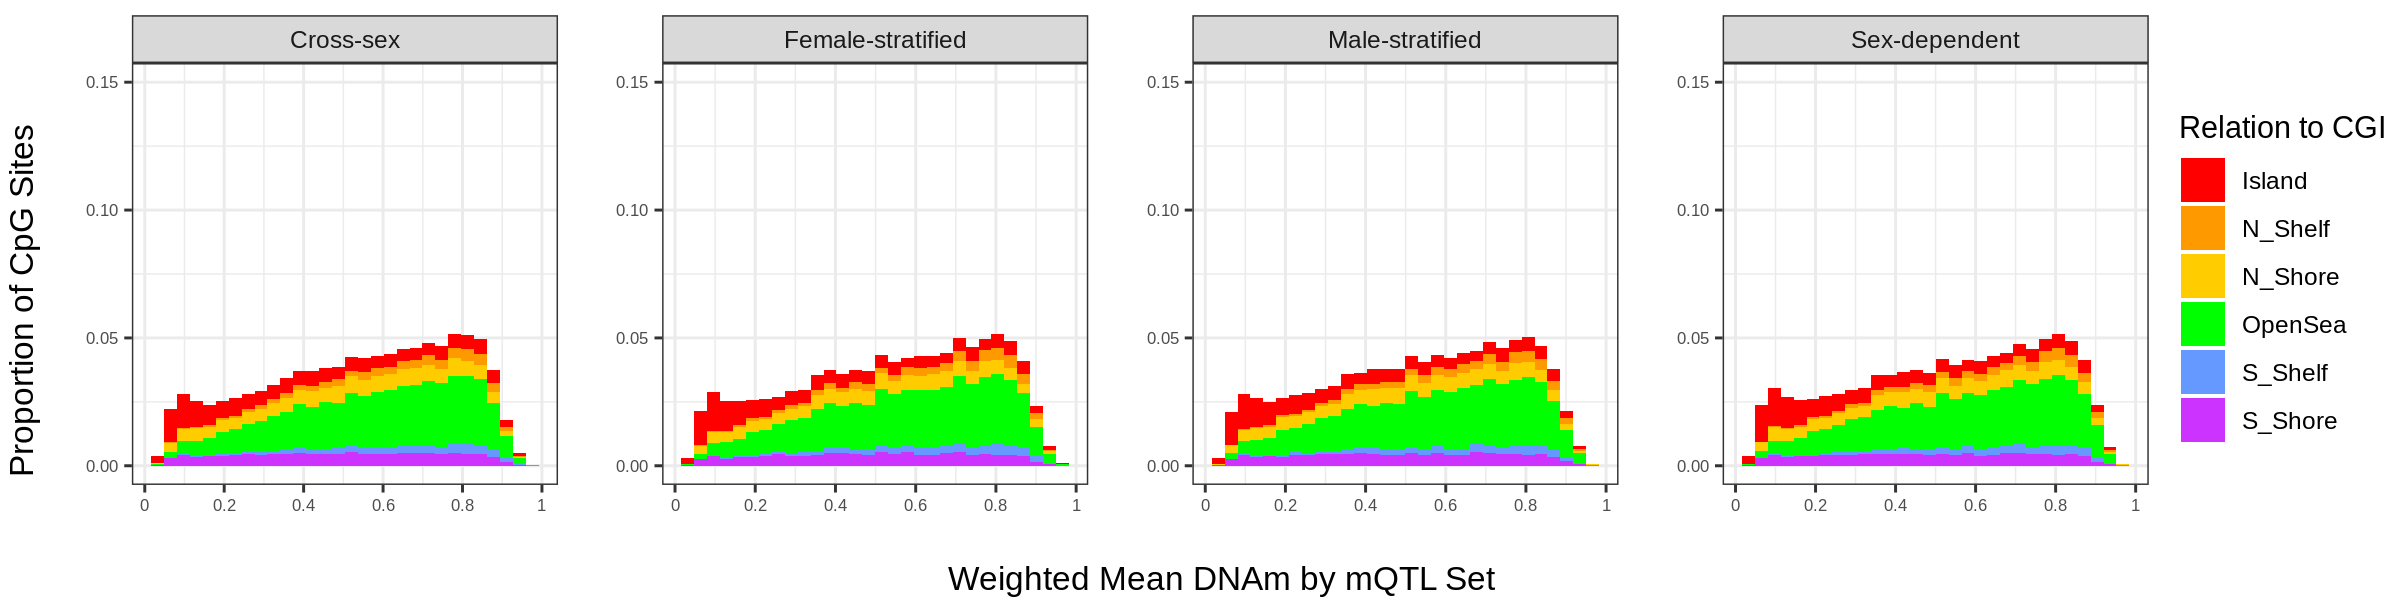

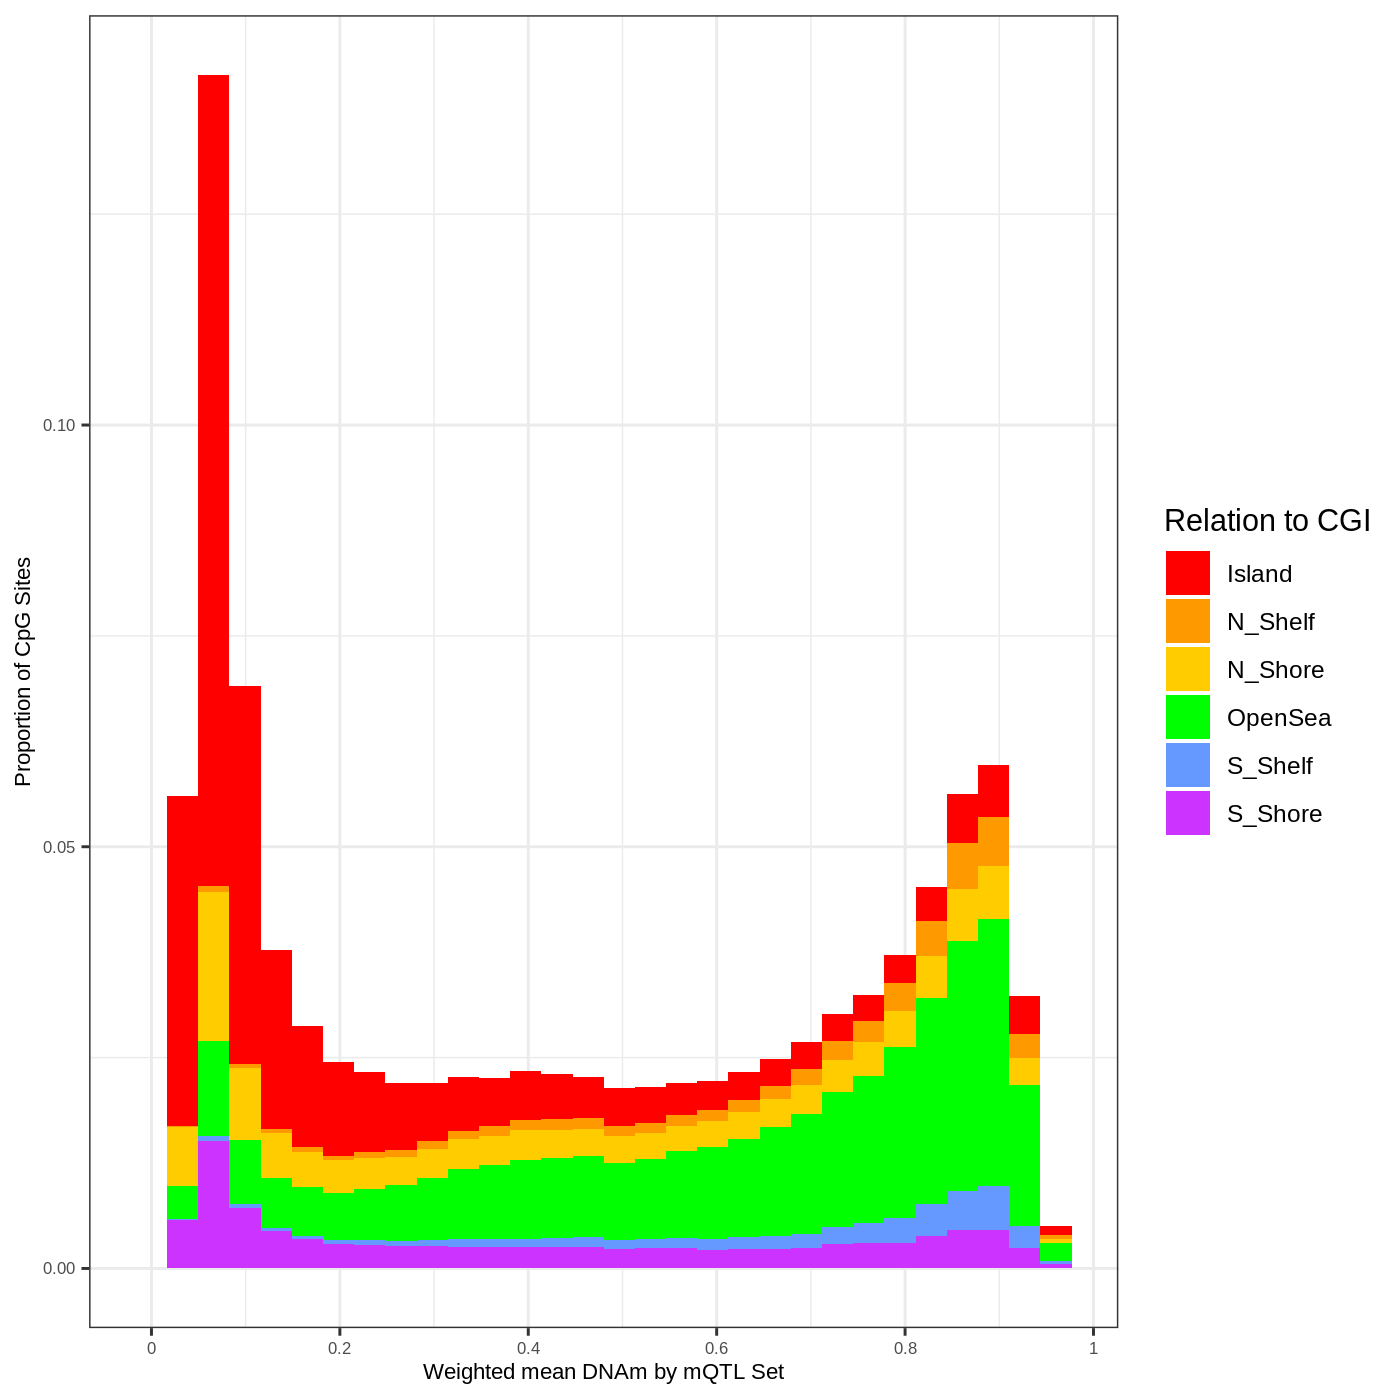

Sex                        
1 Cross-sex \n(n = 49252)    
2 Female-specific \n(n = 255)
3 Male-specific \n(n = 351)  
4 Sex-dependent \n(n = 37360)
  high     
1 0.1563388
2 0.3098039
3 0.2136752
4 0.1585385
  intermediate
1 0.7234833   
2 0.5529412   
3 0.5954416   
4 0.7121788   
  low      
1 0.1201779
2 0.1372549
3 0.1908832
4 0.1292827

[1] "Islands"
[1] "High"


Using 'V2' as value column. Use 'value.var' to override



Sex                        
1 Cross-sex \n(n = 49252)    
2 Sex-dependent \n(n = 37360)
3 Male-specific \n(n = 351)  
4 Female-specific \n(n = 255)
  Island   
1 0.1266234
2 0.1166639
3 0.0800000
4 0.1012658
  N_Shelf   
1 0.09103896
2 0.09522202
3 0.06666667
4 0.10126582
  N_Shore  
1 0.1109091
2 0.1070404
3 0.0800000
4 0.1518987
  OpenSea  
1 0.5076623
2 0.5200068
3 0.5733333
4 0.5189873
  S_Shelf   
1 0.07415584
2 0.07816985
3 0.08000000
4 0.05063291
  S_Shore   
1 0.08961039
2 0.08289718
3 0.12000000
4 0.07594937

[1] "Intermediate"


Using 'V2' as value column. Use 'value.var' to override



Sex                        
1 Cross-sex \n(n = 49252)    
2 Sex-dependent \n(n = 37360)
3 Male-specific \n(n = 351)  
4 Female-specific \n(n = 255)
  Island   
1 0.1361098
2 0.1359793
3 0.2248804
4 0.1773050
  N_Shelf   
1 0.06291920
2 0.06366746
3 0.05263158
4 0.05673759
  N_Shore  
1 0.1494682
2 0.1440598
3 0.1339713
4 0.1205674
  OpenSea  
1 0.4768052
2 0.4832939
3 0.3923445
4 0.4326241
  S_Shelf   
1 0.05666096
2 0.05577480
3 0.05263158
4 0.08510638
  S_Shore  
1 0.1180367
2 0.1172248
3 0.1435407
4 0.1276596

[1] "Low"


Using 'V2' as value column. Use 'value.var' to override



Sex                        
1 Cross-sex \n(n = 49252)    
2 Sex-dependent \n(n = 37360)
3 Male-specific \n(n = 351)  
4 Female-specific \n(n = 255)
  Island   
1 0.4331813
2 0.4583851
3 0.7014925
4 0.6571429
  N_Shelf   
1 0.01706369
2 0.01842650
3 0.01492537
4 0.02857143
  N_Shore   
1 0.17705694
2 0.16438923
3 0.08955224
4 0.05714286
  OpenSea  
1 0.2121980
2 0.2109731
3 0.1044776
4 0.1428571
  S_Shelf   
1 0.01621896
2 0.01511387
3         NA
4         NA
  S_Shore   
1 0.14428113
2 0.13271222
3 0.08955224
4 0.11428571

[1] "Gene regions"
[1] "High"


Using 'V2' as value column. Use 'value.var' to override



Sex                        
1 Cross-sex \n(n = 49252)    
2 Sex-dependent \n(n = 37360)
3 Male-specific \n(n = 351)  
4 Female-specific \n(n = 255)
  1stExon  
1 0.0125974
2 0.0101300
3        NA
4        NA
  3'UTR     
1 0.06064935
2 0.06280601
3 0.08000000
4 0.06329114
  5'UTR     
1 0.06103896
2 0.06061118
3 0.08000000
4 0.02531646
  Body     
1 0.5112987
2 0.5144353
3 0.5600000
4 0.5316456
  Intergenic
1 0.2528571 
2 0.2503799 
3 0.1866667 
4 0.2531646 
  TSS1500   
1 0.08000000
2 0.08036468
3 0.06666667
4 0.07594937
  TSS200    
1 0.02155844
2 0.02127300
3 0.02666667
4 0.05063291

[1] "Intermediate"


Using 'V2' as value column. Use 'value.var' to override



Sex                        
1 Cross-sex \n(n = 49252)    
2 Sex-dependent \n(n = 37360)
3 Male-specific \n(n = 351)  
4 Female-specific \n(n = 255)
  1stExon   
1 0.02354559
2 0.02296388
3 0.04306220
4 0.02836879
  3'UTR     
1 0.03726882
2 0.03814786
3 0.02392344
4 0.04255319
  5'UTR     
1 0.06600623
2 0.06573458
3 0.11961722
4 0.04964539
  Body     
1 0.3653074
2 0.3662570
3 0.3732057
4 0.3829787
  Intergenic
1 0.3284876 
2 0.3265682 
3 0.2966507 
4 0.3049645 
  TSS1500  
1 0.1314792
2 0.1320329
3 0.0861244
4 0.1489362
  TSS200    
1 0.04790503
2 0.04829556
3 0.05741627
4 0.04255319

[1] "Low"


Using 'V2' as value column. Use 'value.var' to override



Sex                        
1 Cross-sex \n(n = 49252)    
2 Sex-dependent \n(n = 37360)
3 Male-specific \n(n = 351)  
4 Female-specific \n(n = 255)
  1stExon   
1 0.04679845
2 0.05196687
3 0.05970149
4 0.05714286
  3'UTR     
1 0.01115053
2 0.01262940
3 0.02985075
4 0.02857143
  5'UTR     
1 0.10255111
2 0.10434783
3 0.14925373
4 0.08571429
  Body     
1 0.2181112
2 0.2084886
3 0.1641791
4 0.1142857
  Intergenic
1 0.2263896 
2 0.2256729 
3 0.1791045 
4 0.2857143 
  TSS1500  
1 0.2321338
2 0.2219462
3 0.1641791
4 0.2000000
  TSS200   
1 0.1628653
2 0.1749482
3 0.2537313
4 0.2285714

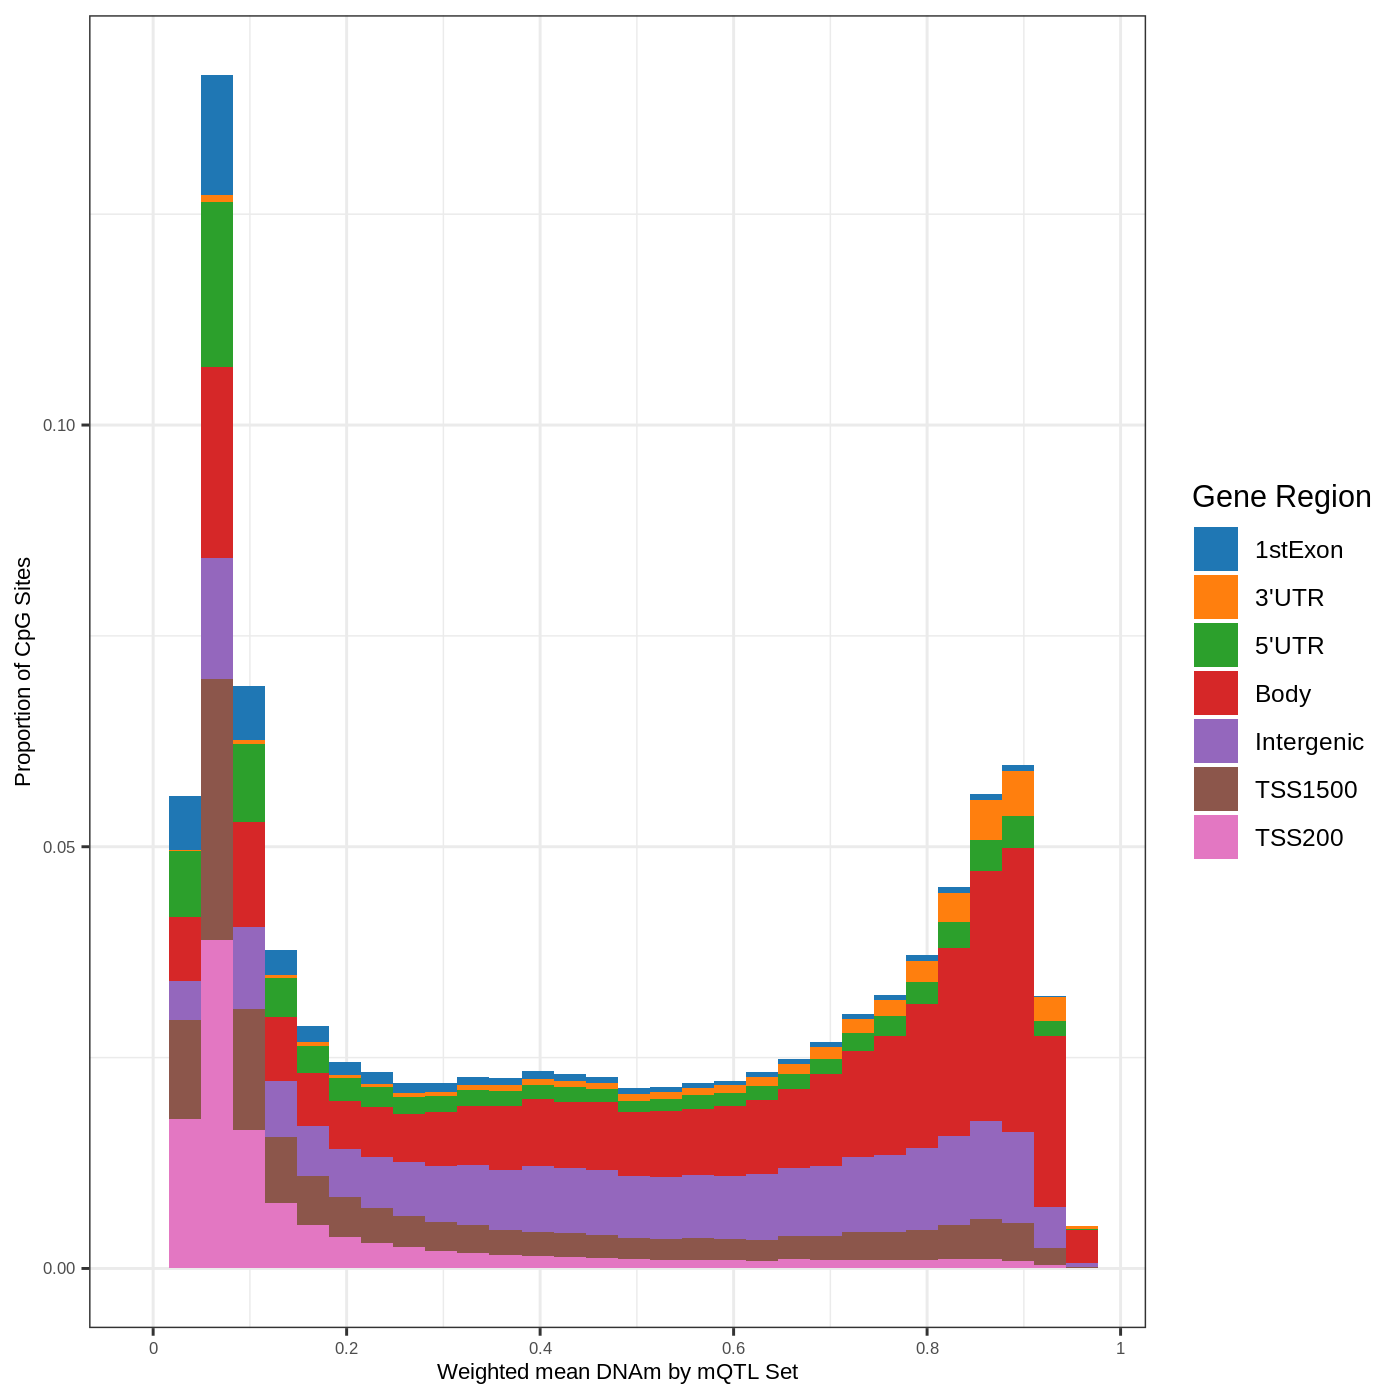

In [33]:
options(repr.plot.width= 12, repr.plot.height= 3, repr.plot.res = 200)
library(ggsci)
library(glue)
no_mQTL$Sex <- "No mQTL"
to_plot_specific <- unique(means_specific[Sex != "Sex-dependent",.(Probe,Relation_to_Island,Sex,mean_DNAm,UCSC_RefGene_Group)])
to_plot_specific <- rbind(
    to_plot_specific,
    unique(means_strat[Sex == "Sex-dependent",.(Probe,Relation_to_Island,UCSC_RefGene_Group,Sex,mean_DNAm)]),
    unique(no_mQTL[,.(Probe=V1,Relation_to_Island,UCSC_RefGene_Group,Sex,mean_DNAm)])
)
to_plot_specific[,`:=`(group_size = .N),by="Sex"]
to_plot_specific[,`:=`(Sex = paste0(Sex," \n(n = ",group_size,")"))]

to_plot_specific[,`:=`(Sex=
    factor(
        Sex,
        levels=c(
   #         "No mQTL \n(n = 398004)",
            'Cross-sex \n(n = 49252)',
            'Sex-dependent \n(n = 37360)',
            'Male-specific \n(n = 351)',
            'Female-specific \n(n = 255)'
            
)))]
to_plot_specific <- to_plot_specific[Sex != "No mQTL \n(n = 398004)" ]
library(gridExtra)
library(ggpubr)
grp_plots <- by(to_plot_specific, to_plot_specific$Sex, function(sub){
  ggplot(sub, aes(mean_DNAm,fill=Relation_to_Island)) + 
    geom_histogram(aes(y = (..count..)/sum(..count..)), bins=30) + 
    facet_wrap(~Sex) +
    scale_x_continuous(breaks = seq(0,1,0.2),labels = seq(0,1,0.2)) +
    coord_cartesian(ylim=c(0,0.15))+
    scale_fill_ucscgb() + 
    labs(x= "",y="",fill="Relation to CGI")+
    theme_bw() +
    theme(axis.text = element_text(size=6),axis.title = element_text(size=8))
})
annotate_figure(
    ggarrange(plotlist = grp_plots,common.legend=TRUE,legend = "right",nrow=1),
    left = textGrob("Proportion of CpG Sites",rot=90,),
    bottom= textGrob("Weighted Mean DNAm by mQTL Set")
)

grp_plots <- by(to_plot_specific, to_plot_specific$Sex, function(sub){
  ggplot(sub, aes(mean_DNAm,color="black")) + 
    geom_density() + 
    facet_wrap(~Sex) +
    scale_color_manual(values="black")+
    scale_x_continuous(breaks = seq(0,1,0.2),labels = seq(0,1,0.2)) +
    labs(x= "",y="",color="Gene Region")+
    theme_bw() +
    theme(axis.text = element_text(size=6),axis.title = element_text(size=8))
})
annotate_figure(
    ggarrange(plotlist = grp_plots,common.legend=TRUE,legend = "right",nrow=1),
    left = textGrob("Density",rot=90,),
    bottom= textGrob("Weighted Mean DNAm by mQTL Set")
)

options(repr.plot.width= 10, repr.plot.height= 10, repr.plot.res = 200)
annotate_figure(
    ggarrange(plotlist = grp_plots,common.legend=TRUE),
    left = textGrob("Proportion of CpG Sites",rot=90,),
    bottom= textGrob("Weighted Mean DNAm by mQTL Set")
)    
options(repr.plot.width= 12, repr.plot.height= 3, repr.plot.res = 200)

ggplot(
    to_plot_specific,
    aes(mean_DNAm)) + 
    facet_wrap(~Sex,nrow=1)+
    geom_density()+
    scale_x_continuous(breaks = seq(0,1,0.2),labels = seq(0,1,0.2)) +
    labs(x= "Weighted mean DNAm",y = "Density")+
    theme_bw()

grp_plots <- by(to_plot_specific, to_plot_specific$Sex, function(sub){
  ggplot(sub, aes(mean_DNAm,fill=sapply(gsub(";.*","",UCSC_RefGene_Group),function(x)ifelse(x == "","Intergenic",x)))) + 
    geom_histogram(aes(y = (..count..)/sum(..count..)), bins=30) + 
    facet_wrap(~Sex) +
    scale_x_continuous(breaks = seq(0,1,0.2),labels = seq(0,1,0.2)) +
    coord_cartesian(ylim=c(0,0.15))+
    scale_fill_d3() + 
    labs(x= "",y="",fill="Gene Region")+
    theme_bw() +
    theme(axis.text = element_text(size=6),axis.title = element_text(size=8))
})
annotate_figure(
    ggarrange(plotlist = grp_plots,common.legend=TRUE,legend = "right",nrow=1),
    left = textGrob("Proportion of CpG Sites",rot=90,),
    bottom= textGrob("Weighted Mean DNAm by mQTL Set")
)
options(repr.plot.width= 10, repr.plot.height= 10, repr.plot.res = 200)
annotate_figure(
    ggarrange(plotlist = grp_plots,common.legend=TRUE),
    left = textGrob("Proportion of CpG Sites",rot=90,),
    bottom= textGrob("Weighted Mean DNAm by mQTL Set")
) 
options(repr.plot.width= 12, repr.plot.height= 3, repr.plot.res = 200)
                  
to_plot_specific[,`:=`(UCSC_RefGene_Group= sapply(gsub(";.*","",UCSC_RefGene_Group),function(x)ifelse(x == "","Intergenic",x)))]
strat_plot <- unique(means_strat[,.(Probe,Relation_to_Island,Sex,mean_DNAm)])
grp_plots <- by(strat_plot, strat_plot$Sex, function(sub){
  ggplot(sub, aes(mean_DNAm,fill=Relation_to_Island)) + 
    geom_histogram(aes(y = (..count..)/sum(..count..)), bins=30) + 
    facet_wrap(~Sex) +
    scale_x_continuous(breaks = seq(0,1,0.2),labels = seq(0,1,0.2)) +
    coord_cartesian(ylim=c(0,0.15))+
    scale_fill_ucscgb() + 
    labs(x= "",y="",fill="Relation to CGI")+
    theme_bw() +
    theme(axis.text = element_text(size=6),axis.title = element_text(size=8))
})
annotate_figure(
    ggarrange(plotlist = grp_plots,common.legend=TRUE,legend = "right",nrow=1),
    left = textGrob("Proportion of CpG Sites",rot=90,),
    bottom= textGrob("Weighted Mean DNAm by mQTL Set")
)
options(repr.plot.width= 7, repr.plot.height= 7, repr.plot.res = 200)
uniqueN(no_mQTL$Name)
ggplot(
    unique(no_mQTL[,.(Name,Relation_to_Island,mean_DNAm)]),
    aes(mean_DNAm,fill=Relation_to_Island)) + 
    geom_histogram(aes(y=..count../sum(..count..)),bins=30) +
    scale_x_continuous(breaks = seq(0,1,0.2),labels = seq(0,1,0.2)) +
    scale_fill_ucscgb() + 
    labs(x= "Weighted mean DNAm by mQTL Set",y="Proportion of CpG Sites",fill="Relation to CGI")+
    theme_bw() +
    theme(axis.text = element_text(size=6),axis.title = element_text(size=8))
ggplot(
    unique(no_mQTL[,.(Name,UCSC_RefGene_Group,mean_DNAm)]),
    aes(mean_DNAm,fill = sapply(gsub(";.*","",UCSC_RefGene_Group),function(x)ifelse(x == "","Intergenic",x)))) + 
    geom_histogram(aes(y=..count../sum(..count..)),bins=30) +
    scale_x_continuous(breaks = seq(0,1,0.2),labels = seq(0,1,0.2)) +
    scale_fill_d3() + 
    labs(x= "Weighted mean DNAm by mQTL Set",y="Proportion of CpG Sites",fill="Gene Region")+
    theme_bw() +
    theme(axis.text = element_text(size=6),axis.title = element_text(size=8)) 
                                                       

to_plot_specific[,.(
    high = sum(mean_DNAm > 0.8 ) / .N,
    intermediate = sum(0.8 > mean_DNAm & mean_DNAm > 0.2 ) / .N,
    low = sum(mean_DNAm < 0.2 ) / .N
),by="Sex"]

print("Islands")
print("High")
dcast(to_plot_specific[mean_DNAm > 0.8,.( .N), by=c("Sex","Relation_to_Island")][,.(Relation_to_Island,N / sum(N)),by="Sex"],Sex~Relation_to_Island)
print("Intermediate")
dcast(to_plot_specific[mean_DNAm < 0.8 & mean_DNAm > 0.2,.( .N), by=c("Sex","Relation_to_Island")][,.(Relation_to_Island,N / sum(N)),by="Sex"],Sex~Relation_to_Island)
print("Low")
dcast(to_plot_specific[mean_DNAm < 0.2,.(.N), by=c("Sex","Relation_to_Island")][,.(Relation_to_Island,N / sum(N)),by="Sex"],Sex~Relation_to_Island)

print("Gene regions")
print("High")
dcast(to_plot_specific[mean_DNAm > 0.8,.( .N), by=c("Sex","UCSC_RefGene_Group")][,.(UCSC_RefGene_Group,N / sum(N)),by="Sex"],Sex~UCSC_RefGene_Group)
print("Intermediate")
dcast(to_plot_specific[mean_DNAm < 0.8 & mean_DNAm > 0.2,.( .N), by=c("Sex","UCSC_RefGene_Group")][,.(UCSC_RefGene_Group,N / sum(N)),by="Sex"],Sex~UCSC_RefGene_Group)
print("Low")
dcast(to_plot_specific[mean_DNAm < 0.2,.(.N), by=c("Sex","UCSC_RefGene_Group")][,.(UCSC_RefGene_Group,N / sum(N)),by="Sex"],Sex~UCSC_RefGene_Group)

###  Checking some correlations between probes assessed in proportion comparison

In [ ]:
mean(abs(cor(t(delahaye_DNAm[cpg %in% unique(male_int$Probe),-c("cpg")]),method="spearman")))
mean(abs(cor(t(delahaye_DNAm[cpg %in% unique(female_int$Probe),-c("cpg")]),method="spearman")))
mean(abs(cor(t(delahaye_DNAm[cpg %in% unique(marginal$Probe),-c("cpg")]),method="spearman")))
mean(abs(cor(t(delahaye_DNAm[cpg %in% unique(sex_interaction$Probe),-c("cpg")]),method="spearman")))

In [ ]:
mean(abs(cor(t(richs_DNAm[cpg %in% unique(male_int$Probe),-c("cpg")]),method="spearman")))
mean(abs(cor(t(richs_DNAm[cpg %in% unique(female_int$Probe),-c("cpg")]),method="spearman")))
mean(abs(cor(t(richs_DNAm[cpg %in% unique(marginal$Probe),-c("cpg")]),method="spearman")))
mean(abs(cor(t(richs_DNAm[cpg %in% unique(sex_interaction$Probe),-c("cpg")]),method="spearman")))

###  Correlations per Chromosome

In [51]:
per_chrom_cor <- list(
    male_int_delahaye = list(),
    female_int_delahaye = list(),
    marginal_delahaye = list(),
    sex_interaction_delahaye = list(),
    male_int_richs = list(),
    female_int_richs = list(),
    marginal_richs = list(),
    sex_interaction_richs = list()
)
for(chr in c(1:23)){
    per_chrom_cor[["male_int_delahaye"]][[chr]] <- mean(abs(cor(t(delahaye_DNAm[cpg %in% unique(male_int[Chr == chr]$Probe), -c("cpg")]),method = "spearman")))
    per_chrom_cor[["female_int_delahaye"]][[chr]] <- mean(abs(cor(t(delahaye_DNAm[cpg %in% unique(female_int[Chr == chr]$Probe), -c("cpg")]),method = "spearman")))
    per_chrom_cor[["marginal_delahaye"]][[chr]] <- mean(abs(cor(t(delahaye_DNAm[cpg %in% unique(marginal[Chr == chr]$Probe), -c("cpg")]),method = "spearman")))
    per_chrom_cor[["sex_interaction_delahaye"]][[chr]] <- mean(abs(cor(t(delahaye_DNAm[cpg %in% unique(sex_interaction[Chr == chr]$Probe), -c("cpg")]),method = "spearman")))
    per_chrom_cor[["male_int_richs"]][[chr]] <- mean(abs(cor(t(richs_DNAm[cpg %in% unique(male_int[Chr == chr]$Probe), -c("cpg")]),method = "spearman")))
    per_chrom_cor[["female_int_richs"]][[chr]] <- mean(abs(cor(t(richs_DNAm[cpg %in% unique(female_int[Chr == chr]$Probe), -c("cpg")]),method = "spearman")))
    per_chrom_cor[["marginal_richs"]][[chr]] <- mean(abs(cor(t(richs_DNAm[cpg %in% unique(marginal[Chr == chr]$Probe), -c("cpg")]),method = "spearman")))
    per_chrom_cor[["sex_interaction_richs"]][[chr]] <- mean(abs(cor(t(richs_DNAm[cpg %in% unique(sex_interaction[Chr == chr]$Probe), -c("cpg")]),method = "spearman")))
    
}

In [54]:
lapply(per_chrom_cor,function(x) data.table(chr=1:23,corr= unlist(x)))


$male_int_delahaye
    chr
 1:   1
 2:   2
 3:   3
 4:   4
 5:   5
 6:   6
 7:   7
 8:   8
 9:   9
10:  10
11:  11
12:  12
13:  13
14:  14
15:  15
16:  16
17:  17
18:  18
19:  19
20:  20
21:  21
22:  22
23:  23
    chr
         corr
 1: 0.1232385
 2: 0.1534156
 3: 0.1620397
 4: 0.1889117
 5: 0.1870259
 6: 0.2100062
 7: 0.1534981
 8: 0.2065576
 9: 0.5201517
10: 0.1704307
11: 0.1706057
12: 0.1707204
13: 0.6762440
14: 0.1406720
15: 0.2270024
16: 0.1762385
17: 0.1437994
18: 0.6008182
19: 0.1898700
20: 0.1562840
21: 0.2213999
22: 0.4105264
23: 0.2600641
         corr

$female_int_delahaye
    chr
 1:   1
 2:   2
 3:   3
 4:   4
 5:   5
 6:   6
 7:   7
 8:   8
 9:   9
10:  10
11:  11
12:  12
13:  13
14:  14
15:  15
16:  16
17:  17
18:  18
19:  19
20:  20
21:  21
22:  22
23:  23
    chr
         corr
 1: 0.1264443
 2: 0.1898550
 3: 0.1791686
 4: 0.2482689
 5: 0.1649782
 6: 0.2248457
 7: 0.1598899
 8: 0.2330776
 9: 0.4572651
10: 0.1680357
11: 0.1782436
12: 0.1954246
13: 0.5314179
14: 0.4532831
15: 0.2479996
16: 0.1920709
17: 0.1674919
18: 0.3711953
19: 0.1670890
20: 0.2040790
21: 0.4369410
22: 0.5939578
23: 0.3768628
         corr

$marginal_delahaye
    chr
 1:   1
 2:   2
 3:   3
 4:   4
 5:   5
 6:   6
 7:   7
 8:   8
 9:   9
10:  10
11:  11
12:  12
13:  13
14:  14
15:  15
16:  16
17:  17
18:  18
19:  19
20:  20
21:  21
22:  22
23:  23
    chr
         corr
 1: 0.1118019
 2: 0.1036714
 3: 0.1059514
 4: 0.1054505
 5: 0.1034015
 6: 0.1045127
 7: 0.1050168
 8: 0.1049672
 9: 0.1142620
10: 0.1058052
11: 0.1096223
12: 0.1077287
13: 0.1040155
14: 0.1080339
15: 0.1078137
16: 0.1157349
17: 0.1121185
18: 0.1042430
19: 0.1106329
20: 0.1139591
21: 0.1108390
22: 0.1145908
23: 0.2621989
         corr

$sex_interaction_delahaye
    chr
 1:   1
 2:   2
 3:   3
 4:   4
 5:   5
 6:   6
 7:   7
 8:   8
 9:   9
10:  10
11:  11
12:  12
13:  13
14:  14
15:  15
16:  16
17:  17
18:  18
19:  19
20:  20
21:  21
22:  22
23:  23
    chr
         corr
 1: 0.1179228
 2: 0.1264567
 3: 0.1267467
 4: 0.1481774
 5: 0.1182400
 6: 0.1293460
 7: 0.1388520
 8: 0.1218310
 9: 0.1677617
10: 0.1349030
11: 0.1264821
12: 0.1276888
13: 0.1350280
14: 0.1361530
15: 0.1377727
16: 0.1469461
17: 0.1404412
18: 0.1434031
19: 0.1232113
20: 0.1273183
21: 0.1724039
22: 0.1871252
23: 0.3247090
         corr

$male_int_richs
    chr
 1:   1
 2:   2
 3:   3
 4:   4
 5:   5
 6:   6
 7:   7
 8:   8
 9:   9
10:  10
11:  11
12:  12
13:  13
14:  14
15:  15
16:  16
17:  17
18:  18
19:  19
20:  20
21:  21
22:  22
23:  23
    chr
          corr
 1: 0.09994228
 2: 0.13501488
 3: 0.13737989
 4: 0.17651741
 5: 0.17339159
 6: 0.17056241
 7: 0.13018829
 8: 0.19251531
 9: 0.56399036
10: 0.13852217
11: 0.16233237
12: 0.14257562
13: 0.70957041
14: 0.12655330
15: 0.22016151
16: 0.13432052
17: 0.13055724
18: 0.67478607
19: 0.15855714
20: 0.13696429
21: 0.22522025
22: 0.37583515
23: 0.25005014
          corr

$female_int_richs
    chr
 1:   1
 2:   2
 3:   3
 4:   4
 5:   5
 6:   6
 7:   7
 8:   8
 9:   9
10:  10
11:  11
12:  12
13:  13
14:  14
15:  15
16:  16
17:  17
18:  18
19:  19
20:  20
21:  21
22:  22
23:  23
    chr
         corr
 1: 0.1012908
 2: 0.1784419
 3: 0.1374229
 4: 0.1846734
 5: 0.1185253
 6: 0.1579967
 7: 0.1488040
 8: 0.1954949
 9: 0.3873732
10: 0.1577537
11: 0.1420781
12: 0.1700536
13: 0.5228089
14: 0.3837134
15: 0.2340812
16: 0.1621894
17: 0.1459382
18: 0.3802747
19: 0.1487036
20: 0.1886133
21: 0.3246957
22: 0.5606203
23: 0.3057031
         corr

$marginal_richs
    chr
 1:   1
 2:   2
 3:   3
 4:   4
 5:   5
 6:   6
 7:   7
 8:   8
 9:   9
10:  10
11:  11
12:  12
13:  13
14:  14
15:  15
16:  16
17:  17
18:  18
19:  19
20:  20
21:  21
22:  22
23:  23
    chr
          corr
 1: 0.08932412
 2: 0.08392102
 3: 0.08707555
 4: 0.08255769
 5: 0.08017070
 6: 0.08054203
 7: 0.07965914
 8: 0.08247698
 9: 0.08979367
10: 0.08410678
11: 0.08616905
12: 0.08427299
13: 0.08171809
14: 0.08410131
15: 0.08706675
16: 0.08894591
17: 0.08907963
18: 0.08042439
19: 0.07924621
20: 0.08951621
21: 0.09215995
22: 

merge                   package:base                   R Documentation

_M_e_r_g_e _T_w_o _D_a_t_a _F_r_a_m_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Merge two data frames by common columns or row names, or do other
     versions of database _join_ operations.

_U_s_a_g_e:

     merge(x, y, ...)
     
     ## Default S3 method:
     merge(x, y, ...)
     
     ## S3 method for class 'data.frame'
     merge(x, y, by = intersect(names(x), names(y)),
           by.x = by, by.y = by, all = FALSE, all.x = all, all.y = all,
           sort = TRUE, suffixes = c(".x",".y"), no.dups = TRUE,
           incomparables = NULL, ...)
     
_A_r_g_u_m_e_n_t_s:

    x, y: data frames, or objects to be coerced to one.

by, by.x, by.y: specifications of the columns used for merging.  See
          ‘Details’.

     all: logical; ‘all = L’ is shorthand for ‘all.x = L’ and ‘all.y =
          L’, where ‘L’ is either ‘TRUE’ or ‘FALSE’.

   all.x: logical; if ‘TRUE’, then extra rows will be added to the
          output, one for each row in ‘x’ that has no matching row in
          ‘y’.  These rows will have ‘NA’s in those columns that are
          usually filled with values from ‘y’.  The default is ‘FALSE’,
          so that only rows with data from both ‘x’ and ‘y’ are
          included in the output.

   all.y: logical; analogous to ‘all.x’.

    sort: logical.  Should the result be sorted on the ‘by’ columns?

suffixes: a character vector of length 2 specifying the suffixes to be
          used for making unique the names of columns in the result
          which are not used for merging (appearing in ‘by’ etc).

 no.dups: logical indicating that ‘suffixes’ are appended in more cases
          to avoid duplicated column names in the result.  This was
          implicitly false before R version 3.5.0.

incomparables: values which cannot be matched.  See ‘match’.  This is
          intended to be used for merging on one column, so these are
          incomparable values of that column.

     ...: arguments to be passed to or from methods.

_D_e_t_a_i_l_s:

     ‘merge’ is a generic function whose principal method is for data
     frames: the default method coerces its arguments to data frames
     and calls the ‘"data.frame"’ method.

     By default the data frames are merged on the columns with names
     they both have, but separate specifications of the columns can be
     given by ‘by.x’ and ‘by.y’.  The rows in the two data frames that
     match on the specified columns are extracted, and joined together.
     If there is more than one match, all possible matches contribute
     one row each.  For the precise meaning of ‘match’, see ‘match’.

     Columns to merge on can be specified by name, number or by a
     logical vector: the name ‘"row.names"’ or the number ‘0’ specifies
     the row names.  If specified by name it must correspond uniquely
     to a named column in the input.

     If ‘by’ or both ‘by.x’ and ‘by.y’ are of length 0 (a length zero
     vector or ‘NULL’), the result, ‘r’, is the _Cartesian product_ of
     ‘x’ and ‘y’, i.e., ‘dim(r) = c(nrow(x)*nrow(y), ncol(x) +
     ncol(y))’.

     If ‘all.x’ is true, all the non matching cases of ‘x’ are appended
     to the result as well, with ‘NA’ filled in the corresponding
     columns of ‘y’; analogously for ‘all.y’.

     If the columns in the data frames not used in merging have any
     common names, these have ‘suffixes’ (‘".x"’ and ‘".y"’ by default)
     appended to try to make the names of the result unique.  If this
     is not possible, an error is thrown.

     If a ‘by.x’ column name matches one of ‘y’, and if ‘no.dups’ is
     true (as by default), the y version gets suffixed as well,
     avoiding duplicate column names in the result.

     The complexity of the algorithm used is proportional to the length
     of the answer.

     In SQL database terminology, the default value of ‘all = FALSE’
     gives a _natural join_

## Gene enrichments

In [22]:
total_annotated <- fread(here("data","total_annotated.csv.gz"))
total_annotated_strat <- fread(here("data","total_annotated_strat.csv.gz"))
array_genes <- unique(unlist(split(array_annot$UCSC_RefGene_Name,";")))

gtex_med_counts <- fread("/scratch/st-dennisjk-1/wcasazza/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz",skip = 2)[Description %in% array_genes]
sex_genes <- unique(unlist(split(total_annotated[Sex == "Sex dependent"]$UCSC_RefGene_Name,";")))
male_genes <- unique(unlist(split(total_annotated[Sex == "Male specific"]$UCSC_RefGene_Name,";")))
female_genes <- unique(unlist(split(total_annotated[Sex == "Female specific"]$UCSC_RefGene_Name,";")))
male_strat_genes <- unique(unlist(split(total_annotated_strat[Sex == "Male stratified"]$UCSC_RefGene_Name,";")))
female_strat_genes <- unique(unlist(split(total_annotated_strat[Sex == "Female stratified"]$UCSC_RefGene_Name,";")))

marginal_genes <- unique(unlist(split(total_annotated[Sex == "Cross-sex"]$UCSC_RefGene_Name,";")))
gtex_fisher_res <- function(set,tpm_thresh){
    select_genes <- gtex_med_counts[apply(gtex_med_counts[,-c(1,2)] > tpm_thresh,1,all)]$Description
    res <- fisher.test(fisher_mat(set,select_genes,array_genes))
    data.table(
        OR = res$estimate,
        low = res$conf.int[1],
        high = res$conf.int[2],
        P = res$p.value,
        TPM_threshold = tpm_thresh
    )
}

GeneSet          
1 Cross-sex        
2 Sex-dependent    
3 Male-specific    
4 Female-specific  
5 Male-stratified  
6 Female-stratified
  1            
1 2.801171e-141
2  4.657044e-05
3  5.003753e-04
4  3.134065e-03
5 8.275159e-113
6  1.842620e-85
  2           
1 8.957350e-91
2 4.908543e-04
3 1.761274e-03
4 1.510052e-02
5 1.286136e-72
6 9.641431e-54
  5           
1 3.506077e-43
2 1.600534e-02
3 1.451485e-01
4 1.504233e-02
5 3.594124e-33
6 6.917366e-26
  10          
1 2.106885e-17
2 8.580003e-01
3 3.840195e-01
4 3.115698e-01
5 6.797992e-12
6 9.747061e-09
  15          
1 2.184716e-07
2 6.411559e-01
3 2.705662e-01
4 1.000000e+00
5 2.873377e-04
6 3.218288e-03
  20         
1 0.001488490
2 0.775642490
3 0.286404887
4 0.683302615
5 0.002340871
6 0.032868950

GeneSet          
1 Cross-sex        
2 Sex-dependent    
3 Male-specific    
4 Female-specific  
5 Male-stratified  
6 Female-stratified
  1       
1 2.215660
2 1.893973
3 1.927837
4 1.890396
5 2.131974
6 1.990712
  2       
1 2.027816
2 1.819771
3 1.919531
4 1.791062
5 1.961240
6 1.831914
  5       
1 1.870096
2 1.719220
3 1.499132
4 2.022995
5 1.793227
6 1.709907
  10       
1 1.6954519
2 0.8747037
3 0.5464555
4 1.4777425
5 1.5831064
6 1.4971608
  15       
1 1.5117547
2 0.6117724
3 0.2985898
4 0.7929524
5 1.3732328
6 1.3099454
  20       
1 1.3713659
2 0.6194094
3 0.0000000
4 1.2101193
5 1.3852812
6 1.2730089

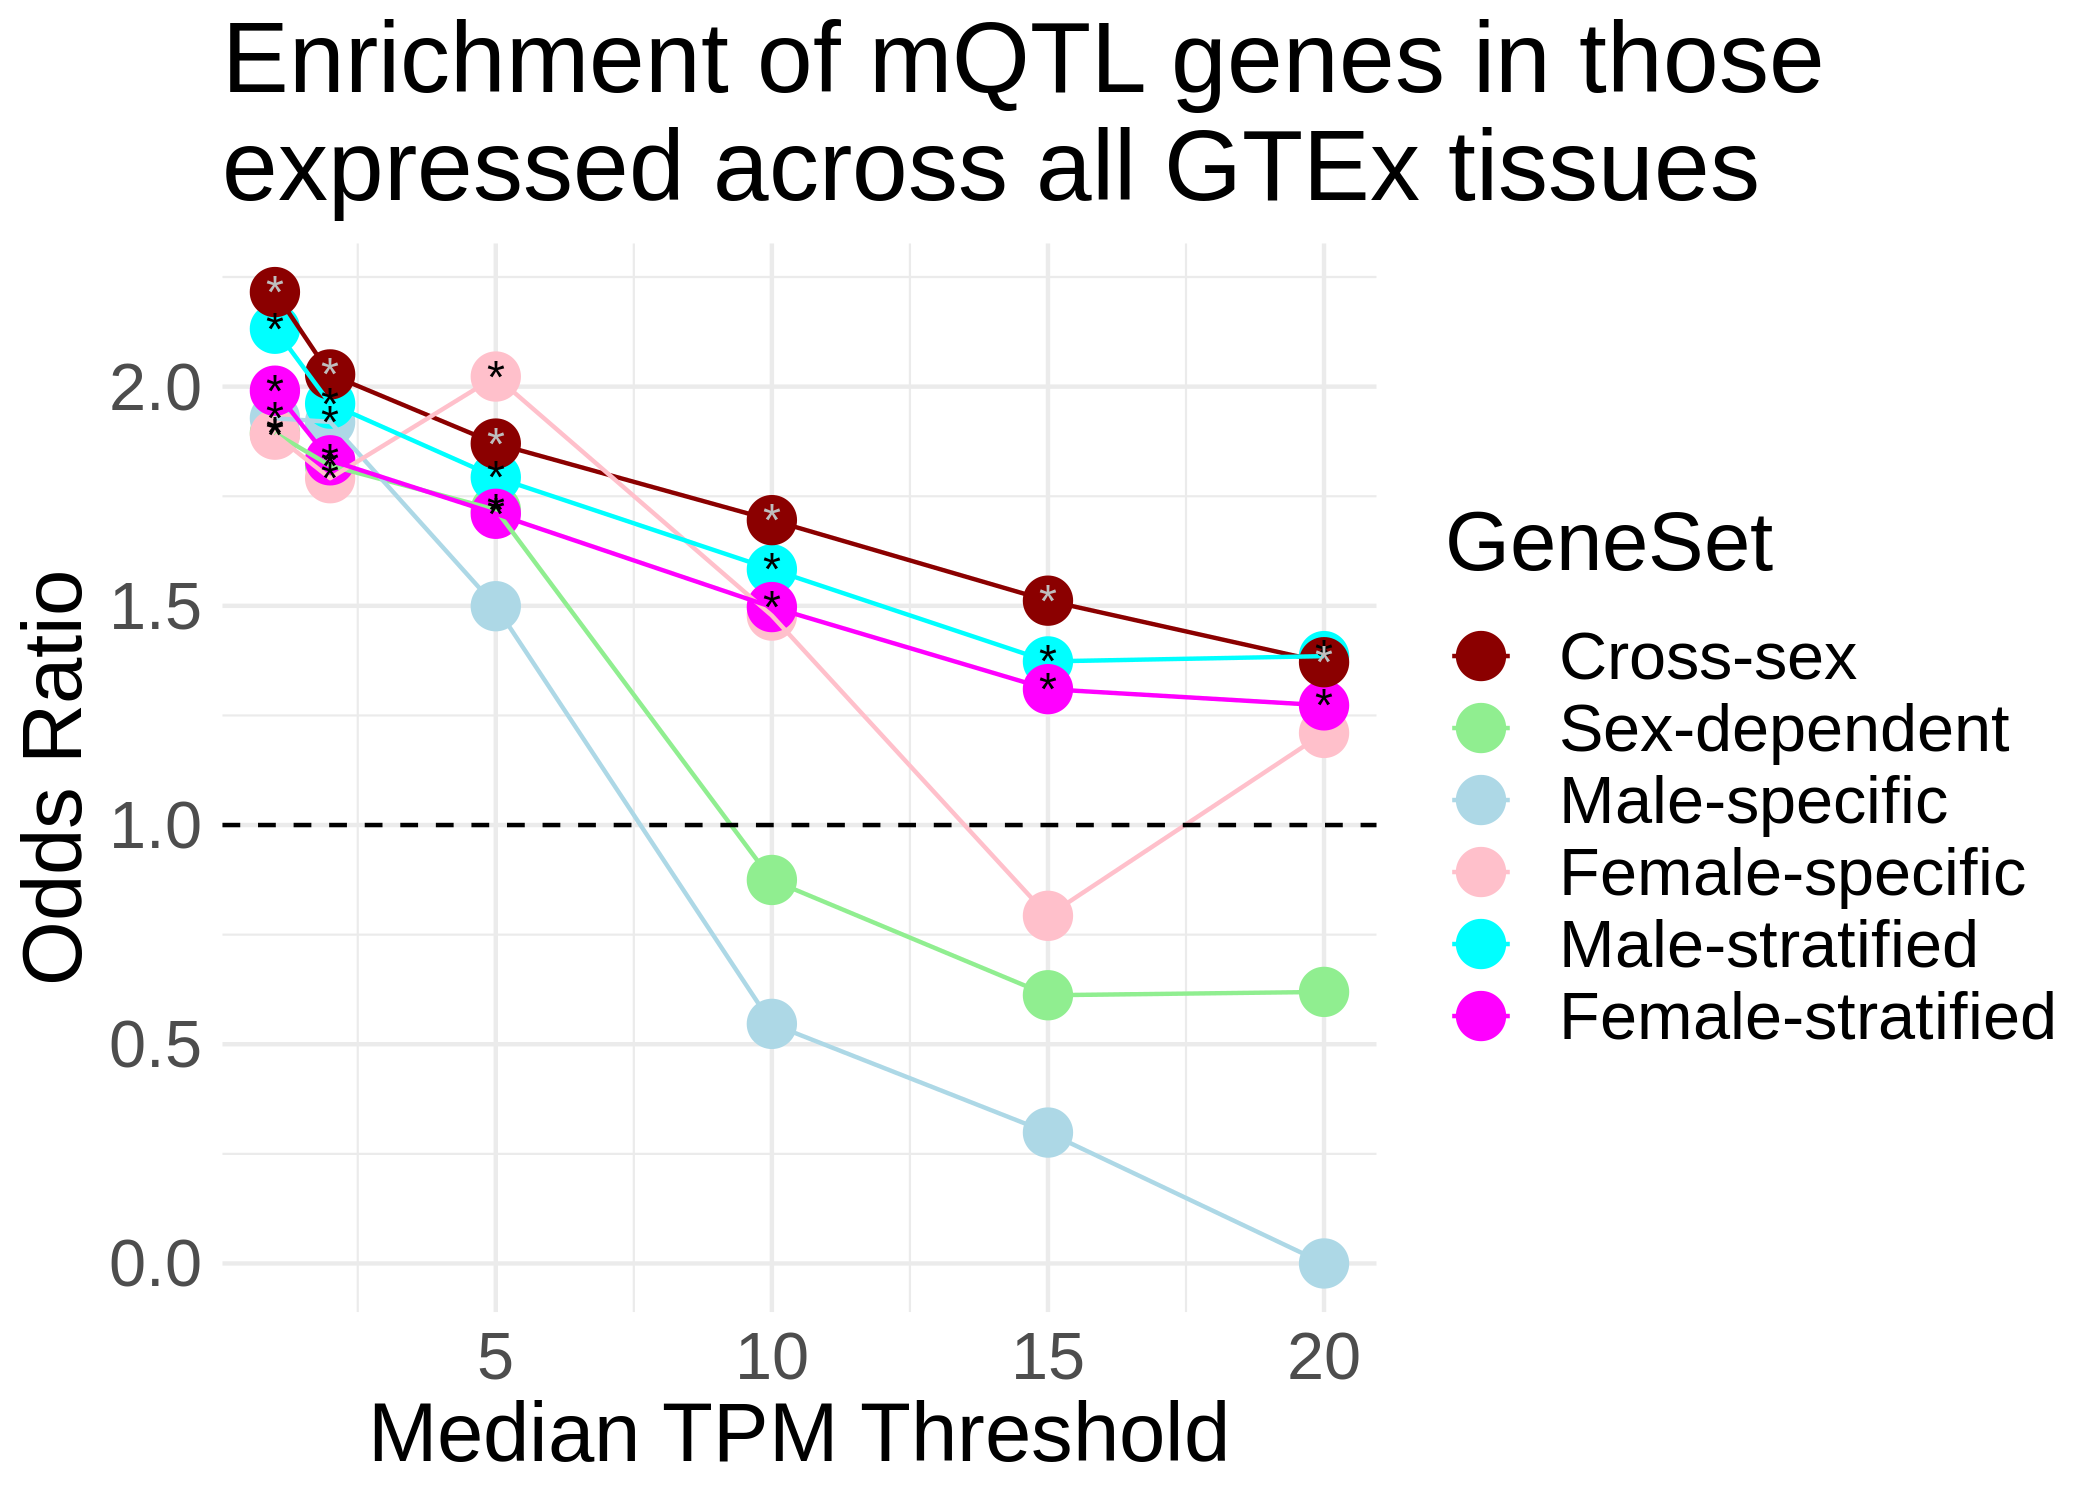

In [9]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)

fisher_mat <- function(set1,set2,background){
    notset1 <- background[!background %in% set1]
    notset2 <- background[!background %in% set2]    
    res <- matrix(
        c(
            length(intersect(set1,set2)),
            length(intersect(notset1,set2)),
            length(intersect(set1,notset2)),
            length(intersect(notset1,notset2))
        ),
        byrow=T,
        nrow = 2
    )
    return(res)
}
res <- rbindlist(lapply(c(1,2,5,10,15,20),function(thresh)rbindlist(lapply(list(`Sex-dependent`=sex_genes,"Male-specific"=male_genes,"Female-specific"=female_genes, "Male-stratified"=male_strat_genes, "Female-stratified" = female_strat_genes,`Cross-sex`=marginal_genes),function(x)gtex_fisher_res(x,thresh)),idcol = 'GeneSet')))
res$GeneSet <- factor(res$GeneSet, levels = c("Cross-sex","Sex-dependent","Male-specific","Female-specific","Male-stratified", "Female-stratified"))
p <- ggplot(res,aes(TPM_threshold, y=OR, color=GeneSet)) +
    geom_point(size=5) +
    geom_line(aes(y=OR))+
    geom_text(aes(label=ifelse(P < 0.05,"*","")),color=ifelse(res$GeneSet == "Cross-sex","gray","black"))+
    geom_hline(yintercept = 1,linetype='dashed') +
    labs(
        title = "Enrichment of mQTL genes in those\nexpressed across all GTEx tissues",
        x = "Median TPM Threshold",
        y = "Odds Ratio"
    )+
    scale_color_manual(values=c("dark red","light green","light blue", "pink", "cyan", "magenta" ))+
    theme_minimal() +
    theme(text=element_text(size=20))
print(p)
dcast(res,GeneSet~TPM_threshold,value.var="P")
dcast(res,GeneSet~TPM_threshold,value.var="OR")  

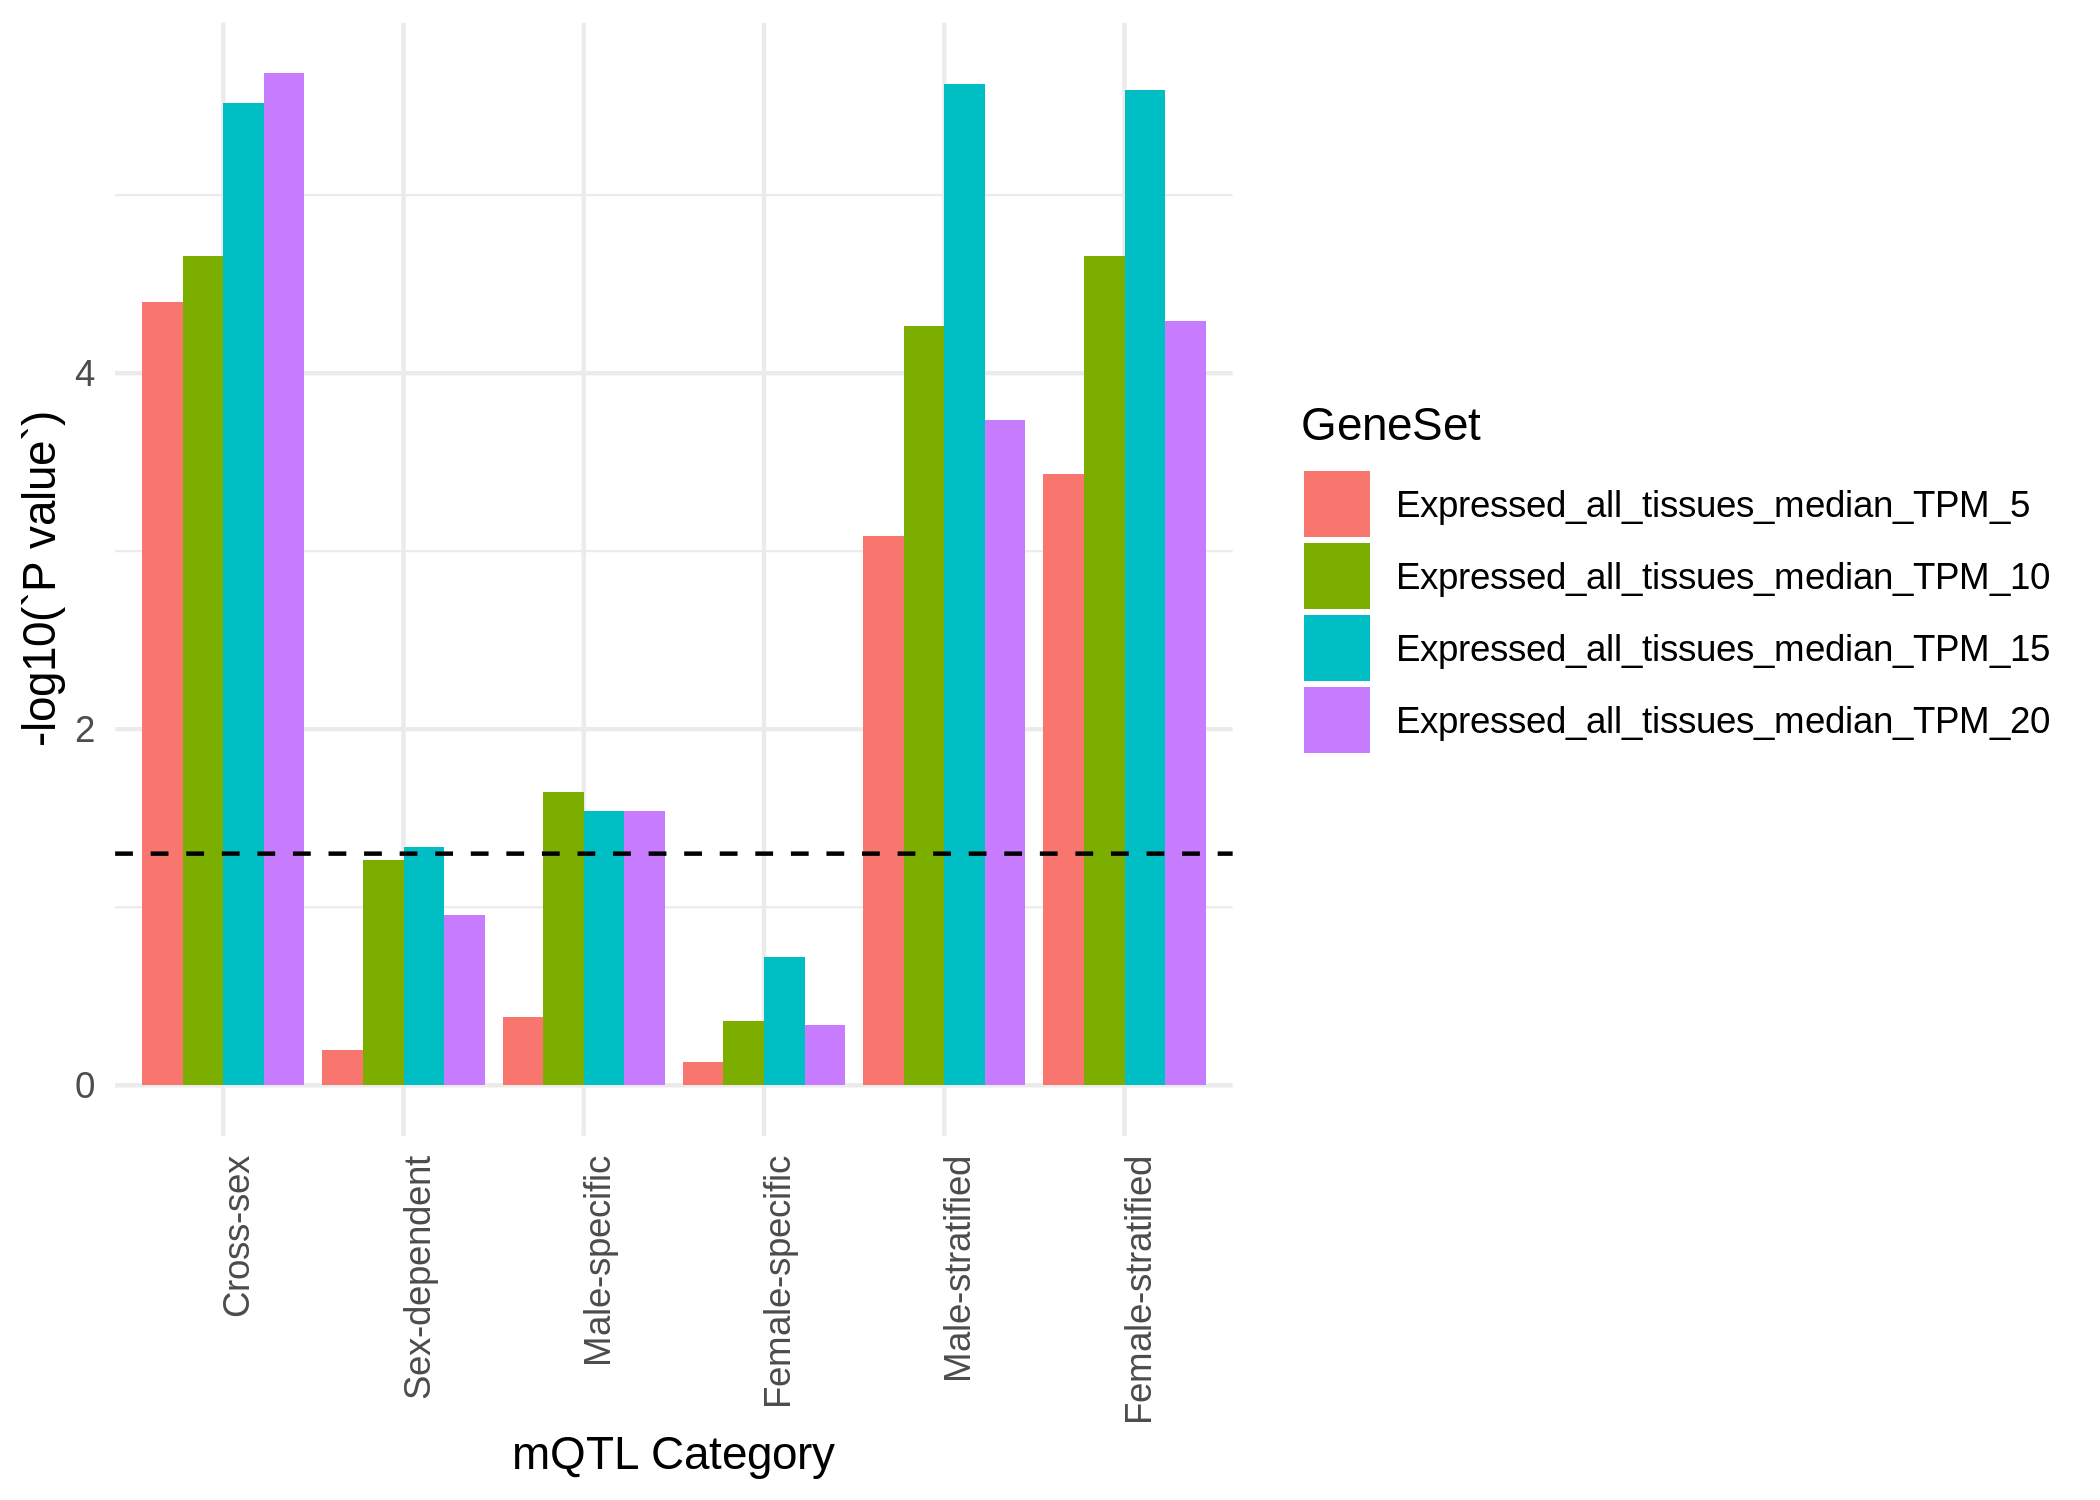

In [58]:
background <- array_genes[array_genes %in% gtex_med_counts$Description]
gtex_hyper_res <- function(set,tpm_thresh){
    select_genes <- gtex_med_counts[apply(gtex_med_counts[,-c(1,2)] > tpm_thresh,1,all)]$Description
    success <- sum(set %in% select_genes)
    white <- sum(select_genes %in% background)
    black <- sum(!background %in% select_genes)
    res <- phyper(success,white,black,sum(set %in% background))
    data.table(
        GeneSet = glue("Expressed_all_tissues_median_TPM_{tpm_thresh}"),
        N_genes= sum(select_genes %in% background),
        N_overlap = success,
        Genes = paste0(na.omit(gtex_med_counts[Description %in% set[set %in% select_genes]]$Name),collapse=":"),
        `P value` = res 
    )
}
res_hyper <- rbindlist(lapply(c(5,10,15,20),function(thresh)rbindlist(lapply(list(`Sex-dependent`=sex_genes,"Male-specific"=male_genes,"Female-specific"=female_genes, "Male-stratified"=male_strat_genes, "Female-stratified" = female_strat_genes,`Cross-sex`=marginal_genes),function(x)gtex_hyper_res(x,thresh)),idcol = 'mQTL Category')))
res_hyper$`mQTL Category` <- factor(res_hyper$`mQTL Category`, levels = c("Cross-sex","Sex-dependent","Male-specific","Female-specific","Male-stratified", "Female-stratified"))
res_hyper$GeneSet <- factor(res_hyper$GeneSet, levels = paste0("Expressed_all_tissues_median_TPM_",c(5,10,15,20)))                                                                             
ggplot(res_hyper, aes(`mQTL Category`, -log10(`P value`),fill=GeneSet)) +
     geom_col(position="dodge") + 
     geom_hline(linetype='dashed',yintercept = -log10(0.05)) +                                                                             
     theme_minimal() + 
     theme(axis.text.x = element_text(angle=90,hjust=1,vjust=1))                                                                                 

In [61]:
res_hyper[Genes == ""]

mQTL Category
1 Male-specific
  GeneSet                            
1 Expressed_all_tissues_median_TPM_20
  N_genes
1 460    
  N_overlap
1 0        
  Genes
1      
  P value   
1 0.02874437

In [62]:
fwrite(res_hyper, here("data", "all_expressed_hypergeometric.csv"))

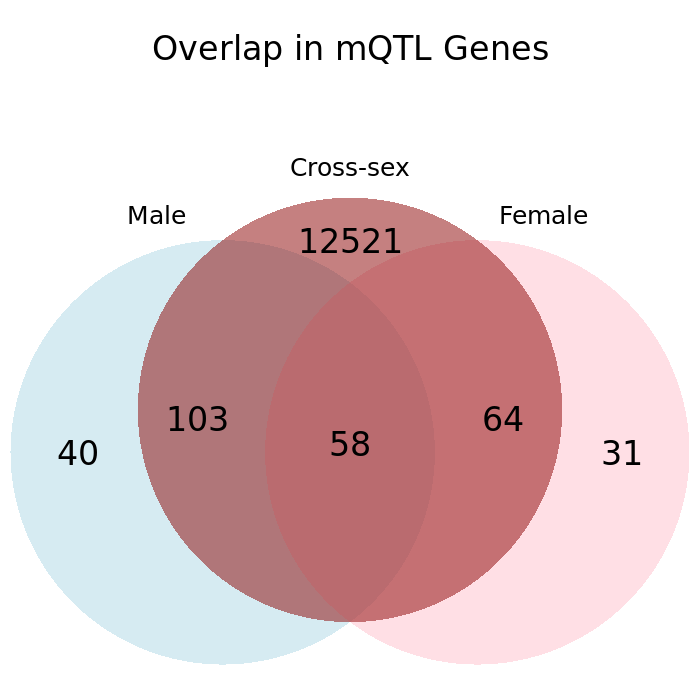

In [48]:
options(repr.plot.width= 7, repr.plot.height= 7, repr.plot.res = 100)
grid.draw(
    venn.diagram(
        list(Male = unique(male_genes), Female = unique(female_genes),"Cross-sex" = unique(marginal_genes)),
        filename=NULL,
        fill=c("light blue", "pink", "dark Red"),
        cat.pos=c(-15,15,0),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in mQTL Genes"
    )
)

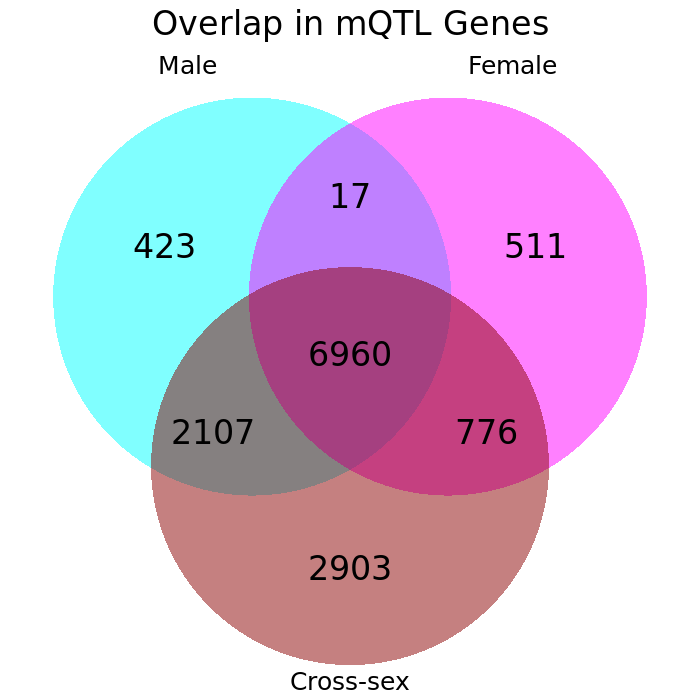

In [49]:
grid.draw(
    venn.diagram(
        list(Male = unique(male_strat_genes), Female = unique(female_strat_genes),"Cross-sex" = unique(marginal_genes)),
        filename=NULL,
        fill=c("cyan", "magenta", "dark Red"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in mQTL Genes"
    )
)

In [ ]:
fwrite(data.table(unique(male_strat_genes)),"../data/male_stratified_genes_bonf.txt",sep='\t',col.names=FALSE,row.names=FALSE)
fwrite(data.table(unique(female_strat_genes)),"../data/female_stratified_genes_bonf.txt",sep='\t',col.names=FALSE,row.names=FALSE)

## Comparison to perinatal mQTL from independent samples (cord blood and fetal brain)

In [3]:
placental_mQTL < -fread(
    here("data", "delahaye_richs_marginal_mecs_maf01.txt.gz"), tmpdir="~/"
)
cord_mQTL < -fread(here("data", "cord.ALL.M.tab"), tmpdir="~/")
fetal_brain_mQTL < -fread(
    here("data", "All_Imputed_BonfSignificant_mQTLs.csv.gz"), tmpdir="~/"
)

In [4]:
head(cord_mQTL)
head(placental_mQTL)
head(fetal_brain_mQTL)

SNP        gene       beta      t-stat    p-value       FDR         
1 rs11890854 cg05194412 -1.052328 -25.33094 2.067351e-103 8.178959e-94
2 rs6430614  cg05194412 -1.074499 -25.06346 8.341605e-102 5.500246e-93
3 rs6430615  cg05194412 -1.074499 -25.06346 8.341605e-102 5.500246e-93
4 rs6725367  cg05194412 -1.074499 -25.06346 8.341605e-102 5.500246e-93
5 rs76733895 cg05194412 -1.074499 -25.06346 8.341605e-102 5.500246e-93
6 rs7603806  cg05194412 -1.074499 -25.06346 8.341605e-102 5.500246e-93

SNP         Chr BP     A1 A2 Freq      Probe      Probe_Chr Probe_bp
1 rs201475892 1   534247 C  T  0.0195051 cg22802167 1         533950  
2 rs201475892 1   534247 C  T  0.0195051 cg24669183 1         534242  
3 rs2427928   1   735068 A  G  0.0412296 cg15560884 1         710097  
4 rs79010578  1   736289 T  A  0.1335070 cg15560884 1         710097  
5 rs370667023 1   738475 G  A  0.0687538 cg15560884 1         710097  
6 rs141443091 1   739210 A  G  0.7517000 cg15560884 1         710097  
  Gene       Orientation b            SE         p       
1 cg22802167 +           -0.000110258 0.00643903 0.986338
2 cg24669183 -           -0.011538500 0.01795520 0.520467
3 cg15560884 +            0.007375840 0.00840938 0.380434
4 cg15560884 +            0.004613070 0.00460856 0.316837
5 cg15560884 +            0.000910940 0.00485251 0.851092
6 cg15560884 +            0.004551980 0.00408068 0.264639

V1 SNP_Chr SNP_BP    SNP_Allele ProbeID    DNAm_CHR DNAm_BP   GeneAnnotation
1 1  1       153588208 A          cg08477332 1        153590243 S100A14       
2 2  1       153588279 A          cg08477332 1        153590243 S100A14       
3 3  1       153588843 A          cg08477332 1        153590243 S100A14       
4 4  1       153591652 A          cg08477332 1        153590243 S100A14       
5 5  1        28562540 A          cg04993605 1         28573052               
6 6  1        28562676 G          cg04993605 1         28573052               
  beta      p.value     
1 0.2071113 3.631868e-90
2 0.2071113 3.631868e-90
3 0.2071113 3.631868e-90
4 0.2071113 3.631868e-90
5 0.2049110 1.129805e-88
6 0.2049110 1.129805e-88

In [5]:
matched_to_cord <- cord_mQTL[`p-value` < 1e-14][placental_mQTL[Freq > 0.05 & Freq < 0.95],on=.(SNP,gene=Probe),nomatch=0]
head(matched_to_cord)
matched_to_fetal_brain <- fetal_brain_mQTL[placental_mQTL[Freq > 0.05 & Freq < 0.95],on=.(SNP_Chr=Chr,SNP_BP=BP,SNP_Allele=A1,ProbeID=Probe),nomatch=0]
head(matched_to_fetal_brain)

SNP        gene       beta      t-stat    p-value      FDR          Chr
1 rs12562034 cg16619049 0.7828434 12.553531 5.140338e-33 4.325986e-27 1  
2 rs7518545  cg16619049 0.7828434 12.553531 5.140338e-33 4.325986e-27 1  
3 rs12562034 cg23100540 0.5456826  8.281368 5.382701e-16 1.538123e-10 1  
4 rs7518545  cg23100540 0.5456826  8.281368 5.382701e-16 1.538123e-10 1  
5 rs13303240 cg03648020 0.3808441  8.691753 2.134942e-17 6.828657e-12 1  
6 rs9442393  cg03648020 0.4003009  9.035445 1.300669e-18 4.494124e-13 1  
  BP     A1 A2 Freq     Probe_Chr Probe_bp Gene       Orientation b          
1 768448 G  A  0.125459 1         805541   cg16619049 +           -0.10122900
2 769963 G  A  0.126353 1         805541   cg16619049 +           -0.10266900
3 768448 G  A  0.125459 1         805554   cg23100540 +           -0.05955640
4 769963 G  A  0.126353 1         805554   cg23100540 +           -0.06004070
5 993360 C  A  0.486808 1         931327   cg03648020 -            0.00515603
6 995481 T  G  0.473908 1         931327   cg03648020 -            0.00436122
  SE         p          
1 0.01309980 1.09667e-14
2 0.01333970 1.39867e-14
3 0.00860890 4.58057e-12
4 0.00877689 7.87705e-12
5 0.00180340 4.24886e-03
6 0.00179343 1.50249e-02

V1    SNP_Chr SNP_BP SNP_Allele ProbeID    DNAm_CHR DNAm_BP GeneAnnotation
1 42378 1       830181 A          cg08128007 1        839435                
2 20368 1       862866 C          cg14156792 1        870958  SAMD11        
3 15775 1       864938 G          cg14156792 1        870958  SAMD11        
4  3737 1       871334 G          cg14156792 1        870958  SAMD11        
5  3171 1       871683 G          cg14156792 1        870958  SAMD11        
6 20590 1       881627 G          cg14156792 1        870958  SAMD11        
  beta        p.value      SNP          A2 Freq     Probe_Chr Probe_bp
1 -0.04960243 7.291825e-09 rs28444699   G  0.656904 1         839435  
2 -0.05985450 9.532873e-13 rs3892970    T  0.516678 1         870958  
3 -0.06643963 1.447713e-14 rs2340587    A  0.547830 1         870958  
4 -0.08683402 7.167375e-26 1:871334:G:T T  0.540390 1         870958  
5 -0.09335919 3.042786e-27 rs4504834    A  0.682002 1         870958  
6 -0.06638178 1.173263e-12 rs2272757    A  0.481914 1         870958  
  Gene       Orientation b          SE         p          
1 cg08128007 +            0.0398932 0.00625954 1.85148e-10
2 cg14156792 -           -0.0120512 0.00561725 3.19217e-02
3 cg14156792 -           -0.0129652 0.00509643 1.09599e-02
4 cg14156792 -           -0.0122990 0.00392791 1.74101e-03
5 cg14156792 -           -0.0219889 0.00600341 2.49535e-04
6 cg14156792 -           -0.0135462 0.00549601 1.37115e-02

In [6]:
cord_placenta <- placental_mQTL[Freq > 0.05 & Freq < 0.95 & p < (0.05 /.N)][cord_mQTL,on=.(SNP,Probe=gene), nomatch=0]
fetal_brain_placenta <- placental_mQTL[Freq > 0.05 & Freq < 0.95 & p < (0.05 /.N)][fetal_brain_mQTL,on=.(Chr=SNP_Chr,BP=SNP_BP,A1=SNP_Allele,Probe=ProbeID), nomatch=0]

In [7]:
cor_cord <- cor.test(matched_to_cord$b,matched_to_cord$beta,method="spearman")
print(glue::glue("
Cord blood mQTL (SNP-CpG overlap: {nrow(matched_to_cord)})})
    pi1={1-qvalue::pi0est(matched_to_cord$p)$pi0}
    pi1_trunc={1-qvalue::pi0est(cord_placenta$`p-value` / max(cord_placenta$`p-value`))$pi0}
    rho={cor_cord$estimate}
    p={cor_cord$p.value}
"))
cor_cord$p.value
cor_brain <- cor.test(matched_to_fetal_brain$b,matched_to_fetal_brain$beta,method="spearman")
print(glue::glue("
Fetal brain mQTL (SNP-CpG overlap: {nrow(matched_to_fetal_brain)})})
    pi1={1-qvalue::pi0est(matched_to_fetal_brain$p)$pi0}
    pi1_trunc={1-qvalue::pi0est(fetal_brain_placenta$p.value / max(fetal_brain_placenta$p.value))$pi0}
    rho={cor_brain$estimate}
    p={cor_brain$p.value}
"))

Warning message in cor.test.default(matched_to_cord$b, matched_to_cord$beta, method = "spearman"):
“Cannot compute exact p-value with ties”


Cord blood mQTL (SNP-CpG overlap: 999208)})
    pi1=0.76410176848802
    pi1_trunc=0.968491885809398
    rho=-0.307577653949611
    p=0


[1] 0

Warning message in cor.test.default(matched_to_fetal_brain$b, matched_to_fetal_brain$beta, :
“Cannot compute exact p-value with ties”


Fetal brain mQTL (SNP-CpG overlap: 70331)})
    pi1=0.839615515906365
    pi1_trunc=0.928221879225755
    rho=0.648794761409569
    p=0


In [8]:
gene_mapping <- gsub(";.*","",array_annot$UCSC_RefGene_Name)
names(gene_mapping) <- array_annot$Name

List of 3
 $ Placenta   : chr [1:49252] "cg16619049" "cg23100540" "cg04195702" "cg08128007" ...
 $ Cord blood : chr [1:27992] "cg05194412" "cg18712599" "cg01168696" "cg25422880" ...
 $ Fetal brain: chr [1:30708] "cg08477332" "cg04993605" "cg12339802" "cg11066601" ...


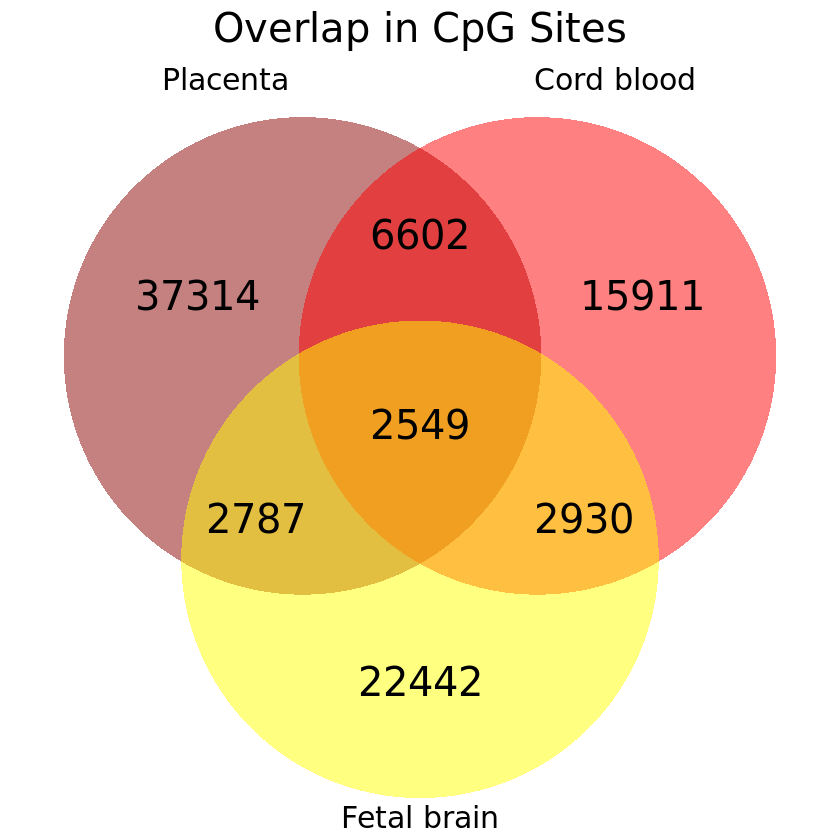

In [12]:
venn_data <- list(
    "Placenta"= unique(placental_mQTL[Freq > 0.05 & Freq < 0.95][p < (0.05 / .N)]$Probe),
    "Cord blood" = unique(cord_mQTL[`p-value` < 1e-14]$gene),
    "Fetal brain" =unique(fetal_brain_mQTL$ProbeID)
)
str(venn_data)
grid.draw(
    venn.diagram(
        venn_data,
        filename=NULL,
        fill=c("dark red","red","yellow"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in CpG Sites"
    )
)

List of 3
 $ Placenta   : chr [1:10698] "FAM41C" "FLJ39609" "SAMD11" "NOC2L" ...
 $ Cord blood : chr [1:8380] "TMEM163" "MGAT5" "MCM6" "LCT" ...
 $ Fetal brain: chr [1:10885] "S100A14" "C1orf109" "PM20D1" "SHISA4" ...


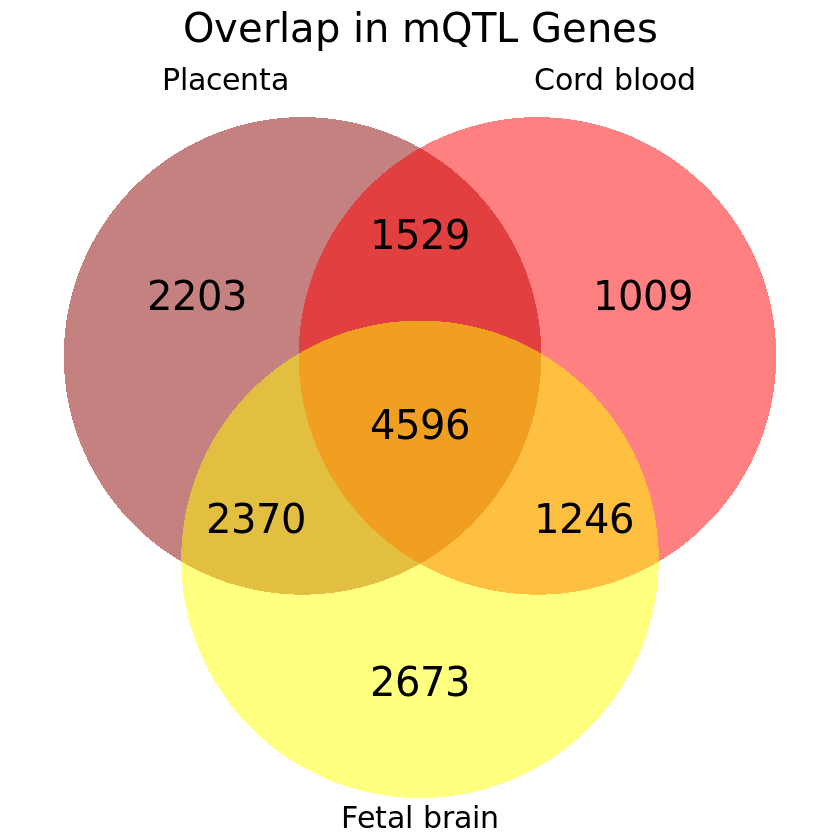

In [11]:
venn_gene_data <- list(
    "Placenta"= na.omit(unique(gene_mapping[venn_data[["Placenta"]]])),
    "Cord blood" = na.omit(unique(gene_mapping[venn_data[["Cord blood"]]])),
    "Fetal brain" =na.omit(unique(gene_mapping[venn_data[["Fetal brain"]]]))
)
venn_gene_data <- lapply(venn_gene_data,function(x) x[x!=""])
str(venn_gene_data)
grid.draw(
    venn.diagram(
        venn_gene_data,
        filename=NULL,
        fill=c("dark red","red","yellow"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in mQTL Genes"
    )
)